# Modification of Santa's 2019 Starter Notebook for Genetic Algorithm method

## Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time 
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os

from numba import njit

In [3]:
# The name of the kernel might change, so update this if needed
from santa_s_2019_faster_cost_function_24_s import build_cost_function

## Definitions

In [4]:
# Paths to folders/files
#PATH_INPUT = '/kaggle/input' #for kaggle
PATH_INPUT = 'kaggle/input'
PATH_TO_SAVE_DATA = "../../data"
PATH_BASELINE_0 = PATH_TO_SAVE_DATA + '/df_fake_news.pkl'
PATH_SAVE_PROB_FAM = PATH_TO_SAVE_DATA + '/df_prob_fam.pkl'
PATH_SAVE_DF_POP = PATH_TO_SAVE_DATA + '/df_pop.pkl'
PATH_SAVE_DF_POP_10 = PATH_TO_SAVE_DATA + '/df_pop_10.pkl'
# Data information
DAY_RANGE = list(range(1, 101)) # day before Christmas
DAY_RANGE_MIN = np.min(DAY_RANGE) 
DAY_RANGE_MAX = np.max(DAY_RANGE) 

# Hyper-parameters:
NB_FIRST_POP = 1000 # number of first population of choices 
R_FIRST_MUT = 0.01 # RATIO of mutation for first population
R_POP_MUT = 0.05 # RATIO of population mutation after first generation
R_MUT = 0.01 # RATIO of number of family choices mutated
DELTA_DAYS = 1 # delta of days around previous best day for generation/mutation
R_POP_LOST = 0.01 # Ratio of lost individuals in population 
NB_MAX_EPOCHS = 1000
# method 2 : by choices
DELTA_CHOICE = 1
CHOICE_RANGE_MIN = 0
CHOICE_RANGE_MAX = 10

In [5]:
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Useful functions

In [127]:
def find_choice_range(choice_curr):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    '''
    choice_min = np.min([np.max([CHOICE_RANGE_MIN, choice_curr - DELTA_CHOICE]), 
                          CHOICE_RANGE_MAX - 2 * DELTA_CHOICE])
    choice_max = np.min([CHOICE_RANGE_MAX, 
                        np.max([CHOICE_RANGE_MIN + 2 * DELTA_CHOICE, 
                        choice_curr + DELTA_CHOICE])]) + 1
    range_choice = range(choice_min, choice_max)
    
    return range_choice



def find_choice_from_day(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    fam_days = data_choice.loc[fam_id]
    
    idx_choice_curr = fam_days[day_curr == fam_days].index
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    #fam_days = arr_choice[fam_id,:]
    #idx_choice_curr = fam_days[day_curr == fam_days].index
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]
    
def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]
    #try:
    #    return idx_choice_curr[0]
    #except:
    #    return 10 
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def choose_day_prob(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
  
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = data_choice.loc[fam_id, np.minimum(9, choice_curr)]
    vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = np.array(df_prob_fam.astype("float").loc[fam_id])/ \
            df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                ''' print("days_10: ", days_10)
                print("vect_days_choice: ", np.array(vect_days_choice))
                print("vect_days_choice[indice]: ", 
                      np.array(vect_days_choice)[indice])
                print("i_day: ", i_day)
                print("days_10[i_day]: ", days_10[i_day])
                print("indice : ", indice)'''

                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice
    
def choose_day_prob_arr(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = arr_choice[fam_id, np.minimum(9, choice_curr)]
    #vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = arr_prob_fam[fam_id]/arr_prob_fam[fam_id].sum()
        #np.array(df_prob_fam.astype("float").loc[fam_id])/ \
        #    df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice    

 
def mutation_day(day_curr, fam_id, nb_mut=1, flag_prob=False):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    choice_curr = find_choice_from_day_arr(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range(choice_curr)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    #print("choice_new: ", choice_new)
    return choose_day_prob_arr(choice_new, fam_id)

def find_day_range(day_curr):
    '''
    select range of days from random between +/- delta day around day_curr
    
    return a range
    '''
    day_min = np.min([np.max([DAY_RANGE_MIN, day_curr-DELTA_DAYS]), 
                      DAY_RANGE_MAX - 2 * DELTA_DAYS])
    day_max = np.min([DAY_RANGE_MAX, np.max([DAY_RANGE_MIN + 2 * DELTA_DAYS, 
                                             day_curr + DELTA_DAYS])]) + 1
    range_day = range(day_min, day_max)

    return range_day


def generate_pop(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        # find range around day curr +/- DELTA
        range_curr = find_day_range(day_curr)
        # retrict probabilities to range. use df_prob_fam = f(fam_id, day)
        day_prob = df_prob_fam.astype("float").loc[fam_id, range_curr]/ \
            df_prob_fam.loc[fam_id, range_curr].sum()
        # choose randomly with probabilities days around old best day
        vect_pop_mutated = np.random.choice(np.array(range_curr), 
                                size=nb_pop, 
                                p=np.array(day_prob))

        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

In [150]:
find_choice_range(6)

range(4, 9)

In [111]:
@njit
def test_min(x):
    x = np.array(x)
    return np.min(x)

test_min([1,2])

1

In [103]:
mutation_day(89, fam_id, 10)

array([68, 42, 81, 24, 24, 19,  7, 42,  2, 19])

In [7]:
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    list_days.append(mutation_day(day_curr, fam_id, 1, True))
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'day_curr' is not defined

In [8]:
nb_mut = 1
vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
t_fit_0 = time.time()
for I in range(0,1000):
    vect_prob = vect_prob / vect_prob.sum()
    #print("vect_prob: ", vect_prob)
    choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'arr_prob' is not defined

In [9]:
choice_new

NameError: name 'choice_new' is not defined

In [10]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'choice_new' is not defined

In [11]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_from_day(day_curr, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'day_curr' is not defined

In [12]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_from_day_arr(day_curr, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'day_curr' is not defined

In [13]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_range(choice_curr)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'choice_curr' is not defined

In [14]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

NameError: name 'range_choices' is not defined

In [15]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

NameError: name 'range_choices' is not defined

In [16]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
        day_new = choose_day_prob(choice_new, fam_id)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    
    vect_prob = vect_prob / vect_prob.sum()
    #print("vect_prob: ", vect_prob)

    
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

NameError: name 'range_choices' is not defined

In [17]:

arr_choice = np.array(data_choice)



find_choice_from_day_arr(52, 0)

NameError: name 'data_choice' is not defined

In [18]:
find_choice_from_day(52, 0)

NameError: name 'data_choice' is not defined

In [19]:
def test_fun():
    day_curr = 28
    print(arr_choice[0,:])
    print(arr_choice[0,:] == day_curr)
    idx_choice_curr = np.nonzero(arr_choice[0,:] == day_curr)[0]
    if idx_choice_curr.shape[0] == 0:
        print( 10 )
    else:
        print(idx_choice_curr[0])
test_fun()

NameError: name 'arr_choice' is not defined

In [20]:
arr_prob_fam

NameError: name 'arr_prob_fam' is not defined

In [21]:
arr_choice[fam_id, np.minimum(9, choice_curr)]

NameError: name 'arr_choice' is not defined

In [22]:
data_choice.loc[fam_id, np.minimum(9, choice_curr)]

NameError: name 'data_choice' is not defined

In [23]:
choice_new = np.array([8])

In [24]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob_arr(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'fam_id' is not defined

In [25]:
choose_day_prob_arr(choice_new, fam_id)

NameError: name 'fam_id' is not defined

In [26]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

NameError: name 'fam_id' is not defined

In [27]:
choose_day_prob(choice_new, fam_id)

NameError: name 'fam_id' is not defined

In [28]:
day_curr

NameError: name 'day_curr' is not defined

In [29]:
arr_prob_fam[fam_id]/arr_prob_fam[fam_id].sum() \
-np.array(df_prob_fam.astype("float").loc[fam_id])/df_prob_fam.loc[fam_id].sum()

NameError: name 'arr_prob_fam' is not defined

In [30]:
np.array(df_prob_fam.astype("float").loc[fam_id])/df_prob_fam.loc[fam_id].sum()

NameError: name 'df_prob_fam' is not defined

In [31]:
data_choice

NameError: name 'data_choice' is not defined

In [32]:
arr_choice = np.array(data_choice)
arr_choice

NameError: name 'data_choice' is not defined

In [33]:
nb_mut

1

In [34]:
vect_prob

NameError: name 'vect_prob' is not defined

In [35]:
np.array(range_choices)

NameError: name 'range_choices' is not defined

In [36]:
df_prob

NameError: name 'df_prob' is not defined

In [37]:
arr_prob = np.array(df_prob)
arr_prob[0,0]

NameError: name 'df_prob' is not defined

In [38]:
family_size_dict[0]

NameError: name 'family_size_dict' is not defined

In [39]:
arr_prob[family_size_dict[0]-2,range_choices]

NameError: name 'arr_prob' is not defined

In [40]:
data.head()

NameError: name 'data' is not defined

In [41]:
arr_prob_fam = np.array(df_prob_fam.astype("float"))
arr_prob_fam

NameError: name 'df_prob_fam' is not defined

In [578]:
df_prob_fam.head()

1           2           3           4           5    \
family_id                                                                
0          0.000562249  0.00360138  0.00180319  0.00167978  0.00166473   
1          0.000562249  0.00360138  0.00180319   0.0546079    0.053444   
2          0.000565183  0.00362018   0.0018126  0.00168854  0.00167342   
3            0.0516533   0.0556045  0.00182172  0.00169704  0.00168184   
4            0.0534904  0.00360138   0.0517657  0.00167978  0.00166473   

                  6           7           8           9           10   \
family_id                                                               
0           0.0039927  0.00351573  0.00373799  0.00357761   0.0480268   
1           0.0516575  0.00351573  0.00373799  0.00357761  0.00169776   
2          0.00401353  0.00353408  0.00375749  0.00359628   0.0498192   
3           0.0529431  0.00355186   0.0037764    0.049467   0.0017152   
4           0.0039927  0.00351573  0.00373799  0.00357761  0.00169776   

             ...             91         92         93          94   \
family_id    ...                                                     
0            ...      0.00992993  0.0121119   0.013522  0.00232124   
1            ...      0.00992993  0.0121119   0.013522  0.00232124   
2            ...      0.00998174  0.0121751  0.0135926  0.00233335   
3            ...        0.010032  0.0122364   0.013661  0.00234509   
4            ...      0.00992993  0.0121119  0.0653013  0.00232124   

                  95          96         97         98         99         100  
family_id                                                                      
0          0.00229422  0.00223432  0.0120446  0.0114308  0.0122488  0.0108946  
1          0.00229422  0.00223432  0.0120446  0.0114308  0.0122488  0.0108946  
2          0.00230619  0.00224598  0.0121075  0.0114904  0.0123127    0.06372  
3           0.0536363    0.052695  0.0121684  0.0115482  0.0123747  0.0110066  
4          0.00229422  0.00223432  0.0120446  0.0114308  0.0122488  0.0108946  

[5 rows x 100 columns]

## Read in the family information and sample submission

In [8]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

data_choice = data.iloc[:,range(0,10)]
data_choice.columns = range(0,10)
# patch for optimization
arr_choice = np.array(data_choice)
data_choice.head()


0   1   2   3   4   5   6   7   8   9
family_id                                         
0           52  38  12  82  33  75  64  76  10  28
1           26   4  82   5  11  47  38   6  66  61
2          100  54  25  12  27  82  10  89  80  33
3            2  95   1  96  32   6  40  31   9  59
4           53   1  47  93  26   3  46  16  42  39

In [9]:
data.head()

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  \
family_id                                                               
0                52        38        12        82        33        75   
1                26         4        82         5        11        47   
2               100        54        25        12        27        82   
3                 2        95         1        96        32         6   
4                53         1        47        93        26         3   

           choice_6  choice_7  choice_8  choice_9  n_people  
family_id                                                    
0                64        76        10        28         4  
1                38         6        66        61         4  
2                10        89        80        33         3  
3                40        31         9        59         2  
4                46        16        42        39         4

In [10]:
submission.head()

assigned_day
family_id              
0                   100
1                    99
2                    98
3                    97
4                    96

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [11]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [12]:
# Build your "cost_function"
cost_function_optim = build_cost_function(data)

In [13]:
#del(cost_function_optim)

In [14]:
def cost_function(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

In [15]:
list_p0 = np.array([0, 50, 50, 100, 200, 200, 300, 300, 400, 500, 500])
list_pn = np.array([0, 0, 9, 9, 9, 18, 18, 36, 36, 36+199, 36+398])

In [16]:
def cost_function_arr(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        #list_choice = np.array(list_choice)
        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        
        if d == choice_0:
            idx_choice = 0
        elif d == choice_1:
            idx_choice = 1
        elif d == choice_2:
            idx_choice = 2
        elif d == choice_3:
            idx_choice = 3
        elif d == choice_4:
            idx_choice = 4
        elif d == choice_5:
            idx_choice = 5
        elif d == choice_6:
            idx_choice = 6
        elif d == choice_7:
            idx_choice = 7
        elif d == choice_8:
            idx_choice = 8
        elif d == choice_9:
            idx_choice = 9
        else:
            idx_choice = 10
        
       # print(idx_choice)
        penalty += list_p0[idx_choice] + n * list_pn[idx_choice]
        

        
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

In [17]:
cost_function_optim(submission['assigned_day'].values)

10641498.403135022

In [18]:
cost_function_arr(submission['assigned_day'], True)

penalty for only families:  10639591
daily_occupancy:  {100: 206, 99: 203, 98: 209, 97: 204, 96: 233, 95: 203, 94: 210, 93: 197, 92: 207, 91: 237, 90: 211, 89: 220, 88: 212, 87: 204, 86: 203, 85: 211, 84: 214, 83: 209, 82: 211, 81: 232, 80: 204, 79: 226, 78: 217, 77: 211, 76: 208, 75: 199, 74: 213, 73: 203, 72: 223, 71: 218, 70: 210, 69: 207, 68: 197, 67: 189, 66: 203, 65: 204, 64: 219, 63: 222, 62: 205, 61: 227, 60: 211, 59: 195, 58: 215, 57: 198, 56: 201, 55: 210, 54: 213, 53: 213, 52: 199, 51: 212, 50: 214, 49: 199, 48: 205, 47: 207, 46: 226, 45: 203, 44: 224, 43: 208, 42: 209, 41: 220, 40: 201, 39: 214, 38: 207, 37: 196, 36: 212, 35: 203, 34: 204, 33: 199, 32: 233, 31: 225, 30: 211, 29: 206, 28: 228, 27: 201, 26: 217, 25: 207, 24: 209, 23: 198, 22: 214, 21: 209, 20: 216, 19: 201, 18: 188, 17: 212, 16: 200, 15: 206, 14: 210, 13: 205, 12: 192, 11: 216, 10: 237, 9: 207, 8: 214, 7: 207, 6: 198, 5: 221, 4: 217, 3: 206, 2: 230, 1: 203}
accounting_cost:  1907.4031350226594


10641498.403135022

In [24]:
cost_function(df_pop.loc[indice].tolist(), True)

NameError: name 'indice' is not defined

In [72]:
df_cost.sort_values(by="cost").head()

cost
116 -2.150357e+285
185 -2.150357e+285
995 -2.150357e+285
438 -2.150357e+285
460 -2.150357e+285

In [25]:
cost_function_optim(df_pop.loc[116].values)

inc_curr True
inc_curr True
inc_curr True
inc_curr True
inc_curr True
inc_curr True
[ True False  True False False False False False False  True False  True
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
penalty:  600688791.0
accounting_cost:  8394.389326297598


600697185.3893263

In [26]:
cost_function(df_pop.loc[116].values, True)

penalty for only families:  688791
daily_occupancy:  {100: 126, 99: 126, 98: 126, 97: 126, 96: 170, 95: 205, 94: 244, 93: 125, 92: 129, 91: 132, 90: 145, 89: 187, 88: 221, 87: 195, 86: 154, 85: 136, 84: 125, 83: 127, 82: 168, 81: 211, 80: 204, 79: 126, 78: 125, 77: 129, 76: 130, 75: 180, 74: 205, 73: 200, 72: 126, 71: 127, 70: 121, 69: 129, 68: 177, 67: 212, 66: 239, 65: 125, 64: 132, 63: 128, 62: 133, 61: 184, 60: 229, 59: 226, 58: 183, 57: 127, 56: 143, 55: 179, 54: 219, 53: 228, 52: 243, 51: 217, 50: 195, 49: 209, 48: 225, 47: 262, 46: 270, 45: 239, 44: 201, 43: 182, 42: 191, 41: 202, 40: 240, 39: 262, 38: 229, 37: 197, 36: 145, 35: 182, 34: 203, 33: 247, 32: 273, 31: 266, 30: 236, 29: 235, 28: 256, 27: 262, 26: 288, 25: 296, 24: 293, 23: 276, 22: 255, 21: 228, 20: 244, 19: 278, 18: 304, 17: 295, 16: 266, 15: 272, 14: 260, 13: 289, 12: 302, 11: 300, 10: 302, 9: 276, 8: 277, 7: 252, 6: 252, 5: 290, 4: 295, 3: 305, 2: 293, 1: 302}
accounting_cost:  8394.389326297598


600697185.3893263

In [54]:
cost_function_optim(df_pop.loc[indice].tolist())

NameError: name 'df_pop' is not defined

In [57]:
cost_function(submission['assigned_day'].values, True)

penalty for only families:  10639591
daily_occupancy:  {100: 206, 99: 203, 98: 209, 97: 204, 96: 233, 95: 203, 94: 210, 93: 197, 92: 207, 91: 237, 90: 211, 89: 220, 88: 212, 87: 204, 86: 203, 85: 211, 84: 214, 83: 209, 82: 211, 81: 232, 80: 204, 79: 226, 78: 217, 77: 211, 76: 208, 75: 199, 74: 213, 73: 203, 72: 223, 71: 218, 70: 210, 69: 207, 68: 197, 67: 189, 66: 203, 65: 204, 64: 219, 63: 222, 62: 205, 61: 227, 60: 211, 59: 195, 58: 215, 57: 198, 56: 201, 55: 210, 54: 213, 53: 213, 52: 199, 51: 212, 50: 214, 49: 199, 48: 205, 47: 207, 46: 226, 45: 203, 44: 224, 43: 208, 42: 209, 41: 220, 40: 201, 39: 214, 38: 207, 37: 196, 36: 212, 35: 203, 34: 204, 33: 199, 32: 233, 31: 225, 30: 211, 29: 206, 28: 228, 27: 201, 26: 217, 25: 207, 24: 209, 23: 198, 22: 214, 21: 209, 20: 216, 19: 201, 18: 188, 17: 212, 16: 200, 15: 206, 14: 210, 13: 205, 12: 192, 11: 216, 10: 237, 9: 207, 8: 214, 7: 207, 6: 198, 5: 221, 4: 217, 3: 206, 2: 230, 1: 203}
accounting_cost:  1907.4031350226594


10641498.403135022

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
penalty:  10639591.0
accounting_cost:  1907.4031350226594


10641498.403135022

In [776]:
submission['assigned_day'].values

array([100,  99,  98, ...,   3,   2,   1])

In [683]:
for day in submission['assigned_day']:
    arr_fam_cost[n-2, find_choice_from_day_arr(day, 0)]

In [666]:
arr_fam_cost[n-2, find_choice_from_day_arr(51, 0)]

3972

In [781]:
# Run it on default submission file
best = submission['assigned_day'].values
start_score = cost_function(best)
start_score

100001907.40313502

In [771]:
def test_cost_time():
    for I in range(0,1000):
        cost_function(submission['assigned_day'].values)
%time test_cost_time()

CPU times: user 17 ms, sys: 1.12 ms, total: 18.1 ms
Wall time: 19.8 ms


In [765]:
def test_cost_arr_time():
    for I in range(0,1000):
        cost_function_arr(submission['assigned_day'])
%time test_cost_arr_time()

CPU times: user 13 s, sys: 258 ms, total: 13.2 s
Wall time: 15.3 s


In [21]:
def test_cost_optim_time():
    for I in range(0,1000):
        cost_function_optim(submission['assigned_day'].values)
%time test_cost_optim_time()

CPU times: user 35.3 ms, sys: 2.65 ms, total: 37.9 ms
Wall time: 39.6 ms


In [644]:
df_fam_cost

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2         0        50        68       118       218       236       336   
3         0        50        77       127       227       254       354   
4         0        50        86       136       236       272       372   
5         0        50        95       145       245       290       390   
6         0        50       104       154       254       308       408   
7         0        50       113       163       263       326       426   
8         0        50       122       172       272       344       444   

   choice_7  choice_8  choice_9  choice_10  n  
2       372       472       970       1368  2  
3       408       508      1205       1802  3  
4       444       544      1440       2236  4  
5       480       580      1675       2670  5  
6       516       616      1910       3104  6  
7       552       652      2145       3538  7  
8       588       688      2380       3972  8

In [652]:
arr_fam_cost = np.array(df_fam_cost.filter(items=[f'choice_{i}' for i in range(11)]))
arr_fam_cost

array([[   0,   50,   68,  118,  218,  236,  336,  372,  472,  970, 1368],
       [   0,   50,   77,  127,  227,  254,  354,  408,  508, 1205, 1802],
       [   0,   50,   86,  136,  236,  272,  372,  444,  544, 1440, 2236],
       [   0,   50,   95,  145,  245,  290,  390,  480,  580, 1675, 2670],
       [   0,   50,  104,  154,  254,  308,  408,  516,  616, 1910, 3104],
       [   0,   50,  113,  163,  263,  326,  426,  552,  652, 2145, 3538],
       [   0,   50,  122,  172,  272,  344,  444,  588,  688, 2380, 3972]])

## Simple Opimization Approach : baseline #0

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [33]:
t_fit_0 = time.time()
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)
new = best.copy()
cost_best = start_cost
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        cost_curr = cost_function(temp) # test cost
        if cost_curr < cost_best:
            new = temp.copy()
            cost_best = cost_curr
            #print("Current best cost: ", cost_best)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022


KeyboardInterrupt: 

In [172]:
np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# save for later use
joblib.dump(submission, PATH_BASELINE_0)


## Explore day occupancy

In [350]:
# show how people choose days : 
# 5 first choices 
# 5 last choices
#data
df_day = pd.DataFrame(index=range(1,101))
df_day["all_choices"] = 0
df_day["first_choices"] = 0
df_day["mid_choices"] = 0
df_day["last_choices"] = 0
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
list_choice_first = ['choice_{}'.format(n) for n in range(0, 3)]
list_choice_mid = ['choice_{}'.format(n) for n in range(3, 7)]
list_choice_last = ['choice_{}'.format(n) for n in range(7, 10)]

# for each first choices, add to each days the number of people
for choice in list_choice_all:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "all_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_first:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "first_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_mid:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "mid_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_last:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "last_choices"] += data.at[indice, "n_people"]
        
df_day.head()

all_choices  first_choices  mid_choices  last_choices
1        11568           4391         4449          2728
2         1806            501          729           576
3         3607           1021         1526          1060
4         3872           1148         1585          1139
5         3907           1181         1544          1182

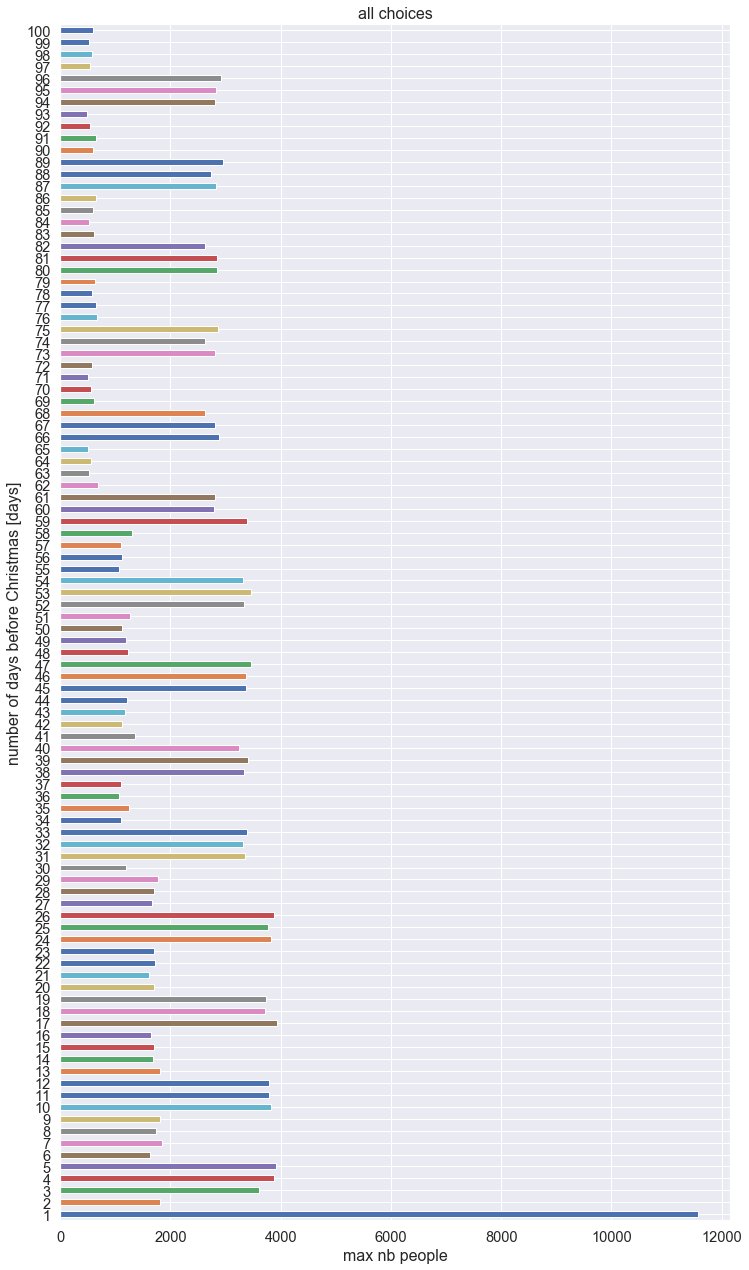

In [351]:
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_day["all_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("all choices");

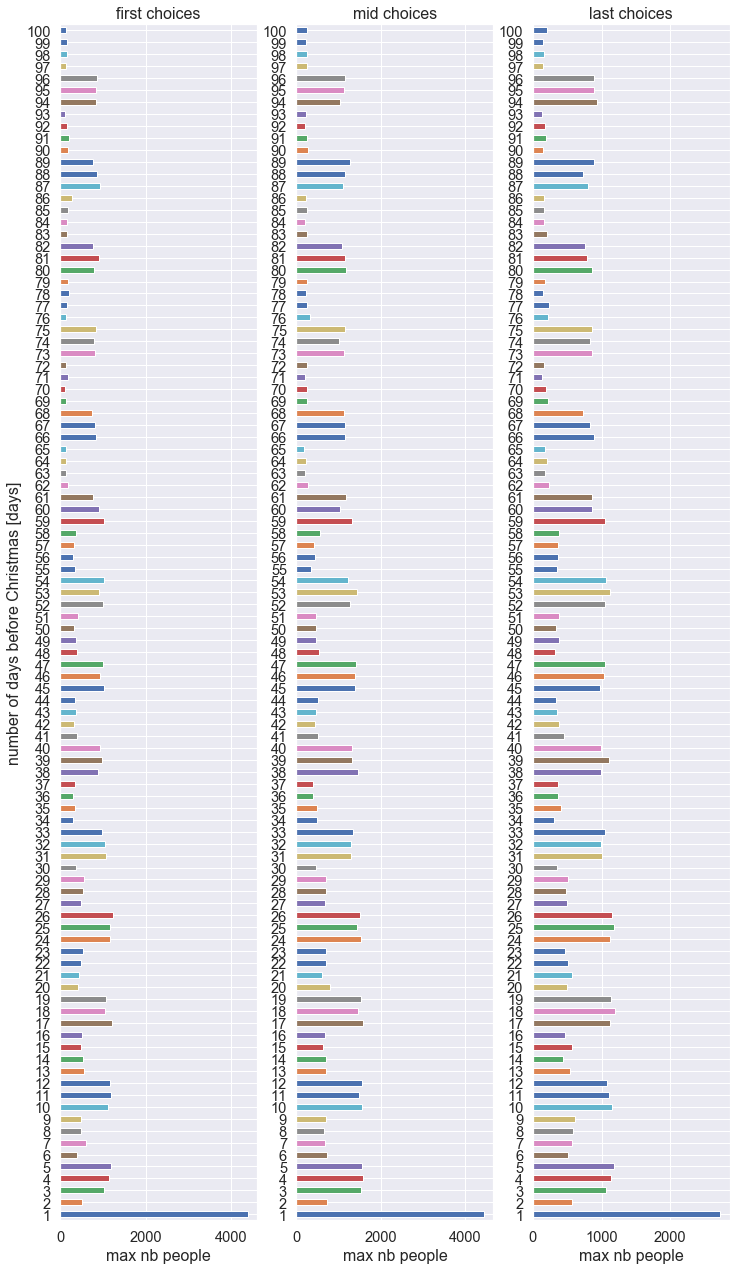

In [352]:
fig = plt.figure(figsize=(12, 22)) 
#plt.title("potential people vs choices")

ax1 = fig.add_subplot(1,3,1)
df_day["first_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("first choices")

ax2 = fig.add_subplot(1,3,2)
df_day["mid_choices"].plot.barh(ax=ax2)
ax2.set_xlabel("max nb people")
ax2.set_title("mid choices")

ax3 = fig.add_subplot(1,3,3)
df_day["last_choices"].plot.barh(ax=ax3)
ax3.set_xlabel("max nb people")
ax3.set_title("last choices");

### Creation of probality matrix

In [353]:
'''df_prob = df_fam_cost.filter(items=list_choice)
vect_penalty = [0, np.max(np.max(df_prob))]
print("vect_penalty: ", vect_penalty)
vect_prob = [0.1, 0.03]
print("vect_prob", vect_prob)
# family : number of people
df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
for indice in df_prob.index:
    df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

df_prob'''

df_prob_day = pd.DataFrame(df_day["all_choices"])
df_prob_day["prob"] = 1/df_prob_day["all_choices"]
df_prob_day["prob"] = df_prob_day["prob"] / df_prob_day["prob"].sum()
df_prob_day["prob"].sum()

1.0

In [354]:
df_prob_day.head()

all_choices      prob
1        11568  0.001098
2         1806  0.007036
3         3607  0.003523
4         3872  0.003282
5         3907  0.003252

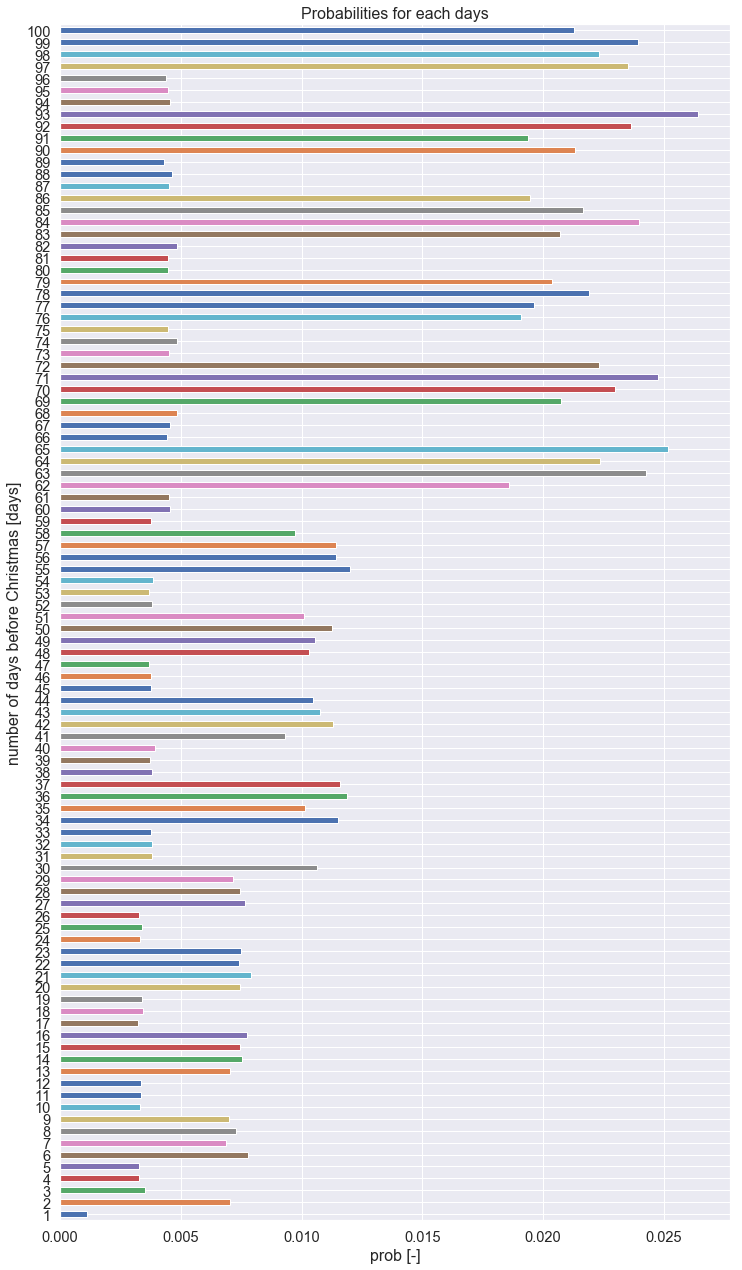

In [355]:
#df_prob_day["prob"].plot.barh()
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_prob_day["prob"].plot.barh(ax=ax1)
ax1.set_xlabel("prob [-]")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");

## Explore family choice cost

In [41]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

In [42]:
cost_family(choice=1, n=2)

50

### Evolution of cost by number of people into family

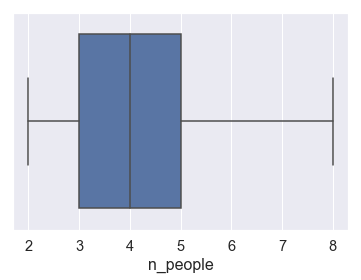

In [43]:
ax = sns.boxplot(x=data["n_people"])


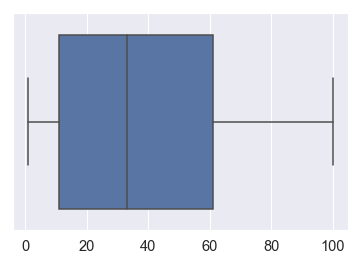

In [44]:
ax = sns.boxplot(data)

In [45]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

choice_0 choice_1 choice_2 choice_3 choice_4 choice_5 choice_6 choice_7  \
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
8      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

  choice_8 choice_9 choice_10  n  
2      NaN      NaN       NaN  2  
3      NaN      NaN       NaN  3  
4      NaN      NaN       NaN  4  
5      NaN      NaN       NaN  5  
6      NaN      NaN       NaN  6  
7      NaN      NaN       NaN  7  
8      NaN      NaN       NaN  8

In [46]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2         0        50        68       118       218       236       336   
3         0        50        77       127       227       254       354   
4         0        50        86       136       236       272       372   
5         0        50        95       145       245       290       390   
6         0        50       104       154       254       308       408   
7         0        50       113       163       263       326       426   
8         0        50       122       172       272       344       444   

   choice_7  choice_8  choice_9  choice_10  n  
2       372       472       970       1368  2  
3       408       508      1205       1802  3  
4       444       544      1440       2236  4  
5       480       580      1675       2670  5  
6       516       616      1910       3104  6  
7       552       652      2145       3538  7  
8       588       688      2380       3972  8

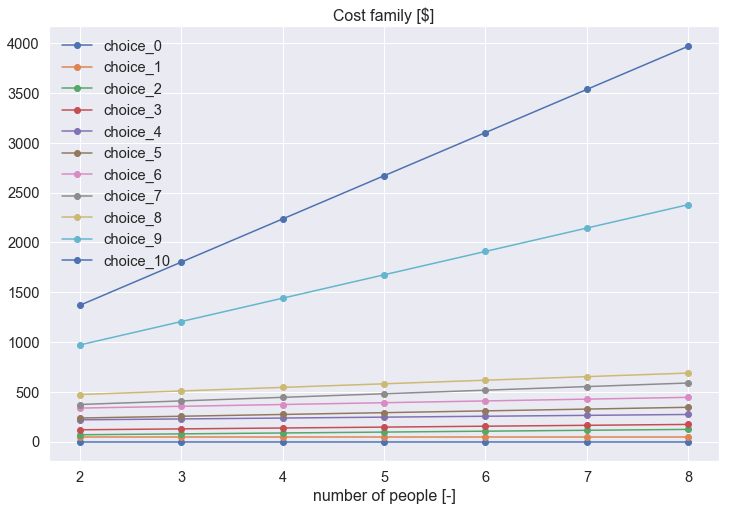

In [47]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

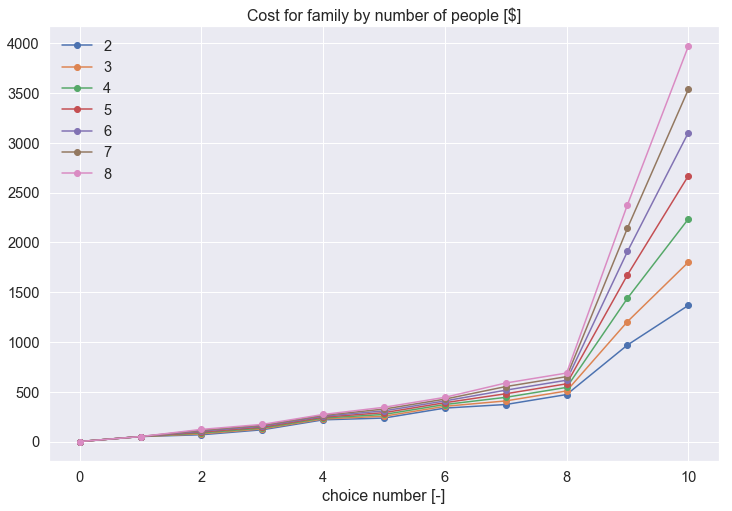

In [48]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [346]:
def create_df_fam_cost_prob(df_fam_cost, p_min=0.03, p_max=0.1, ):
    # For genetic algo, for start population or mutation,
    # try to assign probabilities of choice for each possibilities : 
    # from  choice 0 to 10.
    df_prob = df_fam_cost.filter(items=list_choice)
    vect_penalty = [0, np.max(np.max(df_prob))]
    print("vect_penalty: ", vect_penalty)
    vect_prob = [p_max, p_min]
    print("vect_prob", vect_prob)
    # family : number of people
    df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
    for indice in df_prob.index:
        df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

    return df_prob  


#### p max = 0.1, p min = 0.03

In [336]:
df_prob = create_df_fam_cost_prob(df_fam_cost)
df_prob

vect_penalty:  [0, 3972]
vect_prob [0.1, 0.03]


choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2  0.097481  0.096622  0.096313  0.095454  0.093736  0.093427  0.091709   
3  0.098846  0.097975  0.097505  0.096634  0.094892  0.094422  0.092680   
4  0.100250  0.099367  0.098731  0.097848  0.096081  0.095445  0.093678   
5  0.101695  0.100799  0.099992  0.099096  0.097304  0.096498  0.094705   
6  0.103182  0.102272  0.101291  0.100381  0.098563  0.097581  0.095763   
7  0.104713  0.103790  0.102627  0.101705  0.099859  0.098697  0.096851   
8  0.106290  0.105353  0.104004  0.103068  0.101195  0.099846  0.097973   

   choice_7  choice_8  choice_9  choice_10  
2  0.091090  0.089372  0.080817   0.073980  
3  0.091739  0.089997  0.077855   0.067455  
4  0.092406  0.090639  0.074809   0.060746  
5  0.093092  0.091300  0.071675   0.053843  
6  0.093799  0.091980  0.068450   0.046738  
7  0.094526  0.092681  0.065129   0.039423  
8  0.095275  0.093402  0.061708   0.031887

#### p max = 0.5, p min = 0.01

In [347]:
df_prob_2 = create_df_fam_cost_prob(df_fam_cost, p_min=0.01, p_max=1)
df_prob_2

vect_penalty:  [0, 3972]
vect_prob [1, 0.01]


choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2  0.100491  0.099238  0.098787  0.097535  0.095030  0.094580  0.092075   
3  0.102556  0.101278  0.100588  0.099310  0.096753  0.096063  0.093507   
4  0.104708  0.103403  0.102463  0.101158  0.098549  0.097609  0.094999   
5  0.106952  0.105619  0.104419  0.103087  0.100421  0.099221  0.096556   
6  0.109294  0.107932  0.106461  0.105099  0.102375  0.100904  0.098180   
7  0.111742  0.110349  0.108594  0.107202  0.104417  0.102662  0.099877   
8  0.114301  0.112877  0.110825  0.109401  0.106552  0.104501  0.101652   

   choice_7  choice_8  choice_9  choice_10  
2  0.091173  0.088669  0.076195   0.066227  
3  0.092127  0.089571  0.071754   0.056494  
4  0.093120  0.090511  0.067127   0.046353  
5  0.094156  0.091491  0.062301   0.035777  
6  0.095238  0.092514  0.057264   0.024738  
7  0.096368  0.093583  0.052001   0.013205  
8  0.097550  0.094701  0.046497   0.001143

In [364]:

# save
joblib.dump(df_prob_2, PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

['../../data/df_prob_2.pkl']

## Creation of days probabilities by family

In [348]:
def create_df_prob_day_fam(df_prob_day, df_prob):
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
    for fam_id in df_prob_fam.index:
        # give at first to each families the same day probabilities
        df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        # and add prob for each day choosen by families
        for choice in list_choice_all: 
            prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
            day_curr = data.at[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            df_prob_fam.loc[fam_id, day_curr] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        df_prob_fam.loc[fam_id] = \
            df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    return df_prob_fam

In [359]:
df_prob_fam = create_df_prob_day_fam(df_prob_day, df_prob_2)
# save
joblib.dump(df_prob_fam, PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')

['../../data/df_prob_fam_2.pkl']

In [358]:

'''df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
for fam_id in df_prob_fam.index:
    # give at first to each families the same day probabilities
    df_prob_fam.loc[fam_id] = df_prob_day["prob"]
    # and add prob for each day choosen by families
    for choice in list_choice_all: 
        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
        day_curr = data.at[fam_id, choice]
        # add this prob of these days to family into df_prob_fam
        df_prob_fam.loc[fam_id, day_curr] += prob_curr
        #print(day_curr)
        #print(prob_curr)
    df_prob_fam.loc[fam_id] = \
        df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    
     
    
df_prob_fam'''

'df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)\nfor fam_id in df_prob_fam.index:\n    # give at first to each families the same day probabilities\n    df_prob_fam.loc[fam_id] = df_prob_day["prob"]\n    # and add prob for each day choosen by families\n    for choice in list_choice_all: \n        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]\n        day_curr = data.at[fam_id, choice]\n        # add this prob of these days to family into df_prob_fam\n        df_prob_fam.loc[fam_id, day_curr] += prob_curr\n        #print(day_curr)\n        #print(prob_curr)\n    df_prob_fam.loc[fam_id] =         df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()\n    \n     \n    \ndf_prob_fam'

In [413]:
# save
joblib.dump(df_prob_fam, PATH_SAVE_PROB_FAM)

['../../data//df_prob_fam.pkl']

In [322]:
df_prob_fam.loc[0].plot()

NameError: name 'df_prob_fam' is not defined

## From Scratch

### Generate first population

In [381]:

np.random.choice(np.array(range(0, df_prob.shape[1])), size=1, 
                 p=df_prob.loc[2].values)

array([6])

In [165]:
data.loc[indice,"n_people"]

4

In [265]:
# df_choice : contains number choices of all the population of 5000 families
df_choice = pd.DataFrame()

# for each family, create n choice among their first choice
for indice in data.index:
    vect_pop = np.random.choice(np.array(range(0, df_prob.shape[1])), 
                            size=NB_FIRST_POP, 
                            p=df_prob.loc[data.loc[indice,"n_people"]].values)
    df_choice[indice] = vect_pop
df_choice.shape

(1000, 5000)

In [266]:
df_choice.head()

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     3     3     5     8     3     9     4     1     2     6  ...      0   
1     7     3     0     6     0     9     9     4     8     7  ...      2   
2     1     4     1    10     4     1     5     7     5     5  ...      0   
3     4     9     6     0     6     6     2     5     5     1  ...      7   
4     8     7     7     5     3     4     5     2     8     3  ...      5   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0     4     7     2     0     9     1     1     8     6  
1     3     3     3     5     1     1     9     2     3  
2     4     6     6     7     0     8     4     8     5  
3     7     8     4     2     6    10     2     2     4  
4     8     8     0     6     7     1     1     8    10  

[5 rows x 5000 columns]

### Treatment of choices

In [301]:
# for choice number 10, choose a day among all days except choices 0 to 9 : 
# probability is choosen uniform

def choose_day(choice_curr, fam_id):
    if choice_curr == 10:
        vect_choices = list(range(1, 101))
        for indice in range(0, 10):
            vect_choices.remove(data.loc[fam_id, "choice_{}".format(indice)])    
        #print(vect_choices)
        return np.random.choice(vect_choices, size=1)[0]
    else:
        return data.at[fam_id, "choice_{}".format(choice_curr)]


In [268]:
df_pop = df_choice.copy()
for fam_id in df_pop.columns:
    df_pop[fam_id] = df_pop[fam_id].apply(choose_day, args=(fam_id,))
    
df_pop

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0      82     5    82     9    93     2    91    11     1    96  ...     47   
1      76     5   100    40    53     2    99    10    53    47  ...     74   
2      38    11    54    54    26    59    32    50    33    18  ...     47   
3      33    61    10     2    46    35     1    17    33    88  ...     94   
4      10     6    89     6    93    60    32    52    53    50  ...     46   
5      52     5    27    96    39    26    57    88     1    39  ...      5   
6      38    40    27    59     1    32    99    11     1    28  ...     61   
7      33    97    25    93     3    59    88    17    33    96  ...     74   
8      75    11    80     6    46    78     4    88    18    39  ...      4   
9      52    11    25    32    93    12    57    48    12    18  ...     32   
10     82    11    10     2     1    50    99    66    89    39  ...     80   
11     12     4    27    95    84    60    99    17     1    88  ...     12   
12     38    49    80    31    26     2    91    17    10    18  ...     19   
13     82    55    33    95     1    12    91    66    16    18  ...     46   
14     12     4    89     9    53    60    91    17    12    28  ...      4   
15     38    26    82     9    90    32     1    10    39     1  ...     19   
16     12    82    82    40    47     2     3    66    60    28  ...     19   
17     12    26   100    31     3    60     4    25     1    46  ...      4   
18     10    66    10    59    53    60    99    50    33     1  ...     74   
19     28    66     9    59    26     2    39    10    10    26  ...     80   
20     64    66    54     9    39    26    28    10    10    46  ...     80   
21     76    38    80    31    46     5    88    11    89    18  ...     74   
22     82    66    33    40    93     2     3    17    16    39  ...     61   
23     33     4    29     2    90    32    57    32    10    28  ...     47   
24     12    47    10     9     3    12     3    88    18    26  ...     33   
25     76    29    25     9    53    59     3    10    33    88  ...     32   
26     52    61    33     6    47    26    91    88    60    47  ...     12   
27     64     4    33    40     1    26    26    50    67    39  ...     12   
28     76    47    82    31    53     2    39    11     1    19  ...     32   
29     76     4    80     2    39    60     1    50    16    88  ...     94   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
970    12    38    10    32     1    32     1    88    33    18  ...     80   
971    10    11    66    95    93    50    32    25    18    39  ...     12   
972    12    38    82     2    39    59    99    11    33    28  ...     47   
973    12    47    33    31    39    26    99    66    12    39  ...     80   
974    39    26    27     2     3     3    28    20    60    26  ...      4   
975    10     6    25    96     1    18    39    95    33    18  ...     32   
976    28    47    80    25    16    35     4    25    89    96  ...     19   
977    75    11    25    31    26    50    39    10    12    39  ...     74   
978    10    82    82    40    26     3     3    52    33    73  ...     32   
979    28     5    25    59    39     5     4    66    60    46  ...     47   
980    12    66   100    32    46    60     1    11    12    47  ...     80   
981    28    26    27    31    93    35     3    10    18    26  ...     47   
982    33    61   100     4    93    26    88    88    33    88  ...     80   
983    33     6    27     6     3    35    39    95    53    28  ...     47   
984    10    61    54    31    16    12    28    25    33    39  ...     19   
985    75    66   100    44    26     5    57    50    18    28  ...     47   
986    10     4    10     2     3    32     4    50    12    96  ...     46   
987    52     6    33    59    39    60    39    10     1    88  ...     32   
988    38    82    12    59    93    35    28    11    

### Evaluation of cost for all population

In [262]:
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
0    4.405331e+62
1    8.627548e+56
2    1.346244e+59
3    5.624646e+61
4    7.746507e+61
5    2.343082e+51
6    4.598295e+66
7    7.982710e+56
8    1.347359e+57
9    1.105799e+60
10   3.893130e+59
11   3.936574e+58
12   1.621637e+63
13   8.510317e+52
14   5.895593e+59
15   3.340682e+55
16   1.358198e+57
17   1.079468e+64
18   5.832608e+60
19   4.579328e+60
20   7.319800e+50
21   5.446452e+56
22   2.165810e+54
23   9.561077e+62
24   8.721047e+45
25   2.068069e+60
26   2.355648e+53
27   1.844667e+70
28   7.279254e+61
29   2.525690e+60
..            ...
970  2.353798e+53
971  1.748307e+63
972  6.841872e+70
973  1.497576e+52
974  4.638929e+67
975  1.978431e+53
976  1.781199e+60
977  1.518226e+59
978  1.235310e+60
979  4.351479e+56
980  1.345891e+54
981  2.343632e+57
982  2.683243e+62
983  6.366676e+52
984  3.907275e+53
985  5.390364e+70
986  1.374826e+58
987  1.280499e+55
988  8.832879e+63
989  8.525397e+64
990  5.807663e+56
991  1.103143e+55
992  7.475599e+53
993  9.080145e+57
994  7.006668e+57
995  4.932254e+65
996  5.323330e+49
997  2.865219e+55
998  3.724813e+63
999  1.000177e+55

[1000 rows x 1 columns]

In [269]:
best = submission['assigned_day'].tolist()
len(best)

5000

In [335]:
cost_function(best)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

## From baseline #0

In [173]:
# reload 
submission = pd.read_csv('submission_672254.0276683343.csv')

In [558]:
# reload
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)

### Generate first population

Generation of 1000 "families choices" ensemble from baseline : 
- Number of individuals for first generation : NB_FIRST_POP
- Ratio of generation/mutation for first generation : R_FIRST_MUT
- delta around day choosen  : +/- DELTA_DAYS

Try to find fine tune these hyperparameters (I don't have method ! )

In [384]:
#submission = pd.read_csv('submission_672254.0276683343.csv')

In [654]:
# check baseline
cost_function(submission['assigned_day'])

10641498.403135022

In [81]:


find_day_range(50)

range(49, 52)

In [17]:
fam_id = 0
submission.at[fam_id, 'assigned_day']

52

In [ ]:
df_pop = generate_pop()
print("df_pop.shape: ", df_pop.shape)
df_pop.head()

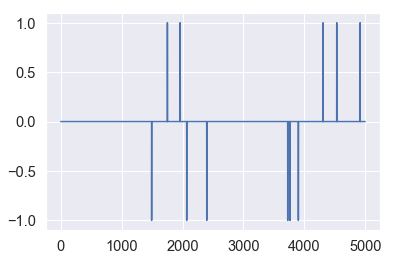

In [571]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

A effacer : 

In [83]:
# GENERATION OF FIRST POP:

# initialize with same previous best indiv.
df_pop = pd.DataFrame(index=range(0, NB_FIRST_POP), 
                      columns=submission["family_id"])

for fam_id in submission["family_id"]:
    df_pop[fam_id] = submission.at[fam_id,'assigned_day']

# create NB_FIRST_POP family choices from baseline :
# use probabilies
# df_pop : contains number choices of all the population of 5000 families
# df_pop = f(indiv., family)
# for each family, create n choice among their first choice
# use day probabilities specific for each family
for fam_id in data.index: # data = f(family, num choice)
    # day current is the old best submission day for this family
    day_curr = submission.at[fam_id, 'assigned_day']
    # find range around day curr +/- DELTA
    range_curr = find_day_range(day_curr)
    # retrict probabilities to range # df_prob_fam = f(fam_id, day)
    day_prob = df_prob_fam.astype("float").loc[fam_id,range_curr]/df_prob_fam.\
        loc[fam_id,range_curr].sum()
    # choose randomly with probabilities days around old best day
    vect_pop = np.random.choice(np.array(range_curr), 
                            size=NB_FIRST_POP, 
                            p=np.array(day_prob))
    
    # apply the new days only a part of pop : R_FIRST_MUT [-]
    range_mut = np.random.choice(range(0, NB_FIRST_POP), 
                                 size=int(R_FIRST_MUT*NB_FIRST_POP))
    
    #df_pop[fam_id] = submission['assigned_day']
    
    df_pop.loc[range_mut, fam_id] = vect_pop[range_mut]

# keep the best : 
df_pop.loc[0] = submission['assigned_day']

print("df_pop.shape: ", df_pop.shape)
df_pop.head()

df_pop.shape:  (1000, 5000)


family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     1  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32    67    13  

[5 rows x 5000 columns]

### Save pop

In [84]:
# save
joblib.dump(df_pop, PATH_SAVE_DF_POP)

['../../data//df_pop.pkl']

### Evaluation #1

In [570]:
# load 
df_pop = joblib.load(PATH_SAVE_DF_POP)

In [544]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
0    672254.027668
21   673249.435665
632  675341.022931
587  675579.598524
904  675800.361230
552  676043.157413
148  676060.161931
215  676639.495767
599  676960.819718
550  677205.766828

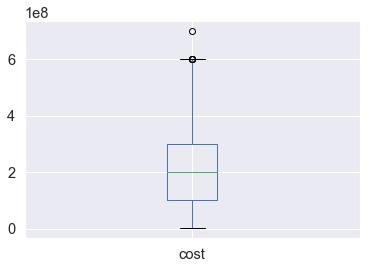

In [545]:
df_cost.boxplot()

### Loop over generations

In [546]:
# load 
#df_pop = joblib.load(PATH_SAVE_DF_POP)
#df_pop.shape

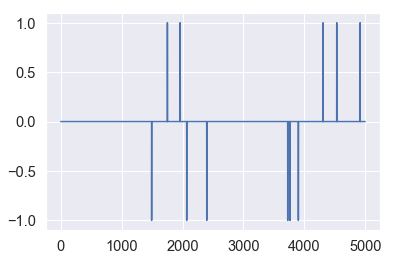

In [547]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

 
GENERATION #0 / nb. pop: 1000
nb_survivor:  990
              cost
990  672254.027668
991  673249.435665
21   675086.477112
238  675663.626834
743  675797.897188
Timing epoch:  13.22744607925415
 
GENERATION #1 / nb. pop: 992
nb_survivor:  982
              cost
982  672254.027668
983  673249.435665
302  675468.568847
303  675777.101886
561  676477.414141
Timing epoch:  13.66027307510376
 
GENERATION #2 / nb. pop: 984
nb_survivor:  974
              cost
0    672254.027668
974  672254.027668
975  673249.435665
805  674974.609299
845  675310.694047
Timing epoch:  12.444685935974121


Text(0, 0.5, 'cost [$]')

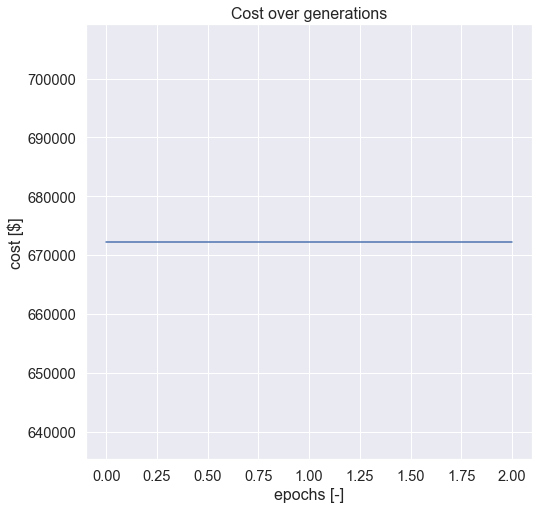

In [548]:
nb_seeds = 2 # number of seed sources : keep them along epochs
# LOOP OVER GENERATIONS 
list_best_cost = []
for gen_id in range(0, NB_MAX_EPOCHS):
    t_fit_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]
    # LOST WORST INDIV.

    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - nb_seeds)
    if (nb_survivor+nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))
    
    # check if previous best is still here
    #if name_best not in vect_survivor:
        # else replace by previous best
        #vect_survivor[0] = name_best

    df_pop = df_pop.loc[vect_survivor] 
    #df_pop_surv=df_pop.copy()

    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace first indiv
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)
    #df_pop_cross=df_pop.copy()

    # MUTATION
    # mutation of R_MUT * number of indiv 
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best 
    df_pop = df_pop.append(df_best, ignore_index=True)

    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 

    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(nb_seeds+3))
    
    t_fit_1 = time.time()
    print("Timing epoch: ", t_fit_1 - t_fit_0)
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

cost rankings:
[672254.0276683343, 673249.4356646903, 674728.7104080453, 675890.9699308008, 675979.8116211004]


In [518]:
list_name_best

[983, 314]

In [519]:
df_pop.loc[list_name_best]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


family_id  0     1      2     3     4     5     6     7     8     9     ...   \
983         NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
314        52.0  26.0  100.0   2.0  53.0  59.0  88.0  25.0  18.0   1.0  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
983         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
314        61.0  29.0  90.0  62.0  52.0  16.0  88.0  32.0  67.0  13.0  

[2 rows x 5000 columns]

In [510]:

np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), vect_survivor))

array([990, 803, 867, 174, 379, 990, 193, 507, 142, 785, 631, 533, 422,
       203, 580, 977, 387,  20, 393, 612, 803, 505, 811, 359,  46, 461,
       944, 169, 775, 897, 467, 648, 976, 376, 518, 114, 741, 108, 181,
       768, 745, 330, 750, 705,  25, 163, 406, 736, 924,   5, 761,  40,
       430, 723, 876,  52, 879, 102, 820, 899, 516, 374, 337, 249, 302,
       559, 950, 759, 217, 920, 546, 550, 482,  35,  66, 277, 686, 492,
       601, 248, 267, 195, 522, 791,   1, 228, 534, 287, 969, 242, 814,
       988, 746, 835, 531, 166, 312, 110, 839,  50, 951,  80, 925, 341,
       189, 140, 433, 513, 933, 152, 680, 959, 927,  94, 921, 500, 470,
       582,  18, 887, 480, 639, 429,  79, 399, 397, 269,  51, 216, 424,
       415, 188, 731, 451, 810, 818, 272, 136, 663, 562, 457, 443,  15,
       673, 545, 871, 548, 788, 782, 172, 633, 848,  92, 535, 958, 437,
       726, 836, 564, 787, 598, 986, 698,  83,  95, 843, 261, 150, 450,
         7, 180, 348, 754, 692, 834, 520, 645, 144, 230, 640, 22

In [492]:
df_cost_sort.shape

(991, 3)

In [499]:
df_cost_sort.iloc[0:2,2] = 0

In [500]:
df_cost_sort

cost  rank      prob
990  6.722540e+05     1  0.000000
803  6.740412e+05     2  0.000000
723  6.743262e+05     3  0.044585
976  6.752261e+05     4  0.033438
5    6.753410e+05     5  0.026751
871  6.757341e+05     6  0.022292
25   6.760432e+05     7  0.019108
768  6.766036e+05     8  0.016719
169  6.766395e+05     9  0.014862
46   6.769514e+05    10  0.013375
461  6.770891e+05    11  0.012159
20   6.776100e+05    12  0.011146
920  6.779448e+05    13  0.010289
397  6.782558e+05    14  0.009554
761  6.782579e+05    15  0.008917
470  6.782830e+05    16  0.008360
376  6.783910e+05    17  0.007868
522  6.783969e+05    18  0.007431
580  6.786026e+05    19  0.007040
114  6.787559e+05    20  0.006688
40   6.792164e+05    21  0.006369
925  6.794635e+05    22  0.006080
242  6.795082e+05    23  0.005815
759  6.797625e+05    24  0.005573
141  6.800638e+05    25  0.005350
516  6.801533e+05    26  0.005144
142  6.804211e+05    27  0.004954
550  6.806977e+05    28  0.004777
387  6.807988e+05    29  0.004612
986  6.809628e+05    30  0.004458
..            ...   ...       ...
914  5.007527e+08   962  0.000139
256  5.007535e+08   963  0.000139
949  5.007557e+08   964  0.000139
781  5.007564e+08   965  0.000139
207  5.007603e+08   966  0.000138
629  5.007668e+08   967  0.000138
335  5.007700e+08   968  0.000138
24   5.007761e+08   969  0.000138
816  6.006767e+08   970  0.000138
953  6.006855e+08   971  0.000138
904  6.006864e+08   972  0.000138
638  6.006886e+08   973  0.000137
143  6.006930e+08   974  0.000137
872  6.006934e+08   975  0.000137
933  6.006985e+08   976  0.000137
873  6.006998e+08   977  0.000137
830  6.007444e+08   978  0.000137
84   6.007514e+08   979  0.000137
547  6.007529e+08   980  0.000136
259  6.007560e+08   981  0.000136
586  6.007606e+08   982  0.000136
911  6.007691e+08   983  0.000136
235  6.008261e+08   984  0.000136
795  7.006870e+08   985  0.000136
491  7.007442e+08   986  0.000136
678  7.007611e+08   987  0.000136
201  7.007786e+08   988  0.000135
910  8.007432e+08   989  0.000135
942  8.007518e+08   990  0.000135
436  1.000755e+09   991  0.000135

[991 rows x 3 columns]

In [480]:
df_cost_sort.shape

(991, 3)

In [477]:
list_best_indiv[1]

family_id
0        52
1        26
2       100
3         2
4        53
5        59
6        88
7        25
8        18
9         1
10       92
11       19
12       52
13       54
14       45
15       22
16       46
17       47
18       75
19        3
20        3
21       56
22       33
23       19
24       75
25       16
26       58
27       38
28       27
29       89
       ... 
4970     22
4971      8
4972      8
4973      5
4974     15
4975     83
4976     39
4977     54
4978     40
4979     55
4980     28
4981     44
4982     47
4983     16
4984     41
4985     25
4986     82
4987     22
4988     88
4989     92
4990     61
4991     29
4992     90
4993     62
4994     52
4995     16
4996     88
4997     32
4998     67
4999     13
Name: 803, Length: 5000, dtype: int64

In [451]:
df_cost_sort.head()

cost  rank      prob
198  6.696340e+05     1  0.170270
77   3.010847e+08     2  0.085135
19   4.009763e+08     3  0.056757
64   4.012742e+08     4  0.042567
52   5.007436e+08     5  0.034054

In [296]:
cost_function(df_pop.loc[0].tolist())

672254.0276683343

In [308]:
cost_function(best_indiv)

669634.0092723282

In [304]:
vect_best_choice=[]
for fam_id in df_pop.columns:
    vect_best_choice.append(choose_day(0,fam_id))

In [307]:
len(vect_best_choice)

5000

In [309]:
cost_function(vect_best_choice)

1.0647073818721987e+90

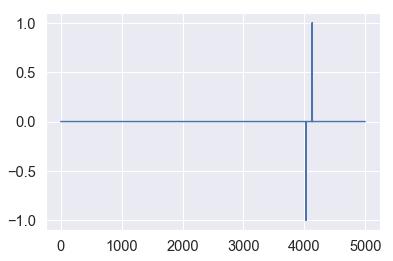

In [298]:
plt.plot(df_pop.columns, df_pop.loc[0] - best_indiv)
   

283


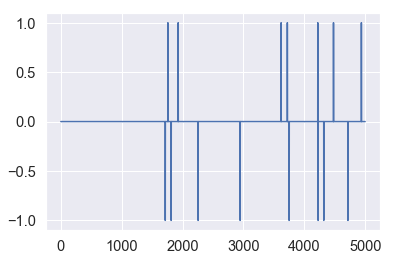

In [229]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop_surv.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])
   

283


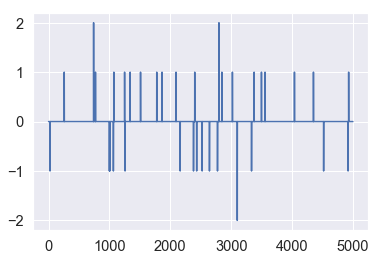

In [230]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])

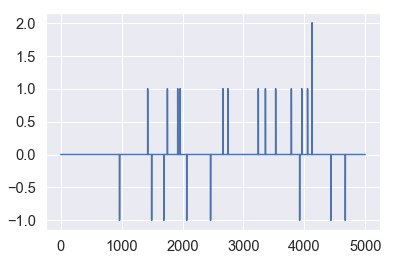

In [217]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

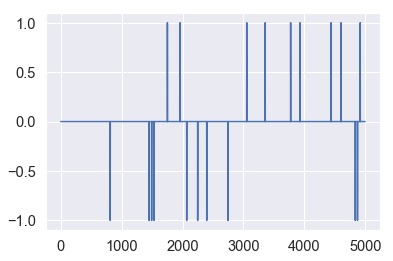

In [191]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

## From multiple baselines

### Find several baseline / seed source

#### Create ranges

In [52]:
submission = pd.read_csv(fpath, index_col='family_id')

In [53]:
submission.shape[0]

5000

In [54]:
NB_FIRST_SEED = 10
df_range = pd.DataFrame(index=range(0, NB_FIRST_SEED), 
                        columns=range(0, submission.shape[0]))

df_range.loc[0] = np.array(range(0, submission.shape[0]))

df_range.loc[1] = np.array(range(submission.index.max(), 
                                 submission.index.min()-1, -1))  

#for indice in range(2, NB_FIRST_SEED):
    

In [55]:
start_pt = np.linspace(0, submission.shape[0], 
                       num=int((NB_FIRST_SEED)/2)+1, dtype="int")
start_pt = start_pt[1:-1]
start_pt

array([1000, 2000, 3000, 4000])

In [56]:
np.array(range(10,0,-1))

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [57]:
indice = 2
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = np.concatenate((np.array(range(start_pt[st_id], 
                                                submission.shape[0])), 
               np.array(range(0, start_pt[st_id]))))

indice = 6
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = \
        np.concatenate((range(start_pt[st_id], 0-1, -1), 
                range(submission.shape[0]-1, start_pt[st_id], -1)))

df_range    

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     0     1     2     3     4     5     6     7     8     9  ...   4990   
1  4999  4998  4997  4996  4995  4994  4993  4992  4991  4990  ...      9   
2  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...    990   
3  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...   1990   
4  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  ...   2990   
5  4000  4001  4002  4003  4004  4005  4006  4007  4008  4009  ...   3990   
6  1000   999   998   997   996   995   994   993   992   991  ...   1010   
7  2000  1999  1998  1997  1996  1995  1994  1993  1992  1991  ...   2010   
8  3000  2999  2998  2997  2996  2995  2994  2993  2992  2991  ...   3010   
9  4000  3999  3998  3997  3996  3995  3994  3993  3992  3991  ...   4010   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0  4991  4992  4993  4994  4995  4996  4997  4998  4999  
1     8     7     6     5     4     3     2     1     0  
2   991   992   993   994   995   996   997   998   999  
3  1991  1992  1993  1994  1995  1996  1997  1998  1999  
4  2991  2992  2993  2994  2995  2996  2997  2998  2999  
5  3991  3992  3993  3994  3995  3996  3997  3998  3999  
6  1009  1008  1007  1006  1005  1004  1003  1002  1001  
7  2009  2008  2007  2006  2005  2004  2003  2002  2001  
8  3009  3008  3007  3006  3005  3004  3003  3002  3001  
9  4009  4008  4007  4006  4005  4004  4003  4002  4001  

[10 rows x 5000 columns]

In [24]:
df_range.min().min()

0

In [25]:
df_range.max().max()

4999

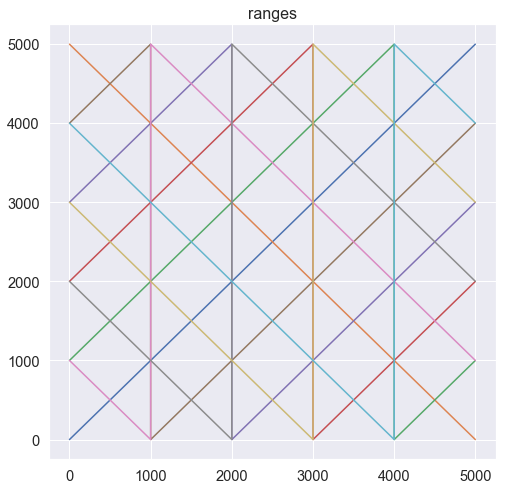

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.title("ranges")
for indice in range(0, df_range.shape[0]):
    plt.plot(df_range.loc[indice])


#### Evaluate baselines & save

In [449]:
t_fit_0 = time.time()
submission = pd.read_csv(fpath, index_col='family_id')
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)

for indice in df_range.index:
    # initiate first inviduate 
    new = best.copy()
    cost_best = start_cost
    # choose current range in df_range
    range_optim = df_range.loc[indice]
    # loop over each family with this current range
    for fam_id in range_optim:
        # loop over each family choice
        for pick in range(10):
            day = choice_dict[f'choice_{pick}'][fam_id]
            temp = new.copy()
            temp[fam_id] = day # add in the new pick
            cost_curr = cost_function(temp) # test cost
            if cost_curr < cost_best:
                new = temp.copy()
                cost_best = cost_curr
                #print("Current best cost: ", cost_best)

    submission['assigned_day'] = new
    score = cost_function(new)
    submission.to_csv(f'submission_range{indice}.csv')
    print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022
Score: 657505.9426095837
Score: 677348.7683962411
Score: 605419.8337085167
Score: 656228.7546566363
Timing:  1473.9507336616516


### Generate first population

#### Method 1:  Day by days

In [27]:
df_range

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     0     1     2     3     4     5     6     7     8     9  ...   4990   
1  4999  4998  4997  4996  4995  4994  4993  4992  4991  4990  ...      9   
2  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...    990   
3  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...   1990   
4  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  ...   2990   
5  4000  4001  4002  4003  4004  4005  4006  4007  4008  4009  ...   3990   
6  1000   999   998   997   996   995   994   993   992   991  ...   1010   
7  2000  1999  1998  1997  1996  1995  1994  1993  1992  1991  ...   2010   
8  3000  2999  2998  2997  2996  2995  2994  2993  2992  2991  ...   3010   
9  4000  3999  3998  3997  3996  3995  3994  3993  3992  3991  ...   4010   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0  4991  4992  4993  4994  4995  4996  4997  4998  4999  
1     8     7     6     5     4     3     2     1     0  
2   991   992   993   994   995   996   997   998   999  
3  1991  1992  1993  1994  1995  1996  1997  1998  1999  
4  2991  2992  2993  2994  2995  2996  2997  2998  2999  
5  3991  3992  3993  3994  3995  3996  3997  3998  3999  
6  1009  1008  1007  1006  1005  1004  1003  1002  1001  
7  2009  2008  2007  2006  2005  2004  2003  2002  2001  
8  3009  3008  3007  3006  3005  3004  3003  3002  3001  
9  4009  4008  4007  4006  4005  4004  4003  4002  4001  

[10 rows x 5000 columns]

In [88]:
# HYPERPARAMETERS
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop(seed_indiv=seed_indiv, nb_pop=nb_indiv_curr, 
                               r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  91.89893078804016
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  84.70671820640564
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  85.22644996643066
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  694.5717761516571
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  111.29203581809998
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  82.3056640625
# 6 / nb_indiv_curr: 100 / done: 700.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation populati

family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     2  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32    67    13  

[5 rows x 5000 columns]

#### Save pop

In [141]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS),
           compress=True)

['../../data/df_pop1000_fs10_rfm0.01_dd3.pkl']

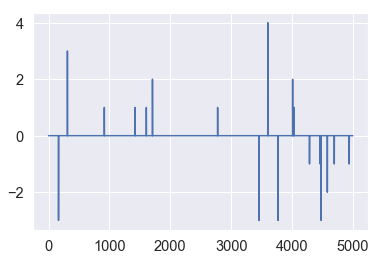

In [90]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [91]:
df_pop.describe()

family_id         0            1            2            3            4     \
count      1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean         56.001000    52.999000    99.998000    30.492000    52.994000   
std          22.875102    38.102583     0.063246    43.550713     0.141365   
min          38.000000     4.000000    98.000000     1.000000    50.000000   
25%          38.000000    26.000000   100.000000     2.000000    53.000000   
50%          52.000000    26.000000   100.000000     2.000000    53.000000   
75%          52.000000    99.000000   100.000000    97.000000    53.000000   
max         100.000000   100.000000   100.000000    97.000000    54.000000   

family_id         5            6            7            8            9     \
count      1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean         42.814000    71.211000    59.097000    22.196000    52.184000   
std          13.234748    33.633133    29.094434    12.608273    30.926471   
min          29.000000     1.000000    22.000000    16.000000     1.000000   
25%          32.000000    88.000000    25.000000    18.000000    50.000000   
50%          32.000000    88.000000    48.000000    18.000000    50.000000   
75%          59.000000    88.000000    93.000000    18.000000    88.000000   
max          62.000000    91.000000    95.000000    60.000000    91.000000   

family_id     ...             4990         4991        4992         4993  \
count         ...      1000.000000  1000.000000  1000.00000  1000.000000   
mean          ...        56.706000    43.411000    27.59700    62.003000   
std           ...         8.773742     4.811989    31.21979     0.170353   
min           ...        47.000000    28.000000     9.00000    60.000000   
25%           ...        47.000000    45.000000    12.00000    62.000000   
50%           ...        61.000000    45.000000    12.00000    62.000000   
75%           ...        61.000000    45.000000    12.00000    62.000000   
max           ...        77.000000    47.000000    91.00000    65.000000   

family_id         4994         4995         4996        4997         4998  \
count      1000.000000  1000.000000  1000.000000  1000.00000  1000.000000   
mean         53.405000    16.010000    67.609000    38.80100    79.506000   
std           2.797642     0.141138    31.183369    13.60016    12.502811   
min          51.000000    16.000000    20.000000    29.00000    67.000000   
25%          52.000000    16.000000    20.000000    32.00000    67.000000   
50%          52.000000    16.000000    88.000000    32.00000    81.000000   
75%          52.000000    16.000000    88.000000    32.00000    92.000000   
max          59.000000    18.000000    91.000000    66.00000    93.000000   

family_id        4999  
count      1000.00000  
mean         14.19500  
std           3.60527  
min          11.00000  
25%          13.00000  
50%          13.00000  
75%          13.00000  
max          25.00000  

[8 rows x 5000 columns]

#### Method 2:  Choice by Choices

In [432]:
def generate_pop_choices(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        
        vect_pop_mutated = mutation_day(day_curr, fam_id, nb_mut=nb_pop, 
                                        flag_prob=True)
        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

In [433]:
# HYPERPARAMETERS
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

#df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')

df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop_choices(seed_indiv=seed_indiv, 
                                       nb_pop=nb_indiv_curr, 
                                       r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  53.41584396362305
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  42.22392964363098
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  44.29747796058655
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  42.89790415763855
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  45.88465929031372
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  47.983644247055054
# 6 / nb_indiv_curr: 100 / done: 700.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation popu

family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     1  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32     4    13  

[5 rows x 5000 columns]

#### Save pop

In [435]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE),
           compress=True)

['../../data/df_pop_choices1000_fs10_rfm0.01_dc1.pkl']

## Run with pop by choices

### Evaluation #1

In [80]:
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_2.pkl')
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))

In [81]:
NB_FIRST_SEED = 10
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE))

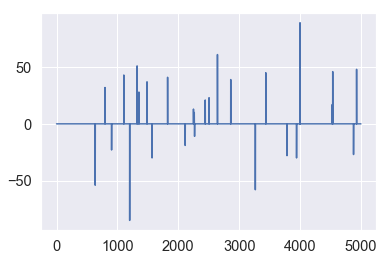

In [82]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [83]:
# create cost dataFrame for all population
t_1 = time.time()
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function_optim(df_pop.loc[indice].values)
print(time.time()-t_1)

df_cost.sort_values(by="cost").head(10)


1.329289197921753


cost
800  605419.833709
400  654844.718387
900  656228.754657
600  657505.942610
0    672254.027668
700  677348.768396
300  679410.167648
200  684479.327148
500  686524.150792
342  689530.226809

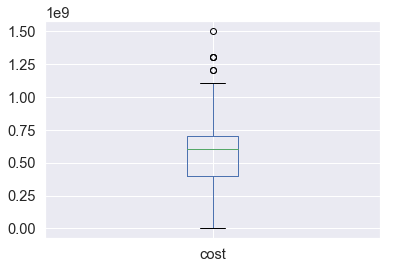

In [84]:
df_cost.boxplot()

###  Loop over generations

GEN. #0 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.6758670806884766
GEN. #1 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.6738100051879883
GEN. #2 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.5479400157928467
GEN. #3 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.5626299381256104
GEN. #4 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.8992099761962891
GEN. #5 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.653843879699707
GEN. #6 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.6276810169219971
GEN. #7 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.7538797855377197
GEN. #8 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.8976848125457764
GEN. #9 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.6052310466766357
GEN. #10 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.5820760726928711
GEN. #11 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.6367082595825195
GEN. #12 / cost: [436934.95026968] / nb. pop: 100 / timing: 0.6

GEN. #104 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.5005781650543213
GEN. #105 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.46050095558166504
GEN. #106 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.4821150302886963
GEN. #107 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.5018680095672607
GEN. #108 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.46512699127197266
GEN. #109 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.4779808521270752
GEN. #110 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.47613000869750977
GEN. #111 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.44788122177124023
GEN. #112 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.4613339900970459
GEN. #113 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.4832291603088379
GEN. #114 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.49121689796447754
GEN. #115 / cost: [436891.06982527] / nb. pop: 100 / timing: 0.45506787300109863
GEN. #116 / cost: [436891.06982527

GEN. #207 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.4610300064086914
GEN. #208 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.4625527858734131
GEN. #209 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.46541404724121094
GEN. #210 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.4688098430633545
GEN. #211 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.48969483375549316
GEN. #212 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.5049171447753906
GEN. #213 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.4914860725402832
GEN. #214 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.45833611488342285
GEN. #215 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.5044488906860352
GEN. #216 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.4737701416015625
GEN. #217 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.4720768928527832
GEN. #218 / cost: [436752.4227084] / nb. pop: 100 / timing: 0.4818580150604248
GEN. #219 / cost: [436752.4227084] / nb. pop: 100

GEN. #310 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.47136521339416504
GEN. #311 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.4687161445617676
GEN. #312 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.45169830322265625
GEN. #313 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.4551723003387451
GEN. #314 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.4612448215484619
GEN. #315 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.4602630138397217
GEN. #316 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.45090413093566895
GEN. #317 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.44969964027404785
GEN. #318 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.47308993339538574
GEN. #319 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.47512292861938477
GEN. #320 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.47606921195983887
GEN. #321 / cost: [434412.92710058] / nb. pop: 100 / timing: 0.4906280040740967
GEN. #322 / cost: [434412.9271005

GEN. #413 / cost: [434178.09237523] / nb. pop: 100 / timing: 0.45525217056274414
GEN. #414 / cost: [434178.09237523] / nb. pop: 100 / timing: 0.4648749828338623
GEN. #415 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.47459888458251953
GEN. #416 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.45784687995910645
GEN. #417 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.45903825759887695
GEN. #418 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.47975778579711914
GEN. #419 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.4562528133392334
GEN. #420 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.4596409797668457
GEN. #421 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.47193431854248047
GEN. #422 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.45879697799682617
GEN. #423 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.44622206687927246
GEN. #424 / cost: [434031.78330491] / nb. pop: 100 / timing: 0.46184420585632324
GEN. #425 / cost: [434031.78330

GEN. #515 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.4696676731109619
GEN. #516 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.4891939163208008
GEN. #517 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.5981037616729736
GEN. #518 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.5436220169067383
GEN. #519 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.5533099174499512
GEN. #520 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.47725582122802734
GEN. #521 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.46619486808776855
GEN. #522 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.4518108367919922
GEN. #523 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.4700453281402588
GEN. #524 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.4587578773498535
GEN. #525 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.46361613273620605
GEN. #526 / cost: [433813.88321989] / nb. pop: 100 / timing: 0.4534447193145752
GEN. #527 / cost: [433813.88321989] /

GEN. #617 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.4738190174102783
GEN. #618 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.45943188667297363
GEN. #619 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.44584202766418457
GEN. #620 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.46349310874938965
GEN. #621 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.4692389965057373
GEN. #622 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.45868492126464844
GEN. #623 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.47711896896362305
GEN. #624 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.45601463317871094
GEN. #625 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.44691991806030273
GEN. #626 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.45717716217041016
GEN. #627 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.45163989067077637
GEN. #628 / cost: [433666.38105919] / nb. pop: 100 / timing: 0.4697721004486084
GEN. #629 / cost: [433666.38105

GEN. #720 / cost: [429193.45116488] / nb. pop: 100 / timing: 0.49567699432373047
GEN. #721 / cost: [429193.45116488] / nb. pop: 100 / timing: 0.48782992362976074
GEN. #722 / cost: [429193.45116488] / nb. pop: 100 / timing: 0.4783329963684082
GEN. #723 / cost: [429193.45116488] / nb. pop: 100 / timing: 0.4586951732635498
GEN. #724 / cost: [429193.45116488] / nb. pop: 100 / timing: 0.46540212631225586
GEN. #725 / cost: [428773.05793806] / nb. pop: 100 / timing: 0.4551849365234375
GEN. #726 / cost: [428773.05793806] / nb. pop: 100 / timing: 0.4610741138458252
GEN. #727 / cost: [428773.05793806] / nb. pop: 100 / timing: 0.45113086700439453
GEN. #728 / cost: [428773.05793806] / nb. pop: 100 / timing: 0.46308279037475586
GEN. #729 / cost: [428773.05793806] / nb. pop: 100 / timing: 0.4920628070831299
GEN. #730 / cost: [428773.05793806] / nb. pop: 100 / timing: 0.4693260192871094
GEN. #731 / cost: [428773.05793806] / nb. pop: 100 / timing: 0.45717716217041016
GEN. #732 / cost: [428773.05793806

GEN. #823 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.46380114555358887
GEN. #824 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.4964139461517334
GEN. #825 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.4633181095123291
GEN. #826 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.45795583724975586
GEN. #827 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.49283790588378906
GEN. #828 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.46653294563293457
GEN. #829 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.4678499698638916
GEN. #830 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.4634690284729004
GEN. #831 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.4730837345123291
GEN. #832 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.4706878662109375
GEN. #833 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.45856714248657227
GEN. #834 / cost: [428376.38254672] / nb. pop: 100 / timing: 0.46048808097839355
GEN. #835 / cost: [428376.38254672

GEN. #925 / cost: [428021.21881104] / nb. pop: 100 / timing: 0.4676809310913086
GEN. #926 / cost: [428021.21881104] / nb. pop: 100 / timing: 0.4626469612121582
GEN. #927 / cost: [428011.57466231] / nb. pop: 100 / timing: 0.5370821952819824
GEN. #928 / cost: [428011.57466231] / nb. pop: 100 / timing: 0.5536179542541504
GEN. #929 / cost: [427990.894865] / nb. pop: 100 / timing: 0.7365951538085938
GEN. #930 / cost: [427990.894865] / nb. pop: 100 / timing: 0.5642070770263672
GEN. #931 / cost: [427990.894865] / nb. pop: 100 / timing: 0.4927642345428467
GEN. #932 / cost: [427990.894865] / nb. pop: 100 / timing: 0.4553670883178711
GEN. #933 / cost: [427990.894865] / nb. pop: 100 / timing: 0.45734286308288574
GEN. #934 / cost: [427990.894865] / nb. pop: 100 / timing: 0.46141481399536133
GEN. #935 / cost: [427990.894865] / nb. pop: 100 / timing: 0.45747995376586914
GEN. #936 / cost: [427990.894865] / nb. pop: 100 / timing: 0.5109188556671143
GEN. #937 / cost: [427990.894865] / nb. pop: 100 / ti

GEN. #1028 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.4620828628540039
GEN. #1029 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.47212910652160645
GEN. #1030 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.48127317428588867
GEN. #1031 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.4543459415435791
GEN. #1032 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.45975303649902344
GEN. #1033 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.4640340805053711
GEN. #1034 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.4693121910095215
GEN. #1035 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.4613986015319824
GEN. #1036 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.46550989151000977
GEN. #1037 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.4545159339904785
GEN. #1038 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.46335625648498535
GEN. #1039 / cost: [427262.00018395] / nb. pop: 100 / timing: 0.4546937942504883
GEN. #1040 / cost: [427

GEN. #1129 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.4562113285064697
GEN. #1130 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.4672260284423828
GEN. #1131 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.45561909675598145
GEN. #1132 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.4893009662628174
GEN. #1133 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.4562819004058838
GEN. #1134 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.46532201766967773
GEN. #1135 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.4623911380767822
GEN. #1136 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.45709991455078125
GEN. #1137 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.4629676342010498
GEN. #1138 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.4635660648345947
GEN. #1139 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.4826631546020508
GEN. #1140 / cost: [427035.53920853] / nb. pop: 100 / timing: 0.461961030960083
GEN. #1141 / cost: [427035

GEN. #1230 / cost: [426957.47432332] / nb. pop: 100 / timing: 0.5206389427185059
GEN. #1231 / cost: [426957.47432332] / nb. pop: 100 / timing: 0.46550798416137695
GEN. #1232 / cost: [426957.47432332] / nb. pop: 100 / timing: 0.5207509994506836
GEN. #1233 / cost: [425622.77660691] / nb. pop: 100 / timing: 0.47867870330810547
GEN. #1234 / cost: [425622.77660691] / nb. pop: 100 / timing: 0.5069129467010498
GEN. #1235 / cost: [425622.77660691] / nb. pop: 100 / timing: 0.455517053604126
GEN. #1236 / cost: [425622.77660691] / nb. pop: 100 / timing: 0.48880720138549805
GEN. #1237 / cost: [425474.85642365] / nb. pop: 100 / timing: 0.4801030158996582
GEN. #1238 / cost: [425203.10750316] / nb. pop: 100 / timing: 0.4838578701019287
GEN. #1239 / cost: [425203.10750316] / nb. pop: 100 / timing: 0.5064990520477295
GEN. #1240 / cost: [425203.10750316] / nb. pop: 100 / timing: 0.4767308235168457
GEN. #1241 / cost: [425037.50420848] / nb. pop: 100 / timing: 0.53236985206604
GEN. #1242 / cost: [425037.5

GEN. #1331 / cost: [423011.01369605] / nb. pop: 100 / timing: 0.48450493812561035
GEN. #1332 / cost: [423011.01369605] / nb. pop: 100 / timing: 0.45784497261047363
GEN. #1333 / cost: [423011.01369605] / nb. pop: 100 / timing: 0.4664909839630127
GEN. #1334 / cost: [423011.01369605] / nb. pop: 100 / timing: 0.46446895599365234
GEN. #1335 / cost: [423011.01369605] / nb. pop: 100 / timing: 0.46547412872314453
GEN. #1336 / cost: [423011.01369605] / nb. pop: 100 / timing: 0.45751190185546875
GEN. #1337 / cost: [422866.10317498] / nb. pop: 100 / timing: 0.46644091606140137
GEN. #1338 / cost: [422866.10317498] / nb. pop: 100 / timing: 0.4731173515319824
GEN. #1339 / cost: [422866.10317498] / nb. pop: 100 / timing: 0.4674811363220215
GEN. #1340 / cost: [422866.10317498] / nb. pop: 100 / timing: 0.5224997997283936
GEN. #1341 / cost: [422866.10317498] / nb. pop: 100 / timing: 0.5645179748535156
GEN. #1342 / cost: [422866.10317498] / nb. pop: 100 / timing: 0.5792088508605957
GEN. #1343 / cost: [42

GEN. #1432 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.4718301296234131
GEN. #1433 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.46747899055480957
GEN. #1434 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.4600808620452881
GEN. #1435 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.4587221145629883
GEN. #1436 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.4654541015625
GEN. #1437 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.45818614959716797
GEN. #1438 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.46469974517822266
GEN. #1439 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.45845603942871094
GEN. #1440 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.46401405334472656
GEN. #1441 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.4800760746002197
GEN. #1442 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.4811830520629883
GEN. #1443 / cost: [420023.28730614] / nb. pop: 100 / timing: 0.5189669132232666
GEN. #1444 / cost: [420023

GEN. #1533 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.46480298042297363
GEN. #1534 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.4795701503753662
GEN. #1535 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.4627969264984131
GEN. #1536 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.45803284645080566
GEN. #1537 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.4671008586883545
GEN. #1538 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.45763587951660156
GEN. #1539 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.46466684341430664
GEN. #1540 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.4602932929992676
GEN. #1541 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.4789853096008301
GEN. #1542 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.48815393447875977
GEN. #1543 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.4632139205932617
GEN. #1544 / cost: [419950.86332615] / nb. pop: 100 / timing: 0.4614090919494629
GEN. #1545 / cost: [419

GEN. #1634 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.5412700176239014
GEN. #1635 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.48129916191101074
GEN. #1636 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.46642208099365234
GEN. #1637 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.4687168598175049
GEN. #1638 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.4909648895263672
GEN. #1639 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.4812331199645996
GEN. #1640 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.469754695892334
GEN. #1641 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.4610629081726074
GEN. #1642 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.46354103088378906
GEN. #1643 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.46759605407714844
GEN. #1644 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.4580800533294678
GEN. #1645 / cost: [418925.52367918] / nb. pop: 100 / timing: 0.4638671875
GEN. #1646 / cost: [418925.5236

GEN. #1735 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.49585580825805664
GEN. #1736 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.4597158432006836
GEN. #1737 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.4763631820678711
GEN. #1738 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.45757579803466797
GEN. #1739 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.46896791458129883
GEN. #1740 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.456514835357666
GEN. #1741 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.4561910629272461
GEN. #1742 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.5043888092041016
GEN. #1743 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.5037541389465332
GEN. #1744 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.45940089225769043
GEN. #1745 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.477388858795166
GEN. #1746 / cost: [418883.61957161] / nb. pop: 100 / timing: 0.4546499252319336
GEN. #1747 / cost: [418883

GEN. #1836 / cost: [418758.71217191] / nb. pop: 100 / timing: 0.4604310989379883
GEN. #1837 / cost: [418758.71217191] / nb. pop: 100 / timing: 0.4642970561981201
GEN. #1838 / cost: [418758.71217191] / nb. pop: 100 / timing: 0.48019909858703613
GEN. #1839 / cost: [418758.71217191] / nb. pop: 100 / timing: 0.4525570869445801
GEN. #1840 / cost: [418695.85584087] / nb. pop: 100 / timing: 0.4665501117706299
GEN. #1841 / cost: [418695.85584087] / nb. pop: 100 / timing: 0.45182371139526367
GEN. #1842 / cost: [418695.85584087] / nb. pop: 100 / timing: 0.46123218536376953
GEN. #1843 / cost: [418695.85584087] / nb. pop: 100 / timing: 0.45867109298706055
GEN. #1844 / cost: [418695.85584087] / nb. pop: 100 / timing: 0.4626889228820801
GEN. #1845 / cost: [418695.85584087] / nb. pop: 100 / timing: 0.48374390602111816
GEN. #1846 / cost: [418695.85584087] / nb. pop: 100 / timing: 0.48158907890319824
GEN. #1847 / cost: [418695.85584087] / nb. pop: 100 / timing: 0.4596109390258789
GEN. #1848 / cost: [41

GEN. #1937 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.46863698959350586
GEN. #1938 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.46154093742370605
GEN. #1939 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.46422815322875977
GEN. #1940 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.452974796295166
GEN. #1941 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.4910309314727783
GEN. #1942 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.4610450267791748
GEN. #1943 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.46813392639160156
GEN. #1944 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.45640087127685547
GEN. #1945 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.45619797706604004
GEN. #1946 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.45751500129699707
GEN. #1947 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.5293309688568115
GEN. #1948 / cost: [418455.27258318] / nb. pop: 100 / timing: 0.659250020980835
GEN. #1949 / cost: [418

GEN. #2038 / cost: [418401.70829669] / nb. pop: 100 / timing: 0.45547008514404297
GEN. #2039 / cost: [418401.70829669] / nb. pop: 100 / timing: 0.46479105949401855
GEN. #2040 / cost: [418401.70829669] / nb. pop: 100 / timing: 0.4858391284942627
GEN. #2041 / cost: [418401.70829669] / nb. pop: 100 / timing: 0.5796527862548828
GEN. #2042 / cost: [418401.70829669] / nb. pop: 100 / timing: 0.5865907669067383
GEN. #2043 / cost: [418401.70829669] / nb. pop: 100 / timing: 0.5532691478729248
GEN. #2044 / cost: [418401.70829669] / nb. pop: 100 / timing: 0.5346651077270508
GEN. #2045 / cost: [418401.65707697] / nb. pop: 100 / timing: 0.46217918395996094
GEN. #2046 / cost: [418401.65707697] / nb. pop: 100 / timing: 0.46099090576171875
GEN. #2047 / cost: [418401.65707697] / nb. pop: 100 / timing: 0.5222980976104736
GEN. #2048 / cost: [418401.65707697] / nb. pop: 100 / timing: 0.4572429656982422
GEN. #2049 / cost: [418401.65707697] / nb. pop: 100 / timing: 0.45339083671569824
GEN. #2050 / cost: [418

GEN. #2139 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.4606139659881592
GEN. #2140 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.455219030380249
GEN. #2141 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.458812952041626
GEN. #2142 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.45371294021606445
GEN. #2143 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.4750831127166748
GEN. #2144 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.5234239101409912
GEN. #2145 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.46098804473876953
GEN. #2146 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.47411203384399414
GEN. #2147 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.456345796585083
GEN. #2148 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.4664480686187744
GEN. #2149 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.4564192295074463
GEN. #2150 / cost: [418107.67728177] / nb. pop: 100 / timing: 0.4611837863922119
GEN. #2151 / cost: [418107.6

GEN. #2240 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.5041871070861816
GEN. #2241 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.6121230125427246
GEN. #2242 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.518273115158081
GEN. #2243 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.515859842300415
GEN. #2244 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.5515568256378174
GEN. #2245 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.5036139488220215
GEN. #2246 / cost: [417638.61271373] / nb. pop: 100 / timing: 1.0037519931793213
GEN. #2247 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.9393699169158936
GEN. #2248 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.93426513671875
GEN. #2249 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.6276028156280518
GEN. #2250 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.5515389442443848
GEN. #2251 / cost: [417638.61271373] / nb. pop: 100 / timing: 0.5263757705688477
GEN. #2252 / cost: [417638.61271

GEN. #2341 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.4620339870452881
GEN. #2342 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.45992493629455566
GEN. #2343 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.45364904403686523
GEN. #2344 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.4844508171081543
GEN. #2345 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.4638657569885254
GEN. #2346 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.4499971866607666
GEN. #2347 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.45803284645080566
GEN. #2348 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.47887420654296875
GEN. #2349 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.454744815826416
GEN. #2350 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.46617913246154785
GEN. #2351 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.4550168514251709
GEN. #2352 / cost: [417551.42462502] / nb. pop: 100 / timing: 0.46483397483825684
GEN. #2353 / cost: [417

GEN. #2442 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.46036314964294434
GEN. #2443 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.4647939205169678
GEN. #2444 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.4932839870452881
GEN. #2445 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.46660399436950684
GEN. #2446 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.45833873748779297
GEN. #2447 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.5488548278808594
GEN. #2448 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.5645730495452881
GEN. #2449 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.49440479278564453
GEN. #2450 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.47289490699768066
GEN. #2451 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.49709010124206543
GEN. #2452 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.48523902893066406
GEN. #2453 / cost: [417261.03288547] / nb. pop: 100 / timing: 0.5342831611633301
GEN. #2454 / cost: [4

GEN. #2543 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.4575338363647461
GEN. #2544 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.4517998695373535
GEN. #2545 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.4623851776123047
GEN. #2546 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.4771299362182617
GEN. #2547 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.46369385719299316
GEN. #2548 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.4579010009765625
GEN. #2549 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.45983004570007324
GEN. #2550 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.45000529289245605
GEN. #2551 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.46482396125793457
GEN. #2552 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.44670987129211426
GEN. #2553 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.46859025955200195
GEN. #2554 / cost: [417097.61797552] / nb. pop: 100 / timing: 0.46808695793151855
GEN. #2555 / cost: [4

GEN. #2644 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.4642500877380371
GEN. #2645 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.46598219871520996
GEN. #2646 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.4555511474609375
GEN. #2647 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.45856499671936035
GEN. #2648 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.46219921112060547
GEN. #2649 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.47081589698791504
GEN. #2650 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.4618368148803711
GEN. #2651 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.4552462100982666
GEN. #2652 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.46160101890563965
GEN. #2653 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.4613940715789795
GEN. #2654 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.45719480514526367
GEN. #2655 / cost: [416979.51826994] / nb. pop: 100 / timing: 0.46838998794555664
GEN. #2656 / cost: [4

GEN. #2745 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.4736478328704834
GEN. #2746 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.5279359817504883
GEN. #2747 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.575721025466919
GEN. #2748 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.5330102443695068
GEN. #2749 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.5898430347442627
GEN. #2750 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.49460506439208984
GEN. #2751 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.46022510528564453
GEN. #2752 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.45612406730651855
GEN. #2753 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.470660924911499
GEN. #2754 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.4568362236022949
GEN. #2755 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.459824800491333
GEN. #2756 / cost: [416948.07469905] / nb. pop: 100 / timing: 0.4524557590484619
GEN. #2757 / cost: [416948.0

GEN. #2847 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.45487213134765625
GEN. #2848 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.46245908737182617
GEN. #2849 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.448930025100708
GEN. #2850 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.46134090423583984
GEN. #2851 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.4728577136993408
GEN. #2852 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.46738505363464355
GEN. #2853 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.4518110752105713
GEN. #2854 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.46247124671936035
GEN. #2855 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.468609094619751
GEN. #2856 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.461594820022583
GEN. #2857 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.45745372772216797
GEN. #2858 / cost: [416779.94625415] / nb. pop: 100 / timing: 0.4830608367919922
GEN. #2859 / cost: [41677

GEN. #2948 / cost: [416616.86221449] / nb. pop: 100 / timing: 0.4637727737426758
GEN. #2949 / cost: [414727.32691113] / nb. pop: 100 / timing: 0.46735167503356934
GEN. #2950 / cost: [414727.32691113] / nb. pop: 100 / timing: 0.45660901069641113
GEN. #2951 / cost: [414727.32691113] / nb. pop: 100 / timing: 0.4611821174621582
GEN. #2952 / cost: [414727.32691113] / nb. pop: 100 / timing: 0.45325303077697754
GEN. #2953 / cost: [414702.23984269] / nb. pop: 100 / timing: 0.48352575302124023
GEN. #2954 / cost: [414702.23984269] / nb. pop: 100 / timing: 0.4775969982147217
GEN. #2955 / cost: [414702.23984269] / nb. pop: 100 / timing: 0.5712008476257324
GEN. #2956 / cost: [414702.23984269] / nb. pop: 100 / timing: 0.5545659065246582
GEN. #2957 / cost: [414702.23984269] / nb. pop: 100 / timing: 0.5108642578125
GEN. #2958 / cost: [414702.23984269] / nb. pop: 100 / timing: 0.4772031307220459
GEN. #2959 / cost: [414702.23984269] / nb. pop: 100 / timing: 0.5169479846954346
GEN. #2960 / cost: [414702.

GEN. #3050 / cost: [411192.34273332] / nb. pop: 100 / timing: 0.457643985748291
GEN. #3051 / cost: [411192.34273332] / nb. pop: 100 / timing: 0.4707372188568115
GEN. #3052 / cost: [411192.34273332] / nb. pop: 100 / timing: 0.47910499572753906
GEN. #3053 / cost: [411192.34273332] / nb. pop: 100 / timing: 0.4785587787628174
GEN. #3054 / cost: [411192.34273332] / nb. pop: 100 / timing: 0.46204495429992676
GEN. #3055 / cost: [411192.34273332] / nb. pop: 100 / timing: 0.47421789169311523
GEN. #3056 / cost: [411192.34273332] / nb. pop: 100 / timing: 0.4898848533630371
GEN. #3057 / cost: [411161.82957399] / nb. pop: 100 / timing: 0.46405482292175293
GEN. #3058 / cost: [411161.82957399] / nb. pop: 100 / timing: 0.46393609046936035
GEN. #3059 / cost: [411161.82957399] / nb. pop: 100 / timing: 0.4952089786529541
GEN. #3060 / cost: [411102.19679462] / nb. pop: 100 / timing: 0.46190309524536133
GEN. #3061 / cost: [411102.19679462] / nb. pop: 100 / timing: 0.4513261318206787
GEN. #3062 / cost: [411

GEN. #3151 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.46671104431152344
GEN. #3152 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.4603099822998047
GEN. #3153 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.465378999710083
GEN. #3154 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.4578409194946289
GEN. #3155 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.459744930267334
GEN. #3156 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.4715566635131836
GEN. #3157 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.5220229625701904
GEN. #3158 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.5389986038208008
GEN. #3159 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.5898270606994629
GEN. #3160 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.5281269550323486
GEN. #3161 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.6281247138977051
GEN. #3162 / cost: [410906.58164026] / nb. pop: 100 / timing: 0.46803998947143555
GEN. #3163 / cost: [410906.5

GEN. #3252 / cost: [410876.53183841] / nb. pop: 100 / timing: 0.48943424224853516
GEN. #3253 / cost: [410876.53183841] / nb. pop: 100 / timing: 0.5067567825317383
GEN. #3254 / cost: [409818.29687177] / nb. pop: 100 / timing: 0.46384310722351074
GEN. #3255 / cost: [409818.29687177] / nb. pop: 100 / timing: 0.47600507736206055
GEN. #3256 / cost: [409818.29687177] / nb. pop: 100 / timing: 0.47045207023620605
GEN. #3257 / cost: [409818.29687177] / nb. pop: 100 / timing: 0.49859619140625
GEN. #3258 / cost: [409818.29687177] / nb. pop: 100 / timing: 0.47265195846557617
GEN. #3259 / cost: [409818.29687177] / nb. pop: 100 / timing: 0.4710872173309326
GEN. #3260 / cost: [409818.29687177] / nb. pop: 100 / timing: 0.4702260494232178
GEN. #3261 / cost: [409730.05031916] / nb. pop: 100 / timing: 0.46209216117858887
GEN. #3262 / cost: [409457.13171168] / nb. pop: 100 / timing: 0.4649350643157959
GEN. #3263 / cost: [409457.13171168] / nb. pop: 100 / timing: 0.4618082046508789
GEN. #3264 / cost: [4094

GEN. #3353 / cost: [409453.95209877] / nb. pop: 100 / timing: 0.4588651657104492
GEN. #3354 / cost: [409453.95209877] / nb. pop: 100 / timing: 0.46869993209838867
GEN. #3355 / cost: [409453.95209877] / nb. pop: 100 / timing: 0.46593284606933594
GEN. #3356 / cost: [409453.95209877] / nb. pop: 100 / timing: 0.4579341411590576
GEN. #3357 / cost: [409441.73379603] / nb. pop: 100 / timing: 0.455049991607666
GEN. #3358 / cost: [409439.48664239] / nb. pop: 100 / timing: 0.4680631160736084
GEN. #3359 / cost: [409439.48664239] / nb. pop: 100 / timing: 0.4884951114654541
GEN. #3360 / cost: [409439.48664239] / nb. pop: 100 / timing: 0.4651169776916504
GEN. #3361 / cost: [409439.48664239] / nb. pop: 100 / timing: 0.4636540412902832
GEN. #3362 / cost: [409439.48664239] / nb. pop: 100 / timing: 0.464188814163208
GEN. #3363 / cost: [409439.48664239] / nb. pop: 100 / timing: 0.4532160758972168
GEN. #3364 / cost: [409439.48664239] / nb. pop: 100 / timing: 0.46410202980041504
GEN. #3365 / cost: [409439.

GEN. #3455 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.46627020835876465
GEN. #3456 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.45984530448913574
GEN. #3457 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.4626591205596924
GEN. #3458 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.4743611812591553
GEN. #3459 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.4768073558807373
GEN. #3460 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.5585217475891113
GEN. #3461 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.6008930206298828
GEN. #3462 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.4817390441894531
GEN. #3463 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.506079912185669
GEN. #3464 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.49910831451416016
GEN. #3465 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.4891200065612793
GEN. #3466 / cost: [407200.69333177] / nb. pop: 100 / timing: 0.5649459362030029
GEN. #3467 / cost: [407200

GEN. #3557 / cost: [407145.209667] / nb. pop: 100 / timing: 0.48693299293518066
GEN. #3558 / cost: [407145.209667] / nb. pop: 100 / timing: 0.46866321563720703
GEN. #3559 / cost: [407145.209667] / nb. pop: 100 / timing: 0.4670090675354004
GEN. #3560 / cost: [407145.209667] / nb. pop: 100 / timing: 0.45914697647094727
GEN. #3561 / cost: [407145.209667] / nb. pop: 100 / timing: 0.46939706802368164
GEN. #3562 / cost: [407145.209667] / nb. pop: 100 / timing: 0.46102190017700195
GEN. #3563 / cost: [407145.209667] / nb. pop: 100 / timing: 0.4669759273529053
GEN. #3564 / cost: [407145.209667] / nb. pop: 100 / timing: 0.48694300651550293
GEN. #3565 / cost: [407145.209667] / nb. pop: 100 / timing: 0.4684019088745117
GEN. #3566 / cost: [407145.209667] / nb. pop: 100 / timing: 0.4631650447845459
GEN. #3567 / cost: [407145.209667] / nb. pop: 100 / timing: 0.4575691223144531
GEN. #3568 / cost: [407145.209667] / nb. pop: 100 / timing: 0.46499204635620117
GEN. #3569 / cost: [407145.209667] / nb. pop:

GEN. #3659 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.5010058879852295
GEN. #3660 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.47231101989746094
GEN. #3661 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.4638638496398926
GEN. #3662 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.45477986335754395
GEN. #3663 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.47344088554382324
GEN. #3664 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.46155691146850586
GEN. #3665 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.4926440715789795
GEN. #3666 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.467926025390625
GEN. #3667 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.4577510356903076
GEN. #3668 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.46804285049438477
GEN. #3669 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.45651912689208984
GEN. #3670 / cost: [407072.46772009] / nb. pop: 100 / timing: 0.46152305603027344
GEN. #3671 / cost: [40

GEN. #3760 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.48867201805114746
GEN. #3761 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.4606490135192871
GEN. #3762 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.47104620933532715
GEN. #3763 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.45818495750427246
GEN. #3764 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.4744729995727539
GEN. #3765 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.47939205169677734
GEN. #3766 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.47443604469299316
GEN. #3767 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.456373929977417
GEN. #3768 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.477924108505249
GEN. #3769 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.46536993980407715
GEN. #3770 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.47047996520996094
GEN. #3771 / cost: [406972.82441966] / nb. pop: 100 / timing: 0.49300098419189453
GEN. #3772 / cost: [40

GEN. #3861 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.457625150680542
GEN. #3862 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.5349287986755371
GEN. #3863 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.544255256652832
GEN. #3864 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.5769228935241699
GEN. #3865 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.5334060192108154
GEN. #3866 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.4504210948944092
GEN. #3867 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.4825468063354492
GEN. #3868 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.46134305000305176
GEN. #3869 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.45673608779907227
GEN. #3870 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.4639930725097656
GEN. #3871 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.46901917457580566
GEN. #3872 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.461529016494751
GEN. #3873 / cost: [406963.5

GEN. #3962 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.46286678314208984
GEN. #3963 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.45142602920532227
GEN. #3964 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.5303869247436523
GEN. #3965 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.6345551013946533
GEN. #3966 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.4614100456237793
GEN. #3967 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.5087530612945557
GEN. #3968 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.47931694984436035
GEN. #3969 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.49484801292419434
GEN. #3970 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.4702301025390625
GEN. #3971 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.46932387351989746
GEN. #3972 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.48278212547302246
GEN. #3973 / cost: [406963.53829372] / nb. pop: 100 / timing: 0.5321097373962402
GEN. #3974 / cost: [40

GEN. #4063 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.45114588737487793
GEN. #4064 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.46368908882141113
GEN. #4065 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.4561150074005127
GEN. #4066 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.45215797424316406
GEN. #4067 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.47172093391418457
GEN. #4068 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.467937707901001
GEN. #4069 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.4626281261444092
GEN. #4070 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.46087098121643066
GEN. #4071 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.4659919738769531
GEN. #4072 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.469804048538208
GEN. #4073 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.47623610496520996
GEN. #4074 / cost: [406866.67885017] / nb. pop: 100 / timing: 0.4742138385772705
GEN. #4075 / cost: [4068

GEN. #4164 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.4581758975982666
GEN. #4165 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.4728128910064697
GEN. #4166 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.4865751266479492
GEN. #4167 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.4647409915924072
GEN. #4168 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.47633790969848633
GEN. #4169 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.44832515716552734
GEN. #4170 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.47098493576049805
GEN. #4171 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.4587583541870117
GEN. #4172 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.4568159580230713
GEN. #4173 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.4742591381072998
GEN. #4174 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.46448493003845215
GEN. #4175 / cost: [406823.01190174] / nb. pop: 100 / timing: 0.45966434478759766
GEN. #4176 / cost: [406

GEN. #4265 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.45607709884643555
GEN. #4266 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.4781808853149414
GEN. #4267 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.4768059253692627
GEN. #4268 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.4517369270324707
GEN. #4269 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.47496914863586426
GEN. #4270 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.6083216667175293
GEN. #4271 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.5666592121124268
GEN. #4272 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.6273889541625977
GEN. #4273 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.5598030090332031
GEN. #4274 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.45661115646362305
GEN. #4275 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.46924781799316406
GEN. #4276 / cost: [406633.04474086] / nb. pop: 100 / timing: 0.4507570266723633
GEN. #4277 / cost: [4066

GEN. #4366 / cost: [405065.45087531] / nb. pop: 100 / timing: 0.4658329486846924
GEN. #4367 / cost: [405065.45087531] / nb. pop: 100 / timing: 0.4484579563140869
GEN. #4368 / cost: [405027.14552786] / nb. pop: 100 / timing: 0.4660489559173584
GEN. #4369 / cost: [405027.14552786] / nb. pop: 100 / timing: 0.45332908630371094
GEN. #4370 / cost: [405027.14552786] / nb. pop: 100 / timing: 0.49085307121276855
GEN. #4371 / cost: [405027.14552786] / nb. pop: 100 / timing: 0.45902085304260254
GEN. #4372 / cost: [405027.14552786] / nb. pop: 100 / timing: 0.47647809982299805
GEN. #4373 / cost: [405027.14552786] / nb. pop: 100 / timing: 0.45870304107666016
GEN. #4374 / cost: [405027.14552786] / nb. pop: 100 / timing: 0.46596670150756836
GEN. #4375 / cost: [404915.32458476] / nb. pop: 100 / timing: 0.4557321071624756
GEN. #4376 / cost: [404915.32458476] / nb. pop: 100 / timing: 0.46068286895751953
GEN. #4377 / cost: [404915.32458476] / nb. pop: 100 / timing: 0.5085949897766113
GEN. #4378 / cost: [4

GEN. #4467 / cost: [404771.96639667] / nb. pop: 100 / timing: 0.6302540302276611
GEN. #4468 / cost: [404771.96639667] / nb. pop: 100 / timing: 0.49553894996643066
GEN. #4469 / cost: [404771.96639667] / nb. pop: 100 / timing: 0.47222113609313965
GEN. #4470 / cost: [404771.96639667] / nb. pop: 100 / timing: 0.4953479766845703
GEN. #4471 / cost: [404771.96639667] / nb. pop: 100 / timing: 0.4866452217102051
GEN. #4472 / cost: [404771.96639667] / nb. pop: 100 / timing: 0.46236705780029297
GEN. #4473 / cost: [404756.41757105] / nb. pop: 100 / timing: 0.454362154006958
GEN. #4474 / cost: [404756.41757105] / nb. pop: 100 / timing: 0.47836995124816895
GEN. #4475 / cost: [404756.41757105] / nb. pop: 100 / timing: 0.4825320243835449
GEN. #4476 / cost: [404756.41757105] / nb. pop: 100 / timing: 0.45713090896606445
GEN. #4477 / cost: [404756.41757105] / nb. pop: 100 / timing: 0.46044325828552246
GEN. #4478 / cost: [404756.41757105] / nb. pop: 100 / timing: 0.4752359390258789
GEN. #4479 / cost: [404

GEN. #4568 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.4590129852294922
GEN. #4569 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.47229504585266113
GEN. #4570 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.4761500358581543
GEN. #4571 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.46882104873657227
GEN. #4572 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.46066999435424805
GEN. #4573 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.46283388137817383
GEN. #4574 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.47820186614990234
GEN. #4575 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.46796107292175293
GEN. #4576 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.4637899398803711
GEN. #4577 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.46439194679260254
GEN. #4578 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.4717979431152344
GEN. #4579 / cost: [404190.46817513] / nb. pop: 100 / timing: 0.47073793411254883
GEN. #4580 / cost: [

GEN. #4669 / cost: [403456.93905015] / nb. pop: 100 / timing: 0.4604220390319824
GEN. #4670 / cost: [403456.93905015] / nb. pop: 100 / timing: 0.4751169681549072
GEN. #4671 / cost: [403456.93905015] / nb. pop: 100 / timing: 0.4555342197418213
GEN. #4672 / cost: [403456.93905015] / nb. pop: 100 / timing: 0.46990275382995605
GEN. #4673 / cost: [403456.93905015] / nb. pop: 100 / timing: 0.4682319164276123
GEN. #4674 / cost: [403456.93905015] / nb. pop: 100 / timing: 0.4540247917175293
GEN. #4675 / cost: [403456.93905015] / nb. pop: 100 / timing: 0.4568450450897217
GEN. #4676 / cost: [403456.93905015] / nb. pop: 100 / timing: 0.45525407791137695
GEN. #4677 / cost: [403456.93905015] / nb. pop: 100 / timing: 0.4632437229156494
GEN. #4678 / cost: [403336.79275773] / nb. pop: 100 / timing: 0.45897603034973145
GEN. #4679 / cost: [403325.20748047] / nb. pop: 100 / timing: 0.4632270336151123
GEN. #4680 / cost: [403325.20748047] / nb. pop: 100 / timing: 0.4916689395904541
GEN. #4681 / cost: [40332

GEN. #4771 / cost: [403082.6476795] / nb. pop: 100 / timing: 0.46182775497436523
GEN. #4772 / cost: [403082.6476795] / nb. pop: 100 / timing: 0.4609520435333252
GEN. #4773 / cost: [403077.88356976] / nb. pop: 100 / timing: 0.4573690891265869
GEN. #4774 / cost: [403077.88356976] / nb. pop: 100 / timing: 0.47957301139831543
GEN. #4775 / cost: [403077.88356976] / nb. pop: 100 / timing: 0.4495410919189453
GEN. #4776 / cost: [403077.88356976] / nb. pop: 100 / timing: 0.4976382255554199
GEN. #4777 / cost: [403077.88356976] / nb. pop: 100 / timing: 0.4565589427947998
GEN. #4778 / cost: [403077.88356976] / nb. pop: 100 / timing: 0.4625089168548584
GEN. #4779 / cost: [403002.52537824] / nb. pop: 100 / timing: 0.45893383026123047
GEN. #4780 / cost: [403002.52537824] / nb. pop: 100 / timing: 0.4619290828704834
GEN. #4781 / cost: [403002.52537824] / nb. pop: 100 / timing: 0.47423624992370605
GEN. #4782 / cost: [403002.52537824] / nb. pop: 100 / timing: 0.4639439582824707
GEN. #4783 / cost: [402977

GEN. #4872 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.46523475646972656
GEN. #4873 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.4602069854736328
GEN. #4874 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.47241902351379395
GEN. #4875 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.4575989246368408
GEN. #4876 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.45060181617736816
GEN. #4877 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.4568498134613037
GEN. #4878 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.44754600524902344
GEN. #4879 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.4590468406677246
GEN. #4880 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.4570441246032715
GEN. #4881 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.4841489791870117
GEN. #4882 / cost: [402854.53665074] / nb. pop: 100 / timing: 0.45012974739074707
GEN. #4883 / cost: [402794.0603818] / nb. pop: 100 / timing: 0.4580550193786621
GEN. #4884 / cost: [4027

GEN. #4974 / cost: [402571.89867155] / nb. pop: 100 / timing: 0.9940741062164307
GEN. #4975 / cost: [402571.89867155] / nb. pop: 100 / timing: 0.7001311779022217
GEN. #4976 / cost: [402571.89867155] / nb. pop: 100 / timing: 0.5221798419952393
GEN. #4977 / cost: [402571.89867155] / nb. pop: 100 / timing: 0.45787596702575684
GEN. #4978 / cost: [402571.89867155] / nb. pop: 100 / timing: 0.4575989246368408
GEN. #4979 / cost: [402517.7819898] / nb. pop: 100 / timing: 0.4785759449005127
GEN. #4980 / cost: [402517.7819898] / nb. pop: 100 / timing: 0.5046610832214355
GEN. #4981 / cost: [402517.7819898] / nb. pop: 100 / timing: 0.5296151638031006
GEN. #4982 / cost: [402514.12171777] / nb. pop: 100 / timing: 0.5746879577636719
GEN. #4983 / cost: [402514.12171777] / nb. pop: 100 / timing: 0.5828602313995361
GEN. #4984 / cost: [402514.12171777] / nb. pop: 100 / timing: 0.5392510890960693
GEN. #4985 / cost: [402514.12171777] / nb. pop: 100 / timing: 0.5333108901977539
GEN. #4986 / cost: [402514.121

GEN. #5075 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.46326613426208496
GEN. #5076 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.457258939743042
GEN. #5077 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.4788210391998291
GEN. #5078 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.4554309844970703
GEN. #5079 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.45858263969421387
GEN. #5080 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.4585840702056885
GEN. #5081 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.48315858840942383
GEN. #5082 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.45426416397094727
GEN. #5083 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.4469771385192871
GEN. #5084 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.4805879592895508
GEN. #5085 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.4499177932739258
GEN. #5086 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.46200013160705566
GEN. #5087 / cost: [4023

GEN. #5176 / cost: [402331.29854306] / nb. pop: 100 / timing: 0.4626319408416748
GEN. #5177 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.45359277725219727
GEN. #5178 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.4852328300476074
GEN. #5179 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.4679131507873535
GEN. #5180 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.4489011764526367
GEN. #5181 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.4599030017852783
GEN. #5182 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.4618721008300781
GEN. #5183 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.45760583877563477
GEN. #5184 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.4517068862915039
GEN. #5185 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.4801919460296631
GEN. #5186 / cost: [402227.87801628] / nb. pop: 100 / timing: 0.4562962055206299
GEN. #5187 / cost: [402050.01301275] / nb. pop: 100 / timing: 0.46201419830322266
GEN. #5188 / cost: [40205

GEN. #5277 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.4784739017486572
GEN. #5278 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.45574188232421875
GEN. #5279 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.4599909782409668
GEN. #5280 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.4488518238067627
GEN. #5281 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.5030660629272461
GEN. #5282 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.4529421329498291
GEN. #5283 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.4634261131286621
GEN. #5284 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.4844200611114502
GEN. #5285 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.46307921409606934
GEN. #5286 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.45525097846984863
GEN. #5287 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.4612267017364502
GEN. #5288 / cost: [402000.54727379] / nb. pop: 100 / timing: 0.45113706588745117
GEN. #5289 / cost: [4020

GEN. #5378 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.47147321701049805
GEN. #5379 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.4651927947998047
GEN. #5380 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.46321988105773926
GEN. #5381 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.4727180004119873
GEN. #5382 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.4682297706604004
GEN. #5383 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.4997880458831787
GEN. #5384 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.45693230628967285
GEN. #5385 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.4585700035095215
GEN. #5386 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.4599127769470215
GEN. #5387 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.4584929943084717
GEN. #5388 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.4804720878601074
GEN. #5389 / cost: [401843.49855475] / nb. pop: 100 / timing: 0.4606950283050537
GEN. #5390 / cost: [40184

GEN. #5480 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.4729578495025635
GEN. #5481 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.5073897838592529
GEN. #5482 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.49935412406921387
GEN. #5483 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.46564579010009766
GEN. #5484 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.4565138816833496
GEN. #5485 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.4746057987213135
GEN. #5486 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.47279787063598633
GEN. #5487 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.463543176651001
GEN. #5488 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.4743802547454834
GEN. #5489 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.46486711502075195
GEN. #5490 / cost: [401514.82545654] / nb. pop: 100 / timing: 0.46535277366638184
GEN. #5491 / cost: [401484.39151615] / nb. pop: 100 / timing: 0.4604787826538086
GEN. #5492 / cost: [4014

GEN. #5581 / cost: [401320.75222014] / nb. pop: 100 / timing: 0.47626185417175293
GEN. #5582 / cost: [401320.75222014] / nb. pop: 100 / timing: 0.4715547561645508
GEN. #5583 / cost: [401320.75222014] / nb. pop: 100 / timing: 0.4575059413909912
GEN. #5584 / cost: [401320.75222014] / nb. pop: 100 / timing: 0.4595940113067627
GEN. #5585 / cost: [401320.75222014] / nb. pop: 100 / timing: 0.4587268829345703
GEN. #5586 / cost: [401320.75222014] / nb. pop: 100 / timing: 0.4666590690612793
GEN. #5587 / cost: [401320.75222014] / nb. pop: 100 / timing: 0.4621560573577881
GEN. #5588 / cost: [401320.75222014] / nb. pop: 100 / timing: 0.4804720878601074
GEN. #5589 / cost: [401263.29465031] / nb. pop: 100 / timing: 0.46649169921875
GEN. #5590 / cost: [401263.29465031] / nb. pop: 100 / timing: 0.46246790885925293
GEN. #5591 / cost: [401263.29465031] / nb. pop: 100 / timing: 0.4615366458892822
GEN. #5592 / cost: [401263.29465031] / nb. pop: 100 / timing: 0.4787602424621582
GEN. #5593 / cost: [401263.2

GEN. #5682 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.5409049987792969
GEN. #5683 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.5926129817962646
GEN. #5684 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.5256028175354004
GEN. #5685 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.4596829414367676
GEN. #5686 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.4551208019256592
GEN. #5687 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.46529197692871094
GEN. #5688 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.4571802616119385
GEN. #5689 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.46323466300964355
GEN. #5690 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.4786560535430908
GEN. #5691 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.5116851329803467
GEN. #5692 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.5455961227416992
GEN. #5693 / cost: [399387.51806098] / nb. pop: 100 / timing: 0.5533359050750732
GEN. #5694 / cost: [399387

GEN. #5783 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.4637880325317383
GEN. #5784 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.45810890197753906
GEN. #5785 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.48749876022338867
GEN. #5786 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.46189212799072266
GEN. #5787 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.46902012825012207
GEN. #5788 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.4600799083709717
GEN. #5789 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.45629382133483887
GEN. #5790 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.4657022953033447
GEN. #5791 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.4663529396057129
GEN. #5792 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.48343801498413086
GEN. #5793 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.46224117279052734
GEN. #5794 / cost: [399224.64629265] / nb. pop: 100 / timing: 0.4929502010345459
GEN. #5795 / cost: [3

GEN. #5885 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.4622361660003662
GEN. #5886 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.4612138271331787
GEN. #5887 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.4579341411590576
GEN. #5888 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.47208309173583984
GEN. #5889 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.471663236618042
GEN. #5890 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.45255517959594727
GEN. #5891 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.47268104553222656
GEN. #5892 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.46875
GEN. #5893 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.4680519104003906
GEN. #5894 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.4662618637084961
GEN. #5895 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.4804878234863281
GEN. #5896 / cost: [399006.9293771] / nb. pop: 100 / timing: 0.46262693405151367
GEN. #5897 / cost: [399006.9293771] / nb. pop: 1

GEN. #5987 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.4746081829071045
GEN. #5988 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.4589059352874756
GEN. #5989 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.504586935043335
GEN. #5990 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.465285062789917
GEN. #5991 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.4558231830596924
GEN. #5992 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.48363494873046875
GEN. #5993 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.5185911655426025
GEN. #5994 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.6379797458648682
GEN. #5995 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.5683941841125488
GEN. #5996 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.48798608779907227
GEN. #5997 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.5153639316558838
GEN. #5998 / cost: [398982.16748504] / nb. pop: 100 / timing: 0.5789661407470703
GEN. #5999 / cost: [398982.1

GEN. #6089 / cost: [398799.6910383] / nb. pop: 100 / timing: 0.5839688777923584
GEN. #6090 / cost: [398799.6910383] / nb. pop: 100 / timing: 0.5812661647796631
GEN. #6091 / cost: [398799.6910383] / nb. pop: 100 / timing: 0.5556848049163818
GEN. #6092 / cost: [398799.6910383] / nb. pop: 100 / timing: 0.48899412155151367
GEN. #6093 / cost: [398799.6910383] / nb. pop: 100 / timing: 0.4561290740966797
GEN. #6094 / cost: [398799.6910383] / nb. pop: 100 / timing: 0.5196099281311035
GEN. #6095 / cost: [398799.6910383] / nb. pop: 100 / timing: 0.49846911430358887
GEN. #6096 / cost: [398772.03607273] / nb. pop: 100 / timing: 0.45341014862060547
GEN. #6097 / cost: [398772.03607273] / nb. pop: 100 / timing: 0.4731409549713135
GEN. #6098 / cost: [398772.03607273] / nb. pop: 100 / timing: 0.45710301399230957
GEN. #6099 / cost: [398772.03607273] / nb. pop: 100 / timing: 0.547368049621582
GEN. #6100 / cost: [398772.03607273] / nb. pop: 100 / timing: 0.5564148426055908
GEN. #6101 / cost: [398772.03607

GEN. #6190 / cost: [398315.99562936] / nb. pop: 100 / timing: 0.46055102348327637
GEN. #6191 / cost: [398315.99562936] / nb. pop: 100 / timing: 0.4821617603302002
GEN. #6192 / cost: [398315.99562936] / nb. pop: 100 / timing: 0.46492481231689453
GEN. #6193 / cost: [398289.89094179] / nb. pop: 100 / timing: 0.4597928524017334
GEN. #6194 / cost: [398289.89094179] / nb. pop: 100 / timing: 0.4597971439361572
GEN. #6195 / cost: [398279.14669376] / nb. pop: 100 / timing: 0.46056103706359863
GEN. #6196 / cost: [398279.14669376] / nb. pop: 100 / timing: 0.4581868648529053
GEN. #6197 / cost: [398279.14669376] / nb. pop: 100 / timing: 0.4872419834136963
GEN. #6198 / cost: [398279.14669376] / nb. pop: 100 / timing: 0.46886515617370605
GEN. #6199 / cost: [398279.14669376] / nb. pop: 100 / timing: 0.46909499168395996
GEN. #6200 / cost: [398279.14669376] / nb. pop: 100 / timing: 0.45891594886779785
GEN. #6201 / cost: [398279.14669376] / nb. pop: 100 / timing: 0.4626047611236572
GEN. #6202 / cost: [39

GEN. #6291 / cost: [398201.26609251] / nb. pop: 100 / timing: 0.4597439765930176
GEN. #6292 / cost: [398201.26609251] / nb. pop: 100 / timing: 0.466264009475708
GEN. #6293 / cost: [398201.26609251] / nb. pop: 100 / timing: 0.4597346782684326
GEN. #6294 / cost: [398201.26609251] / nb. pop: 100 / timing: 0.4896049499511719
GEN. #6295 / cost: [398201.26609251] / nb. pop: 100 / timing: 0.4564180374145508
GEN. #6296 / cost: [398201.26609251] / nb. pop: 100 / timing: 0.45602893829345703
GEN. #6297 / cost: [398201.26609251] / nb. pop: 100 / timing: 0.4579942226409912
GEN. #6298 / cost: [398201.26609251] / nb. pop: 100 / timing: 0.45810794830322266
GEN. #6299 / cost: [398201.26609251] / nb. pop: 100 / timing: 0.46254587173461914
GEN. #6300 / cost: [398170.47510827] / nb. pop: 100 / timing: 0.4613659381866455
GEN. #6301 / cost: [398170.47510827] / nb. pop: 100 / timing: 0.46178102493286133
GEN. #6302 / cost: [398170.47510827] / nb. pop: 100 / timing: 0.448688268661499
GEN. #6303 / cost: [398170

GEN. #6392 / cost: [396212.30570873] / nb. pop: 100 / timing: 0.5176997184753418
GEN. #6393 / cost: [396212.30570873] / nb. pop: 100 / timing: 0.46251988410949707
GEN. #6394 / cost: [396212.30570873] / nb. pop: 100 / timing: 0.46356916427612305
GEN. #6395 / cost: [396212.30570873] / nb. pop: 100 / timing: 0.4643988609313965
GEN. #6396 / cost: [396212.30570873] / nb. pop: 100 / timing: 0.45560503005981445
GEN. #6397 / cost: [396212.30570873] / nb. pop: 100 / timing: 0.4595448970794678
GEN. #6398 / cost: [396212.30570873] / nb. pop: 100 / timing: 0.45620131492614746
GEN. #6399 / cost: [396126.51793128] / nb. pop: 100 / timing: 0.5081112384796143
GEN. #6400 / cost: [396126.51793128] / nb. pop: 100 / timing: 0.47148799896240234
GEN. #6401 / cost: [396126.51793128] / nb. pop: 100 / timing: 0.5002460479736328
GEN. #6402 / cost: [396126.51793128] / nb. pop: 100 / timing: 0.4648571014404297
GEN. #6403 / cost: [396126.51793128] / nb. pop: 100 / timing: 0.47320008277893066
GEN. #6404 / cost: [39

GEN. #6493 / cost: [395945.20091799] / nb. pop: 100 / timing: 0.47881484031677246
GEN. #6494 / cost: [395945.20091799] / nb. pop: 100 / timing: 0.5592858791351318
GEN. #6495 / cost: [395945.20091799] / nb. pop: 100 / timing: 0.4544830322265625
GEN. #6496 / cost: [395945.20091799] / nb. pop: 100 / timing: 0.48136305809020996
GEN. #6497 / cost: [395945.20091799] / nb. pop: 100 / timing: 0.47233104705810547
GEN. #6498 / cost: [395945.20091799] / nb. pop: 100 / timing: 0.46552491188049316
GEN. #6499 / cost: [395945.20091799] / nb. pop: 100 / timing: 0.4598410129547119
GEN. #6500 / cost: [395942.93648154] / nb. pop: 100 / timing: 0.4709439277648926
GEN. #6501 / cost: [395942.93648154] / nb. pop: 100 / timing: 0.48801732063293457
GEN. #6502 / cost: [395942.93648154] / nb. pop: 100 / timing: 0.4573478698730469
GEN. #6503 / cost: [395942.93648154] / nb. pop: 100 / timing: 0.46145009994506836
GEN. #6504 / cost: [395942.93648154] / nb. pop: 100 / timing: 0.4623851776123047
GEN. #6505 / cost: [39

GEN. #6595 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.46345067024230957
GEN. #6596 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.4873208999633789
GEN. #6597 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.4636659622192383
GEN. #6598 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.4570801258087158
GEN. #6599 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.46776723861694336
GEN. #6600 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.4915149211883545
GEN. #6601 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.46521806716918945
GEN. #6602 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.49869322776794434
GEN. #6603 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.4723179340362549
GEN. #6604 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.4624788761138916
GEN. #6605 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.4650571346282959
GEN. #6606 / cost: [395713.31707519] / nb. pop: 100 / timing: 0.4653799533843994
GEN. #6607 / cost: [3957

GEN. #6696 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.45794677734375
GEN. #6697 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.4645860195159912
GEN. #6698 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.4645988941192627
GEN. #6699 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.48233795166015625
GEN. #6700 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.4520101547241211
GEN. #6701 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.4797661304473877
GEN. #6702 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.4672102928161621
GEN. #6703 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.47197890281677246
GEN. #6704 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.45484495162963867
GEN. #6705 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.44753217697143555
GEN. #6706 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.4943239688873291
GEN. #6707 / cost: [394604.82863485] / nb. pop: 100 / timing: 0.4709939956665039
GEN. #6708 / cost: [394604

GEN. #6798 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.5715289115905762
GEN. #6799 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.5628337860107422
GEN. #6800 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.5265090465545654
GEN. #6801 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.4602510929107666
GEN. #6802 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.4577517509460449
GEN. #6803 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.45316410064697266
GEN. #6804 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.46400880813598633
GEN. #6805 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.4602470397949219
GEN. #6806 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.489013671875
GEN. #6807 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.45499110221862793
GEN. #6808 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.46956586837768555
GEN. #6809 / cost: [394446.15072923] / nb. pop: 100 / timing: 0.4611060619354248
GEN. #6810 / cost: [394446.1

GEN. #6899 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.46523499488830566
GEN. #6900 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.4500739574432373
GEN. #6901 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.4603762626647949
GEN. #6902 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.4652242660522461
GEN. #6903 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.4563300609588623
GEN. #6904 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.46445608139038086
GEN. #6905 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.5169451236724854
GEN. #6906 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.4873342514038086
GEN. #6907 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.498262882232666
GEN. #6908 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.4811701774597168
GEN. #6909 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.45308995246887207
GEN. #6910 / cost: [394187.21644663] / nb. pop: 100 / timing: 0.45657777786254883
GEN. #6911 / cost: [39418

GEN. #7001 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.4888291358947754
GEN. #7002 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.4702110290527344
GEN. #7003 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.46077513694763184
GEN. #7004 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.46216392517089844
GEN. #7005 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.4663980007171631
GEN. #7006 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.46114301681518555
GEN. #7007 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.4580569267272949
GEN. #7008 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.48697805404663086
GEN. #7009 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.46002721786499023
GEN. #7010 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.47922492027282715
GEN. #7011 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.46043872833251953
GEN. #7012 / cost: [394123.37134992] / nb. pop: 100 / timing: 0.5102527141571045
GEN. #7013 / cost: [3

GEN. #7102 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.46335887908935547
GEN. #7103 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.48239684104919434
GEN. #7104 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.45592308044433594
GEN. #7105 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.4557759761810303
GEN. #7106 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.45445895195007324
GEN. #7107 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.4694678783416748
GEN. #7108 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.4762890338897705
GEN. #7109 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.4643740653991699
GEN. #7110 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.4860720634460449
GEN. #7111 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.47051501274108887
GEN. #7112 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.45719075202941895
GEN. #7113 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.47532105445861816
GEN. #7114 / cost: [3

GEN. #7203 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.47458982467651367
GEN. #7204 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.45297789573669434
GEN. #7205 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.5007970333099365
GEN. #7206 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.457381010055542
GEN. #7207 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.47638869285583496
GEN. #7208 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.48252224922180176
GEN. #7209 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.5473549365997314
GEN. #7210 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.6040019989013672
GEN. #7211 / cost: [394011.51739784] / nb. pop: 100 / timing: 0.5741729736328125
GEN. #7212 / cost: [393936.9611072] / nb. pop: 100 / timing: 0.5122852325439453
GEN. #7213 / cost: [393936.9611072] / nb. pop: 100 / timing: 0.5254099369049072
GEN. #7214 / cost: [393936.9611072] / nb. pop: 100 / timing: 0.473496675491333
GEN. #7215 / cost: [393936.96

GEN. #7304 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.46212100982666016
GEN. #7305 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.46437716484069824
GEN. #7306 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.460097074508667
GEN. #7307 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.4729278087615967
GEN. #7308 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.4511239528656006
GEN. #7309 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.4661378860473633
GEN. #7310 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.45576000213623047
GEN. #7311 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.47550487518310547
GEN. #7312 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.4563117027282715
GEN. #7313 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.466325044631958
GEN. #7314 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.4657871723175049
GEN. #7315 / cost: [393772.89865876] / nb. pop: 100 / timing: 0.4631221294403076
GEN. #7316 / cost: [393772

GEN. #7405 / cost: [393688.42352644] / nb. pop: 100 / timing: 0.44916820526123047
GEN. #7406 / cost: [393688.42352644] / nb. pop: 100 / timing: 0.45992279052734375
GEN. #7407 / cost: [393686.86482491] / nb. pop: 100 / timing: 0.4740450382232666
GEN. #7408 / cost: [393686.86482491] / nb. pop: 100 / timing: 0.4484851360321045
GEN. #7409 / cost: [393686.86482491] / nb. pop: 100 / timing: 0.4778428077697754
GEN. #7410 / cost: [393686.86482491] / nb. pop: 100 / timing: 0.4689450263977051
GEN. #7411 / cost: [393674.51016371] / nb. pop: 100 / timing: 0.4953770637512207
GEN. #7412 / cost: [393674.51016371] / nb. pop: 100 / timing: 0.4538233280181885
GEN. #7413 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.4795551300048828
GEN. #7414 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.45170092582702637
GEN. #7415 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.44914984703063965
GEN. #7416 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.46280717849731445
GEN. #7417 / cost: [393

GEN. #7506 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.48012423515319824
GEN. #7507 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.469588041305542
GEN. #7508 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.4637608528137207
GEN. #7509 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.4545001983642578
GEN. #7510 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.4584791660308838
GEN. #7511 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.4546949863433838
GEN. #7512 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.4882025718688965
GEN. #7513 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.45621824264526367
GEN. #7514 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.4976210594177246
GEN. #7515 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.46056485176086426
GEN. #7516 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.48172903060913086
GEN. #7517 / cost: [393672.95146217] / nb. pop: 100 / timing: 0.4552903175354004
GEN. #7518 / cost: [39367

GEN. #7608 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.44986391067504883
GEN. #7609 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.4842240810394287
GEN. #7610 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.46428894996643066
GEN. #7611 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.48004627227783203
GEN. #7612 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.49724817276000977
GEN. #7613 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.463878870010376
GEN. #7614 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.46225881576538086
GEN. #7615 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.45603108406066895
GEN. #7616 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.4779531955718994
GEN. #7617 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.4835629463195801
GEN. #7618 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.5075089931488037
GEN. #7619 / cost: [393607.83808576] / nb. pop: 100 / timing: 0.4867560863494873
GEN. #7620 / cost: [393

GEN. #7709 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.46302008628845215
GEN. #7710 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.4537699222564697
GEN. #7711 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.485227108001709
GEN. #7712 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.4876821041107178
GEN. #7713 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.4656219482421875
GEN. #7714 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.48619508743286133
GEN. #7715 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.4551701545715332
GEN. #7716 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.4712951183319092
GEN. #7717 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.45885610580444336
GEN. #7718 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.4727509021759033
GEN. #7719 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.5178229808807373
GEN. #7720 / cost: [393393.15123293] / nb. pop: 100 / timing: 0.5500550270080566
GEN. #7721 / cost: [393393

GEN. #7811 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.4588289260864258
GEN. #7812 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.47619080543518066
GEN. #7813 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.4634890556335449
GEN. #7814 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.4504818916320801
GEN. #7815 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.4855930805206299
GEN. #7816 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.4607391357421875
GEN. #7817 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.45975518226623535
GEN. #7818 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.4687769412994385
GEN. #7819 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.4581420421600342
GEN. #7820 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.4651341438293457
GEN. #7821 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.45441222190856934
GEN. #7822 / cost: [393356.2277869] / nb. pop: 100 / timing: 0.48528218269348145
GEN. #7823 / cost: [393356.2277869] 

GEN. #7912 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.5469827651977539
GEN. #7913 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.5520238876342773
GEN. #7914 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.5839753150939941
GEN. #7915 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.5512540340423584
GEN. #7916 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.48017311096191406
GEN. #7917 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.4773440361022949
GEN. #7918 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.4934079647064209
GEN. #7919 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.5303690433502197
GEN. #7920 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.47669076919555664
GEN. #7921 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.46955394744873047
GEN. #7922 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.4902322292327881
GEN. #7923 / cost: [393197.72653858] / nb. pop: 100 / timing: 0.568183183670044
GEN. #7924 / cost: [393197

GEN. #8013 / cost: [393009.34311456] / nb. pop: 100 / timing: 0.4803438186645508
GEN. #8014 / cost: [393009.34311456] / nb. pop: 100 / timing: 0.4903571605682373
GEN. #8015 / cost: [393009.34311456] / nb. pop: 100 / timing: 0.47878289222717285
GEN. #8016 / cost: [393009.34311456] / nb. pop: 100 / timing: 0.47835278511047363
GEN. #8017 / cost: [392988.3812108] / nb. pop: 100 / timing: 0.46515488624572754
GEN. #8018 / cost: [392988.3812108] / nb. pop: 100 / timing: 0.46324896812438965
GEN. #8019 / cost: [392988.3812108] / nb. pop: 100 / timing: 0.46621108055114746
GEN. #8020 / cost: [392988.3812108] / nb. pop: 100 / timing: 0.4827430248260498
GEN. #8021 / cost: [392988.3812108] / nb. pop: 100 / timing: 0.4709911346435547
GEN. #8022 / cost: [392929.3885283] / nb. pop: 100 / timing: 0.46405887603759766
GEN. #8023 / cost: [392929.3885283] / nb. pop: 100 / timing: 0.47512078285217285
GEN. #8024 / cost: [392929.3885283] / nb. pop: 100 / timing: 0.4716649055480957
GEN. #8025 / cost: [392929.38

GEN. #8115 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.4669649600982666
GEN. #8116 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.46222996711730957
GEN. #8117 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.4500408172607422
GEN. #8118 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.46871185302734375
GEN. #8119 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.4538140296936035
GEN. #8120 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.4779019355773926
GEN. #8121 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.4814128875732422
GEN. #8122 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.461467981338501
GEN. #8123 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.4521191120147705
GEN. #8124 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.46174192428588867
GEN. #8125 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.49037694931030273
GEN. #8126 / cost: [392696.04671986] / nb. pop: 100 / timing: 0.4645678997039795
GEN. #8127 / cost: [39269

GEN. #8216 / cost: [392685.59457109] / nb. pop: 100 / timing: 0.4591639041900635
GEN. #8217 / cost: [392685.59457109] / nb. pop: 100 / timing: 0.46433281898498535
GEN. #8218 / cost: [392685.59457109] / nb. pop: 100 / timing: 0.4899570941925049
GEN. #8219 / cost: [392685.59457109] / nb. pop: 100 / timing: 0.47884106636047363
GEN. #8220 / cost: [392685.59457109] / nb. pop: 100 / timing: 0.47147512435913086
GEN. #8221 / cost: [392644.04155536] / nb. pop: 100 / timing: 0.4688229560852051
GEN. #8222 / cost: [392644.04155536] / nb. pop: 100 / timing: 0.45972299575805664
GEN. #8223 / cost: [392644.04155536] / nb. pop: 100 / timing: 0.45679402351379395
GEN. #8224 / cost: [392644.04155536] / nb. pop: 100 / timing: 0.46574831008911133
GEN. #8225 / cost: [392644.04155536] / nb. pop: 100 / timing: 0.47980690002441406
GEN. #8226 / cost: [392644.04155536] / nb. pop: 100 / timing: 0.47390294075012207
GEN. #8227 / cost: [392644.04155536] / nb. pop: 100 / timing: 0.4581141471862793
GEN. #8228 / cost: [

GEN. #8318 / cost: [392467.715125] / nb. pop: 100 / timing: 0.4487309455871582
GEN. #8319 / cost: [392467.715125] / nb. pop: 100 / timing: 0.45586609840393066
GEN. #8320 / cost: [392467.715125] / nb. pop: 100 / timing: 0.4729740619659424
GEN. #8321 / cost: [392467.715125] / nb. pop: 100 / timing: 0.45701122283935547
GEN. #8322 / cost: [392467.715125] / nb. pop: 100 / timing: 0.4836297035217285
GEN. #8323 / cost: [392467.715125] / nb. pop: 100 / timing: 0.4637918472290039
GEN. #8324 / cost: [392467.715125] / nb. pop: 100 / timing: 0.46176791191101074
GEN. #8325 / cost: [392467.715125] / nb. pop: 100 / timing: 0.46929407119750977
GEN. #8326 / cost: [392467.715125] / nb. pop: 100 / timing: 0.46196818351745605
GEN. #8327 / cost: [392467.715125] / nb. pop: 100 / timing: 0.4707808494567871
GEN. #8328 / cost: [392467.715125] / nb. pop: 100 / timing: 0.4688079357147217
GEN. #8329 / cost: [392467.715125] / nb. pop: 100 / timing: 0.5210740566253662
GEN. #8330 / cost: [392467.715125] / nb. pop: 1

GEN. #8420 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.4948842525482178
GEN. #8421 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.4640018939971924
GEN. #8422 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.47974705696105957
GEN. #8423 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.46401405334472656
GEN. #8424 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.47681617736816406
GEN. #8425 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.5054259300231934
GEN. #8426 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.46018004417419434
GEN. #8427 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.46799802780151367
GEN. #8428 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.4641866683959961
GEN. #8429 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.46215128898620605
GEN. #8430 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.4606149196624756
GEN. #8431 / cost: [391859.35709666] / nb. pop: 100 / timing: 0.4839150905609131
GEN. #8432 / cost: [39

GEN. #8521 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.47666501998901367
GEN. #8522 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.461834192276001
GEN. #8523 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.5179116725921631
GEN. #8524 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.4831078052520752
GEN. #8525 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.4922809600830078
GEN. #8526 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.4653639793395996
GEN. #8527 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.461122989654541
GEN. #8528 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.4817841053009033
GEN. #8529 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.46532607078552246
GEN. #8530 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.5143790245056152
GEN. #8531 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.5114789009094238
GEN. #8532 / cost: [391856.27488114] / nb. pop: 100 / timing: 0.4908139705657959
GEN. #8533 / cost: [391856.2

GEN. #8622 / cost: [391720.92263999] / nb. pop: 100 / timing: 0.4755539894104004
GEN. #8623 / cost: [391720.92263999] / nb. pop: 100 / timing: 0.4794130325317383
GEN. #8624 / cost: [390915.58092768] / nb. pop: 100 / timing: 0.4573659896850586
GEN. #8625 / cost: [390915.58092768] / nb. pop: 100 / timing: 0.4852161407470703
GEN. #8626 / cost: [390915.58092768] / nb. pop: 100 / timing: 0.4683268070220947
GEN. #8627 / cost: [390915.58092768] / nb. pop: 100 / timing: 0.4498739242553711
GEN. #8628 / cost: [390912.16012599] / nb. pop: 100 / timing: 0.4703958034515381
GEN. #8629 / cost: [390912.16012599] / nb. pop: 100 / timing: 0.4539351463317871
GEN. #8630 / cost: [390912.16012599] / nb. pop: 100 / timing: 0.4879629611968994
GEN. #8631 / cost: [390912.16012599] / nb. pop: 100 / timing: 0.4579172134399414
GEN. #8632 / cost: [390912.16012599] / nb. pop: 100 / timing: 0.4821019172668457
GEN. #8633 / cost: [390912.16012599] / nb. pop: 100 / timing: 0.4554131031036377
GEN. #8634 / cost: [390912.1

GEN. #8723 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.4549410343170166
GEN. #8724 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.49920105934143066
GEN. #8725 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.4639272689819336
GEN. #8726 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.48000216484069824
GEN. #8727 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.4551961421966553
GEN. #8728 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.4674980640411377
GEN. #8729 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.45825886726379395
GEN. #8730 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.4641690254211426
GEN. #8731 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.48922276496887207
GEN. #8732 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.4793229103088379
GEN. #8733 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.4601750373840332
GEN. #8734 / cost: [389080.34449531] / nb. pop: 100 / timing: 0.4675791263580322
GEN. #8735 / cost: [3890

GEN. #8824 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.4799022674560547
GEN. #8825 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.4644279479980469
GEN. #8826 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.4638800621032715
GEN. #8827 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.46068596839904785
GEN. #8828 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.4841339588165283
GEN. #8829 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.4609971046447754
GEN. #8830 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.46481895446777344
GEN. #8831 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.4666938781738281
GEN. #8832 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.4654121398925781
GEN. #8833 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.45804405212402344
GEN. #8834 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.4651639461517334
GEN. #8835 / cost: [386767.16804278] / nb. pop: 100 / timing: 0.48008298873901367
GEN. #8836 / cost: [3867

GEN. #8925 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.4564948081970215
GEN. #8926 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.46402502059936523
GEN. #8927 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.4652121067047119
GEN. #8928 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.4706430435180664
GEN. #8929 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.47849297523498535
GEN. #8930 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.46724605560302734
GEN. #8931 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.4589197635650635
GEN. #8932 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.4665250778198242
GEN. #8933 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.4608321189880371
GEN. #8934 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.46082186698913574
GEN. #8935 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.46366095542907715
GEN. #8936 / cost: [386504.15949204] / nb. pop: 100 / timing: 0.47576379776000977
GEN. #8937 / cost: [38

GEN. #9026 / cost: [384574.76060051] / nb. pop: 100 / timing: 0.5309031009674072
GEN. #9027 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.5355818271636963
GEN. #9028 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.45251893997192383
GEN. #9029 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.5099136829376221
GEN. #9030 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.45965099334716797
GEN. #9031 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.4675939083099365
GEN. #9032 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.45994997024536133
GEN. #9033 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.4709610939025879
GEN. #9034 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.5596969127655029
GEN. #9035 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.5397849082946777
GEN. #9036 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.5557477474212646
GEN. #9037 / cost: [384549.77938701] / nb. pop: 100 / timing: 0.5712800025939941
GEN. #9038 / cost: [38454

GEN. #9128 / cost: [384242.19384445] / nb. pop: 100 / timing: 0.4628410339355469
GEN. #9129 / cost: [384242.19384445] / nb. pop: 100 / timing: 0.4582657814025879
GEN. #9130 / cost: [384242.19384445] / nb. pop: 100 / timing: 0.4617009162902832
GEN. #9131 / cost: [384242.19384445] / nb. pop: 100 / timing: 0.46031713485717773
GEN. #9132 / cost: [384242.19384445] / nb. pop: 100 / timing: 0.47586703300476074
GEN. #9133 / cost: [384242.19384445] / nb. pop: 100 / timing: 0.47036218643188477
GEN. #9134 / cost: [384242.19384445] / nb. pop: 100 / timing: 0.4624960422515869
GEN. #9135 / cost: [384242.19384445] / nb. pop: 100 / timing: 0.4607398509979248
GEN. #9136 / cost: [384242.19384445] / nb. pop: 100 / timing: 0.45177793502807617
GEN. #9137 / cost: [384224.36687811] / nb. pop: 100 / timing: 0.4658372402191162
GEN. #9138 / cost: [384224.36687811] / nb. pop: 100 / timing: 0.45872998237609863
GEN. #9139 / cost: [384224.36687811] / nb. pop: 100 / timing: 0.507080078125
GEN. #9140 / cost: [384224.

GEN. #9229 / cost: [383493.25897424] / nb. pop: 100 / timing: 0.4802670478820801
GEN. #9230 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.4625258445739746
GEN. #9231 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.45534610748291016
GEN. #9232 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.4687838554382324
GEN. #9233 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.4862380027770996
GEN. #9234 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.45731520652770996
GEN. #9235 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.4598982334136963
GEN. #9236 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.46738195419311523
GEN. #9237 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.4899120330810547
GEN. #9238 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.45391321182250977
GEN. #9239 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.4890937805175781
GEN. #9240 / cost: [383403.8629173] / nb. pop: 100 / timing: 0.48099780082702637
GEN. #9241 / cost: [383403.8629173

GEN. #9331 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.4595940113067627
GEN. #9332 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.4574737548828125
GEN. #9333 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.46982479095458984
GEN. #9334 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.46381592750549316
GEN. #9335 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.4901089668273926
GEN. #9336 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.478283166885376
GEN. #9337 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.4575459957122803
GEN. #9338 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.46493077278137207
GEN. #9339 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.45968103408813477
GEN. #9340 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.46344709396362305
GEN. #9341 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.4678080081939697
GEN. #9342 / cost: [383354.82555331] / nb. pop: 100 / timing: 0.4749879837036133
GEN. #9343 / cost: [3833

GEN. #9432 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.4744870662689209
GEN. #9433 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.4650449752807617
GEN. #9434 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.4576878547668457
GEN. #9435 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.45422887802124023
GEN. #9436 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.4608910083770752
GEN. #9437 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.4530668258666992
GEN. #9438 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.45768237113952637
GEN. #9439 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.47930288314819336
GEN. #9440 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.45432591438293457
GEN. #9441 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.44850897789001465
GEN. #9442 / cost: [383280.66720673] / nb. pop: 100 / timing: 0.46161508560180664
GEN. #9443 / cost: [383190.23791783] / nb. pop: 100 / timing: 0.45477986335754395
GEN. #9444 / cost: [3

GEN. #9533 / cost: [383003.95272888] / nb. pop: 100 / timing: 0.4542369842529297
GEN. #9534 / cost: [383003.95272888] / nb. pop: 100 / timing: 0.4643557071685791
GEN. #9535 / cost: [383003.95272888] / nb. pop: 100 / timing: 0.45885396003723145
GEN. #9536 / cost: [383003.95272888] / nb. pop: 100 / timing: 0.45677900314331055
GEN. #9537 / cost: [383003.95272888] / nb. pop: 100 / timing: 0.48125624656677246
GEN. #9538 / cost: [382992.28969059] / nb. pop: 100 / timing: 0.45131778717041016
GEN. #9539 / cost: [382992.28969059] / nb. pop: 100 / timing: 0.46465587615966797
GEN. #9540 / cost: [382992.28969059] / nb. pop: 100 / timing: 0.4519209861755371
GEN. #9541 / cost: [382992.28969059] / nb. pop: 100 / timing: 0.47742319107055664
GEN. #9542 / cost: [382992.28969059] / nb. pop: 100 / timing: 0.5076091289520264
GEN. #9543 / cost: [382992.28969059] / nb. pop: 100 / timing: 0.4675319194793701
GEN. #9544 / cost: [382992.28969059] / nb. pop: 100 / timing: 0.46165990829467773
GEN. #9545 / cost: [3

GEN. #9634 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.463421106338501
GEN. #9635 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.45421481132507324
GEN. #9636 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.4646880626678467
GEN. #9637 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.45664215087890625
GEN. #9638 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.4796600341796875
GEN. #9639 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.508573055267334
GEN. #9640 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.4579000473022461
GEN. #9641 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.4479691982269287
GEN. #9642 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.46415114402770996
GEN. #9643 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.45418596267700195
GEN. #9644 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.4644901752471924
GEN. #9645 / cost: [381171.26586062] / nb. pop: 100 / timing: 0.47675204277038574
GEN. #9646 / cost: [38117

GEN. #9735 / cost: [380962.91407466] / nb. pop: 100 / timing: 0.4952259063720703
GEN. #9736 / cost: [380962.91407466] / nb. pop: 100 / timing: 0.46704602241516113
GEN. #9737 / cost: [380962.91407466] / nb. pop: 100 / timing: 0.4501688480377197
GEN. #9738 / cost: [380962.91407466] / nb. pop: 100 / timing: 0.46368932723999023
GEN. #9739 / cost: [380962.91407466] / nb. pop: 100 / timing: 0.5530440807342529
GEN. #9740 / cost: [380890.26014308] / nb. pop: 100 / timing: 0.5639581680297852
GEN. #9741 / cost: [380890.26014308] / nb. pop: 100 / timing: 0.5553278923034668
GEN. #9742 / cost: [380890.26014308] / nb. pop: 100 / timing: 0.5944750308990479
GEN. #9743 / cost: [380890.26014308] / nb. pop: 100 / timing: 0.46379709243774414
GEN. #9744 / cost: [380890.26014308] / nb. pop: 100 / timing: 0.5027740001678467
GEN. #9745 / cost: [380890.26014308] / nb. pop: 100 / timing: 0.45630478858947754
GEN. #9746 / cost: [380890.26014308] / nb. pop: 100 / timing: 0.46108102798461914
GEN. #9747 / cost: [380

GEN. #9837 / cost: [380741.06040962] / nb. pop: 100 / timing: 0.45585083961486816
GEN. #9838 / cost: [380741.06040962] / nb. pop: 100 / timing: 0.45020270347595215
GEN. #9839 / cost: [380741.06040962] / nb. pop: 100 / timing: 0.4695878028869629
GEN. #9840 / cost: [380741.06040962] / nb. pop: 100 / timing: 0.4584028720855713
GEN. #9841 / cost: [380741.06040962] / nb. pop: 100 / timing: 0.45507097244262695
GEN. #9842 / cost: [380741.06040962] / nb. pop: 100 / timing: 0.4682121276855469
GEN. #9843 / cost: [380741.06040962] / nb. pop: 100 / timing: 0.45453524589538574
GEN. #9844 / cost: [380733.21646824] / nb. pop: 100 / timing: 0.48073911666870117
GEN. #9845 / cost: [380733.21646824] / nb. pop: 100 / timing: 0.457705020904541
GEN. #9846 / cost: [380733.21646824] / nb. pop: 100 / timing: 0.46079111099243164
GEN. #9847 / cost: [380733.21646824] / nb. pop: 100 / timing: 0.4551260471343994
GEN. #9848 / cost: [380733.21646824] / nb. pop: 100 / timing: 0.46517086029052734
GEN. #9849 / cost: [38

GEN. #9938 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.4552876949310303
GEN. #9939 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.48639512062072754
GEN. #9940 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.4664649963378906
GEN. #9941 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.47019290924072266
GEN. #9942 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.45929503440856934
GEN. #9943 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.4581491947174072
GEN. #9944 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.4501650333404541
GEN. #9945 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.45933985710144043
GEN. #9946 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.45858287811279297
GEN. #9947 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.46298694610595703
GEN. #9948 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.4550909996032715
GEN. #9949 / cost: [380580.15589199] / nb. pop: 100 / timing: 0.4523777961730957
GEN. #9950 / cost: [38

GEN. #10039 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.4937150478363037
GEN. #10040 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.45576024055480957
GEN. #10041 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.47219085693359375
GEN. #10042 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.4836549758911133
GEN. #10043 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.46239614486694336
GEN. #10044 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.4548969268798828
GEN. #10045 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.464993953704834
GEN. #10046 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.4551119804382324
GEN. #10047 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.4569549560546875
GEN. #10048 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.4493260383605957
GEN. #10049 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.5085799694061279
GEN. #10050 / cost: [380519.22387893] / nb. pop: 100 / timing: 0.4706878662109375
GEN. #10051 / 

GEN. #10139 / cost: [379861.44715287] / nb. pop: 100 / timing: 0.47045302391052246
GEN. #10140 / cost: [379861.44715287] / nb. pop: 100 / timing: 0.47031521797180176
GEN. #10141 / cost: [379861.44715287] / nb. pop: 100 / timing: 0.48066210746765137
GEN. #10142 / cost: [379861.44715287] / nb. pop: 100 / timing: 0.4570121765136719
GEN. #10143 / cost: [379861.44715287] / nb. pop: 100 / timing: 0.4655778408050537
GEN. #10144 / cost: [379853.60850949] / nb. pop: 100 / timing: 0.46150779724121094
GEN. #10145 / cost: [379853.60850949] / nb. pop: 100 / timing: 0.4842541217803955
GEN. #10146 / cost: [379853.60850949] / nb. pop: 100 / timing: 0.463043212890625
GEN. #10147 / cost: [379853.60850949] / nb. pop: 100 / timing: 0.4683821201324463
GEN. #10148 / cost: [379853.60850949] / nb. pop: 100 / timing: 0.512545108795166
GEN. #10149 / cost: [379853.60850949] / nb. pop: 100 / timing: 0.4620187282562256
GEN. #10150 / cost: [379853.60850949] / nb. pop: 100 / timing: 0.4498298168182373
GEN. #10151 / 

GEN. #10239 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.46422505378723145
GEN. #10240 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.4547231197357178
GEN. #10241 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.4716520309448242
GEN. #10242 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.47847509384155273
GEN. #10243 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.48799586296081543
GEN. #10244 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.4648768901824951
GEN. #10245 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.451124906539917
GEN. #10246 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.46372509002685547
GEN. #10247 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.48684096336364746
GEN. #10248 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.4903109073638916
GEN. #10249 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.462205171585083
GEN. #10250 / cost: [379835.71227759] / nb. pop: 100 / timing: 0.4986691474914551
GEN. #10251 /

GEN. #10339 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.4633190631866455
GEN. #10340 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.4676187038421631
GEN. #10341 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.46629905700683594
GEN. #10342 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.4647049903869629
GEN. #10343 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.46148180961608887
GEN. #10344 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.4566218852996826
GEN. #10345 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.4573249816894531
GEN. #10346 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.4605090618133545
GEN. #10347 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.46357202529907227
GEN. #10348 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.4650120735168457
GEN. #10349 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.4566199779510498
GEN. #10350 / cost: [379645.84038572] / nb. pop: 100 / timing: 0.46041226387023926
GEN. #10351 

GEN. #10439 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.4664170742034912
GEN. #10440 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.4667370319366455
GEN. #10441 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.5284731388092041
GEN. #10442 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.49765610694885254
GEN. #10443 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.6152329444885254
GEN. #10444 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.5849127769470215
GEN. #10445 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.5357959270477295
GEN. #10446 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.4927382469177246
GEN. #10447 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.46309399604797363
GEN. #10448 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.4600679874420166
GEN. #10449 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.48607921600341797
GEN. #10450 / cost: [379476.48832899] / nb. pop: 100 / timing: 0.46564722061157227
GEN. #10451 

GEN. #10539 / cost: [379298.19035582] / nb. pop: 100 / timing: 0.5457050800323486
GEN. #10540 / cost: [379298.19035582] / nb. pop: 100 / timing: 0.6076669692993164
GEN. #10541 / cost: [379298.19035582] / nb. pop: 100 / timing: 0.463878870010376
GEN. #10542 / cost: [379298.19035582] / nb. pop: 100 / timing: 0.4619572162628174
GEN. #10543 / cost: [379298.19035582] / nb. pop: 100 / timing: 0.4859907627105713
GEN. #10544 / cost: [379298.19035582] / nb. pop: 100 / timing: 0.4857468605041504
GEN. #10545 / cost: [379298.19035582] / nb. pop: 100 / timing: 0.47547101974487305
GEN. #10546 / cost: [379298.19035582] / nb. pop: 100 / timing: 0.5155937671661377
GEN. #10547 / cost: [379287.24637151] / nb. pop: 100 / timing: 0.4890739917755127
GEN. #10548 / cost: [379287.24637151] / nb. pop: 100 / timing: 0.4608898162841797
GEN. #10549 / cost: [379287.24637151] / nb. pop: 100 / timing: 0.458554744720459
GEN. #10550 / cost: [379287.24637151] / nb. pop: 100 / timing: 0.4744608402252197
GEN. #10551 / cos

GEN. #10639 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.462543249130249
GEN. #10640 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4668591022491455
GEN. #10641 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4497499465942383
GEN. #10642 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4585292339324951
GEN. #10643 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4692389965057373
GEN. #10644 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4533512592315674
GEN. #10645 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.46392393112182617
GEN. #10646 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4749491214752197
GEN. #10647 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.459155797958374
GEN. #10648 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4605600833892822
GEN. #10649 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.46654391288757324
GEN. #10650 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4583780765533447
GEN. #10651 / co

GEN. #10739 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.45630788803100586
GEN. #10740 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4541330337524414
GEN. #10741 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4887371063232422
GEN. #10742 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.45547008514404297
GEN. #10743 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.45018625259399414
GEN. #10744 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.46369004249572754
GEN. #10745 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.46808910369873047
GEN. #10746 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.46148109436035156
GEN. #10747 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4591848850250244
GEN. #10748 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.48567771911621094
GEN. #10749 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.45262694358825684
GEN. #10750 / cost: [379166.08132033] / nb. pop: 100 / timing: 0.4657111167907715
GEN. #10

GEN. #10839 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.45423102378845215
GEN. #10840 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.47754693031311035
GEN. #10841 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.45187878608703613
GEN. #10842 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.4613990783691406
GEN. #10843 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.45307207107543945
GEN. #10844 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.4689452648162842
GEN. #10845 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.4597911834716797
GEN. #10846 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.47443103790283203
GEN. #10847 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.4655179977416992
GEN. #10848 / cost: [379115.34826254] / nb. pop: 100 / timing: 0.4577033519744873
GEN. #10849 / cost: [379061.839873] / nb. pop: 100 / timing: 0.49233007431030273
GEN. #10850 / cost: [379061.839873] / nb. pop: 100 / timing: 0.5458221435546875
GEN. #10851 / 

GEN. #10941 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.46504878997802734
GEN. #10942 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.46889615058898926
GEN. #10943 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.46559619903564453
GEN. #10944 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.4757108688354492
GEN. #10945 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.5484590530395508
GEN. #10946 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.4947490692138672
GEN. #10947 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.4683339595794678
GEN. #10948 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.4542732238769531
GEN. #10949 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.4509601593017578
GEN. #10950 / cost: [379030.60775601] / nb. pop: 100 / timing: 0.46512413024902344
GEN. #10951 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.4629688262939453
GEN. #10952 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.4635741710662842
GEN. #10953 

GEN. #11041 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.47362685203552246
GEN. #11042 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.5537199974060059
GEN. #11043 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.6042931079864502
GEN. #11044 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.5353832244873047
GEN. #11045 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.5295469760894775
GEN. #11046 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.5362110137939453
GEN. #11047 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.6053390502929688
GEN. #11048 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.5801682472229004
GEN. #11049 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.8515958786010742
GEN. #11050 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.6501350402832031
GEN. #11051 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.6853251457214355
GEN. #11052 / cost: [378999.94332416] / nb. pop: 100 / timing: 0.6426548957824707
GEN. #11053 / c

GEN. #11141 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.4539618492126465
GEN. #11142 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.4521937370300293
GEN. #11143 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.48581385612487793
GEN. #11144 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.4618191719055176
GEN. #11145 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.4642210006713867
GEN. #11146 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.4565720558166504
GEN. #11147 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.45815014839172363
GEN. #11148 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.4538900852203369
GEN. #11149 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.46680593490600586
GEN. #11150 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.4626936912536621
GEN. #11151 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.46725916862487793
GEN. #11152 / cost: [378951.98617932] / nb. pop: 100 / timing: 0.4581906795501709
GEN. #11153 

GEN. #11241 / cost: [378861.57488818] / nb. pop: 100 / timing: 0.4624958038330078
GEN. #11242 / cost: [378861.57488818] / nb. pop: 100 / timing: 0.46091794967651367
GEN. #11243 / cost: [378861.57488818] / nb. pop: 100 / timing: 0.4662210941314697
GEN. #11244 / cost: [378861.57488818] / nb. pop: 100 / timing: 0.47391796112060547
GEN. #11245 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4605681896209717
GEN. #11246 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.45894908905029297
GEN. #11247 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.46210813522338867
GEN. #11248 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4629530906677246
GEN. #11249 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.46427083015441895
GEN. #11250 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4560067653656006
GEN. #11251 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.46695399284362793
GEN. #11252 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4567441940307617
GEN. #1125

GEN. #11341 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4583108425140381
GEN. #11342 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4666881561279297
GEN. #11343 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.45262908935546875
GEN. #11344 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.48340797424316406
GEN. #11345 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4837770462036133
GEN. #11346 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.45339393615722656
GEN. #11347 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.464479923248291
GEN. #11348 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.46097683906555176
GEN. #11349 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.48333024978637695
GEN. #11350 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4615051746368408
GEN. #11351 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4878110885620117
GEN. #11352 / cost: [378844.98740332] / nb. pop: 100 / timing: 0.4613051414489746
GEN. #11353 

GEN. #11441 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.4936518669128418
GEN. #11442 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.46425294876098633
GEN. #11443 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.49725842475891113
GEN. #11444 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.45927000045776367
GEN. #11445 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.47614192962646484
GEN. #11446 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.477703332901001
GEN. #11447 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.4655649662017822
GEN. #11448 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.45673227310180664
GEN. #11449 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.4645380973815918
GEN. #11450 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.45848608016967773
GEN. #11451 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.46236538887023926
GEN. #11452 / cost: [378570.56956081] / nb. pop: 100 / timing: 0.4550924301147461
GEN. #1145

GEN. #11541 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.4584970474243164
GEN. #11542 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.5533878803253174
GEN. #11543 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.6011302471160889
GEN. #11544 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.4752461910247803
GEN. #11545 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.5463519096374512
GEN. #11546 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.5779428482055664
GEN. #11547 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.6189298629760742
GEN. #11548 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.5918807983398438
GEN. #11549 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.5235140323638916
GEN. #11550 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.4732959270477295
GEN. #11551 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.4623291492462158
GEN. #11552 / cost: [378542.50739235] / nb. pop: 100 / timing: 0.4770629405975342
GEN. #11553 / co

GEN. #11641 / cost: [378469.39820215] / nb. pop: 100 / timing: 0.4701850414276123
GEN. #11642 / cost: [378469.39820215] / nb. pop: 100 / timing: 0.462691068649292
GEN. #11643 / cost: [378469.39820215] / nb. pop: 100 / timing: 0.46105337142944336
GEN. #11644 / cost: [378469.39820215] / nb. pop: 100 / timing: 0.4554708003997803
GEN. #11645 / cost: [378469.39820215] / nb. pop: 100 / timing: 0.46790099143981934
GEN. #11646 / cost: [378469.39820215] / nb. pop: 100 / timing: 0.4718589782714844
GEN. #11647 / cost: [378469.39820215] / nb. pop: 100 / timing: 0.46498799324035645
GEN. #11648 / cost: [378469.39820215] / nb. pop: 100 / timing: 0.4597012996673584
GEN. #11649 / cost: [378453.15428563] / nb. pop: 100 / timing: 0.4601449966430664
GEN. #11650 / cost: [378453.15428563] / nb. pop: 100 / timing: 0.4825170040130615
GEN. #11651 / cost: [378444.23890989] / nb. pop: 100 / timing: 0.4525120258331299
GEN. #11652 / cost: [378444.23890989] / nb. pop: 100 / timing: 0.4558379650115967
GEN. #11653 / 

GEN. #11741 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.5510880947113037
GEN. #11742 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.5070788860321045
GEN. #11743 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.4742269515991211
GEN. #11744 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.5119001865386963
GEN. #11745 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.5653350353240967
GEN. #11746 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.5296299457550049
GEN. #11747 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.48856496810913086
GEN. #11748 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.4586310386657715
GEN. #11749 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.45618104934692383
GEN. #11750 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.45801806449890137
GEN. #11751 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.4774198532104492
GEN. #11752 / cost: [376919.29933094] / nb. pop: 100 / timing: 0.46444225311279297
GEN. #11753 

GEN. #11841 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.45600271224975586
GEN. #11842 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.4605529308319092
GEN. #11843 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.46367597579956055
GEN. #11844 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.4635608196258545
GEN. #11845 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.4634397029876709
GEN. #11846 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.457611083984375
GEN. #11847 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.46717095375061035
GEN. #11848 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.4512748718261719
GEN. #11849 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.47347497940063477
GEN. #11850 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.4726688861846924
GEN. #11851 / cost: [376861.27628742] / nb. pop: 100 / timing: 0.479931116104126
GEN. #11852 / cost: [376860.16115903] / nb. pop: 100 / timing: 0.46574902534484863
GEN. #11853 /

GEN. #11941 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.4659709930419922
GEN. #11942 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.45219874382019043
GEN. #11943 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.45215773582458496
GEN. #11944 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.46598386764526367
GEN. #11945 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.4525167942047119
GEN. #11946 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.5235650539398193
GEN. #11947 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.48012280464172363
GEN. #11948 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.468839168548584
GEN. #11949 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.4905369281768799
GEN. #11950 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.5000159740447998
GEN. #11951 / cost: [375420.0828505] / nb. pop: 100 / timing: 0.47751498222351074
GEN. #11952 / cost: [375398.32646539] / nb. pop: 100 / timing: 0.45581793785095215
GEN. #11953 / cost: [3

GEN. #12041 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.47452402114868164
GEN. #12042 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.462968111038208
GEN. #12043 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.45515894889831543
GEN. #12044 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.5341188907623291
GEN. #12045 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.6250360012054443
GEN. #12046 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.48120689392089844
GEN. #12047 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.45235180854797363
GEN. #12048 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4917430877685547
GEN. #12049 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.492595911026001
GEN. #12050 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4744999408721924
GEN. #12051 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4746689796447754
GEN. #12052 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4807868003845215
GEN. #12053 / 

GEN. #12141 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4559061527252197
GEN. #12142 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4680211544036865
GEN. #12143 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4569549560546875
GEN. #12144 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4608631134033203
GEN. #12145 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4572129249572754
GEN. #12146 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.458935022354126
GEN. #12147 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4873321056365967
GEN. #12148 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.45795464515686035
GEN. #12149 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.45736098289489746
GEN. #12150 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4652891159057617
GEN. #12151 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.4561190605163574
GEN. #12152 / cost: [375308.29012757] / nb. pop: 100 / timing: 0.45937681198120117
GEN. #12153 / 

GEN. #12241 / cost: [373126.22846064] / nb. pop: 100 / timing: 0.45299506187438965
GEN. #12242 / cost: [373126.22846064] / nb. pop: 100 / timing: 0.4558751583099365
GEN. #12243 / cost: [373126.22846064] / nb. pop: 100 / timing: 0.46142005920410156
GEN. #12244 / cost: [373126.22846064] / nb. pop: 100 / timing: 0.499845027923584
GEN. #12245 / cost: [373126.22846064] / nb. pop: 100 / timing: 0.5935490131378174
GEN. #12246 / cost: [373126.22846064] / nb. pop: 100 / timing: 0.5811712741851807
GEN. #12247 / cost: [373105.71435707] / nb. pop: 100 / timing: 0.5691659450531006
GEN. #12248 / cost: [373105.71435707] / nb. pop: 100 / timing: 0.4996459484100342
GEN. #12249 / cost: [373105.71435707] / nb. pop: 100 / timing: 0.4572300910949707
GEN. #12250 / cost: [373105.71435707] / nb. pop: 100 / timing: 0.452545166015625
GEN. #12251 / cost: [373105.71435707] / nb. pop: 100 / timing: 0.45842480659484863
GEN. #12252 / cost: [373105.71435707] / nb. pop: 100 / timing: 0.4569239616394043
GEN. #12253 / c

GEN. #12341 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.47085118293762207
GEN. #12342 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.45772314071655273
GEN. #12343 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.46584510803222656
GEN. #12344 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.4538412094116211
GEN. #12345 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.4581317901611328
GEN. #12346 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.46579718589782715
GEN. #12347 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.4956529140472412
GEN. #12348 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.4735748767852783
GEN. #12349 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.4551510810852051
GEN. #12350 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.46738409996032715
GEN. #12351 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.45163393020629883
GEN. #12352 / cost: [372897.4695151] / nb. pop: 100 / timing: 0.4641609191894531
GEN. #12353 / cost: [3

GEN. #12441 / cost: [372687.11618693] / nb. pop: 100 / timing: 0.4521369934082031
GEN. #12442 / cost: [372687.11618693] / nb. pop: 100 / timing: 0.45604920387268066
GEN. #12443 / cost: [372687.11618693] / nb. pop: 100 / timing: 0.4729321002960205
GEN. #12444 / cost: [372687.11618693] / nb. pop: 100 / timing: 0.4796030521392822
GEN. #12445 / cost: [372687.11618693] / nb. pop: 100 / timing: 0.46612095832824707
GEN. #12446 / cost: [372686.45060971] / nb. pop: 100 / timing: 0.4739649295806885
GEN. #12447 / cost: [372686.45060971] / nb. pop: 100 / timing: 0.4755289554595947
GEN. #12448 / cost: [372686.45060971] / nb. pop: 100 / timing: 0.4469740390777588
GEN. #12449 / cost: [372686.45060971] / nb. pop: 100 / timing: 0.4907662868499756
GEN. #12450 / cost: [372686.45060971] / nb. pop: 100 / timing: 0.45893406867980957
GEN. #12451 / cost: [372686.45060971] / nb. pop: 100 / timing: 0.45813727378845215
GEN. #12452 / cost: [372686.45060971] / nb. pop: 100 / timing: 0.4587845802307129
GEN. #12453 

GEN. #12543 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.45571088790893555
GEN. #12544 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.4839973449707031
GEN. #12545 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.46935510635375977
GEN. #12546 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.47249770164489746
GEN. #12547 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.45033907890319824
GEN. #12548 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.4592161178588867
GEN. #12549 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.48050594329833984
GEN. #12550 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.4682588577270508
GEN. #12551 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.46090102195739746
GEN. #12552 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.509026050567627
GEN. #12553 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.46065711975097656
GEN. #12554 / cost: [372491.38154065] / nb. pop: 100 / timing: 0.5428287982940674
GEN. #1255

GEN. #12643 / cost: [372395.51547326] / nb. pop: 100 / timing: 0.4616718292236328
GEN. #12644 / cost: [372395.51547326] / nb. pop: 100 / timing: 0.461101770401001
GEN. #12645 / cost: [372395.51547326] / nb. pop: 100 / timing: 0.46850109100341797
GEN. #12646 / cost: [372395.51547326] / nb. pop: 100 / timing: 0.46051502227783203
GEN. #12647 / cost: [372395.51547326] / nb. pop: 100 / timing: 0.4694199562072754
GEN. #12648 / cost: [372395.51547326] / nb. pop: 100 / timing: 0.4638080596923828
GEN. #12649 / cost: [372395.51547326] / nb. pop: 100 / timing: 0.4807400703430176
GEN. #12650 / cost: [372395.51547326] / nb. pop: 100 / timing: 0.4584989547729492
GEN. #12651 / cost: [372341.59797249] / nb. pop: 100 / timing: 0.4619321823120117
GEN. #12652 / cost: [372341.59797249] / nb. pop: 100 / timing: 0.45506787300109863
GEN. #12653 / cost: [372341.59797249] / nb. pop: 100 / timing: 0.46885180473327637
GEN. #12654 / cost: [372341.59797249] / nb. pop: 100 / timing: 0.45973730087280273
GEN. #12655 

GEN. #12743 / cost: [370733.46713722] / nb. pop: 100 / timing: 0.457719087600708
GEN. #12744 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.4867711067199707
GEN. #12745 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.46105432510375977
GEN. #12746 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.4626951217651367
GEN. #12747 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.45001792907714844
GEN. #12748 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.47149181365966797
GEN. #12749 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.4688079357147217
GEN. #12750 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.4794609546661377
GEN. #12751 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.4825620651245117
GEN. #12752 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.4712381362915039
GEN. #12753 / cost: [370724.86995703] / nb. pop: 100 / timing: 0.4632892608642578
GEN. #12754 / cost: [370710.55025876] / nb. pop: 100 / timing: 0.46740198135375977
GEN. #12755 /

GEN. #12843 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.45879387855529785
GEN. #12844 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.46001291275024414
GEN. #12845 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.4583902359008789
GEN. #12846 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.4564487934112549
GEN. #12847 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.46449804306030273
GEN. #12848 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.476348876953125
GEN. #12849 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.49550795555114746
GEN. #12850 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.4641728401184082
GEN. #12851 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.46919679641723633
GEN. #12852 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.44968104362487793
GEN. #12853 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.46903014183044434
GEN. #12854 / cost: [370483.76478189] / nb. pop: 100 / timing: 0.4601469039916992
GEN. #1285

GEN. #12943 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.4929358959197998
GEN. #12944 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.5361909866333008
GEN. #12945 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.5411620140075684
GEN. #12946 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.5820598602294922
GEN. #12947 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.5699822902679443
GEN. #12948 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.5153107643127441
GEN. #12949 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.4609198570251465
GEN. #12950 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.4928429126739502
GEN. #12951 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.53792405128479
GEN. #12952 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.49361300468444824
GEN. #12953 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.4655013084411621
GEN. #12954 / cost: [370248.21798371] / nb. pop: 100 / timing: 0.4573707580566406
GEN. #12955 / cos

GEN. #13043 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.45388102531433105
GEN. #13044 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.4692850112915039
GEN. #13045 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.4705007076263428
GEN. #13046 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.4656550884246826
GEN. #13047 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.47670912742614746
GEN. #13048 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.4910850524902344
GEN. #13049 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.4606189727783203
GEN. #13050 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.46344518661499023
GEN. #13051 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.467940092086792
GEN. #13052 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.4954960346221924
GEN. #13053 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.46907496452331543
GEN. #13054 / cost: [367574.36645579] / nb. pop: 100 / timing: 0.47809910774230957
GEN. #13055 

GEN. #13143 / cost: [367571.7976447] / nb. pop: 100 / timing: 0.47544074058532715
GEN. #13144 / cost: [367571.7976447] / nb. pop: 100 / timing: 0.4589989185333252
GEN. #13145 / cost: [367571.7976447] / nb. pop: 100 / timing: 0.4686131477355957
GEN. #13146 / cost: [367501.70086187] / nb. pop: 100 / timing: 0.487760066986084
GEN. #13147 / cost: [367501.70086187] / nb. pop: 100 / timing: 0.47435998916625977
GEN. #13148 / cost: [367501.70086187] / nb. pop: 100 / timing: 0.465803861618042
GEN. #13149 / cost: [367501.70086187] / nb. pop: 100 / timing: 0.4528958797454834
GEN. #13150 / cost: [367501.70086187] / nb. pop: 100 / timing: 0.4648170471191406
GEN. #13151 / cost: [367501.70086187] / nb. pop: 100 / timing: 0.4658999443054199
GEN. #13152 / cost: [367501.70086187] / nb. pop: 100 / timing: 0.46697497367858887
GEN. #13153 / cost: [367501.70086187] / nb. pop: 100 / timing: 0.47852516174316406
GEN. #13154 / cost: [367501.70086187] / nb. pop: 100 / timing: 0.46951985359191895
GEN. #13155 / co

GEN. #13243 / cost: [367355.55052175] / nb. pop: 100 / timing: 0.4640059471130371
GEN. #13244 / cost: [367355.55052175] / nb. pop: 100 / timing: 0.45973801612854004
GEN. #13245 / cost: [367355.55052175] / nb. pop: 100 / timing: 0.46849894523620605
GEN. #13246 / cost: [367355.55052175] / nb. pop: 100 / timing: 0.4564228057861328
GEN. #13247 / cost: [367355.55052175] / nb. pop: 100 / timing: 0.4686317443847656
GEN. #13248 / cost: [367355.55052175] / nb. pop: 100 / timing: 0.45920419692993164
GEN. #13249 / cost: [367348.96246821] / nb. pop: 100 / timing: 0.48671698570251465
GEN. #13250 / cost: [367348.96246821] / nb. pop: 100 / timing: 0.465498685836792
GEN. #13251 / cost: [367348.96246821] / nb. pop: 100 / timing: 0.48018717765808105
GEN. #13252 / cost: [367348.96246821] / nb. pop: 100 / timing: 0.4590888023376465
GEN. #13253 / cost: [367348.96246821] / nb. pop: 100 / timing: 0.4689006805419922
GEN. #13254 / cost: [367348.96246821] / nb. pop: 100 / timing: 0.46075916290283203
GEN. #13255

GEN. #13343 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.46246910095214844
GEN. #13344 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.47438907623291016
GEN. #13345 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.46903395652770996
GEN. #13346 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.46955013275146484
GEN. #13347 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.4507331848144531
GEN. #13348 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.4617290496826172
GEN. #13349 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.45392823219299316
GEN. #13350 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.4597790241241455
GEN. #13351 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.4702179431915283
GEN. #13352 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.468782901763916
GEN. #13353 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.4860658645629883
GEN. #13354 / cost: [367195.7708041] / nb. pop: 100 / timing: 0.4560079574584961
GEN. #13355 / cost: [367

GEN. #13443 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.4730377197265625
GEN. #13444 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.46776890754699707
GEN. #13445 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.48695874214172363
GEN. #13446 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.47312211990356445
GEN. #13447 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.45865392684936523
GEN. #13448 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.47753214836120605
GEN. #13449 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.4712860584259033
GEN. #13450 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.45746803283691406
GEN. #13451 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.4557769298553467
GEN. #13452 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.487241268157959
GEN. #13453 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.4714207649230957
GEN. #13454 / cost: [367050.5194988] / nb. pop: 100 / timing: 0.492264986038208
GEN. #13455 / cost: [367

GEN. #13543 / cost: [364937.83077765] / nb. pop: 100 / timing: 0.46351099014282227
GEN. #13544 / cost: [364937.83077765] / nb. pop: 100 / timing: 0.4664912223815918
GEN. #13545 / cost: [364845.47741289] / nb. pop: 100 / timing: 0.5065531730651855
GEN. #13546 / cost: [364845.47741289] / nb. pop: 100 / timing: 0.4688436985015869
GEN. #13547 / cost: [364845.47741289] / nb. pop: 100 / timing: 0.46750688552856445
GEN. #13548 / cost: [364845.47741289] / nb. pop: 100 / timing: 0.45540595054626465
GEN. #13549 / cost: [364845.47741289] / nb. pop: 100 / timing: 0.46134328842163086
GEN. #13550 / cost: [364845.47741289] / nb. pop: 100 / timing: 0.4796469211578369
GEN. #13551 / cost: [364845.47741289] / nb. pop: 100 / timing: 0.47038888931274414
GEN. #13552 / cost: [364837.08294587] / nb. pop: 100 / timing: 0.45932698249816895
GEN. #13553 / cost: [364816.54704415] / nb. pop: 100 / timing: 0.5282778739929199
GEN. #13554 / cost: [364816.54704415] / nb. pop: 100 / timing: 0.4576871395111084
GEN. #1355

GEN. #13643 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.572789192199707
GEN. #13644 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.5906767845153809
GEN. #13645 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.5591471195220947
GEN. #13646 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.6309959888458252
GEN. #13647 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.45128798484802246
GEN. #13648 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.47000598907470703
GEN. #13649 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.4616720676422119
GEN. #13650 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.47335195541381836
GEN. #13651 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.4686157703399658
GEN. #13652 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.5065019130706787
GEN. #13653 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.5283432006835938
GEN. #13654 / cost: [363718.96885195] / nb. pop: 100 / timing: 0.5461339950561523
GEN. #13655 / 

GEN. #13743 / cost: [362131.802114] / nb. pop: 100 / timing: 0.4814260005950928
GEN. #13744 / cost: [362131.802114] / nb. pop: 100 / timing: 0.47103095054626465
GEN. #13745 / cost: [362131.802114] / nb. pop: 100 / timing: 0.46539306640625
GEN. #13746 / cost: [362131.802114] / nb. pop: 100 / timing: 0.4603309631347656
GEN. #13747 / cost: [362131.802114] / nb. pop: 100 / timing: 0.46976494789123535
GEN. #13748 / cost: [362131.802114] / nb. pop: 100 / timing: 0.47011804580688477
GEN. #13749 / cost: [362131.802114] / nb. pop: 100 / timing: 0.46709299087524414
GEN. #13750 / cost: [362131.802114] / nb. pop: 100 / timing: 0.4522709846496582
GEN. #13751 / cost: [362131.802114] / nb. pop: 100 / timing: 0.4686088562011719
GEN. #13752 / cost: [362131.802114] / nb. pop: 100 / timing: 0.46590709686279297
GEN. #13753 / cost: [362131.802114] / nb. pop: 100 / timing: 0.46184420585632324
GEN. #13754 / cost: [362131.802114] / nb. pop: 100 / timing: 0.4841437339782715
GEN. #13755 / cost: [362131.802114] 

GEN. #13844 / cost: [362114.61931446] / nb. pop: 100 / timing: 0.45926499366760254
GEN. #13845 / cost: [362114.61931446] / nb. pop: 100 / timing: 0.4646120071411133
GEN. #13846 / cost: [362114.61931446] / nb. pop: 100 / timing: 0.45393800735473633
GEN. #13847 / cost: [362114.61931446] / nb. pop: 100 / timing: 0.492948055267334
GEN. #13848 / cost: [362108.08085032] / nb. pop: 100 / timing: 0.45600271224975586
GEN. #13849 / cost: [362108.08085032] / nb. pop: 100 / timing: 0.45655083656311035
GEN. #13850 / cost: [362108.08085032] / nb. pop: 100 / timing: 0.47155022621154785
GEN. #13851 / cost: [362108.08085032] / nb. pop: 100 / timing: 0.4604170322418213
GEN. #13852 / cost: [362108.08085032] / nb. pop: 100 / timing: 0.45656704902648926
GEN. #13853 / cost: [362108.08085032] / nb. pop: 100 / timing: 0.47905516624450684
GEN. #13854 / cost: [362108.08085032] / nb. pop: 100 / timing: 0.479083776473999
GEN. #13855 / cost: [362108.08085032] / nb. pop: 100 / timing: 0.4531581401824951
GEN. #13856

GEN. #13944 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.4614720344543457
GEN. #13945 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.45705699920654297
GEN. #13946 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.4512162208557129
GEN. #13947 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.4988522529602051
GEN. #13948 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.5019681453704834
GEN. #13949 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.47722816467285156
GEN. #13950 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.46051692962646484
GEN. #13951 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.45395994186401367
GEN. #13952 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.4648020267486572
GEN. #13953 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.45183706283569336
GEN. #13954 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.45836710929870605
GEN. #13955 / cost: [361859.58129403] / nb. pop: 100 / timing: 0.45813822746276855
GEN. #139

GEN. #14044 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.4538412094116211
GEN. #14045 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.4714369773864746
GEN. #14046 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.48821568489074707
GEN. #14047 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.4677419662475586
GEN. #14048 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.4480929374694824
GEN. #14049 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.47123098373413086
GEN. #14050 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.45723700523376465
GEN. #14051 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.44745397567749023
GEN. #14052 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.46051478385925293
GEN. #14053 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.476377010345459
GEN. #14054 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.45539093017578125
GEN. #14055 / cost: [361591.60174311] / nb. pop: 100 / timing: 0.45746707916259766
GEN. #1405

GEN. #14144 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.48404407501220703
GEN. #14145 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.46874427795410156
GEN. #14146 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.4567842483520508
GEN. #14147 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.5029659271240234
GEN. #14148 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.4585540294647217
GEN. #14149 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.46507692337036133
GEN. #14150 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.4801599979400635
GEN. #14151 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.4714381694793701
GEN. #14152 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.46003198623657227
GEN. #14153 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.4765489101409912
GEN. #14154 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.4639549255371094
GEN. #14155 / cost: [361574.12770771] / nb. pop: 100 / timing: 0.4557361602783203
GEN. #14156 

GEN. #14244 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.46778392791748047
GEN. #14245 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.45653581619262695
GEN. #14246 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.4815230369567871
GEN. #14247 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.45119476318359375
GEN. #14248 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.4536631107330322
GEN. #14249 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.4517531394958496
GEN. #14250 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.4708540439605713
GEN. #14251 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.4596412181854248
GEN. #14252 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.4637889862060547
GEN. #14253 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.47983813285827637
GEN. #14254 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.47138094902038574
GEN. #14255 / cost: [359885.65381094] / nb. pop: 100 / timing: 0.4629659652709961
GEN. #14256

GEN. #14344 / cost: [359724.30348103] / nb. pop: 100 / timing: 0.4705531597137451
GEN. #14345 / cost: [359432.65840526] / nb. pop: 100 / timing: 0.6082141399383545
GEN. #14346 / cost: [359432.65840526] / nb. pop: 100 / timing: 0.7642261981964111
GEN. #14347 / cost: [359432.65840526] / nb. pop: 100 / timing: 0.587986946105957
GEN. #14348 / cost: [359300.95718118] / nb. pop: 100 / timing: 0.5258328914642334
GEN. #14349 / cost: [358713.66655347] / nb. pop: 100 / timing: 0.455280065536499
GEN. #14350 / cost: [358713.66655347] / nb. pop: 100 / timing: 0.46027302742004395
GEN. #14351 / cost: [358713.66655347] / nb. pop: 100 / timing: 0.5243940353393555
GEN. #14352 / cost: [358713.66655347] / nb. pop: 100 / timing: 0.46950721740722656
GEN. #14353 / cost: [358713.66655347] / nb. pop: 100 / timing: 0.45630812644958496
GEN. #14354 / cost: [358713.66655347] / nb. pop: 100 / timing: 0.4535179138183594
GEN. #14355 / cost: [358713.66655347] / nb. pop: 100 / timing: 0.5234067440032959
GEN. #14356 / c

GEN. #14444 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.464400053024292
GEN. #14445 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.45487475395202637
GEN. #14446 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.4583749771118164
GEN. #14447 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.45850706100463867
GEN. #14448 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.48488903045654297
GEN. #14449 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.46085286140441895
GEN. #14450 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.44893693923950195
GEN. #14451 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.46595191955566406
GEN. #14452 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.4598870277404785
GEN. #14453 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.453685998916626
GEN. #14454 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.4553201198577881
GEN. #14455 / cost: [358193.87949494] / nb. pop: 100 / timing: 0.4804060459136963
GEN. #14456 

GEN. #14544 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.4502737522125244
GEN. #14545 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.4640631675720215
GEN. #14546 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.45364880561828613
GEN. #14547 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.4577012062072754
GEN. #14548 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.4696228504180908
GEN. #14549 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.4596290588378906
GEN. #14550 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.4573829174041748
GEN. #14551 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.46528100967407227
GEN. #14552 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.45615291595458984
GEN. #14553 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.45542025566101074
GEN. #14554 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.46141886711120605
GEN. #14555 / cost: [357572.90973618] / nb. pop: 100 / timing: 0.48139214515686035
GEN. #1455

GEN. #14644 / cost: [357240.62098861] / nb. pop: 100 / timing: 0.4548227787017822
GEN. #14645 / cost: [357240.62098861] / nb. pop: 100 / timing: 0.45929694175720215
GEN. #14646 / cost: [357240.62098861] / nb. pop: 100 / timing: 0.4563331604003906
GEN. #14647 / cost: [357240.62098861] / nb. pop: 100 / timing: 0.46314215660095215
GEN. #14648 / cost: [357240.62098861] / nb. pop: 100 / timing: 0.466306209564209
GEN. #14649 / cost: [357240.62098861] / nb. pop: 100 / timing: 0.46683788299560547
GEN. #14650 / cost: [357238.34406659] / nb. pop: 100 / timing: 0.4567601680755615
GEN. #14651 / cost: [357238.34406659] / nb. pop: 100 / timing: 0.4544861316680908
GEN. #14652 / cost: [357238.34406659] / nb. pop: 100 / timing: 0.5039691925048828
GEN. #14653 / cost: [357238.34406659] / nb. pop: 100 / timing: 0.4592280387878418
GEN. #14654 / cost: [357238.34406659] / nb. pop: 100 / timing: 0.49938511848449707
GEN. #14655 / cost: [357238.34406659] / nb. pop: 100 / timing: 0.5339598655700684
GEN. #14656 /

GEN. #14745 / cost: [355959.15711714] / nb. pop: 100 / timing: 0.4704592227935791
GEN. #14746 / cost: [355959.15711714] / nb. pop: 100 / timing: 0.4838690757751465
GEN. #14747 / cost: [355959.15711714] / nb. pop: 100 / timing: 0.4754188060760498
GEN. #14748 / cost: [355932.69266898] / nb. pop: 100 / timing: 0.4497237205505371
GEN. #14749 / cost: [355932.69266898] / nb. pop: 100 / timing: 0.45938801765441895
GEN. #14750 / cost: [355932.69266898] / nb. pop: 100 / timing: 0.4718489646911621
GEN. #14751 / cost: [355932.69266898] / nb. pop: 100 / timing: 0.45268678665161133
GEN. #14752 / cost: [355932.69266898] / nb. pop: 100 / timing: 0.4586796760559082
GEN. #14753 / cost: [355932.69266898] / nb. pop: 100 / timing: 0.4798309803009033
GEN. #14754 / cost: [355932.69266898] / nb. pop: 100 / timing: 0.46672487258911133
GEN. #14755 / cost: [355908.6196091] / nb. pop: 100 / timing: 0.4603419303894043
GEN. #14756 / cost: [355908.6196091] / nb. pop: 100 / timing: 0.45682787895202637
GEN. #14757 / 

GEN. #14846 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.4611170291900635
GEN. #14847 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.45917677879333496
GEN. #14848 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.5032272338867188
GEN. #14849 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.46149611473083496
GEN. #14850 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.574984073638916
GEN. #14851 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.46919918060302734
GEN. #14852 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.484163761138916
GEN. #14853 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.4755380153656006
GEN. #14854 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.4622337818145752
GEN. #14855 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.47777724266052246
GEN. #14856 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.47339701652526855
GEN. #14857 / cost: [353578.60306773] / nb. pop: 100 / timing: 0.45629191398620605
GEN. #14858 

GEN. #14947 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.4553990364074707
GEN. #14948 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.46038198471069336
GEN. #14949 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.4642188549041748
GEN. #14950 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.46938323974609375
GEN. #14951 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.4549410343170166
GEN. #14952 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.4685661792755127
GEN. #14953 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.4552891254425049
GEN. #14954 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.46466517448425293
GEN. #14955 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.45740199089050293
GEN. #14956 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.47417593002319336
GEN. #14957 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.4647989273071289
GEN. #14958 / cost: [353218.16821853] / nb. pop: 100 / timing: 0.46118783950805664
GEN. #1495

GEN. #15047 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.5899021625518799
GEN. #15048 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.5416491031646729
GEN. #15049 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.4828479290008545
GEN. #15050 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.4612882137298584
GEN. #15051 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.4544181823730469
GEN. #15052 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.5269949436187744
GEN. #15053 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.48070478439331055
GEN. #15054 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.4551198482513428
GEN. #15055 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.4569690227508545
GEN. #15056 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.5716037750244141
GEN. #15057 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.5627601146697998
GEN. #15058 / cost: [352935.83170585] / nb. pop: 100 / timing: 0.5305190086364746
GEN. #15059 / c

GEN. #15147 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.4627671241760254
GEN. #15148 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.4681870937347412
GEN. #15149 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.45981884002685547
GEN. #15150 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.4610018730163574
GEN. #15151 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.45539212226867676
GEN. #15152 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.47022509574890137
GEN. #15153 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.4669990539550781
GEN. #15154 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.5047202110290527
GEN. #15155 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.46821117401123047
GEN. #15156 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.4640970230102539
GEN. #15157 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.4581000804901123
GEN. #15158 / cost: [352760.35630365] / nb. pop: 100 / timing: 0.48361992835998535
GEN. #15159

GEN. #15247 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.4606468677520752
GEN. #15248 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.4879038333892822
GEN. #15249 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.4582099914550781
GEN. #15250 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.47654175758361816
GEN. #15251 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.45317697525024414
GEN. #15252 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.465252161026001
GEN. #15253 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.4621760845184326
GEN. #15254 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.4734230041503906
GEN. #15255 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.4834010601043701
GEN. #15256 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.45950913429260254
GEN. #15257 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.4559028148651123
GEN. #15258 / cost: [352431.58633561] / nb. pop: 100 / timing: 0.4540748596191406
GEN. #15259 / 

GEN. #15347 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.46854400634765625
GEN. #15348 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.4631500244140625
GEN. #15349 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.48940491676330566
GEN. #15350 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.47159409523010254
GEN. #15351 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.5324149131774902
GEN. #15352 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.4575998783111572
GEN. #15353 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.4938831329345703
GEN. #15354 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.47268104553222656
GEN. #15355 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.4745349884033203
GEN. #15356 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.48388195037841797
GEN. #15357 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.47621989250183105
GEN. #15358 / cost: [352419.94982668] / nb. pop: 100 / timing: 0.4881720542907715
GEN. #1535

GEN. #15447 / cost: [352150.609093] / nb. pop: 100 / timing: 0.4661290645599365
GEN. #15448 / cost: [352150.609093] / nb. pop: 100 / timing: 0.45699214935302734
GEN. #15449 / cost: [352150.609093] / nb. pop: 100 / timing: 0.4560840129852295
GEN. #15450 / cost: [352144.37750011] / nb. pop: 100 / timing: 0.4675779342651367
GEN. #15451 / cost: [352144.37750011] / nb. pop: 100 / timing: 0.4661118984222412
GEN. #15452 / cost: [352144.37750011] / nb. pop: 100 / timing: 0.4563639163970947
GEN. #15453 / cost: [352144.37750011] / nb. pop: 100 / timing: 0.46394968032836914
GEN. #15454 / cost: [352144.37750011] / nb. pop: 100 / timing: 0.48949289321899414
GEN. #15455 / cost: [352140.68835846] / nb. pop: 100 / timing: 0.47574591636657715
GEN. #15456 / cost: [352140.68835846] / nb. pop: 100 / timing: 0.4589118957519531
GEN. #15457 / cost: [352140.68835846] / nb. pop: 100 / timing: 0.4597361087799072
GEN. #15458 / cost: [352140.68835846] / nb. pop: 100 / timing: 0.46534299850463867
GEN. #15459 / cos

GEN. #15547 / cost: [351977.24793079] / nb. pop: 100 / timing: 0.4680180549621582
GEN. #15548 / cost: [351977.24793079] / nb. pop: 100 / timing: 0.4592709541320801
GEN. #15549 / cost: [351967.46506053] / nb. pop: 100 / timing: 0.4525420665740967
GEN. #15550 / cost: [351967.46506053] / nb. pop: 100 / timing: 0.4902162551879883
GEN. #15551 / cost: [351964.52758731] / nb. pop: 100 / timing: 0.47876501083374023
GEN. #15552 / cost: [351964.52758731] / nb. pop: 100 / timing: 0.4660630226135254
GEN. #15553 / cost: [351964.52758731] / nb. pop: 100 / timing: 0.45479726791381836
GEN. #15554 / cost: [351964.52758731] / nb. pop: 100 / timing: 0.4617888927459717
GEN. #15555 / cost: [351964.52758731] / nb. pop: 100 / timing: 0.4652900695800781
GEN. #15556 / cost: [351964.52758731] / nb. pop: 100 / timing: 0.4541640281677246
GEN. #15557 / cost: [351964.52758731] / nb. pop: 100 / timing: 0.4635748863220215
GEN. #15558 / cost: [351954.74471705] / nb. pop: 100 / timing: 0.5059890747070312
GEN. #15559 / 

GEN. #15647 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.4694960117340088
GEN. #15648 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.4790499210357666
GEN. #15649 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.4623727798461914
GEN. #15650 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.4678521156311035
GEN. #15651 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.4857931137084961
GEN. #15652 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.4604318141937256
GEN. #15653 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.46450304985046387
GEN. #15654 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.45412182807922363
GEN. #15655 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.49601292610168457
GEN. #15656 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.46079492568969727
GEN. #15657 / cost: [351806.33600924] / nb. pop: 100 / timing: 0.47493505477905273
GEN. #15658 / cost: [351660.32539595] / nb. pop: 100 / timing: 0.45499205589294434
GEN. #1565

GEN. #15747 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.4569263458251953
GEN. #15748 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.4712831974029541
GEN. #15749 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.45548295974731445
GEN. #15750 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.5379331111907959
GEN. #15751 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.4535830020904541
GEN. #15752 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.4837942123413086
GEN. #15753 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.4824059009552002
GEN. #15754 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.5590479373931885
GEN. #15755 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.5296621322631836
GEN. #15756 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.5628800392150879
GEN. #15757 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.5279998779296875
GEN. #15758 / cost: [351218.84934337] / nb. pop: 100 / timing: 0.4649801254272461
GEN. #15759 / c

GEN. #15847 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.4923088550567627
GEN. #15848 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.46872997283935547
GEN. #15849 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.4664027690887451
GEN. #15850 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.4713878631591797
GEN. #15851 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.45872998237609863
GEN. #15852 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.46236276626586914
GEN. #15853 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.48820996284484863
GEN. #15854 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.4914078712463379
GEN. #15855 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.4720571041107178
GEN. #15856 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.4541137218475342
GEN. #15857 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.5086727142333984
GEN. #15858 / cost: [349446.02420246] / nb. pop: 100 / timing: 0.45925402641296387
GEN. #15859

GEN. #15948 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.45766401290893555
GEN. #15949 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.46437716484069824
GEN. #15950 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.4581139087677002
GEN. #15951 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.45743513107299805
GEN. #15952 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.45087480545043945
GEN. #15953 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.4536008834838867
GEN. #15954 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.4787728786468506
GEN. #15955 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.4567890167236328
GEN. #15956 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.46740102767944336
GEN. #15957 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.4575009346008301
GEN. #15958 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.46219372749328613
GEN. #15959 / cost: [349382.2484657] / nb. pop: 100 / timing: 0.4647347927093506
GEN. #15960 / cost: [3

GEN. #16049 / cost: [349188.18591613] / nb. pop: 100 / timing: 0.49864816665649414
GEN. #16050 / cost: [349188.18591613] / nb. pop: 100 / timing: 0.4613940715789795
GEN. #16051 / cost: [349188.18591613] / nb. pop: 100 / timing: 0.4784078598022461
GEN. #16052 / cost: [349188.18591613] / nb. pop: 100 / timing: 0.45611071586608887
GEN. #16053 / cost: [349188.18591613] / nb. pop: 100 / timing: 0.4549598693847656
GEN. #16054 / cost: [349182.96424271] / nb. pop: 100 / timing: 0.45372915267944336
GEN. #16055 / cost: [349182.96424271] / nb. pop: 100 / timing: 0.4804391860961914
GEN. #16056 / cost: [349182.96424271] / nb. pop: 100 / timing: 0.47077012062072754
GEN. #16057 / cost: [349182.96424271] / nb. pop: 100 / timing: 0.4613661766052246
GEN. #16058 / cost: [349182.96424271] / nb. pop: 100 / timing: 0.4631049633026123
GEN. #16059 / cost: [349182.96424271] / nb. pop: 100 / timing: 0.45670509338378906
GEN. #16060 / cost: [349182.96424271] / nb. pop: 100 / timing: 0.46065521240234375
GEN. #1606

GEN. #16149 / cost: [348917.93784528] / nb. pop: 100 / timing: 0.4653136730194092
GEN. #16150 / cost: [348917.93784528] / nb. pop: 100 / timing: 0.4576139450073242
GEN. #16151 / cost: [348917.93784528] / nb. pop: 100 / timing: 0.48842906951904297
GEN. #16152 / cost: [348917.93784528] / nb. pop: 100 / timing: 0.4658069610595703
GEN. #16153 / cost: [348917.93784528] / nb. pop: 100 / timing: 0.45693206787109375
GEN. #16154 / cost: [348917.93784528] / nb. pop: 100 / timing: 0.4633638858795166
GEN. #16155 / cost: [348907.0518015] / nb. pop: 100 / timing: 0.4727799892425537
GEN. #16156 / cost: [348907.0518015] / nb. pop: 100 / timing: 0.458420991897583
GEN. #16157 / cost: [348838.25005666] / nb. pop: 100 / timing: 0.4768331050872803
GEN. #16158 / cost: [348838.25005666] / nb. pop: 100 / timing: 0.48337697982788086
GEN. #16159 / cost: [348436.07551632] / nb. pop: 100 / timing: 0.46167922019958496
GEN. #16160 / cost: [347871.23665675] / nb. pop: 100 / timing: 0.48290300369262695
GEN. #16161 / 

GEN. #16249 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.4623579978942871
GEN. #16250 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.45557689666748047
GEN. #16251 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.48256397247314453
GEN. #16252 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.45659780502319336
GEN. #16253 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.4661262035369873
GEN. #16254 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.4598841667175293
GEN. #16255 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.45604705810546875
GEN. #16256 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.45237302780151367
GEN. #16257 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.46767616271972656
GEN. #16258 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.4589087963104248
GEN. #16259 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.46085190773010254
GEN. #16260 / cost: [347600.70550882] / nb. pop: 100 / timing: 0.47376585006713867
GEN. #16

GEN. #16349 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.45639801025390625
GEN. #16350 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.5013659000396729
GEN. #16351 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.503061056137085
GEN. #16352 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.45633697509765625
GEN. #16353 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.4890129566192627
GEN. #16354 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.48578691482543945
GEN. #16355 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.45632386207580566
GEN. #16356 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.4664630889892578
GEN. #16357 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.46367406845092773
GEN. #16358 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.45763182640075684
GEN. #16359 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.4668891429901123
GEN. #16360 / cost: [347413.80916158] / nb. pop: 100 / timing: 0.48616909980773926
GEN. #1636

GEN. #16449 / cost: [346451.49610718] / nb. pop: 100 / timing: 0.5138881206512451
GEN. #16450 / cost: [346451.49610718] / nb. pop: 100 / timing: 0.5204732418060303
GEN. #16451 / cost: [346451.49610718] / nb. pop: 100 / timing: 0.45975184440612793
GEN. #16452 / cost: [346451.49610718] / nb. pop: 100 / timing: 0.4511563777923584
GEN. #16453 / cost: [346391.51758998] / nb. pop: 100 / timing: 0.4629671573638916
GEN. #16454 / cost: [346391.51758998] / nb. pop: 100 / timing: 0.4556858539581299
GEN. #16455 / cost: [346391.51758998] / nb. pop: 100 / timing: 0.4539830684661865
GEN. #16456 / cost: [346391.51758998] / nb. pop: 100 / timing: 0.5020830631256104
GEN. #16457 / cost: [346391.51758998] / nb. pop: 100 / timing: 0.5601258277893066
GEN. #16458 / cost: [346391.51758998] / nb. pop: 100 / timing: 0.5519838333129883
GEN. #16459 / cost: [346391.51758998] / nb. pop: 100 / timing: 0.5471892356872559
GEN. #16460 / cost: [346391.51758998] / nb. pop: 100 / timing: 0.48528385162353516
GEN. #16461 / 

GEN. #16549 / cost: [345712.23868307] / nb. pop: 100 / timing: 0.4631528854370117
GEN. #16550 / cost: [345712.23868307] / nb. pop: 100 / timing: 0.48529577255249023
GEN. #16551 / cost: [345712.23868307] / nb. pop: 100 / timing: 0.47119808197021484
GEN. #16552 / cost: [345712.23868307] / nb. pop: 100 / timing: 0.46860218048095703
GEN. #16553 / cost: [345712.23868307] / nb. pop: 100 / timing: 0.45926713943481445
GEN. #16554 / cost: [345712.23868307] / nb. pop: 100 / timing: 0.4630751609802246
GEN. #16555 / cost: [345685.83844275] / nb. pop: 100 / timing: 0.4545907974243164
GEN. #16556 / cost: [345685.83844275] / nb. pop: 100 / timing: 0.4544990062713623
GEN. #16557 / cost: [345685.83844275] / nb. pop: 100 / timing: 0.4884171485900879
GEN. #16558 / cost: [345685.83844275] / nb. pop: 100 / timing: 0.4557020664215088
GEN. #16559 / cost: [345685.83844275] / nb. pop: 100 / timing: 0.4594240188598633
GEN. #16560 / cost: [345685.83844275] / nb. pop: 100 / timing: 0.46050596237182617
GEN. #16561

GEN. #16649 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.4663269519805908
GEN. #16650 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.5213479995727539
GEN. #16651 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.46488404273986816
GEN. #16652 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.46595096588134766
GEN. #16653 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.4517247676849365
GEN. #16654 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.45673084259033203
GEN. #16655 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.4646291732788086
GEN. #16656 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.45975303649902344
GEN. #16657 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.4908928871154785
GEN. #16658 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.4576890468597412
GEN. #16659 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.4825417995452881
GEN. #16660 / cost: [345317.47622781] / nb. pop: 100 / timing: 0.45993804931640625
GEN. #16661

GEN. #16749 / cost: [345211.37863294] / nb. pop: 100 / timing: 0.4595811367034912
GEN. #16750 / cost: [345211.37863294] / nb. pop: 100 / timing: 0.4565880298614502
GEN. #16751 / cost: [345211.37863294] / nb. pop: 100 / timing: 0.4657919406890869
GEN. #16752 / cost: [345211.37863294] / nb. pop: 100 / timing: 0.47141313552856445
GEN. #16753 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.46417999267578125
GEN. #16754 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.49291491508483887
GEN. #16755 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.4782829284667969
GEN. #16756 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.45547008514404297
GEN. #16757 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.44841790199279785
GEN. #16758 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.4646921157836914
GEN. #16759 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.4725687503814697
GEN. #16760 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.46126699447631836
GEN. #16761 / cost

GEN. #16850 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.519413948059082
GEN. #16851 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.4624052047729492
GEN. #16852 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.4656660556793213
GEN. #16853 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.4608268737792969
GEN. #16854 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.4529881477355957
GEN. #16855 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.5181758403778076
GEN. #16856 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.5410308837890625
GEN. #16857 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.649183988571167
GEN. #16858 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.48682093620300293
GEN. #16859 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.46781182289123535
GEN. #16860 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.49588990211486816
GEN. #16861 / cost: [345162.7187494] / nb. pop: 100 / timing: 0.4811060428619385
GEN. #16862 / cost: [345162

GEN. #16952 / cost: [345031.13328] / nb. pop: 100 / timing: 0.4625108242034912
GEN. #16953 / cost: [345031.13328] / nb. pop: 100 / timing: 0.4539651870727539
GEN. #16954 / cost: [345031.13328] / nb. pop: 100 / timing: 0.4714949131011963
GEN. #16955 / cost: [345031.13328] / nb. pop: 100 / timing: 0.45346999168395996
GEN. #16956 / cost: [345031.13328] / nb. pop: 100 / timing: 0.4846310615539551
GEN. #16957 / cost: [345031.13328] / nb. pop: 100 / timing: 0.4765150547027588
GEN. #16958 / cost: [345031.13328] / nb. pop: 100 / timing: 0.4585537910461426
GEN. #16959 / cost: [345031.13328] / nb. pop: 100 / timing: 0.46158790588378906
GEN. #16960 / cost: [345031.13328] / nb. pop: 100 / timing: 0.46068716049194336
GEN. #16961 / cost: [345031.13328] / nb. pop: 100 / timing: 0.4587521553039551
GEN. #16962 / cost: [345031.13328] / nb. pop: 100 / timing: 0.4663517475128174
GEN. #16963 / cost: [345031.13328] / nb. pop: 100 / timing: 0.48033618927001953
GEN. #16964 / cost: [345031.13328] / nb. pop: 10

GEN. #17054 / cost: [344958.51858467] / nb. pop: 100 / timing: 0.4628889560699463
GEN. #17055 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.46776294708251953
GEN. #17056 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.4524519443511963
GEN. #17057 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.45761680603027344
GEN. #17058 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.458543062210083
GEN. #17059 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.4779989719390869
GEN. #17060 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.4542820453643799
GEN. #17061 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.46205711364746094
GEN. #17062 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.4622161388397217
GEN. #17063 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.452791690826416
GEN. #17064 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.4569542407989502
GEN. #17065 / cost: [344414.71813104] / nb. pop: 100 / timing: 0.46222519874572754
GEN. #17066 / 

GEN. #17154 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.46376705169677734
GEN. #17155 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.46393704414367676
GEN. #17156 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.4853630065917969
GEN. #17157 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.5933210849761963
GEN. #17158 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.5625066757202148
GEN. #17159 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.5660147666931152
GEN. #17160 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.5292530059814453
GEN. #17161 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.46924614906311035
GEN. #17162 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.4634122848510742
GEN. #17163 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.4789009094238281
GEN. #17164 / cost: [340876.0971845] / nb. pop: 100 / timing: 0.4680140018463135
GEN. #17165 / cost: [340780.21930044] / nb. pop: 100 / timing: 0.4586150646209717
GEN. #17166 / cost: [340

GEN. #17254 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.46329808235168457
GEN. #17255 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.4569082260131836
GEN. #17256 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.45201587677001953
GEN. #17257 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.4632680416107178
GEN. #17258 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.46342921257019043
GEN. #17259 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.4656550884246826
GEN. #17260 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.49162793159484863
GEN. #17261 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.46908092498779297
GEN. #17262 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.4534599781036377
GEN. #17263 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.45883679389953613
GEN. #17264 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.4528219699859619
GEN. #17265 / cost: [340542.60235297] / nb. pop: 100 / timing: 0.4613800048828125
GEN. #1726

GEN. #17354 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.46130871772766113
GEN. #17355 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.48383116722106934
GEN. #17356 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.46175503730773926
GEN. #17357 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.4697151184082031
GEN. #17358 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.4628748893737793
GEN. #17359 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.47498011589050293
GEN. #17360 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.5205671787261963
GEN. #17361 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.49404478073120117
GEN. #17362 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.532958984375
GEN. #17363 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.6077072620391846
GEN. #17364 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.490020751953125
GEN. #17365 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.46623730659484863
GEN. #17366 / c

GEN. #17454 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.4754660129547119
GEN. #17455 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.4555661678314209
GEN. #17456 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.46799421310424805
GEN. #17457 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.45166587829589844
GEN. #17458 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.4639570713043213
GEN. #17459 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.4547879695892334
GEN. #17460 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.45110392570495605
GEN. #17461 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.4852578639984131
GEN. #17462 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.44957613945007324
GEN. #17463 / cost: [340521.11510404] / nb. pop: 100 / timing: 0.47606492042541504
GEN. #17464 / cost: [340395.16763615] / nb. pop: 100 / timing: 0.46254587173461914
GEN. #17465 / cost: [340395.16763615] / nb. pop: 100 / timing: 0.46326708793640137
GEN. #174

GEN. #17554 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.4699692726135254
GEN. #17555 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.45112180709838867
GEN. #17556 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.47155189514160156
GEN. #17557 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.46482300758361816
GEN. #17558 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.4886970520019531
GEN. #17559 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.45985913276672363
GEN. #17560 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.4535548686981201
GEN. #17561 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.46865296363830566
GEN. #17562 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.44916200637817383
GEN. #17563 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.47472119331359863
GEN. #17564 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.46234989166259766
GEN. #17565 / cost: [340221.8514928] / nb. pop: 100 / timing: 0.4611680507659912
GEN. #17566 / cost: 

GEN. #17654 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.4731130599975586
GEN. #17655 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.4588651657104492
GEN. #17656 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.4629218578338623
GEN. #17657 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.46365880966186523
GEN. #17658 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.5303349494934082
GEN. #17659 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.4559509754180908
GEN. #17660 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.4679901599884033
GEN. #17661 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.47560691833496094
GEN. #17662 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.4659550189971924
GEN. #17663 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.4607350826263428
GEN. #17664 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.47230005264282227
GEN. #17665 / cost: [340054.00072014] / nb. pop: 100 / timing: 0.4762299060821533
GEN. #17666 /

GEN. #17754 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.4640328884124756
GEN. #17755 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.46948671340942383
GEN. #17756 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.4619131088256836
GEN. #17757 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.46436023712158203
GEN. #17758 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.4808671474456787
GEN. #17759 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.46967196464538574
GEN. #17760 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.46599602699279785
GEN. #17761 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.4546968936920166
GEN. #17762 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.4622838497161865
GEN. #17763 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.4759821891784668
GEN. #17764 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.4753611087799072
GEN. #17765 / cost: [339986.17026642] / nb. pop: 100 / timing: 0.4833047389984131
GEN. #17766 

GEN. #17854 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.49393630027770996
GEN. #17855 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.5485601425170898
GEN. #17856 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.5625138282775879
GEN. #17857 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.5635027885437012
GEN. #17858 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.5118792057037354
GEN. #17859 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.4679148197174072
GEN. #17860 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.502648115158081
GEN. #17861 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.46428489685058594
GEN. #17862 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.45746374130249023
GEN. #17863 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.4534940719604492
GEN. #17864 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.4675781726837158
GEN. #17865 / cost: [339932.88402116] / nb. pop: 100 / timing: 0.5312809944152832
GEN. #17866 / 

GEN. #17954 / cost: [339638.62115091] / nb. pop: 100 / timing: 0.47778892517089844
GEN. #17955 / cost: [339638.62115091] / nb. pop: 100 / timing: 0.4584190845489502
GEN. #17956 / cost: [339590.85268368] / nb. pop: 100 / timing: 0.4592630863189697
GEN. #17957 / cost: [339575.00341577] / nb. pop: 100 / timing: 0.46026015281677246
GEN. #17958 / cost: [339518.79900545] / nb. pop: 100 / timing: 0.46483302116394043
GEN. #17959 / cost: [339514.72282316] / nb. pop: 100 / timing: 0.47936511039733887
GEN. #17960 / cost: [339404.96966774] / nb. pop: 100 / timing: 0.5181372165679932
GEN. #17961 / cost: [339404.96966774] / nb. pop: 100 / timing: 0.463407039642334
GEN. #17962 / cost: [339404.96966774] / nb. pop: 100 / timing: 0.4593179225921631
GEN. #17963 / cost: [339404.96966774] / nb. pop: 100 / timing: 0.4741230010986328
GEN. #17964 / cost: [339336.71284686] / nb. pop: 100 / timing: 0.46258091926574707
GEN. #17965 / cost: [339336.71284686] / nb. pop: 100 / timing: 0.48990821838378906
GEN. #17966

GEN. #18054 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.47281885147094727
GEN. #18055 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.46962785720825195
GEN. #18056 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.46811890602111816
GEN. #18057 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.45975208282470703
GEN. #18058 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.4722139835357666
GEN. #18059 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.4704282283782959
GEN. #18060 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.4873831272125244
GEN. #18061 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.46489381790161133
GEN. #18062 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.46530795097351074
GEN. #18063 / cost: [337614.51808762] / nb. pop: 100 / timing: 0.45670580863952637
GEN. #18064 / cost: [337554.68295028] / nb. pop: 100 / timing: 0.456636905670166
GEN. #18065 / cost: [337554.68295028] / nb. pop: 100 / timing: 0.476334810256958
GEN. #18066

GEN. #18154 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.4642817974090576
GEN. #18155 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.45216917991638184
GEN. #18156 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.467379093170166
GEN. #18157 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.45100903511047363
GEN. #18158 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.4845881462097168
GEN. #18159 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.49237489700317383
GEN. #18160 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.45681190490722656
GEN. #18161 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.46324706077575684
GEN. #18162 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.4560728073120117
GEN. #18163 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.46564817428588867
GEN. #18164 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.46730804443359375
GEN. #18165 / cost: [334990.49405702] / nb. pop: 100 / timing: 0.46663498878479004
GEN. #181

GEN. #18254 / cost: [334607.55609212] / nb. pop: 100 / timing: 0.5231130123138428
GEN. #18255 / cost: [334607.55609212] / nb. pop: 100 / timing: 0.45404624938964844
GEN. #18256 / cost: [334607.55609212] / nb. pop: 100 / timing: 0.48471593856811523
GEN. #18257 / cost: [334607.55609212] / nb. pop: 100 / timing: 0.46407198905944824
GEN. #18258 / cost: [334607.55609212] / nb. pop: 100 / timing: 0.4658041000366211
GEN. #18259 / cost: [334607.55609212] / nb. pop: 100 / timing: 0.46442103385925293
GEN. #18260 / cost: [334599.04516781] / nb. pop: 100 / timing: 0.47051072120666504
GEN. #18261 / cost: [334599.04516781] / nb. pop: 100 / timing: 0.5443649291992188
GEN. #18262 / cost: [334599.04516781] / nb. pop: 100 / timing: 0.5273468494415283
GEN. #18263 / cost: [334599.04516781] / nb. pop: 100 / timing: 0.6268999576568604
GEN. #18264 / cost: [334599.04516781] / nb. pop: 100 / timing: 0.5465061664581299
GEN. #18265 / cost: [334599.04516781] / nb. pop: 100 / timing: 0.5264010429382324
GEN. #18266

GEN. #18354 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.46779537200927734
GEN. #18355 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.4631998538970947
GEN. #18356 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.45871877670288086
GEN. #18357 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.4576568603515625
GEN. #18358 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.4665839672088623
GEN. #18359 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.4611208438873291
GEN. #18360 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.46025991439819336
GEN. #18361 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.4617002010345459
GEN. #18362 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.4549241065979004
GEN. #18363 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.5196058750152588
GEN. #18364 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.4679090976715088
GEN. #18365 / cost: [332770.14573511] / nb. pop: 100 / timing: 0.4599878787994385
GEN. #18366 /

GEN. #18454 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.45752596855163574
GEN. #18455 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.45395398139953613
GEN. #18456 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.4951021671295166
GEN. #18457 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.45703697204589844
GEN. #18458 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.4828648567199707
GEN. #18459 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.46064090728759766
GEN. #18460 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.4646589756011963
GEN. #18461 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.45920586585998535
GEN. #18462 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.4532480239868164
GEN. #18463 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.48520803451538086
GEN. #18464 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.46364402770996094
GEN. #18465 / cost: [332611.46637562] / nb. pop: 100 / timing: 0.45804905891418457
GEN. #18

GEN. #18554 / cost: [331347.7043299] / nb. pop: 100 / timing: 0.5516948699951172
GEN. #18555 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.5615448951721191
GEN. #18556 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.5331299304962158
GEN. #18557 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.5302760601043701
GEN. #18558 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.47681593894958496
GEN. #18559 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.479341983795166
GEN. #18560 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.4542529582977295
GEN. #18561 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.46514892578125
GEN. #18562 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.45494985580444336
GEN. #18563 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.45963478088378906
GEN. #18564 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.45957016944885254
GEN. #18565 / cost: [331272.88341362] / nb. pop: 100 / timing: 0.48351478576660156
GEN. #18566 / c

GEN. #18654 / cost: [330929.76703071] / nb. pop: 100 / timing: 0.47525978088378906
GEN. #18655 / cost: [330929.76703071] / nb. pop: 100 / timing: 0.4539809226989746
GEN. #18656 / cost: [330929.76703071] / nb. pop: 100 / timing: 0.46359705924987793
GEN. #18657 / cost: [330756.52922203] / nb. pop: 100 / timing: 0.4902780055999756
GEN. #18658 / cost: [330756.52922203] / nb. pop: 100 / timing: 0.44765186309814453
GEN. #18659 / cost: [330756.52922203] / nb. pop: 100 / timing: 0.4687380790710449
GEN. #18660 / cost: [330756.52922203] / nb. pop: 100 / timing: 0.46505212783813477
GEN. #18661 / cost: [330756.52922203] / nb. pop: 100 / timing: 0.4537467956542969
GEN. #18662 / cost: [330756.52922203] / nb. pop: 100 / timing: 0.45795202255249023
GEN. #18663 / cost: [330756.52922203] / nb. pop: 100 / timing: 0.4568629264831543
GEN. #18664 / cost: [330756.52922203] / nb. pop: 100 / timing: 0.47165513038635254
GEN. #18665 / cost: [330756.52922203] / nb. pop: 100 / timing: 0.47549986839294434
GEN. #186

GEN. #18754 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.46491003036499023
GEN. #18755 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.45921802520751953
GEN. #18756 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.4562540054321289
GEN. #18757 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.4509761333465576
GEN. #18758 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.4689340591430664
GEN. #18759 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.45819902420043945
GEN. #18760 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.5244097709655762
GEN. #18761 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.46167469024658203
GEN. #18762 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.47173500061035156
GEN. #18763 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.4604628086090088
GEN. #18764 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.4523162841796875
GEN. #18765 / cost: [329173.56733076] / nb. pop: 100 / timing: 0.4605369567871094
GEN. #18766

GEN. #18854 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.4627068042755127
GEN. #18855 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.46696925163269043
GEN. #18856 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.5017149448394775
GEN. #18857 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.44797492027282715
GEN. #18858 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.48152685165405273
GEN. #18859 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.4536468982696533
GEN. #18860 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.4624819755554199
GEN. #18861 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.4649040699005127
GEN. #18862 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.46316075325012207
GEN. #18863 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.4797532558441162
GEN. #18864 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.45536112785339355
GEN. #18865 / cost: [328881.05599597] / nb. pop: 100 / timing: 0.4746551513671875
GEN. #18866

GEN. #18954 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.4532151222229004
GEN. #18955 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.4558248519897461
GEN. #18956 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.45952296257019043
GEN. #18957 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.46087193489074707
GEN. #18958 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.4640638828277588
GEN. #18959 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.45310091972351074
GEN. #18960 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.4756460189819336
GEN. #18961 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.46908116340637207
GEN. #18962 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.4586310386657715
GEN. #18963 / cost: [328001.42588862] / nb. pop: 100 / timing: 0.49721288681030273
GEN. #18964 / cost: [327964.42083462] / nb. pop: 100 / timing: 0.5562069416046143
GEN. #18965 / cost: [327964.42083462] / nb. pop: 100 / timing: 0.6072866916656494
GEN. #18966

GEN. #19054 / cost: [327796.55447174] / nb. pop: 100 / timing: 0.47853612899780273
GEN. #19055 / cost: [327796.55447174] / nb. pop: 100 / timing: 0.45114588737487793
GEN. #19056 / cost: [327796.55447174] / nb. pop: 100 / timing: 0.4463779926300049
GEN. #19057 / cost: [327796.55447174] / nb. pop: 100 / timing: 0.4899897575378418
GEN. #19058 / cost: [327796.55447174] / nb. pop: 100 / timing: 0.4556260108947754
GEN. #19059 / cost: [327796.55447174] / nb. pop: 100 / timing: 0.4657461643218994
GEN. #19060 / cost: [327796.55447174] / nb. pop: 100 / timing: 0.4589869976043701
GEN. #19061 / cost: [327796.55447174] / nb. pop: 100 / timing: 0.45688700675964355
GEN. #19062 / cost: [327792.71525919] / nb. pop: 100 / timing: 0.4574699401855469
GEN. #19063 / cost: [327792.71525919] / nb. pop: 100 / timing: 0.46289491653442383
GEN. #19064 / cost: [327792.71525919] / nb. pop: 100 / timing: 0.4510681629180908
GEN. #19065 / cost: [326720.49252329] / nb. pop: 100 / timing: 0.46062469482421875
GEN. #19066

GEN. #19154 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.4576148986816406
GEN. #19155 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.5052280426025391
GEN. #19156 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.4543027877807617
GEN. #19157 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.4560849666595459
GEN. #19158 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.4487879276275635
GEN. #19159 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.47432899475097656
GEN. #19160 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.4885842800140381
GEN. #19161 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.4620239734649658
GEN. #19162 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.49482107162475586
GEN. #19163 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.4611961841583252
GEN. #19164 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.47411513328552246
GEN. #19165 / cost: [326024.26772325] / nb. pop: 100 / timing: 0.4620790481567383
GEN. #19166 /

GEN. #19254 / cost: [325931.87258894] / nb. pop: 100 / timing: 0.4589078426361084
GEN. #19255 / cost: [325931.87258894] / nb. pop: 100 / timing: 0.5425059795379639
GEN. #19256 / cost: [325931.87258894] / nb. pop: 100 / timing: 0.538783073425293
GEN. #19257 / cost: [325931.87258894] / nb. pop: 100 / timing: 0.5244219303131104
GEN. #19258 / cost: [325930.14301898] / nb. pop: 100 / timing: 0.5725109577178955
GEN. #19259 / cost: [325930.14301898] / nb. pop: 100 / timing: 0.4994161128997803
GEN. #19260 / cost: [325930.14301898] / nb. pop: 100 / timing: 0.45223402976989746
GEN. #19261 / cost: [325930.14301898] / nb. pop: 100 / timing: 0.45197010040283203
GEN. #19262 / cost: [325930.14301898] / nb. pop: 100 / timing: 0.4642059803009033
GEN. #19263 / cost: [325930.14301898] / nb. pop: 100 / timing: 0.4538402557373047
GEN. #19264 / cost: [325912.71387741] / nb. pop: 100 / timing: 0.4637269973754883
GEN. #19265 / cost: [325912.71387741] / nb. pop: 100 / timing: 0.4690580368041992
GEN. #19266 / c

GEN. #19354 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.4970240592956543
GEN. #19355 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.4606058597564697
GEN. #19356 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.46201229095458984
GEN. #19357 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.45946311950683594
GEN. #19358 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.4559171199798584
GEN. #19359 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.4666907787322998
GEN. #19360 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.45691418647766113
GEN. #19361 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.4636223316192627
GEN. #19362 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.48773622512817383
GEN. #19363 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.47617483139038086
GEN. #19364 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.45754313468933105
GEN. #19365 / cost: [325779.59570096] / nb. pop: 100 / timing: 0.45615386962890625
GEN. #193

GEN. #19454 / cost: [325431.68172039] / nb. pop: 100 / timing: 0.4709591865539551
GEN. #19455 / cost: [325431.68172039] / nb. pop: 100 / timing: 0.462615966796875
GEN. #19456 / cost: [325431.68172039] / nb. pop: 100 / timing: 0.45371103286743164
GEN. #19457 / cost: [325431.68172039] / nb. pop: 100 / timing: 0.4568641185760498
GEN. #19458 / cost: [325431.68172039] / nb. pop: 100 / timing: 0.45164990425109863
GEN. #19459 / cost: [325431.68172039] / nb. pop: 100 / timing: 0.4638209342956543
GEN. #19460 / cost: [325429.72532448] / nb. pop: 100 / timing: 0.4597620964050293
GEN. #19461 / cost: [325429.72532448] / nb. pop: 100 / timing: 0.46110010147094727
GEN. #19462 / cost: [325429.72532448] / nb. pop: 100 / timing: 0.4717750549316406
GEN. #19463 / cost: [325429.72532448] / nb. pop: 100 / timing: 0.4530980587005615
GEN. #19464 / cost: [325429.72532448] / nb. pop: 100 / timing: 0.45482707023620605
GEN. #19465 / cost: [325429.72532448] / nb. pop: 100 / timing: 0.5227158069610596
GEN. #19466 /

GEN. #19554 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.45940113067626953
GEN. #19555 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.4622609615325928
GEN. #19556 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.4837608337402344
GEN. #19557 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.4661707878112793
GEN. #19558 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.4562411308288574
GEN. #19559 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.45227479934692383
GEN. #19560 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.47783517837524414
GEN. #19561 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.4599900245666504
GEN. #19562 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.4752058982849121
GEN. #19563 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.47050023078918457
GEN. #19564 / cost: [325328.87454581] / nb. pop: 100 / timing: 0.4660768508911133
GEN. #19565 / cost: [325308.23019366] / nb. pop: 100 / timing: 0.4723079204559326
GEN. #19566 

GEN. #19654 / cost: [324874.12591813] / nb. pop: 100 / timing: 0.46710705757141113
GEN. #19655 / cost: [324874.12591813] / nb. pop: 100 / timing: 0.478182315826416
GEN. #19656 / cost: [324843.63860604] / nb. pop: 100 / timing: 0.48870015144348145
GEN. #19657 / cost: [324843.63860604] / nb. pop: 100 / timing: 0.46398282051086426
GEN. #19658 / cost: [324843.63860604] / nb. pop: 100 / timing: 0.4894571304321289
GEN. #19659 / cost: [324711.54589648] / nb. pop: 100 / timing: 0.4772319793701172
GEN. #19660 / cost: [324711.54589648] / nb. pop: 100 / timing: 0.45786595344543457
GEN. #19661 / cost: [324711.54589648] / nb. pop: 100 / timing: 0.4590280055999756
GEN. #19662 / cost: [324681.05858439] / nb. pop: 100 / timing: 0.47448086738586426
GEN. #19663 / cost: [324681.05858439] / nb. pop: 100 / timing: 0.5715551376342773
GEN. #19664 / cost: [324681.05858439] / nb. pop: 100 / timing: 0.5602970123291016
GEN. #19665 / cost: [324681.05858439] / nb. pop: 100 / timing: 0.6377758979797363
GEN. #19666 

GEN. #19754 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.46604108810424805
GEN. #19755 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.45520877838134766
GEN. #19756 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.4772679805755615
GEN. #19757 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.4635169506072998
GEN. #19758 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.4876677989959717
GEN. #19759 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.4629650115966797
GEN. #19760 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.4706850051879883
GEN. #19761 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.4540579319000244
GEN. #19762 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.4560999870300293
GEN. #19763 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.46622514724731445
GEN. #19764 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.45923924446105957
GEN. #19765 / cost: [324453.13802253] / nb. pop: 100 / timing: 0.48630595207214355
GEN. #19766

GEN. #19854 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.48338913917541504
GEN. #19855 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.45874691009521484
GEN. #19856 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.4659881591796875
GEN. #19857 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.4541606903076172
GEN. #19858 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.4647040367126465
GEN. #19859 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.46384096145629883
GEN. #19860 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.4541599750518799
GEN. #19861 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.4809122085571289
GEN. #19862 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.4570200443267822
GEN. #19863 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.4789907932281494
GEN. #19864 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.4581148624420166
GEN. #19865 / cost: [324444.61897597] / nb. pop: 100 / timing: 0.46951818466186523
GEN. #19866 

GEN. #19954 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.5456657409667969
GEN. #19955 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.5756931304931641
GEN. #19956 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.46195197105407715
GEN. #19957 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.47632622718811035
GEN. #19958 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.45824289321899414
GEN. #19959 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.46219491958618164
GEN. #19960 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.4745028018951416
GEN. #19961 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.4811241626739502
GEN. #19962 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.4574289321899414
GEN. #19963 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.4558718204498291
GEN. #19964 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.4572329521179199
GEN. #19965 / cost: [324373.48866366] / nb. pop: 100 / timing: 0.47110605239868164
GEN. #19966

GEN. #20054 / cost: [324286.352831] / nb. pop: 100 / timing: 0.4634091854095459
GEN. #20055 / cost: [324286.352831] / nb. pop: 100 / timing: 0.4649169445037842
GEN. #20056 / cost: [324282.68068448] / nb. pop: 100 / timing: 0.4588170051574707
GEN. #20057 / cost: [324282.68068448] / nb. pop: 100 / timing: 0.48040199279785156
GEN. #20058 / cost: [324282.68068448] / nb. pop: 100 / timing: 0.45534396171569824
GEN. #20059 / cost: [324228.38627403] / nb. pop: 100 / timing: 0.4643440246582031
GEN. #20060 / cost: [324228.38627403] / nb. pop: 100 / timing: 0.46474599838256836
GEN. #20061 / cost: [324228.38627403] / nb. pop: 100 / timing: 0.47416234016418457
GEN. #20062 / cost: [324228.38627403] / nb. pop: 100 / timing: 0.48848700523376465
GEN. #20063 / cost: [324228.38627403] / nb. pop: 100 / timing: 0.4720890522003174
GEN. #20064 / cost: [324228.38627403] / nb. pop: 100 / timing: 0.4598088264465332
GEN. #20065 / cost: [324228.38627403] / nb. pop: 100 / timing: 0.4543941020965576
GEN. #20066 / c

GEN. #20154 / cost: [322889.35203318] / nb. pop: 100 / timing: 0.5017900466918945
GEN. #20155 / cost: [322889.35203318] / nb. pop: 100 / timing: 0.48052191734313965
GEN. #20156 / cost: [322889.35203318] / nb. pop: 100 / timing: 0.5084590911865234
GEN. #20157 / cost: [322845.27678515] / nb. pop: 100 / timing: 0.4580512046813965
GEN. #20158 / cost: [322845.27678515] / nb. pop: 100 / timing: 0.4683232307434082
GEN. #20159 / cost: [322845.27678515] / nb. pop: 100 / timing: 0.455721378326416
GEN. #20160 / cost: [322845.27678515] / nb. pop: 100 / timing: 0.47293806076049805
GEN. #20161 / cost: [322845.27678515] / nb. pop: 100 / timing: 0.47957515716552734
GEN. #20162 / cost: [322845.27678515] / nb. pop: 100 / timing: 0.45729875564575195
GEN. #20163 / cost: [322845.27678515] / nb. pop: 100 / timing: 0.4932410717010498
GEN. #20164 / cost: [322845.27678515] / nb. pop: 100 / timing: 0.4717113971710205
GEN. #20165 / cost: [322845.27678515] / nb. pop: 100 / timing: 0.4670708179473877
GEN. #20166 /

GEN. #20254 / cost: [322757.46684024] / nb. pop: 100 / timing: 0.4733612537384033
GEN. #20255 / cost: [322757.46684024] / nb. pop: 100 / timing: 0.4568359851837158
GEN. #20256 / cost: [322757.46684024] / nb. pop: 100 / timing: 0.4645838737487793
GEN. #20257 / cost: [322709.87976236] / nb. pop: 100 / timing: 0.45143985748291016
GEN. #20258 / cost: [322709.87976236] / nb. pop: 100 / timing: 0.4594380855560303
GEN. #20259 / cost: [322709.87976236] / nb. pop: 100 / timing: 0.4584071636199951
GEN. #20260 / cost: [322709.87976236] / nb. pop: 100 / timing: 0.47655582427978516
GEN. #20261 / cost: [322709.87976236] / nb. pop: 100 / timing: 0.47302770614624023
GEN. #20262 / cost: [322709.87976236] / nb. pop: 100 / timing: 0.45790910720825195
GEN. #20263 / cost: [322709.87976236] / nb. pop: 100 / timing: 0.46016597747802734
GEN. #20264 / cost: [322700.71628652] / nb. pop: 100 / timing: 0.45642900466918945
GEN. #20265 / cost: [322700.71628652] / nb. pop: 100 / timing: 0.4667980670928955
GEN. #2026

GEN. #20354 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.4763171672821045
GEN. #20355 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.46377110481262207
GEN. #20356 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.4668159484863281
GEN. #20357 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.4804706573486328
GEN. #20358 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.45705223083496094
GEN. #20359 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.4733541011810303
GEN. #20360 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.4801509380340576
GEN. #20361 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.56520676612854
GEN. #20362 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.5641398429870605
GEN. #20363 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.6835589408874512
GEN. #20364 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.6308820247650146
GEN. #20365 / cost: [322601.5453109] / nb. pop: 100 / timing: 0.5568079948425293
GEN. #20366 / cost: [322601.

GEN. #20455 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.4529988765716553
GEN. #20456 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.45359301567077637
GEN. #20457 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.45850586891174316
GEN. #20458 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.4666268825531006
GEN. #20459 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.4559211730957031
GEN. #20460 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.5149211883544922
GEN. #20461 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.4585866928100586
GEN. #20462 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.45319199562072754
GEN. #20463 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.47203588485717773
GEN. #20464 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.4693150520324707
GEN. #20465 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.46057701110839844
GEN. #20466 / cost: [322472.86910223] / nb. pop: 100 / timing: 0.4547100067138672
GEN. #20467

GEN. #20555 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.4638710021972656
GEN. #20556 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.4608917236328125
GEN. #20557 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.490858793258667
GEN. #20558 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.4604191780090332
GEN. #20559 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.46927809715270996
GEN. #20560 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.5156490802764893
GEN. #20561 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.45723986625671387
GEN. #20562 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.4972820281982422
GEN. #20563 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.4707071781158447
GEN. #20564 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.46212029457092285
GEN. #20565 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.477398157119751
GEN. #20566 / cost: [322375.15071099] / nb. pop: 100 / timing: 0.4616549015045166
GEN. #20567 / c

GEN. #20655 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.4613502025604248
GEN. #20656 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.4671816825866699
GEN. #20657 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.5454530715942383
GEN. #20658 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.47489404678344727
GEN. #20659 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.47472715377807617
GEN. #20660 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.46933603286743164
GEN. #20661 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.5261750221252441
GEN. #20662 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.47469019889831543
GEN. #20663 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.4907877445220947
GEN. #20664 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.5422751903533936
GEN. #20665 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.5582752227783203
GEN. #20666 / cost: [322107.88220995] / nb. pop: 100 / timing: 0.7034220695495605
GEN. #20667 

GEN. #20755 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.47250914573669434
GEN. #20756 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.4626038074493408
GEN. #20757 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.4674072265625
GEN. #20758 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.46111416816711426
GEN. #20759 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.45683717727661133
GEN. #20760 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.45795679092407227
GEN. #20761 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.49780726432800293
GEN. #20762 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.46112775802612305
GEN. #20763 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.4587409496307373
GEN. #20764 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.45711684226989746
GEN. #20765 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.4798867702484131
GEN. #20766 / cost: [322091.54774685] / nb. pop: 100 / timing: 0.4605748653411865
GEN. #20767 

GEN. #20855 / cost: [322090.41023772] / nb. pop: 100 / timing: 0.456326961517334
GEN. #20856 / cost: [322090.41023772] / nb. pop: 100 / timing: 0.46295666694641113
GEN. #20857 / cost: [322090.41023772] / nb. pop: 100 / timing: 0.4538297653198242
GEN. #20858 / cost: [322090.41023772] / nb. pop: 100 / timing: 0.45432591438293457
GEN. #20859 / cost: [322079.28194425] / nb. pop: 100 / timing: 0.45980405807495117
GEN. #20860 / cost: [322079.28194425] / nb. pop: 100 / timing: 0.45769214630126953
GEN. #20861 / cost: [322079.28194425] / nb. pop: 100 / timing: 0.4512917995452881
GEN. #20862 / cost: [322079.28194425] / nb. pop: 100 / timing: 0.4510636329650879
GEN. #20863 / cost: [322079.28194425] / nb. pop: 100 / timing: 0.4810647964477539
GEN. #20864 / cost: [322079.28194425] / nb. pop: 100 / timing: 0.45624613761901855
GEN. #20865 / cost: [322079.28194425] / nb. pop: 100 / timing: 0.4667830467224121
GEN. #20866 / cost: [322079.28194425] / nb. pop: 100 / timing: 0.46469879150390625
GEN. #20867

GEN. #20955 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.47814130783081055
GEN. #20956 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.467087984085083
GEN. #20957 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.4559919834136963
GEN. #20958 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.45816588401794434
GEN. #20959 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.4592866897583008
GEN. #20960 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.46683716773986816
GEN. #20961 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.46855807304382324
GEN. #20962 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.4552950859069824
GEN. #20963 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.4764409065246582
GEN. #20964 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.45972681045532227
GEN. #20965 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.48130202293395996
GEN. #20966 / cost: [321948.86416795] / nb. pop: 100 / timing: 0.4602649211883545
GEN. #20967

GEN. #21055 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.5765690803527832
GEN. #21056 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.5523390769958496
GEN. #21057 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.5118927955627441
GEN. #21058 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.45305514335632324
GEN. #21059 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.4590187072753906
GEN. #21060 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.49633097648620605
GEN. #21061 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.47468996047973633
GEN. #21062 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.4873991012573242
GEN. #21063 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.45512914657592773
GEN. #21064 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.5247857570648193
GEN. #21065 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.5907390117645264
GEN. #21066 / cost: [321895.97294421] / nb. pop: 100 / timing: 0.5309689044952393
GEN. #21067 

GEN. #21155 / cost: [321698.12711284] / nb. pop: 100 / timing: 0.45552515983581543
GEN. #21156 / cost: [321698.12711284] / nb. pop: 100 / timing: 0.4546542167663574
GEN. #21157 / cost: [321698.12711284] / nb. pop: 100 / timing: 0.5276100635528564
GEN. #21158 / cost: [321656.04527777] / nb. pop: 100 / timing: 0.4712510108947754
GEN. #21159 / cost: [321656.04527777] / nb. pop: 100 / timing: 0.46047377586364746
GEN. #21160 / cost: [321656.04527777] / nb. pop: 100 / timing: 0.46163105964660645
GEN. #21161 / cost: [321557.8708729] / nb. pop: 100 / timing: 0.4597749710083008
GEN. #21162 / cost: [321557.8708729] / nb. pop: 100 / timing: 0.45780181884765625
GEN. #21163 / cost: [321557.8708729] / nb. pop: 100 / timing: 0.46027708053588867
GEN. #21164 / cost: [321557.8708729] / nb. pop: 100 / timing: 0.48622632026672363
GEN. #21165 / cost: [321509.06473027] / nb. pop: 100 / timing: 0.45693016052246094
GEN. #21166 / cost: [321509.06473027] / nb. pop: 100 / timing: 0.46042704582214355
GEN. #21167 

GEN. #21255 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.4546072483062744
GEN. #21256 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.4617888927459717
GEN. #21257 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.4617948532104492
GEN. #21258 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.4497063159942627
GEN. #21259 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.46498584747314453
GEN. #21260 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.47699999809265137
GEN. #21261 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.46927714347839355
GEN. #21262 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.4545018672943115
GEN. #21263 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.4620380401611328
GEN. #21264 / cost: [319787.34557666] / nb. pop: 100 / timing: 0.44899702072143555
GEN. #21265 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.4568941593170166
GEN. #21266 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.45421576499938965
GEN. #21267

GEN. #21355 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.47287797927856445
GEN. #21356 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.4870431423187256
GEN. #21357 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.45091676712036133
GEN. #21358 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.46179986000061035
GEN. #21359 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.4463489055633545
GEN. #21360 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.4715609550476074
GEN. #21361 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.4487268924713135
GEN. #21362 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.4625227451324463
GEN. #21363 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.4683089256286621
GEN. #21364 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.4586639404296875
GEN. #21365 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.46248412132263184
GEN. #21366 / cost: [319735.61370617] / nb. pop: 100 / timing: 0.46021413803100586
GEN. #21367

GEN. #21456 / cost: [319562.1551189] / nb. pop: 100 / timing: 0.4538397789001465
GEN. #21457 / cost: [319562.1551189] / nb. pop: 100 / timing: 0.46377992630004883
GEN. #21458 / cost: [319562.1551189] / nb. pop: 100 / timing: 0.4880712032318115
GEN. #21459 / cost: [319562.1551189] / nb. pop: 100 / timing: 0.4581639766693115
GEN. #21460 / cost: [319562.1551189] / nb. pop: 100 / timing: 0.4651968479156494
GEN. #21461 / cost: [319562.1551189] / nb. pop: 100 / timing: 0.4514579772949219
GEN. #21462 / cost: [319562.1551189] / nb. pop: 100 / timing: 0.46862196922302246
GEN. #21463 / cost: [319562.1551189] / nb. pop: 100 / timing: 0.45221781730651855
GEN. #21464 / cost: [319516.62778798] / nb. pop: 100 / timing: 0.4773249626159668
GEN. #21465 / cost: [319516.62778798] / nb. pop: 100 / timing: 0.4750220775604248
GEN. #21466 / cost: [319516.62778798] / nb. pop: 100 / timing: 0.46547675132751465
GEN. #21467 / cost: [319516.62778798] / nb. pop: 100 / timing: 0.4535081386566162
GEN. #21468 / cost: 

GEN. #21556 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.46454310417175293
GEN. #21557 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.47034406661987305
GEN. #21558 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.4542832374572754
GEN. #21559 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.4609227180480957
GEN. #21560 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.4626960754394531
GEN. #21561 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.4656670093536377
GEN. #21562 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.4589269161224365
GEN. #21563 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.47034764289855957
GEN. #21564 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.4819622039794922
GEN. #21565 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.46241211891174316
GEN. #21566 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.4559612274169922
GEN. #21567 / cost: [319462.90151614] / nb. pop: 100 / timing: 0.4585897922515869
GEN. #21568 

GEN. #21656 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.4901461601257324
GEN. #21657 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.4894559383392334
GEN. #21658 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.46780896186828613
GEN. #21659 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.47293996810913086
GEN. #21660 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.4711799621582031
GEN. #21661 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.4612281322479248
GEN. #21662 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.5188279151916504
GEN. #21663 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.469163179397583
GEN. #21664 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.4702589511871338
GEN. #21665 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.47926807403564453
GEN. #21666 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.46031713485717773
GEN. #21667 / cost: [319240.8863997] / nb. pop: 100 / timing: 0.4569740295410156
GEN. #21668 / cost: [3192

GEN. #21756 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.5862619876861572
GEN. #21757 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.45421814918518066
GEN. #21758 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.464526891708374
GEN. #21759 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.4533240795135498
GEN. #21760 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.4623701572418213
GEN. #21761 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.4706149101257324
GEN. #21762 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.4606919288635254
GEN. #21763 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.4608731269836426
GEN. #21764 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.5559611320495605
GEN. #21765 / cost: [319221.57210809] / nb. pop: 100 / timing: 0.5316946506500244
GEN. #21766 / cost: [319183.75396958] / nb. pop: 100 / timing: 0.5433368682861328
GEN. #21767 / cost: [319183.75396958] / nb. pop: 100 / timing: 0.5345959663391113
GEN. #21768 / co

GEN. #21856 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.464022159576416
GEN. #21857 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.4613051414489746
GEN. #21858 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.47536730766296387
GEN. #21859 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.4570188522338867
GEN. #21860 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.48357605934143066
GEN. #21861 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.45317506790161133
GEN. #21862 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.4786198139190674
GEN. #21863 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.4557962417602539
GEN. #21864 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.46824026107788086
GEN. #21865 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.48025989532470703
GEN. #21866 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.4561460018157959
GEN. #21867 / cost: [319070.21312752] / nb. pop: 100 / timing: 0.4569528102874756
GEN. #21868 

GEN. #21956 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.46390509605407715
GEN. #21957 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.4705369472503662
GEN. #21958 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.4719529151916504
GEN. #21959 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.46892499923706055
GEN. #21960 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.4610128402709961
GEN. #21961 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.4668581485748291
GEN. #21962 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.4623079299926758
GEN. #21963 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.47320079803466797
GEN. #21964 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.46987199783325195
GEN. #21965 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.47368407249450684
GEN. #21966 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.4615669250488281
GEN. #21967 / cost: [318965.43036614] / nb. pop: 100 / timing: 0.46152377128601074
GEN. #2196

GEN. #22056 / cost: [318711.21487948] / nb. pop: 100 / timing: 0.5435748100280762
GEN. #22057 / cost: [318711.21487948] / nb. pop: 100 / timing: 0.573915958404541
GEN. #22058 / cost: [318711.21487948] / nb. pop: 100 / timing: 0.48308372497558594
GEN. #22059 / cost: [318705.68058073] / nb. pop: 100 / timing: 0.4980459213256836
GEN. #22060 / cost: [318705.68058073] / nb. pop: 100 / timing: 0.4805901050567627
GEN. #22061 / cost: [318705.68058073] / nb. pop: 100 / timing: 0.4674491882324219
GEN. #22062 / cost: [318705.68058073] / nb. pop: 100 / timing: 0.458798885345459
GEN. #22063 / cost: [318705.68058073] / nb. pop: 100 / timing: 0.4889810085296631
GEN. #22064 / cost: [318705.68058073] / nb. pop: 100 / timing: 0.4549586772918701
GEN. #22065 / cost: [318705.68058073] / nb. pop: 100 / timing: 0.46028590202331543
GEN. #22066 / cost: [318705.68058073] / nb. pop: 100 / timing: 0.5120809078216553
GEN. #22067 / cost: [318705.68058073] / nb. pop: 100 / timing: 0.4721379280090332
GEN. #22068 / co

GEN. #22156 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4990720748901367
GEN. #22157 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4940769672393799
GEN. #22158 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4747650623321533
GEN. #22159 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4743990898132324
GEN. #22160 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4867980480194092
GEN. #22161 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4744069576263428
GEN. #22162 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4632570743560791
GEN. #22163 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4716308116912842
GEN. #22164 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4548838138580322
GEN. #22165 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.4952361583709717
GEN. #22166 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.48650312423706055
GEN. #22167 / cost: [318603.77302859] / nb. pop: 100 / timing: 0.46909594535827637
GEN. #22168 / 

GEN. #22256 / cost: [318538.62812432] / nb. pop: 100 / timing: 0.47039198875427246
GEN. #22257 / cost: [318538.62812432] / nb. pop: 100 / timing: 0.48052978515625
GEN. #22258 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.46083927154541016
GEN. #22259 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.5508909225463867
GEN. #22260 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.4771757125854492
GEN. #22261 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.469038724899292
GEN. #22262 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.456737756729126
GEN. #22263 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.4701111316680908
GEN. #22264 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.44884300231933594
GEN. #22265 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.4482917785644531
GEN. #22266 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.4587540626525879
GEN. #22267 / cost: [318519.47747448] / nb. pop: 100 / timing: 0.45022058486938477
GEN. #22268 / co

GEN. #22356 / cost: [318077.82933131] / nb. pop: 100 / timing: 0.4581108093261719
GEN. #22357 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.45479297637939453
GEN. #22358 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.48510003089904785
GEN. #22359 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.457733154296875
GEN. #22360 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.4623250961303711
GEN. #22361 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.46565914154052734
GEN. #22362 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.4606928825378418
GEN. #22363 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.46129894256591797
GEN. #22364 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.46713781356811523
GEN. #22365 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.47527599334716797
GEN. #22366 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.4882979393005371
GEN. #22367 / cost: [318053.40802037] / nb. pop: 100 / timing: 0.45734500885009766
GEN. #2236

GEN. #22456 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.4588277339935303
GEN. #22457 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.4664120674133301
GEN. #22458 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.5317881107330322
GEN. #22459 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.46868300437927246
GEN. #22460 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.5434012413024902
GEN. #22461 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.5668411254882812
GEN. #22462 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.5111150741577148
GEN. #22463 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.5325601100921631
GEN. #22464 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.4560887813568115
GEN. #22465 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.4869110584259033
GEN. #22466 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.45136594772338867
GEN. #22467 / cost: [318028.34864257] / nb. pop: 100 / timing: 0.4733998775482178
GEN. #22468 / 

GEN. #22556 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.46834731101989746
GEN. #22557 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.4579761028289795
GEN. #22558 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.4478280544281006
GEN. #22559 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.462658166885376
GEN. #22560 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.45247411727905273
GEN. #22561 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.4673757553100586
GEN. #22562 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.45058584213256836
GEN. #22563 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.4827721118927002
GEN. #22564 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.46548891067504883
GEN. #22565 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.4574289321899414
GEN. #22566 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.4709041118621826
GEN. #22567 / cost: [317834.20361061] / nb. pop: 100 / timing: 0.46466875076293945
GEN. #22568 

GEN. #22656 / cost: [317782.27951297] / nb. pop: 100 / timing: 0.4619908332824707
GEN. #22657 / cost: [317782.27951297] / nb. pop: 100 / timing: 0.5294082164764404
GEN. #22658 / cost: [317782.27951297] / nb. pop: 100 / timing: 0.7336370944976807
GEN. #22659 / cost: [317782.27951297] / nb. pop: 100 / timing: 0.5991408824920654
GEN. #22660 / cost: [317773.1318969] / nb. pop: 100 / timing: 0.566256046295166
GEN. #22661 / cost: [317773.1318969] / nb. pop: 100 / timing: 0.49605584144592285
GEN. #22662 / cost: [317773.1318969] / nb. pop: 100 / timing: 0.5681581497192383
GEN. #22663 / cost: [317773.1318969] / nb. pop: 100 / timing: 0.46840381622314453
GEN. #22664 / cost: [317773.1318969] / nb. pop: 100 / timing: 0.47203826904296875
GEN. #22665 / cost: [317773.1318969] / nb. pop: 100 / timing: 0.48154497146606445
GEN. #22666 / cost: [317773.1318969] / nb. pop: 100 / timing: 0.4630768299102783
GEN. #22667 / cost: [317773.1318969] / nb. pop: 100 / timing: 0.47463083267211914
GEN. #22668 / cost: 

GEN. #22756 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.5097179412841797
GEN. #22757 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.4704270362854004
GEN. #22758 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.4581491947174072
GEN. #22759 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.4684562683105469
GEN. #22760 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.46753787994384766
GEN. #22761 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.4858109951019287
GEN. #22762 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.46390199661254883
GEN. #22763 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.4624500274658203
GEN. #22764 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.46077895164489746
GEN. #22765 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.46422290802001953
GEN. #22766 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.4561290740966797
GEN. #22767 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.476809024810791
GEN. #22768 /

GEN. #22856 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.45766592025756836
GEN. #22857 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.48500514030456543
GEN. #22858 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.4631519317626953
GEN. #22859 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.46459388732910156
GEN. #22860 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.4588780403137207
GEN. #22861 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.474013090133667
GEN. #22862 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.45752811431884766
GEN. #22863 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.45948219299316406
GEN. #22864 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.4864389896392822
GEN. #22865 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.5101001262664795
GEN. #22866 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.5357258319854736
GEN. #22867 / cost: [317716.17370942] / nb. pop: 100 / timing: 0.5959181785583496
GEN. #22868 

GEN. #22956 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.46187305450439453
GEN. #22957 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.48305511474609375
GEN. #22958 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.45870423316955566
GEN. #22959 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.4644472599029541
GEN. #22960 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.46000218391418457
GEN. #22961 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.4597158432006836
GEN. #22962 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.4611241817474365
GEN. #22963 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.46741199493408203
GEN. #22964 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.475754976272583
GEN. #22965 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.46034812927246094
GEN. #22966 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.4653787612915039
GEN. #22967 / cost: [316273.95203339] / nb. pop: 100 / timing: 0.4592132568359375
GEN. #22968

GEN. #23056 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.47855186462402344
GEN. #23057 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.4653949737548828
GEN. #23058 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.46527528762817383
GEN. #23059 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.4764389991760254
GEN. #23060 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.45868515968322754
GEN. #23061 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.45107293128967285
GEN. #23062 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.46475791931152344
GEN. #23063 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.4549877643585205
GEN. #23064 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.4628760814666748
GEN. #23065 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.46592116355895996
GEN. #23066 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.49190711975097656
GEN. #23067 / cost: [316095.08528253] / nb. pop: 100 / timing: 0.45488786697387695
GEN. #23

GEN. #23156 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.4997289180755615
GEN. #23157 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.5731360912322998
GEN. #23158 / cost: [316073.51963205] / nb. pop: 100 / timing: 1.0485448837280273
GEN. #23159 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.8149838447570801
GEN. #23160 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.5392799377441406
GEN. #23161 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.5390141010284424
GEN. #23162 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.48653602600097656
GEN. #23163 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.5107319355010986
GEN. #23164 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.47965407371520996
GEN. #23165 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.5142889022827148
GEN. #23166 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.4705851078033447
GEN. #23167 / cost: [316073.51963205] / nb. pop: 100 / timing: 0.4640212059020996
GEN. #23168 / 

GEN. #23257 / cost: [315751.18184647] / nb. pop: 100 / timing: 0.4932699203491211
GEN. #23258 / cost: [315751.18184647] / nb. pop: 100 / timing: 0.4656870365142822
GEN. #23259 / cost: [315751.18184647] / nb. pop: 100 / timing: 0.4701540470123291
GEN. #23260 / cost: [315751.18184647] / nb. pop: 100 / timing: 0.45702195167541504
GEN. #23261 / cost: [315751.18184647] / nb. pop: 100 / timing: 0.45632505416870117
GEN. #23262 / cost: [315751.18184647] / nb. pop: 100 / timing: 0.4663689136505127
GEN. #23263 / cost: [315751.18184647] / nb. pop: 100 / timing: 0.45866918563842773
GEN. #23264 / cost: [315702.62027105] / nb. pop: 100 / timing: 0.4609031677246094
GEN. #23265 / cost: [315702.62027105] / nb. pop: 100 / timing: 0.49858593940734863
GEN. #23266 / cost: [315702.62027105] / nb. pop: 100 / timing: 0.46126508712768555
GEN. #23267 / cost: [315702.62027105] / nb. pop: 100 / timing: 0.47098398208618164
GEN. #23268 / cost: [315702.62027105] / nb. pop: 100 / timing: 0.45215320587158203
GEN. #232

GEN. #23357 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.4631080627441406
GEN. #23358 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.4593520164489746
GEN. #23359 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.48169803619384766
GEN. #23360 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.4566001892089844
GEN. #23361 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.4732840061187744
GEN. #23362 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.46254491806030273
GEN. #23363 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.47737979888916016
GEN. #23364 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.4563939571380615
GEN. #23365 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.4574911594390869
GEN. #23366 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.4772379398345947
GEN. #23367 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.46615028381347656
GEN. #23368 / cost: [315662.78263168] / nb. pop: 100 / timing: 0.4555790424346924
GEN. #23369 

GEN. #23457 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.4572899341583252
GEN. #23458 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.4734170436859131
GEN. #23459 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.47810912132263184
GEN. #23460 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.4675300121307373
GEN. #23461 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.45683979988098145
GEN. #23462 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.4591841697692871
GEN. #23463 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.4529430866241455
GEN. #23464 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.46395015716552734
GEN. #23465 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.4571061134338379
GEN. #23466 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.48839807510375977
GEN. #23467 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.4556863307952881
GEN. #23468 / cost: [315525.19285638] / nb. pop: 100 / timing: 0.4575228691101074
GEN. #23469 

GEN. #23557 / cost: [315365.59402328] / nb. pop: 100 / timing: 0.46299171447753906
GEN. #23558 / cost: [315365.59402328] / nb. pop: 100 / timing: 0.45179080963134766
GEN. #23559 / cost: [315365.59402328] / nb. pop: 100 / timing: 0.4593641757965088
GEN. #23560 / cost: [315365.59402328] / nb. pop: 100 / timing: 0.44937610626220703
GEN. #23561 / cost: [315362.0279982] / nb. pop: 100 / timing: 0.45448803901672363
GEN. #23562 / cost: [315362.0279982] / nb. pop: 100 / timing: 0.48322200775146484
GEN. #23563 / cost: [315362.0279982] / nb. pop: 100 / timing: 0.46390295028686523
GEN. #23564 / cost: [315362.0279982] / nb. pop: 100 / timing: 0.4688289165496826
GEN. #23565 / cost: [315362.0279982] / nb. pop: 100 / timing: 0.5762879848480225
GEN. #23566 / cost: [315269.93243192] / nb. pop: 100 / timing: 0.5868868827819824
GEN. #23567 / cost: [315269.93243192] / nb. pop: 100 / timing: 0.5448870658874512
GEN. #23568 / cost: [315266.36640684] / nb. pop: 100 / timing: 0.5356559753417969
GEN. #23569 / c

GEN. #23658 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.460360050201416
GEN. #23659 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.46256113052368164
GEN. #23660 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.45584583282470703
GEN. #23661 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.4686739444732666
GEN. #23662 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.47210121154785156
GEN. #23663 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.4931199550628662
GEN. #23664 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.5450119972229004
GEN. #23665 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.6795320510864258
GEN. #23666 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.6025772094726562
GEN. #23667 / cost: [315157.6219582] / nb. pop: 100 / timing: 0.5926780700683594
GEN. #23668 / cost: [314111.19047342] / nb. pop: 100 / timing: 0.4817616939544678
GEN. #23669 / cost: [314111.19047342] / nb. pop: 100 / timing: 0.50978684425354
GEN. #23670 / cost: [31411

GEN. #23758 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.4833061695098877
GEN. #23759 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.4628419876098633
GEN. #23760 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.4643559455871582
GEN. #23761 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.44620203971862793
GEN. #23762 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.48383402824401855
GEN. #23763 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.4512629508972168
GEN. #23764 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.4605989456176758
GEN. #23765 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.46297597885131836
GEN. #23766 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.45138001441955566
GEN. #23767 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.4557759761810303
GEN. #23768 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.45731186866760254
GEN. #23769 / cost: [313343.80485382] / nb. pop: 100 / timing: 0.47600483894348145
GEN. #2377

GEN. #23858 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.5658600330352783
GEN. #23859 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.5842618942260742
GEN. #23860 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.5092101097106934
GEN. #23861 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.4638071060180664
GEN. #23862 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.45713186264038086
GEN. #23863 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.4597361087799072
GEN. #23864 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.48363804817199707
GEN. #23865 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.45609498023986816
GEN. #23866 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.45816588401794434
GEN. #23867 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.45559096336364746
GEN. #23868 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.45481204986572266
GEN. #23869 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.45108985900878906
GEN. #238

GEN. #23958 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.4808230400085449
GEN. #23959 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.46372318267822266
GEN. #23960 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.487443208694458
GEN. #23961 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.45984697341918945
GEN. #23962 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.46402883529663086
GEN. #23963 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.45857810974121094
GEN. #23964 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.45389795303344727
GEN. #23965 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.4808979034423828
GEN. #23966 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.4570658206939697
GEN. #23967 / cost: [313227.33146877] / nb. pop: 100 / timing: 0.4545271396636963
GEN. #23968 / cost: [313183.30598706] / nb. pop: 100 / timing: 0.45878100395202637
GEN. #23969 / cost: [313183.30598706] / nb. pop: 100 / timing: 0.4624512195587158
GEN. #23970

GEN. #24058 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.4517099857330322
GEN. #24059 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.46313905715942383
GEN. #24060 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.4633800983428955
GEN. #24061 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.4819490909576416
GEN. #24062 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.4607691764831543
GEN. #24063 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.47693872451782227
GEN. #24064 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.4621298313140869
GEN. #24065 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.451995849609375
GEN. #24066 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.4684176445007324
GEN. #24067 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.4512760639190674
GEN. #24068 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.47745704650878906
GEN. #24069 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.4672739505767822
GEN. #24070 / 

GEN. #24158 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.4799931049346924
GEN. #24159 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.46416401863098145
GEN. #24160 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.516103982925415
GEN. #24161 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.46509504318237305
GEN. #24162 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.46912074089050293
GEN. #24163 / cost: [310414.67458521] / nb. pop: 100 / timing: 0.46015000343322754
GEN. #24164 / cost: [310402.93473629] / nb. pop: 100 / timing: 0.45531797409057617
GEN. #24165 / cost: [310402.93473629] / nb. pop: 100 / timing: 0.48629093170166016
GEN. #24166 / cost: [310402.93473629] / nb. pop: 100 / timing: 0.48033785820007324
GEN. #24167 / cost: [310402.93473629] / nb. pop: 100 / timing: 0.4514501094818115
GEN. #24168 / cost: [310402.93473629] / nb. pop: 100 / timing: 0.5037753582000732
GEN. #24169 / cost: [310402.93473629] / nb. pop: 100 / timing: 0.45177483558654785
GEN. #241

GEN. #24258 / cost: [310382.64048118] / nb. pop: 100 / timing: 0.47840213775634766
GEN. #24259 / cost: [310382.64048118] / nb. pop: 100 / timing: 0.45491766929626465
GEN. #24260 / cost: [310382.64048118] / nb. pop: 100 / timing: 0.4566648006439209
GEN. #24261 / cost: [310382.64048118] / nb. pop: 100 / timing: 0.4622359275817871
GEN. #24262 / cost: [310382.64048118] / nb. pop: 100 / timing: 0.4565601348876953
GEN. #24263 / cost: [310381.04002335] / nb. pop: 100 / timing: 0.48847103118896484
GEN. #24264 / cost: [310381.04002335] / nb. pop: 100 / timing: 0.4637918472290039
GEN. #24265 / cost: [310381.04002335] / nb. pop: 100 / timing: 0.5038750171661377
GEN. #24266 / cost: [310381.04002335] / nb. pop: 100 / timing: 0.5529870986938477
GEN. #24267 / cost: [310381.04002335] / nb. pop: 100 / timing: 0.5752418041229248
GEN. #24268 / cost: [310381.04002335] / nb. pop: 100 / timing: 0.5798501968383789
GEN. #24269 / cost: [310381.04002335] / nb. pop: 100 / timing: 0.5933699607849121
GEN. #24270 /

GEN. #24358 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.47165513038635254
GEN. #24359 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.45664095878601074
GEN. #24360 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.484205961227417
GEN. #24361 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.45427918434143066
GEN. #24362 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.4549429416656494
GEN. #24363 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.46681690216064453
GEN. #24364 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.4549400806427002
GEN. #24365 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.509145975112915
GEN. #24366 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.4583609104156494
GEN. #24367 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.4831807613372803
GEN. #24368 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.45665788650512695
GEN. #24369 / cost: [310286.37986089] / nb. pop: 100 / timing: 0.4683830738067627
GEN. #24370 /

GEN. #24458 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.4701099395751953
GEN. #24459 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.46721696853637695
GEN. #24460 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.47406792640686035
GEN. #24461 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.46347880363464355
GEN. #24462 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.464447021484375
GEN. #24463 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.46903109550476074
GEN. #24464 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.46988797187805176
GEN. #24465 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.4626030921936035
GEN. #24466 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.4707000255584717
GEN. #24467 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.47949910163879395
GEN. #24468 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.47171807289123535
GEN. #24469 / cost: [310223.9617511] / nb. pop: 100 / timing: 0.45821118354797363
GEN. #24470 / cost: [

GEN. #24558 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.5637919902801514
GEN. #24559 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.5092737674713135
GEN. #24560 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.4620342254638672
GEN. #24561 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.46246337890625
GEN. #24562 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.4664340019226074
GEN. #24563 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.48215389251708984
GEN. #24564 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.467771053314209
GEN. #24565 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.4635939598083496
GEN. #24566 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.5125181674957275
GEN. #24567 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.5509817600250244
GEN. #24568 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.562877893447876
GEN. #24569 / cost: [310086.42270429] / nb. pop: 100 / timing: 0.5277459621429443
GEN. #24570 / cost:

GEN. #24658 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.4644789695739746
GEN. #24659 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.4672408103942871
GEN. #24660 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.4663121700286865
GEN. #24661 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.45513486862182617
GEN. #24662 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.4698948860168457
GEN. #24663 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.4828031063079834
GEN. #24664 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.4533200263977051
GEN. #24665 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.4636390209197998
GEN. #24666 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.46145200729370117
GEN. #24667 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.46719884872436523
GEN. #24668 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.45231103897094727
GEN. #24669 / cost: [309868.60633738] / nb. pop: 100 / timing: 0.46068572998046875
GEN. #24670

GEN. #24758 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.4609799385070801
GEN. #24759 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.4603729248046875
GEN. #24760 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.45761775970458984
GEN. #24761 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.45859193801879883
GEN. #24762 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.47980380058288574
GEN. #24763 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.5076651573181152
GEN. #24764 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.45331311225891113
GEN. #24765 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.4631948471069336
GEN. #24766 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.4625589847564697
GEN. #24767 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.46698808670043945
GEN. #24768 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.45483970642089844
GEN. #24769 / cost: [308072.86905947] / nb. pop: 100 / timing: 0.4686558246612549
GEN. #2477

GEN. #24858 / cost: [307981.05798449] / nb. pop: 100 / timing: 0.46007609367370605
GEN. #24859 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.49737000465393066
GEN. #24860 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.4599013328552246
GEN. #24861 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.4593682289123535
GEN. #24862 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.46683406829833984
GEN. #24863 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.5095410346984863
GEN. #24864 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.46581602096557617
GEN. #24865 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.49196386337280273
GEN. #24866 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.4547710418701172
GEN. #24867 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.4602692127227783
GEN. #24868 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.46709680557250977
GEN. #24869 / cost: [307930.07328615] / nb. pop: 100 / timing: 0.4677848815917969
GEN. #2487

GEN. #24958 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.4903883934020996
GEN. #24959 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.49738335609436035
GEN. #24960 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.48560309410095215
GEN. #24961 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.4644758701324463
GEN. #24962 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.4797971248626709
GEN. #24963 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.5402340888977051
GEN. #24964 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.5485420227050781
GEN. #24965 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.5729198455810547
GEN. #24966 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.5169887542724609
GEN. #24967 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.5553812980651855
GEN. #24968 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.4915950298309326
GEN. #24969 / cost: [307833.97194897] / nb. pop: 100 / timing: 0.46844911575317383
GEN. #24970 /

GEN. #25058 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.47069787979125977
GEN. #25059 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.4785771369934082
GEN. #25060 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.4978327751159668
GEN. #25061 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.46062278747558594
GEN. #25062 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.48262500762939453
GEN. #25063 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.46610522270202637
GEN. #25064 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.46233510971069336
GEN. #25065 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.4611787796020508
GEN. #25066 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.464339017868042
GEN. #25067 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.5146949291229248
GEN. #25068 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.4654099941253662
GEN. #25069 / cost: [307693.10783166] / nb. pop: 100 / timing: 0.4850311279296875
GEN. #25070 

GEN. #25158 / cost: [307685.25652093] / nb. pop: 100 / timing: 0.45439887046813965
GEN. #25159 / cost: [307685.25652093] / nb. pop: 100 / timing: 0.4737119674682617
GEN. #25160 / cost: [307685.25652093] / nb. pop: 100 / timing: 0.4778769016265869
GEN. #25161 / cost: [307685.25652093] / nb. pop: 100 / timing: 0.47121191024780273
GEN. #25162 / cost: [307685.25652093] / nb. pop: 100 / timing: 0.47955870628356934
GEN. #25163 / cost: [307685.25652093] / nb. pop: 100 / timing: 0.469836950302124
GEN. #25164 / cost: [307685.25652093] / nb. pop: 100 / timing: 0.449876070022583
GEN. #25165 / cost: [307685.25652093] / nb. pop: 100 / timing: 0.4621400833129883
GEN. #25166 / cost: [307685.25652093] / nb. pop: 100 / timing: 0.4813990592956543
GEN. #25167 / cost: [307677.08356658] / nb. pop: 100 / timing: 0.5454730987548828
GEN. #25168 / cost: [307677.08356658] / nb. pop: 100 / timing: 0.4636878967285156
GEN. #25169 / cost: [307677.08356658] / nb. pop: 100 / timing: 0.4623596668243408
GEN. #25170 / c

GEN. #25258 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.4565441608428955
GEN. #25259 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.46323513984680176
GEN. #25260 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.4540748596191406
GEN. #25261 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.4561290740966797
GEN. #25262 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.4702422618865967
GEN. #25263 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.494840145111084
GEN. #25264 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.5040409564971924
GEN. #25265 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.45781612396240234
GEN. #25266 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.4731268882751465
GEN. #25267 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.4605112075805664
GEN. #25268 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.46627187728881836
GEN. #25269 / cost: [306209.03779611] / nb. pop: 100 / timing: 0.4545562267303467
GEN. #25270 / 

GEN. #25358 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.46169185638427734
GEN. #25359 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.48505330085754395
GEN. #25360 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.45928096771240234
GEN. #25361 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.4587397575378418
GEN. #25362 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.4464709758758545
GEN. #25363 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.47054195404052734
GEN. #25364 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.46103715896606445
GEN. #25365 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.46608710289001465
GEN. #25366 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.45981407165527344
GEN. #25367 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.4760169982910156
GEN. #25368 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.46432995796203613
GEN. #25369 / cost: [306168.36012917] / nb. pop: 100 / timing: 0.45448803901672363
GEN. #2

GEN. #25458 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.46064090728759766
GEN. #25459 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.45535802841186523
GEN. #25460 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.47557616233825684
GEN. #25461 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.4908449649810791
GEN. #25462 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.4754600524902344
GEN. #25463 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.47470712661743164
GEN. #25464 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.47058701515197754
GEN. #25465 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.46369481086730957
GEN. #25466 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.4799461364746094
GEN. #25467 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.47161102294921875
GEN. #25468 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.4660341739654541
GEN. #25469 / cost: [305893.24435706] / nb. pop: 100 / timing: 0.45074987411499023
GEN. #25

GEN. #25558 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.45418214797973633
GEN. #25559 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.4644002914428711
GEN. #25560 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.4589569568634033
GEN. #25561 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.47670817375183105
GEN. #25562 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.4570181369781494
GEN. #25563 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.4778439998626709
GEN. #25564 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.4544389247894287
GEN. #25565 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.46135711669921875
GEN. #25566 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.45988011360168457
GEN. #25567 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.4537501335144043
GEN. #25568 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.4627668857574463
GEN. #25569 / cost: [305815.28207498] / nb. pop: 100 / timing: 0.47055935859680176
GEN. #25570

GEN. #25658 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.45905494689941406
GEN. #25659 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.4644007682800293
GEN. #25660 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.4549729824066162
GEN. #25661 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.45955514907836914
GEN. #25662 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.45577096939086914
GEN. #25663 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.519615888595581
GEN. #25664 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.540665864944458
GEN. #25665 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.571911096572876
GEN. #25666 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.5701048374176025
GEN. #25667 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.5286619663238525
GEN. #25668 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.4548318386077881
GEN. #25669 / cost: [305622.74237909] / nb. pop: 100 / timing: 0.5333960056304932
GEN. #25670 / co

GEN. #25758 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.448901891708374
GEN. #25759 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.4618959426879883
GEN. #25760 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.45459699630737305
GEN. #25761 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.45841002464294434
GEN. #25762 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.47585368156433105
GEN. #25763 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.4670603275299072
GEN. #25764 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.45271801948547363
GEN. #25765 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.4653952121734619
GEN. #25766 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.4563326835632324
GEN. #25767 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.462083101272583
GEN. #25768 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.4532778263092041
GEN. #25769 / cost: [305580.52341129] / nb. pop: 100 / timing: 0.523404598236084
GEN. #25770 / c

GEN. #25859 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.47814488410949707
GEN. #25860 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.4543039798736572
GEN. #25861 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.4811739921569824
GEN. #25862 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.45777010917663574
GEN. #25863 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.48432374000549316
GEN. #25864 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.46116209030151367
GEN. #25865 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.46823906898498535
GEN. #25866 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.46436405181884766
GEN. #25867 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.4553229808807373
GEN. #25868 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.46909165382385254
GEN. #25869 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.45870399475097656
GEN. #25870 / cost: [305248.24486021] / nb. pop: 100 / timing: 0.4554598331451416
GEN. #25

GEN. #25959 / cost: [305100.43041533] / nb. pop: 100 / timing: 0.4722440242767334
GEN. #25960 / cost: [305100.43041533] / nb. pop: 100 / timing: 0.4513280391693115
GEN. #25961 / cost: [305096.05721178] / nb. pop: 100 / timing: 0.47312307357788086
GEN. #25962 / cost: [305096.05721178] / nb. pop: 100 / timing: 0.45645809173583984
GEN. #25963 / cost: [305096.05721178] / nb. pop: 100 / timing: 0.46892476081848145
GEN. #25964 / cost: [305096.05721178] / nb. pop: 100 / timing: 0.4687952995300293
GEN. #25965 / cost: [305096.05721178] / nb. pop: 100 / timing: 0.5004370212554932
GEN. #25966 / cost: [305096.05721178] / nb. pop: 100 / timing: 0.4518740177154541
GEN. #25967 / cost: [305096.05721178] / nb. pop: 100 / timing: 0.47934389114379883
GEN. #25968 / cost: [305096.05721178] / nb. pop: 100 / timing: 0.4632902145385742
GEN. #25969 / cost: [305096.05721178] / nb. pop: 100 / timing: 0.4630930423736572
GEN. #25970 / cost: [305073.24293888] / nb. pop: 100 / timing: 0.4560270309448242
GEN. #25971 

GEN. #26059 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.4765808582305908
GEN. #26060 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.48581719398498535
GEN. #26061 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.4708840847015381
GEN. #26062 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.4575529098510742
GEN. #26063 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.4524819850921631
GEN. #26064 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.4660532474517822
GEN. #26065 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.45192909240722656
GEN. #26066 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.4644019603729248
GEN. #26067 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.47881388664245605
GEN. #26068 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.47774815559387207
GEN. #26069 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.4564239978790283
GEN. #26070 / cost: [305011.66293181] / nb. pop: 100 / timing: 0.47008609771728516
GEN. #26071

GEN. #26159 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.45439887046813965
GEN. #26160 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.462846040725708
GEN. #26161 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.46474719047546387
GEN. #26162 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.45775794982910156
GEN. #26163 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.4584188461303711
GEN. #26164 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.455402135848999
GEN. #26165 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.49144411087036133
GEN. #26166 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.4567840099334717
GEN. #26167 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.4631359577178955
GEN. #26168 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.4551422595977783
GEN. #26169 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.4677278995513916
GEN. #26170 / cost: [304921.19684623] / nb. pop: 100 / timing: 0.45426201820373535
GEN. #26171 /

GEN. #26259 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.47770094871520996
GEN. #26260 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.46690988540649414
GEN. #26261 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.45079970359802246
GEN. #26262 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.453747034072876
GEN. #26263 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.4633958339691162
GEN. #26264 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.45873212814331055
GEN. #26265 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.454434871673584
GEN. #26266 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.4574131965637207
GEN. #26267 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.46268796920776367
GEN. #26268 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.4576871395111084
GEN. #26269 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.4875907897949219
GEN. #26270 / cost: [304532.11438069] / nb. pop: 100 / timing: 0.45221495628356934
GEN. #26271 

GEN. #26359 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.4638540744781494
GEN. #26360 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.4554727077484131
GEN. #26361 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.4495880603790283
GEN. #26362 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.47577977180480957
GEN. #26363 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.46237993240356445
GEN. #26364 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.45654988288879395
GEN. #26365 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.5479700565338135
GEN. #26366 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.5818819999694824
GEN. #26367 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.5784170627593994
GEN. #26368 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.5738959312438965
GEN. #26369 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.5453040599822998
GEN. #26370 / cost: [304253.12051559] / nb. pop: 100 / timing: 0.44979310035705566
GEN. #26371 

GEN. #26459 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.44923901557922363
GEN. #26460 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.47753310203552246
GEN. #26461 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.4719529151916504
GEN. #26462 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.45691871643066406
GEN. #26463 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.46080589294433594
GEN. #26464 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.48100805282592773
GEN. #26465 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.48181796073913574
GEN. #26466 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.45206594467163086
GEN. #26467 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.4850790500640869
GEN. #26468 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.4662032127380371
GEN. #26469 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.4911980628967285
GEN. #26470 / cost: [304150.24663823] / nb. pop: 100 / timing: 0.5629618167877197
GEN. #264

GEN. #26559 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.46723198890686035
GEN. #26560 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.4594838619232178
GEN. #26561 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.4601571559906006
GEN. #26562 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.4949460029602051
GEN. #26563 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.47983288764953613
GEN. #26564 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.4866218566894531
GEN. #26565 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.45601487159729004
GEN. #26566 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.4699668884277344
GEN. #26567 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.4561121463775635
GEN. #26568 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.4698460102081299
GEN. #26569 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.4544548988342285
GEN. #26570 / cost: [303930.52751161] / nb. pop: 100 / timing: 0.4849860668182373
GEN. #26571 /

GEN. #26659 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.572396993637085
GEN. #26660 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.45734620094299316
GEN. #26661 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.4852752685546875
GEN. #26662 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.49525904655456543
GEN. #26663 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.47327089309692383
GEN. #26664 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.4543590545654297
GEN. #26665 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.46695399284362793
GEN. #26666 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.4712550640106201
GEN. #26667 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.45525503158569336
GEN. #26668 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.4561619758605957
GEN. #26669 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.46532297134399414
GEN. #26670 / cost: [303835.49568189] / nb. pop: 100 / timing: 0.45602893829345703
GEN. #2667

GEN. #26759 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.46169185638427734
GEN. #26760 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.46268224716186523
GEN. #26761 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.46658778190612793
GEN. #26762 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.4818580150604248
GEN. #26763 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.47419023513793945
GEN. #26764 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.47281670570373535
GEN. #26765 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.4702589511871338
GEN. #26766 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.4612710475921631
GEN. #26767 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.476870059967041
GEN. #26768 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.46689581871032715
GEN. #26769 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.49921607971191406
GEN. #26770 / cost: [303616.69040185] / nb. pop: 100 / timing: 0.46572422981262207
GEN. #267

GEN. #26859 / cost: [303463.54961102] / nb. pop: 100 / timing: 0.46808886528015137
GEN. #26860 / cost: [303463.54961102] / nb. pop: 100 / timing: 0.4594841003417969
GEN. #26861 / cost: [303463.54961102] / nb. pop: 100 / timing: 0.45852184295654297
GEN. #26862 / cost: [303463.54961102] / nb. pop: 100 / timing: 0.4710679054260254
GEN. #26863 / cost: [303463.54961102] / nb. pop: 100 / timing: 0.45411086082458496
GEN. #26864 / cost: [303463.54961102] / nb. pop: 100 / timing: 0.4687981605529785
GEN. #26865 / cost: [303463.54961102] / nb. pop: 100 / timing: 0.49659228324890137
GEN. #26866 / cost: [303463.54961102] / nb. pop: 100 / timing: 0.46708202362060547
GEN. #26867 / cost: [303388.74008889] / nb. pop: 100 / timing: 0.4637269973754883
GEN. #26868 / cost: [303388.74008889] / nb. pop: 100 / timing: 0.46671414375305176
GEN. #26869 / cost: [303388.74008889] / nb. pop: 100 / timing: 0.49245691299438477
GEN. #26870 / cost: [303388.74008889] / nb. pop: 100 / timing: 0.48993492126464844
GEN. #26

GEN. #26959 / cost: [303223.65320144] / nb. pop: 100 / timing: 0.46984004974365234
GEN. #26960 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.4635899066925049
GEN. #26961 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.4704442024230957
GEN. #26962 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.4680440425872803
GEN. #26963 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.4474790096282959
GEN. #26964 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.4604816436767578
GEN. #26965 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.5065112113952637
GEN. #26966 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.45363593101501465
GEN. #26967 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.47138214111328125
GEN. #26968 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.48889803886413574
GEN. #26969 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.5055990219116211
GEN. #26970 / cost: [303206.36097063] / nb. pop: 100 / timing: 0.4720749855041504
GEN. #26971 

GEN. #27059 / cost: [303071.06409685] / nb. pop: 100 / timing: 0.470613956451416
GEN. #27060 / cost: [303071.06409685] / nb. pop: 100 / timing: 0.48370909690856934
GEN. #27061 / cost: [303071.06409685] / nb. pop: 100 / timing: 0.470257043838501
GEN. #27062 / cost: [303071.06409685] / nb. pop: 100 / timing: 0.45833301544189453
GEN. #27063 / cost: [303071.06409685] / nb. pop: 100 / timing: 0.5138030052185059
GEN. #27064 / cost: [303071.06409685] / nb. pop: 100 / timing: 0.5502097606658936
GEN. #27065 / cost: [303071.06409685] / nb. pop: 100 / timing: 0.6445000171661377
GEN. #27066 / cost: [303071.06409685] / nb. pop: 100 / timing: 0.5951340198516846
GEN. #27067 / cost: [303065.86361589] / nb. pop: 100 / timing: 0.5121879577636719
GEN. #27068 / cost: [303065.86361589] / nb. pop: 100 / timing: 0.4662132263183594
GEN. #27069 / cost: [303065.86361589] / nb. pop: 100 / timing: 0.4938321113586426
GEN. #27070 / cost: [303065.86361589] / nb. pop: 100 / timing: 0.48691391944885254
GEN. #27071 / c

GEN. #27159 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.54176926612854
GEN. #27160 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.5352048873901367
GEN. #27161 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.9179821014404297
GEN. #27162 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.9122171401977539
GEN. #27163 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.884044885635376
GEN. #27164 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.8819200992584229
GEN. #27165 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.788999080657959
GEN. #27166 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.8857660293579102
GEN. #27167 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.8471369743347168
GEN. #27168 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.7399618625640869
GEN. #27169 / cost: [302837.9143206] / nb. pop: 100 / timing: 0.5440139770507812
GEN. #27170 / cost: [302836.03951692] / nb. pop: 100 / timing: 0.4851548671722412
GEN. #27171 / cost: [302836.039

GEN. #27259 / cost: [302690.61051002] / nb. pop: 100 / timing: 0.469937801361084
GEN. #27260 / cost: [302690.61051002] / nb. pop: 100 / timing: 0.4600992202758789
GEN. #27261 / cost: [302690.61051002] / nb. pop: 100 / timing: 0.4925532341003418
GEN. #27262 / cost: [302690.61051002] / nb. pop: 100 / timing: 0.47310471534729004
GEN. #27263 / cost: [302690.61051002] / nb. pop: 100 / timing: 0.48082733154296875
GEN. #27264 / cost: [302690.61051002] / nb. pop: 100 / timing: 0.45545291900634766
GEN. #27265 / cost: [302690.61051002] / nb. pop: 100 / timing: 0.4899320602416992
GEN. #27266 / cost: [302690.61051002] / nb. pop: 100 / timing: 0.45938777923583984
GEN. #27267 / cost: [302680.63222338] / nb. pop: 100 / timing: 0.47082090377807617
GEN. #27268 / cost: [302618.55350335] / nb. pop: 100 / timing: 0.48844194412231445
GEN. #27269 / cost: [302618.55350335] / nb. pop: 100 / timing: 0.45881080627441406
GEN. #27270 / cost: [302548.38433603] / nb. pop: 100 / timing: 0.45941972732543945
GEN. #272

GEN. #27359 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.4683809280395508
GEN. #27360 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.47505903244018555
GEN. #27361 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.4655020236968994
GEN. #27362 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.4576587677001953
GEN. #27363 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.4693121910095215
GEN. #27364 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.4650611877441406
GEN. #27365 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.5273559093475342
GEN. #27366 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.46599912643432617
GEN. #27367 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.4873228073120117
GEN. #27368 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.4607570171356201
GEN. #27369 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.46665191650390625
GEN. #27370 / cost: [302418.62952474] / nb. pop: 100 / timing: 0.4666619300842285
GEN. #27371 /

GEN. #27459 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.4706132411956787
GEN. #27460 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.4561038017272949
GEN. #27461 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.5109307765960693
GEN. #27462 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.4728717803955078
GEN. #27463 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.4769248962402344
GEN. #27464 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.48395514488220215
GEN. #27465 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.4616260528564453
GEN. #27466 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.46071696281433105
GEN. #27467 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.493405818939209
GEN. #27468 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.5669529438018799
GEN. #27469 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.5655112266540527
GEN. #27470 / cost: [302217.19473962] / nb. pop: 100 / timing: 0.780250072479248
GEN. #27471 / co

GEN. #27559 / cost: [301919.55633285] / nb. pop: 100 / timing: 0.4866912364959717
GEN. #27560 / cost: [301919.55633285] / nb. pop: 100 / timing: 0.46607398986816406
GEN. #27561 / cost: [301919.55633285] / nb. pop: 100 / timing: 0.44960713386535645
GEN. #27562 / cost: [301919.55633285] / nb. pop: 100 / timing: 0.4603707790374756
GEN. #27563 / cost: [301919.55633285] / nb. pop: 100 / timing: 0.4553568363189697
GEN. #27564 / cost: [301918.88864524] / nb. pop: 100 / timing: 0.47937583923339844
GEN. #27565 / cost: [301689.17421982] / nb. pop: 100 / timing: 0.4854562282562256
GEN. #27566 / cost: [301689.17421982] / nb. pop: 100 / timing: 0.4897940158843994
GEN. #27567 / cost: [301689.17421982] / nb. pop: 100 / timing: 0.45442771911621094
GEN. #27568 / cost: [301671.79002935] / nb. pop: 100 / timing: 0.46268606185913086
GEN. #27569 / cost: [301671.79002935] / nb. pop: 100 / timing: 0.4681820869445801
GEN. #27570 / cost: [301671.79002935] / nb. pop: 100 / timing: 0.4625861644744873
GEN. #27571

GEN. #27659 / cost: [300708.37173585] / nb. pop: 100 / timing: 0.4573860168457031
GEN. #27660 / cost: [300708.37173585] / nb. pop: 100 / timing: 0.4580669403076172
GEN. #27661 / cost: [300708.37173585] / nb. pop: 100 / timing: 0.4904329776763916
GEN. #27662 / cost: [300699.87611719] / nb. pop: 100 / timing: 0.4699718952178955
GEN. #27663 / cost: [300699.87611719] / nb. pop: 100 / timing: 0.4557309150695801
GEN. #27664 / cost: [300640.31333751] / nb. pop: 100 / timing: 0.4616060256958008
GEN. #27665 / cost: [300640.31333751] / nb. pop: 100 / timing: 0.4437062740325928
GEN. #27666 / cost: [300640.31333751] / nb. pop: 100 / timing: 0.4574000835418701
GEN. #27667 / cost: [300640.31333751] / nb. pop: 100 / timing: 0.4499971866607666
GEN. #27668 / cost: [300640.31333751] / nb. pop: 100 / timing: 0.48528218269348145
GEN. #27669 / cost: [300640.31333751] / nb. pop: 100 / timing: 0.4905736446380615
GEN. #27670 / cost: [300640.31333751] / nb. pop: 100 / timing: 0.4717390537261963
GEN. #27671 / c

GEN. #27759 / cost: [300520.03871741] / nb. pop: 100 / timing: 0.5566301345825195
GEN. #27760 / cost: [300520.03871741] / nb. pop: 100 / timing: 0.5746250152587891
GEN. #27761 / cost: [300520.03871741] / nb. pop: 100 / timing: 0.5395550727844238
GEN. #27762 / cost: [300520.03871741] / nb. pop: 100 / timing: 0.5262739658355713
GEN. #27763 / cost: [300515.19774795] / nb. pop: 100 / timing: 0.4521489143371582
GEN. #27764 / cost: [300515.19774795] / nb. pop: 100 / timing: 0.45717287063598633
GEN. #27765 / cost: [300515.19774795] / nb. pop: 100 / timing: 0.4558110237121582
GEN. #27766 / cost: [300515.19774795] / nb. pop: 100 / timing: 0.4566648006439209
GEN. #27767 / cost: [300515.19774795] / nb. pop: 100 / timing: 0.4938368797302246
GEN. #27768 / cost: [300515.19774795] / nb. pop: 100 / timing: 0.4721100330352783
GEN. #27769 / cost: [300515.19774795] / nb. pop: 100 / timing: 0.4734992980957031
GEN. #27770 / cost: [300515.19774795] / nb. pop: 100 / timing: 0.46343135833740234
GEN. #27771 / 

GEN. #27859 / cost: [300417.47992555] / nb. pop: 100 / timing: 0.4569242000579834
GEN. #27860 / cost: [300417.47992555] / nb. pop: 100 / timing: 0.46887922286987305
GEN. #27861 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.4646279811859131
GEN. #27862 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.46797704696655273
GEN. #27863 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.5362939834594727
GEN. #27864 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.5030920505523682
GEN. #27865 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.4919087886810303
GEN. #27866 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.46054887771606445
GEN. #27867 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.4593029022216797
GEN. #27868 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.4636390209197998
GEN. #27869 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.4654531478881836
GEN. #27870 / cost: [300373.31595807] / nb. pop: 100 / timing: 0.5305020809173584
GEN. #27871 /

GEN. #27959 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.47827911376953125
GEN. #27960 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.4638209342956543
GEN. #27961 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.4572467803955078
GEN. #27962 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.4616711139678955
GEN. #27963 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.4584498405456543
GEN. #27964 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.4575521945953369
GEN. #27965 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.46908998489379883
GEN. #27966 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.4714348316192627
GEN. #27967 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.47773218154907227
GEN. #27968 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.47615814208984375
GEN. #27969 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.45619988441467285
GEN. #27970 / cost: [300350.80034347] / nb. pop: 100 / timing: 0.47812414169311523
GEN. #2797

GEN. #28059 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.4655148983001709
GEN. #28060 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.4739358425140381
GEN. #28061 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.46167802810668945
GEN. #28062 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.4542388916015625
GEN. #28063 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.46813297271728516
GEN. #28064 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.450329065322876
GEN. #28065 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.5034480094909668
GEN. #28066 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.4543039798736572
GEN. #28067 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.4634559154510498
GEN. #28068 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.4574770927429199
GEN. #28069 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.45522403717041016
GEN. #28070 / cost: [300242.24899227] / nb. pop: 100 / timing: 0.45278191566467285
GEN. #28071 /

GEN. #28159 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.4800422191619873
GEN. #28160 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.44823122024536133
GEN. #28161 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.45944786071777344
GEN. #28162 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.4510221481323242
GEN. #28163 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.4807610511779785
GEN. #28164 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.47973108291625977
GEN. #28165 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.5551087856292725
GEN. #28166 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.5399596691131592
GEN. #28167 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.5839781761169434
GEN. #28168 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.5304570198059082
GEN. #28169 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.5391237735748291
GEN. #28170 / cost: [300162.11885267] / nb. pop: 100 / timing: 0.4633941650390625
GEN. #28171 /

GEN. #28259 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.46634411811828613
GEN. #28260 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.4595010280609131
GEN. #28261 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.46389317512512207
GEN. #28262 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.4540269374847412
GEN. #28263 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.4808039665222168
GEN. #28264 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.47605299949645996
GEN. #28265 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.4588358402252197
GEN. #28266 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.47254300117492676
GEN. #28267 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.45499420166015625
GEN. #28268 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.4890177249908447
GEN. #28269 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.4677250385284424
GEN. #28270 / cost: [299992.00575778] / nb. pop: 100 / timing: 0.4520440101623535
GEN. #28271

GEN. #28359 / cost: [299816.19726997] / nb. pop: 100 / timing: 0.4729001522064209
GEN. #28360 / cost: [299816.19726997] / nb. pop: 100 / timing: 0.4564030170440674
GEN. #28361 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.4608891010284424
GEN. #28362 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.4619450569152832
GEN. #28363 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.463881254196167
GEN. #28364 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.45444583892822266
GEN. #28365 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.4705188274383545
GEN. #28366 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.48218202590942383
GEN. #28367 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.4627797603607178
GEN. #28368 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.44928503036499023
GEN. #28369 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.4642817974090576
GEN. #28370 / cost: [299773.79074978] / nb. pop: 100 / timing: 0.45883893966674805
GEN. #28371 /

GEN. #28459 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.5045201778411865
GEN. #28460 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.49489688873291016
GEN. #28461 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.4633340835571289
GEN. #28462 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.46024298667907715
GEN. #28463 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.4659390449523926
GEN. #28464 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.45786118507385254
GEN. #28465 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.46620607376098633
GEN. #28466 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.492520809173584
GEN. #28467 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.4685397148132324
GEN. #28468 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.4584629535675049
GEN. #28469 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.45384883880615234
GEN. #28470 / cost: [299701.38497002] / nb. pop: 100 / timing: 0.47132182121276855
GEN. #28471

GEN. #28559 / cost: [299515.51170748] / nb. pop: 100 / timing: 0.46400904655456543
GEN. #28560 / cost: [299515.51170748] / nb. pop: 100 / timing: 0.44974374771118164
GEN. #28561 / cost: [299515.51170748] / nb. pop: 100 / timing: 0.4927699565887451
GEN. #28562 / cost: [299515.51170748] / nb. pop: 100 / timing: 0.4690420627593994
GEN. #28563 / cost: [299489.10178191] / nb. pop: 100 / timing: 0.45111775398254395
GEN. #28564 / cost: [299489.10178191] / nb. pop: 100 / timing: 0.4729771614074707
GEN. #28565 / cost: [299489.10178191] / nb. pop: 100 / timing: 0.4501528739929199
GEN. #28566 / cost: [299489.10178191] / nb. pop: 100 / timing: 0.47130393981933594
GEN. #28567 / cost: [299489.10178191] / nb. pop: 100 / timing: 0.45555996894836426
GEN. #28568 / cost: [299489.10178191] / nb. pop: 100 / timing: 0.47673606872558594
GEN. #28569 / cost: [299489.10178191] / nb. pop: 100 / timing: 0.49527978897094727
GEN. #28570 / cost: [299489.10178191] / nb. pop: 100 / timing: 0.5075950622558594
GEN. #285

GEN. #28659 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.46487879753112793
GEN. #28660 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.44912004470825195
GEN. #28661 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.467210054397583
GEN. #28662 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.48052406311035156
GEN. #28663 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.4637608528137207
GEN. #28664 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.4639701843261719
GEN. #28665 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.46598100662231445
GEN. #28666 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.46663498878479004
GEN. #28667 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.46482014656066895
GEN. #28668 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.494948148727417
GEN. #28669 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.4660930633544922
GEN. #28670 / cost: [299286.61490969] / nb. pop: 100 / timing: 0.45629405975341797
GEN. #28671

GEN. #28759 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.45726513862609863
GEN. #28760 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.45617103576660156
GEN. #28761 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.45604562759399414
GEN. #28762 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.46201395988464355
GEN. #28763 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.45798492431640625
GEN. #28764 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.46669483184814453
GEN. #28765 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.48696303367614746
GEN. #28766 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.451157808303833
GEN. #28767 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.46271824836730957
GEN. #28768 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.4512031078338623
GEN. #28769 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.45482516288757324
GEN. #28770 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.46768689155578613
GEN. #2

GEN. #28859 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.4777867794036865
GEN. #28860 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.49547314643859863
GEN. #28861 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.48293280601501465
GEN. #28862 / cost: [299153.98969559] / nb. pop: 100 / timing: 0.4633018970489502
GEN. #28863 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.45525312423706055
GEN. #28864 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.45621490478515625
GEN. #28865 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.4579899311065674
GEN. #28866 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.483306884765625
GEN. #28867 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.46277570724487305
GEN. #28868 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.4648168087005615
GEN. #28869 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.45380520820617676
GEN. #28870 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.4578368663787842
GEN. #28871

GEN. #28959 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.4527280330657959
GEN. #28960 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.4656801223754883
GEN. #28961 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.4621310234069824
GEN. #28962 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.4823129177093506
GEN. #28963 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.4907708168029785
GEN. #28964 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.46433067321777344
GEN. #28965 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.5531790256500244
GEN. #28966 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.6432662010192871
GEN. #28967 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.6238100528717041
GEN. #28968 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.6375300884246826
GEN. #28969 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.5756978988647461
GEN. #28970 / cost: [299132.94445494] / nb. pop: 100 / timing: 0.4817180633544922
GEN. #28971 / c

GEN. #29059 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.46521615982055664
GEN. #29060 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.4521927833557129
GEN. #29061 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.4651460647583008
GEN. #29062 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.4734008312225342
GEN. #29063 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.46718907356262207
GEN. #29064 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.4607870578765869
GEN. #29065 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.4555997848510742
GEN. #29066 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.46190690994262695
GEN. #29067 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.4638659954071045
GEN. #29068 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.46347594261169434
GEN. #29069 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.48122096061706543
GEN. #29070 / cost: [298989.38744371] / nb. pop: 100 / timing: 0.46473002433776855
GEN. #2907

GEN. #29159 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.48421406745910645
GEN. #29160 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.49579501152038574
GEN. #29161 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.46931910514831543
GEN. #29162 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.46742773056030273
GEN. #29163 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.45138001441955566
GEN. #29164 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.47340917587280273
GEN. #29165 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.4658501148223877
GEN. #29166 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.47918701171875
GEN. #29167 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.46207737922668457
GEN. #29168 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.4679992198944092
GEN. #29169 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.4622530937194824
GEN. #29170 / cost: [298920.86327172] / nb. pop: 100 / timing: 0.4688608646392822
GEN. #29171

GEN. #29259 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.5256021022796631
GEN. #29260 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.4668138027191162
GEN. #29261 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.45858001708984375
GEN. #29262 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.4735379219055176
GEN. #29263 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.46055006980895996
GEN. #29264 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.4815189838409424
GEN. #29265 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.47327280044555664
GEN. #29266 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.4865992069244385
GEN. #29267 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.47127699851989746
GEN. #29268 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.46593308448791504
GEN. #29269 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.45540595054626465
GEN. #29270 / cost: [298867.13069794] / nb. pop: 100 / timing: 0.46480894088745117
GEN. #292

GEN. #29359 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.5412688255310059
GEN. #29360 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.5500681400299072
GEN. #29361 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.5257530212402344
GEN. #29362 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.5531139373779297
GEN. #29363 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.5522797107696533
GEN. #29364 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.45978593826293945
GEN. #29365 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.7165000438690186
GEN. #29366 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.5159618854522705
GEN. #29367 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.46096014976501465
GEN. #29368 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.4680488109588623
GEN. #29369 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.5045821666717529
GEN. #29370 / cost: [298865.03663425] / nb. pop: 100 / timing: 0.46860194206237793
GEN. #29371 /

GEN. #29459 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.46529531478881836
GEN. #29460 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.45673298835754395
GEN. #29461 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.46654200553894043
GEN. #29462 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.4623138904571533
GEN. #29463 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.464785099029541
GEN. #29464 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.4570639133453369
GEN. #29465 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.46996402740478516
GEN. #29466 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.48528575897216797
GEN. #29467 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.4619410037994385
GEN. #29468 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.45934605598449707
GEN. #29469 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.5860249996185303
GEN. #29470 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.6259338855743408
GEN. #29471

GEN. #29559 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.465010404586792
GEN. #29560 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.45781612396240234
GEN. #29561 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.4670848846435547
GEN. #29562 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.4802510738372803
GEN. #29563 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.4623100757598877
GEN. #29564 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.4637491703033447
GEN. #29565 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.4623129367828369
GEN. #29566 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.455294132232666
GEN. #29567 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.47394800186157227
GEN. #29568 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.45908212661743164
GEN. #29569 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.5093557834625244
GEN. #29570 / cost: [298804.15602024] / nb. pop: 100 / timing: 0.47917723655700684
GEN. #29571 / 

GEN. #29659 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.46585702896118164
GEN. #29660 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4624662399291992
GEN. #29661 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4892148971557617
GEN. #29662 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.46382617950439453
GEN. #29663 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4925539493560791
GEN. #29664 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.47118520736694336
GEN. #29665 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.467850923538208
GEN. #29666 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.46040797233581543
GEN. #29667 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4650459289550781
GEN. #29668 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4546220302581787
GEN. #29669 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.45688915252685547
GEN. #29670 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4857289791107178
GEN. #29671 

GEN. #29759 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4955410957336426
GEN. #29760 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.44918179512023926
GEN. #29761 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4626438617706299
GEN. #29762 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.462752103805542
GEN. #29763 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4739372730255127
GEN. #29764 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.46199703216552734
GEN. #29765 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.45378708839416504
GEN. #29766 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.5072019100189209
GEN. #29767 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.46770310401916504
GEN. #29768 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4520528316497803
GEN. #29769 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4683248996734619
GEN. #29770 / cost: [298682.05521166] / nb. pop: 100 / timing: 0.4711952209472656
GEN. #29771 /

GEN. #29859 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.4613330364227295
GEN. #29860 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.45900821685791016
GEN. #29861 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.46621108055114746
GEN. #29862 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.48468804359436035
GEN. #29863 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.46703481674194336
GEN. #29864 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.45859193801879883
GEN. #29865 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.46547484397888184
GEN. #29866 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.46128082275390625
GEN. #29867 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.4617118835449219
GEN. #29868 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.5004751682281494
GEN. #29869 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.49720001220703125
GEN. #29870 / cost: [298548.95803413] / nb. pop: 100 / timing: 0.4672200679779053
GEN. #29

GEN. #29959 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.49570798873901367
GEN. #29960 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4676980972290039
GEN. #29961 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.458859920501709
GEN. #29962 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.457568883895874
GEN. #29963 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.5217127799987793
GEN. #29964 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4738349914550781
GEN. #29965 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4601452350616455
GEN. #29966 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4618408679962158
GEN. #29967 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4506411552429199
GEN. #29968 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4713599681854248
GEN. #29969 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4486699104309082
GEN. #29970 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4659609794616699
GEN. #29971 / cos

GEN. #30059 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4581468105316162
GEN. #30060 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4585599899291992
GEN. #30061 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4700198173522949
GEN. #30062 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.47431015968322754
GEN. #30063 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4781200885772705
GEN. #30064 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4672372341156006
GEN. #30065 / cost: [298460.68941966] / nb. pop: 100 / timing: 0.4575822353363037
GEN. #30066 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.46393489837646484
GEN. #30067 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.46462273597717285
GEN. #30068 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.48745226860046387
GEN. #30069 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.46024227142333984
GEN. #30070 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.45377516746520996
GEN. #3007

GEN. #30159 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.46631693840026855
GEN. #30160 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.4547610282897949
GEN. #30161 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.4638500213623047
GEN. #30162 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.45250582695007324
GEN. #30163 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.4695267677307129
GEN. #30164 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.4573788642883301
GEN. #30165 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.4683232307434082
GEN. #30166 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.4983220100402832
GEN. #30167 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.4593489170074463
GEN. #30168 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.4955267906188965
GEN. #30169 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.46658825874328613
GEN. #30170 / cost: [298452.93708558] / nb. pop: 100 / timing: 0.4588589668273926
GEN. #30171 /

GEN. #30259 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.4663689136505127
GEN. #30260 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.4497699737548828
GEN. #30261 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.4599909782409668
GEN. #30262 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.4787139892578125
GEN. #30263 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.47481393814086914
GEN. #30264 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.45754408836364746
GEN. #30265 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.4687199592590332
GEN. #30266 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.47272706031799316
GEN. #30267 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.4550032615661621
GEN. #30268 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.4632151126861572
GEN. #30269 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.4741959571838379
GEN. #30270 / cost: [298135.28379297] / nb. pop: 100 / timing: 0.48323893547058105
GEN. #30271 

GEN. #30359 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.4716827869415283
GEN. #30360 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.4819190502166748
GEN. #30361 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.46433472633361816
GEN. #30362 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.4658660888671875
GEN. #30363 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.45601511001586914
GEN. #30364 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.5422108173370361
GEN. #30365 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.4732239246368408
GEN. #30366 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.5442020893096924
GEN. #30367 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.4641227722167969
GEN. #30368 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.46561527252197266
GEN. #30369 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.4492530822753906
GEN. #30370 / cost: [298113.31852655] / nb. pop: 100 / timing: 0.46995091438293457
GEN. #30371 

GEN. #30459 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.4647839069366455
GEN. #30460 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.4904601573944092
GEN. #30461 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.45255208015441895
GEN. #30462 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.4504258632659912
GEN. #30463 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.4654500484466553
GEN. #30464 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.45832300186157227
GEN. #30465 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.46710991859436035
GEN. #30466 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.46741390228271484
GEN. #30467 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.5801680088043213
GEN. #30468 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.4846310615539551
GEN. #30469 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.4679088592529297
GEN. #30470 / cost: [297817.89271189] / nb. pop: 100 / timing: 0.4655590057373047
GEN. #30471 

GEN. #30559 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.4717850685119629
GEN. #30560 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.45876193046569824
GEN. #30561 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.46289896965026855
GEN. #30562 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.47775983810424805
GEN. #30563 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.47728800773620605
GEN. #30564 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.4760551452636719
GEN. #30565 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.4643728733062744
GEN. #30566 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.44708824157714844
GEN. #30567 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.46058011054992676
GEN. #30568 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.455625057220459
GEN. #30569 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.4690670967102051
GEN. #30570 / cost: [297785.64373003] / nb. pop: 100 / timing: 0.4574558734893799
GEN. #30571

GEN. #30659 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.47390103340148926
GEN. #30660 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.4653170108795166
GEN. #30661 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.4524412155151367
GEN. #30662 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.4687168598175049
GEN. #30663 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.46604275703430176
GEN. #30664 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.4558098316192627
GEN. #30665 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.4546351432800293
GEN. #30666 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.4674949645996094
GEN. #30667 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.46290111541748047
GEN. #30668 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.4636108875274658
GEN. #30669 / cost: [297378.93428348] / nb. pop: 100 / timing: 0.45536017417907715
GEN. #30670 / cost: [297372.3891147] / nb. pop: 100 / timing: 0.4597160816192627
GEN. #30671 /

GEN. #30759 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.4605870246887207
GEN. #30760 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.47505998611450195
GEN. #30761 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.5158736705780029
GEN. #30762 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.4515230655670166
GEN. #30763 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.4955110549926758
GEN. #30764 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.4623072147369385
GEN. #30765 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.45676374435424805
GEN. #30766 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.4605109691619873
GEN. #30767 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.475250244140625
GEN. #30768 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.47812604904174805
GEN. #30769 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.4724540710449219
GEN. #30770 / cost: [297237.23063994] / nb. pop: 100 / timing: 0.4582531452178955
GEN. #30771 / 

GEN. #30859 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.4668858051300049
GEN. #30860 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.4532790184020996
GEN. #30861 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.4743170738220215
GEN. #30862 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.4531409740447998
GEN. #30863 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.4604463577270508
GEN. #30864 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.45845723152160645
GEN. #30865 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.4937310218811035
GEN. #30866 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.4621119499206543
GEN. #30867 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.46157407760620117
GEN. #30868 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.48992300033569336
GEN. #30869 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.45242810249328613
GEN. #30870 / cost: [297045.06920073] / nb. pop: 100 / timing: 0.4766428470611572
GEN. #30871 

GEN. #30959 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.4445829391479492
GEN. #30960 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.47029995918273926
GEN. #30961 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.45606422424316406
GEN. #30962 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.5059998035430908
GEN. #30963 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.4577200412750244
GEN. #30964 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.4682731628417969
GEN. #30965 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.4492659568786621
GEN. #30966 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.45995211601257324
GEN. #30967 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.4558851718902588
GEN. #30968 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.46382880210876465
GEN. #30969 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.45965003967285156
GEN. #30970 / cost: [296903.70674997] / nb. pop: 100 / timing: 0.4570729732513428
GEN. #30971

GEN. #31059 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.46244025230407715
GEN. #31060 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.4575200080871582
GEN. #31061 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.4596991539001465
GEN. #31062 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.45869016647338867
GEN. #31063 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.46184587478637695
GEN. #31064 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.4627978801727295
GEN. #31065 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.4826791286468506
GEN. #31066 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.46320319175720215
GEN. #31067 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.4640979766845703
GEN. #31068 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.46293115615844727
GEN. #31069 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.4517791271209717
GEN. #31070 / cost: [296630.83114344] / nb. pop: 100 / timing: 0.46576905250549316
GEN. #3107

GEN. #31159 / cost: [296451.4567332] / nb. pop: 100 / timing: 0.468203067779541
GEN. #31160 / cost: [296451.4567332] / nb. pop: 100 / timing: 0.4841620922088623
GEN. #31161 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.47726893424987793
GEN. #31162 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.4748039245605469
GEN. #31163 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.4765779972076416
GEN. #31164 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.45999908447265625
GEN. #31165 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.45963191986083984
GEN. #31166 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.4582178592681885
GEN. #31167 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.4611079692840576
GEN. #31168 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.4679911136627197
GEN. #31169 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.4901142120361328
GEN. #31170 / cost: [296402.03328031] / nb. pop: 100 / timing: 0.46099305152893066
GEN. #31171 / c

GEN. #31259 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.48516082763671875
GEN. #31260 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.48669004440307617
GEN. #31261 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.4800279140472412
GEN. #31262 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.47493791580200195
GEN. #31263 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.46150708198547363
GEN. #31264 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.49298882484436035
GEN. #31265 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.4703328609466553
GEN. #31266 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.4605262279510498
GEN. #31267 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.4771561622619629
GEN. #31268 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.4588332176208496
GEN. #31269 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.4656069278717041
GEN. #31270 / cost: [296319.46480306] / nb. pop: 100 / timing: 0.4921562671661377
GEN. #31271

GEN. #31359 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.4645109176635742
GEN. #31360 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.46513915061950684
GEN. #31361 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.47292113304138184
GEN. #31362 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.4753749370574951
GEN. #31363 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.4698190689086914
GEN. #31364 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.4584391117095947
GEN. #31365 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.46189403533935547
GEN. #31366 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.46431779861450195
GEN. #31367 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.46329617500305176
GEN. #31368 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.45589613914489746
GEN. #31369 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.4614272117614746
GEN. #31370 / cost: [296201.45361288] / nb. pop: 100 / timing: 0.45559191703796387
GEN. #313

GEN. #31459 / cost: [296012.69618043] / nb. pop: 100 / timing: 0.46355271339416504
GEN. #31460 / cost: [296012.69618043] / nb. pop: 100 / timing: 0.4681661128997803
GEN. #31461 / cost: [296012.69618043] / nb. pop: 100 / timing: 0.4834311008453369
GEN. #31462 / cost: [296012.69618043] / nb. pop: 100 / timing: 0.47163867950439453
GEN. #31463 / cost: [295897.19361906] / nb. pop: 100 / timing: 0.47098803520202637
GEN. #31464 / cost: [295897.19361906] / nb. pop: 100 / timing: 0.4600529670715332
GEN. #31465 / cost: [295897.19361906] / nb. pop: 100 / timing: 0.47298693656921387
GEN. #31466 / cost: [295897.19361906] / nb. pop: 100 / timing: 0.4579353332519531
GEN. #31467 / cost: [295897.19361906] / nb. pop: 100 / timing: 0.47129273414611816
GEN. #31468 / cost: [295897.19361906] / nb. pop: 100 / timing: 0.4754211902618408
GEN. #31469 / cost: [295897.19361906] / nb. pop: 100 / timing: 0.452228307723999
GEN. #31470 / cost: [295897.19361906] / nb. pop: 100 / timing: 0.48617124557495117
GEN. #31471

GEN. #31559 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.46241092681884766
GEN. #31560 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.4589359760284424
GEN. #31561 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.4652519226074219
GEN. #31562 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.4632289409637451
GEN. #31563 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.4475679397583008
GEN. #31564 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.46914196014404297
GEN. #31565 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.46304988861083984
GEN. #31566 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.49634695053100586
GEN. #31567 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.45588111877441406
GEN. #31568 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.4577920436859131
GEN. #31569 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.4801299571990967
GEN. #31570 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.4634101390838623
GEN. #31571

GEN. #31659 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.5530989170074463
GEN. #31660 / cost: [295825.84624481] / nb. pop: 100 / timing: 0.5492770671844482
GEN. #31661 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.4739518165588379
GEN. #31662 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.47405409812927246
GEN. #31663 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.47284698486328125
GEN. #31664 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.4896860122680664
GEN. #31665 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.4549751281738281
GEN. #31666 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.5473270416259766
GEN. #31667 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.4669499397277832
GEN. #31668 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.4607069492340088
GEN. #31669 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.4688870906829834
GEN. #31670 / cost: [295787.2874122] / nb. pop: 100 / timing: 0.4662153720855713
GEN. #31671 / cost: [295

GEN. #31759 / cost: [295562.05260289] / nb. pop: 100 / timing: 0.45821690559387207
GEN. #31760 / cost: [295562.05260289] / nb. pop: 100 / timing: 0.46616101264953613
GEN. #31761 / cost: [295562.05260289] / nb. pop: 100 / timing: 0.5901319980621338
GEN. #31762 / cost: [295561.99831507] / nb. pop: 100 / timing: 0.7684590816497803
GEN. #31763 / cost: [295561.99831507] / nb. pop: 100 / timing: 0.736241340637207
GEN. #31764 / cost: [295561.99831507] / nb. pop: 100 / timing: 0.4909088611602783
GEN. #31765 / cost: [295561.99831507] / nb. pop: 100 / timing: 0.4828789234161377
GEN. #31766 / cost: [295561.99831507] / nb. pop: 100 / timing: 0.4911630153656006
GEN. #31767 / cost: [295561.99831507] / nb. pop: 100 / timing: 0.46738600730895996
GEN. #31768 / cost: [295561.99831507] / nb. pop: 100 / timing: 0.4795548915863037
GEN. #31769 / cost: [295561.99831507] / nb. pop: 100 / timing: 0.5256021022796631
GEN. #31770 / cost: [295561.99831507] / nb. pop: 100 / timing: 0.4600651264190674
GEN. #31771 / 

GEN. #31859 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.4546809196472168
GEN. #31860 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.4700181484222412
GEN. #31861 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.46767330169677734
GEN. #31862 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.4595162868499756
GEN. #31863 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.46117186546325684
GEN. #31864 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.48395228385925293
GEN. #31865 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.45775699615478516
GEN. #31866 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.47821617126464844
GEN. #31867 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.45587706565856934
GEN. #31868 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.4688758850097656
GEN. #31869 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.4574129581451416
GEN. #31870 / cost: [295369.78382201] / nb. pop: 100 / timing: 0.49713706970214844
GEN. #318

GEN. #31959 / cost: [293893.25074672] / nb. pop: 100 / timing: 0.45619916915893555
GEN. #31960 / cost: [293893.25074672] / nb. pop: 100 / timing: 0.5030717849731445
GEN. #31961 / cost: [293893.25074672] / nb. pop: 100 / timing: 0.46796584129333496
GEN. #31962 / cost: [293893.25074672] / nb. pop: 100 / timing: 0.47095298767089844
GEN. #31963 / cost: [293893.25074672] / nb. pop: 100 / timing: 0.45322585105895996
GEN. #31964 / cost: [293893.25074672] / nb. pop: 100 / timing: 0.46073293685913086
GEN. #31965 / cost: [293753.95586557] / nb. pop: 100 / timing: 0.4616420269012451
GEN. #31966 / cost: [293753.95586557] / nb. pop: 100 / timing: 0.46424007415771484
GEN. #31967 / cost: [293753.95586557] / nb. pop: 100 / timing: 0.4828510284423828
GEN. #31968 / cost: [293753.95586557] / nb. pop: 100 / timing: 0.47600889205932617
GEN. #31969 / cost: [293753.95586557] / nb. pop: 100 / timing: 0.46431899070739746
GEN. #31970 / cost: [293731.2141012] / nb. pop: 100 / timing: 0.4598970413208008
GEN. #319

GEN. #32060 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.46799492835998535
GEN. #32061 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.4535801410675049
GEN. #32062 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.46953582763671875
GEN. #32063 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.45359301567077637
GEN. #32064 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.4709329605102539
GEN. #32065 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.4504721164703369
GEN. #32066 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.46486496925354004
GEN. #32067 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.4793391227722168
GEN. #32068 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.48670196533203125
GEN. #32069 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.4566671848297119
GEN. #32070 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.454254150390625
GEN. #32071 / cost: [293570.50825413] / nb. pop: 100 / timing: 0.5017120838165283
GEN. #32072 

GEN. #32160 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.46686315536499023
GEN. #32161 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.45835232734680176
GEN. #32162 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.46372199058532715
GEN. #32163 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4611380100250244
GEN. #32164 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4870789051055908
GEN. #32165 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4656870365142822
GEN. #32166 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4633941650390625
GEN. #32167 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.475862979888916
GEN. #32168 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4700338840484619
GEN. #32169 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4517488479614258
GEN. #32170 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4538741111755371
GEN. #32171 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.48867201805114746
GEN. #32172 /

GEN. #32260 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4650101661682129
GEN. #32261 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4823918342590332
GEN. #32262 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.45690417289733887
GEN. #32263 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.5884649753570557
GEN. #32264 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.5617790222167969
GEN. #32265 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.49158596992492676
GEN. #32266 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.4639921188354492
GEN. #32267 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.5380280017852783
GEN. #32268 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.46634697914123535
GEN. #32269 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.45830798149108887
GEN. #32270 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.5736126899719238
GEN. #32271 / cost: [290305.78928176] / nb. pop: 100 / timing: 0.6601088047027588
GEN. #32272 

GEN. #32360 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.4548790454864502
GEN. #32361 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.46099305152893066
GEN. #32362 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.46360182762145996
GEN. #32363 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.471250057220459
GEN. #32364 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.4649209976196289
GEN. #32365 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.44988584518432617
GEN. #32366 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.47835493087768555
GEN. #32367 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.4506540298461914
GEN. #32368 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.45377421379089355
GEN. #32369 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.4605391025543213
GEN. #32370 / cost: [290236.74882003] / nb. pop: 100 / timing: 0.462756872177124
GEN. #32371 / cost: [290175.43491969] / nb. pop: 100 / timing: 0.46172499656677246
GEN. #32372 

GEN. #32461 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.4623861312866211
GEN. #32462 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.4570610523223877
GEN. #32463 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.468336820602417
GEN. #32464 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.4657163619995117
GEN. #32465 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.46889591217041016
GEN. #32466 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.47947072982788086
GEN. #32467 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.4602370262145996
GEN. #32468 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.46261024475097656
GEN. #32469 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.48537182807922363
GEN. #32470 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.46389293670654297
GEN. #32471 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.4645109176635742
GEN. #32472 / cost: [290103.89725956] / nb. pop: 100 / timing: 0.4613468647003174
GEN. #32473 

GEN. #32561 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.48311614990234375
GEN. #32562 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.4651949405670166
GEN. #32563 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.47293686866760254
GEN. #32564 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.46489405632019043
GEN. #32565 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.47990894317626953
GEN. #32566 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.45525097846984863
GEN. #32567 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.46103882789611816
GEN. #32568 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.47825098037719727
GEN. #32569 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.46736598014831543
GEN. #32570 / cost: [289986.72762492] / nb. pop: 100 / timing: 0.45511603355407715
GEN. #32571 / cost: [289932.07552064] / nb. pop: 100 / timing: 0.46454286575317383
GEN. #32572 / cost: [289932.07552064] / nb. pop: 100 / timing: 0.46856188774108887
GEN. 

GEN. #32661 / cost: [289884.81349303] / nb. pop: 100 / timing: 0.47260117530822754
GEN. #32662 / cost: [289884.81349303] / nb. pop: 100 / timing: 0.4549741744995117
GEN. #32663 / cost: [289863.63715263] / nb. pop: 100 / timing: 0.45301079750061035
GEN. #32664 / cost: [289863.63715263] / nb. pop: 100 / timing: 0.461137056350708
GEN. #32665 / cost: [289863.63715263] / nb. pop: 100 / timing: 0.5031719207763672
GEN. #32666 / cost: [289863.63715263] / nb. pop: 100 / timing: 0.47887396812438965
GEN. #32667 / cost: [289863.63715263] / nb. pop: 100 / timing: 0.4556281566619873
GEN. #32668 / cost: [289863.63715263] / nb. pop: 100 / timing: 0.4695401191711426
GEN. #32669 / cost: [289863.63715263] / nb. pop: 100 / timing: 0.45471811294555664
GEN. #32670 / cost: [289863.63715263] / nb. pop: 100 / timing: 0.46949195861816406
GEN. #32671 / cost: [289863.63715263] / nb. pop: 100 / timing: 0.45699501037597656
GEN. #32672 / cost: [289833.8304099] / nb. pop: 100 / timing: 0.4918498992919922
GEN. #32673 

GEN. #32762 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.5268661975860596
GEN. #32763 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.4769730567932129
GEN. #32764 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.4654500484466553
GEN. #32765 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.4546990394592285
GEN. #32766 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.4758009910583496
GEN. #32767 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.4511983394622803
GEN. #32768 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.46184515953063965
GEN. #32769 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.5199422836303711
GEN. #32770 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.4655158519744873
GEN. #32771 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.4625110626220703
GEN. #32772 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.45096921920776367
GEN. #32773 / cost: [289776.15734993] / nb. pop: 100 / timing: 0.5415709018707275
GEN. #32774 / 

GEN. #32862 / cost: [289776.00089721] / nb. pop: 100 / timing: 0.47591304779052734
GEN. #32863 / cost: [289776.00089721] / nb. pop: 100 / timing: 0.5003790855407715
GEN. #32864 / cost: [289776.00089721] / nb. pop: 100 / timing: 0.4763908386230469
GEN. #32865 / cost: [289776.00089721] / nb. pop: 100 / timing: 0.4593689441680908
GEN. #32866 / cost: [289776.00089721] / nb. pop: 100 / timing: 0.4481520652770996
GEN. #32867 / cost: [289776.00089721] / nb. pop: 100 / timing: 0.4581458568572998
GEN. #32868 / cost: [289776.00089721] / nb. pop: 100 / timing: 0.4628329277038574
GEN. #32869 / cost: [289691.07846792] / nb. pop: 100 / timing: 0.4802582263946533
GEN. #32870 / cost: [289691.07846792] / nb. pop: 100 / timing: 0.46926116943359375
GEN. #32871 / cost: [289691.07846792] / nb. pop: 100 / timing: 0.4623138904571533
GEN. #32872 / cost: [289691.07846792] / nb. pop: 100 / timing: 0.4538559913635254
GEN. #32873 / cost: [289691.07846792] / nb. pop: 100 / timing: 0.4593667984008789
GEN. #32874 / 

GEN. #32962 / cost: [287673.51993931] / nb. pop: 100 / timing: 0.46021604537963867
GEN. #32963 / cost: [287673.51993931] / nb. pop: 100 / timing: 0.4527900218963623
GEN. #32964 / cost: [287673.51993931] / nb. pop: 100 / timing: 0.4792952537536621
GEN. #32965 / cost: [287673.51993931] / nb. pop: 100 / timing: 0.4617350101470947
GEN. #32966 / cost: [287673.51993931] / nb. pop: 100 / timing: 0.46625709533691406
GEN. #32967 / cost: [287673.51993931] / nb. pop: 100 / timing: 0.4698300361633301
GEN. #32968 / cost: [287673.51993931] / nb. pop: 100 / timing: 0.4562649726867676
GEN. #32969 / cost: [287673.51993931] / nb. pop: 100 / timing: 0.4567592144012451
GEN. #32970 / cost: [287673.51993931] / nb. pop: 100 / timing: 0.4600949287414551
GEN. #32971 / cost: [287662.97220197] / nb. pop: 100 / timing: 0.4832189083099365
GEN. #32972 / cost: [287662.97220197] / nb. pop: 100 / timing: 0.4525139331817627
GEN. #32973 / cost: [287662.97220197] / nb. pop: 100 / timing: 0.4662041664123535
GEN. #32974 / 

GEN. #33062 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.4526989459991455
GEN. #33063 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.47902989387512207
GEN. #33064 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.4640991687774658
GEN. #33065 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.48180675506591797
GEN. #33066 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.46523189544677734
GEN. #33067 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.450484037399292
GEN. #33068 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.45366597175598145
GEN. #33069 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.45834922790527344
GEN. #33070 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.45787501335144043
GEN. #33071 / cost: [287500.19689736] / nb. pop: 100 / timing: 0.4623751640319824
GEN. #33072 / cost: [287490.22873186] / nb. pop: 100 / timing: 0.4846501350402832
GEN. #33073 / cost: [287490.22873186] / nb. pop: 100 / timing: 0.4545450210571289
GEN. #33074

GEN. #33162 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.45707178115844727
GEN. #33163 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.45030713081359863
GEN. #33164 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.45889806747436523
GEN. #33165 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.44989967346191406
GEN. #33166 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.5027110576629639
GEN. #33167 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.4912557601928711
GEN. #33168 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.5130512714385986
GEN. #33169 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.4531588554382324
GEN. #33170 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.46726393699645996
GEN. #33171 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.48238086700439453
GEN. #33172 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.446178674697876
GEN. #33173 / cost: [287484.62729374] / nb. pop: 100 / timing: 0.47828078269958496
GEN. #3317

GEN. #33262 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.45720601081848145
GEN. #33263 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.4759349822998047
GEN. #33264 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.5279359817504883
GEN. #33265 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.47542405128479004
GEN. #33266 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.4539761543273926
GEN. #33267 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.4622468948364258
GEN. #33268 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.46357297897338867
GEN. #33269 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.4624056816101074
GEN. #33270 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.4606499671936035
GEN. #33271 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.5020771026611328
GEN. #33272 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.456834077835083
GEN. #33273 / cost: [287443.6311318] / nb. pop: 100 / timing: 0.45368003845214844
GEN. #33274 / cost: [2874

GEN. #33362 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.44988417625427246
GEN. #33363 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.45919013023376465
GEN. #33364 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.4542996883392334
GEN. #33365 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.46848201751708984
GEN. #33366 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.46585822105407715
GEN. #33367 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.4617147445678711
GEN. #33368 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.4481198787689209
GEN. #33369 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.45444321632385254
GEN. #33370 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.4572939872741699
GEN. #33371 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.45407915115356445
GEN. #33372 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.4890012741088867
GEN. #33373 / cost: [287427.98715463] / nb. pop: 100 / timing: 0.4644479751586914
GEN. #3337

GEN. #33462 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.4640662670135498
GEN. #33463 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.4812009334564209
GEN. #33464 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.46002817153930664
GEN. #33465 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.4638478755950928
GEN. #33466 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.4617037773132324
GEN. #33467 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.4501490592956543
GEN. #33468 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.45917367935180664
GEN. #33469 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.457334041595459
GEN. #33470 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.49660611152648926
GEN. #33471 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.47023701667785645
GEN. #33472 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.47824811935424805
GEN. #33473 / cost: [287403.90529532] / nb. pop: 100 / timing: 0.460798978805542
GEN. #33474 /

GEN. #33562 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.454801082611084
GEN. #33563 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.4555370807647705
GEN. #33564 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.4986100196838379
GEN. #33565 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.5173518657684326
GEN. #33566 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.47147083282470703
GEN. #33567 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.4647080898284912
GEN. #33568 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.4531269073486328
GEN. #33569 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.4611399173736572
GEN. #33570 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.4628298282623291
GEN. #33571 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.46286797523498535
GEN. #33572 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.4975860118865967
GEN. #33573 / cost: [287301.21722431] / nb. pop: 100 / timing: 0.48372411727905273
GEN. #33574 / 

GEN. #33662 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.525242805480957
GEN. #33663 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.46015000343322754
GEN. #33664 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4595661163330078
GEN. #33665 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4564642906188965
GEN. #33666 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.469066858291626
GEN. #33667 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.46586108207702637
GEN. #33668 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4804830551147461
GEN. #33669 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.513390064239502
GEN. #33670 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.47031378746032715
GEN. #33671 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.456204891204834
GEN. #33672 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4600551128387451
GEN. #33673 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.45952796936035156
GEN. #33674 / co

GEN. #33762 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.45119595527648926
GEN. #33763 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4577920436859131
GEN. #33764 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4643099308013916
GEN. #33765 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4712190628051758
GEN. #33766 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4562389850616455
GEN. #33767 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4973280429840088
GEN. #33768 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4621009826660156
GEN. #33769 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4699361324310303
GEN. #33770 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.45601582527160645
GEN. #33771 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.48407888412475586
GEN. #33772 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.4857180118560791
GEN. #33773 / cost: [287259.00480252] / nb. pop: 100 / timing: 0.47205281257629395
GEN. #33774 

GEN. #33862 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.4568142890930176
GEN. #33863 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.46936702728271484
GEN. #33864 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.46361613273620605
GEN. #33865 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.4663059711456299
GEN. #33866 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.46230220794677734
GEN. #33867 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.4776167869567871
GEN. #33868 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.47487401962280273
GEN. #33869 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.46621108055114746
GEN. #33870 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.4641718864440918
GEN. #33871 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.4608798027038574
GEN. #33872 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.47022390365600586
GEN. #33873 / cost: [287242.96504215] / nb. pop: 100 / timing: 0.4588510990142822
GEN. #3387

GEN. #33962 / cost: [287104.54437837] / nb. pop: 100 / timing: 0.4489319324493408
GEN. #33963 / cost: [287104.54437837] / nb. pop: 100 / timing: 0.4606359004974365
GEN. #33964 / cost: [287104.54437837] / nb. pop: 100 / timing: 0.48644590377807617
GEN. #33965 / cost: [287104.54437837] / nb. pop: 100 / timing: 0.4679560661315918
GEN. #33966 / cost: [287104.54437837] / nb. pop: 100 / timing: 0.46459388732910156
GEN. #33967 / cost: [287104.54437837] / nb. pop: 100 / timing: 0.462007999420166
GEN. #33968 / cost: [287104.54437837] / nb. pop: 100 / timing: 0.4588479995727539
GEN. #33969 / cost: [287104.54437837] / nb. pop: 100 / timing: 0.4625399112701416
GEN. #33970 / cost: [287093.79883635] / nb. pop: 100 / timing: 0.45116591453552246
GEN. #33971 / cost: [287093.79883635] / nb. pop: 100 / timing: 0.49005985260009766
GEN. #33972 / cost: [287093.79883635] / nb. pop: 100 / timing: 0.46277499198913574
GEN. #33973 / cost: [287093.79883635] / nb. pop: 100 / timing: 0.463792085647583
GEN. #33974 /

GEN. #34062 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.47367334365844727
GEN. #34063 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.4908769130706787
GEN. #34064 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.47831201553344727
GEN. #34065 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.4868459701538086
GEN. #34066 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.46666502952575684
GEN. #34067 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.4662489891052246
GEN. #34068 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.4660038948059082
GEN. #34069 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.4641141891479492
GEN. #34070 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.4566233158111572
GEN. #34071 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.472980260848999
GEN. #34072 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.46018004417419434
GEN. #34073 / cost: [286878.02895915] / nb. pop: 100 / timing: 0.47830820083618164
GEN. #34074 

GEN. #34162 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.46097302436828613
GEN. #34163 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.4777960777282715
GEN. #34164 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.4553558826446533
GEN. #34165 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.4677281379699707
GEN. #34166 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.48120999336242676
GEN. #34167 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.4748716354370117
GEN. #34168 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.45726490020751953
GEN. #34169 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.46941423416137695
GEN. #34170 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.4496629238128662
GEN. #34171 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.46324801445007324
GEN. #34172 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.4601898193359375
GEN. #34173 / cost: [286841.79334467] / nb. pop: 100 / timing: 0.4737820625305176
GEN. #34174

GEN. #34262 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.45734572410583496
GEN. #34263 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.46143102645874023
GEN. #34264 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.4630300998687744
GEN. #34265 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.46657395362854004
GEN. #34266 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.45260000228881836
GEN. #34267 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.4685697555541992
GEN. #34268 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.4580812454223633
GEN. #34269 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.4551122188568115
GEN. #34270 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.4872100353240967
GEN. #34271 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.4542210102081299
GEN. #34272 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.4801599979400635
GEN. #34273 / cost: [286709.70190368] / nb. pop: 100 / timing: 0.46639585494995117
GEN. #34274

GEN. #34362 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.4580860137939453
GEN. #34363 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.46218013763427734
GEN. #34364 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.4643580913543701
GEN. #34365 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.470458984375
GEN. #34366 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.4772968292236328
GEN. #34367 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.45949387550354004
GEN. #34368 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.4687309265136719
GEN. #34369 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.45369696617126465
GEN. #34370 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.4611949920654297
GEN. #34371 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.4634208679199219
GEN. #34372 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.4691011905670166
GEN. #34373 / cost: [286631.36523474] / nb. pop: 100 / timing: 0.45946383476257324
GEN. #34374 / co

GEN. #34463 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.4709451198577881
GEN. #34464 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.500042200088501
GEN. #34465 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.45650386810302734
GEN. #34466 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.4741342067718506
GEN. #34467 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.4535667896270752
GEN. #34468 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.46918177604675293
GEN. #34469 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.4682009220123291
GEN. #34470 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.4618849754333496
GEN. #34471 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.46135783195495605
GEN. #34472 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.47242307662963867
GEN. #34473 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.4612569808959961
GEN. #34474 / cost: [286589.27523917] / nb. pop: 100 / timing: 0.47063302993774414
GEN. #34475 

GEN. #34563 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.6340131759643555
GEN. #34564 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.6137659549713135
GEN. #34565 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.6716198921203613
GEN. #34566 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.5509591102600098
GEN. #34567 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.49468207359313965
GEN. #34568 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.46649885177612305
GEN. #34569 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.5045907497406006
GEN. #34570 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.4873678684234619
GEN. #34571 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.464216947555542
GEN. #34572 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.47896289825439453
GEN. #34573 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.47103381156921387
GEN. #34574 / cost: [286543.08334579] / nb. pop: 100 / timing: 0.5322248935699463
GEN. #34575 /

GEN. #34663 / cost: [286488.92994604] / nb. pop: 100 / timing: 0.4667339324951172
GEN. #34664 / cost: [286488.92994604] / nb. pop: 100 / timing: 0.4669911861419678
GEN. #34665 / cost: [286488.92994604] / nb. pop: 100 / timing: 0.4734971523284912
GEN. #34666 / cost: [286488.92994604] / nb. pop: 100 / timing: 0.46121692657470703
GEN. #34667 / cost: [286488.92994604] / nb. pop: 100 / timing: 0.48386406898498535
GEN. #34668 / cost: [286488.92994604] / nb. pop: 100 / timing: 0.46970200538635254
GEN. #34669 / cost: [286488.92994604] / nb. pop: 100 / timing: 0.452899694442749
GEN. #34670 / cost: [286488.92994604] / nb. pop: 100 / timing: 0.47154712677001953
GEN. #34671 / cost: [286488.92994604] / nb. pop: 100 / timing: 0.4554281234741211
GEN. #34672 / cost: [286486.59952128] / nb. pop: 100 / timing: 0.47595906257629395
GEN. #34673 / cost: [286486.59952128] / nb. pop: 100 / timing: 0.4608428478240967
GEN. #34674 / cost: [286486.59952128] / nb. pop: 100 / timing: 0.5147988796234131
GEN. #34675 

GEN. #34763 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.4657740592956543
GEN. #34764 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.4742007255554199
GEN. #34765 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.4740626811981201
GEN. #34766 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.4804549217224121
GEN. #34767 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.475567102432251
GEN. #34768 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.4685018062591553
GEN. #34769 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.4548208713531494
GEN. #34770 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.46195101737976074
GEN. #34771 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.4757251739501953
GEN. #34772 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.4571058750152588
GEN. #34773 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.45566606521606445
GEN. #34774 / cost: [286442.26217045] / nb. pop: 100 / timing: 0.4595351219177246
GEN. #34775 / c

GEN. #34863 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.46564388275146484
GEN. #34864 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.4832446575164795
GEN. #34865 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.47296905517578125
GEN. #34866 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.510953426361084
GEN. #34867 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.4587829113006592
GEN. #34868 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.46641087532043457
GEN. #34869 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.4607071876525879
GEN. #34870 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.45922398567199707
GEN. #34871 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.45766305923461914
GEN. #34872 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.45932793617248535
GEN. #34873 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.4810829162597656
GEN. #34874 / cost: [286376.01806668] / nb. pop: 100 / timing: 0.46972203254699707
GEN. #3487

GEN. #34963 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4691951274871826
GEN. #34964 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.46408677101135254
GEN. #34965 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.45271801948547363
GEN. #34966 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.515984058380127
GEN. #34967 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4589650630950928
GEN. #34968 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4751908779144287
GEN. #34969 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4756789207458496
GEN. #34970 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4637172222137451
GEN. #34971 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.48285531997680664
GEN. #34972 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4660828113555908
GEN. #34973 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4505751132965088
GEN. #34974 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.46008801460266113
GEN. #34975 /

GEN. #35063 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.46189284324645996
GEN. #35064 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.46378207206726074
GEN. #35065 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4973759651184082
GEN. #35066 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.5089142322540283
GEN. #35067 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4566030502319336
GEN. #35068 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.45984387397766113
GEN. #35069 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4720470905303955
GEN. #35070 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.462064266204834
GEN. #35071 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4642198085784912
GEN. #35072 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4703562259674072
GEN. #35073 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.4815988540649414
GEN. #35074 / cost: [286371.20550705] / nb. pop: 100 / timing: 0.45711207389831543
GEN. #35075 /

GEN. #35163 / cost: [286333.66097211] / nb. pop: 100 / timing: 0.4554879665374756
GEN. #35164 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.4629549980163574
GEN. #35165 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.4597620964050293
GEN. #35166 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.4560239315032959
GEN. #35167 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.4648551940917969
GEN. #35168 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.45699191093444824
GEN. #35169 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.4583883285522461
GEN. #35170 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.45531129837036133
GEN. #35171 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.4603872299194336
GEN. #35172 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.4589078426361084
GEN. #35173 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.4926910400390625
GEN. #35174 / cost: [286280.4806666] / nb. pop: 100 / timing: 0.46077394485473633
GEN. #35175 / cost: [286

GEN. #35264 / cost: [286114.93445105] / nb. pop: 100 / timing: 0.45424723625183105
GEN. #35265 / cost: [286114.93445105] / nb. pop: 100 / timing: 0.46645569801330566
GEN. #35266 / cost: [286114.93445105] / nb. pop: 100 / timing: 0.4536168575286865
GEN. #35267 / cost: [286114.93445105] / nb. pop: 100 / timing: 0.45130395889282227
GEN. #35268 / cost: [286114.93445105] / nb. pop: 100 / timing: 0.45726490020751953
GEN. #35269 / cost: [286114.93445105] / nb. pop: 100 / timing: 0.4624760150909424
GEN. #35270 / cost: [286114.93445105] / nb. pop: 100 / timing: 0.46221399307250977
GEN. #35271 / cost: [286103.86468113] / nb. pop: 100 / timing: 0.45093297958374023
GEN. #35272 / cost: [286103.86468113] / nb. pop: 100 / timing: 0.4742298126220703
GEN. #35273 / cost: [286103.86468113] / nb. pop: 100 / timing: 0.44741296768188477
GEN. #35274 / cost: [286103.86468113] / nb. pop: 100 / timing: 0.46278905868530273
GEN. #35275 / cost: [286103.86468113] / nb. pop: 100 / timing: 0.4699249267578125
GEN. #35

GEN. #35364 / cost: [286003.47899061] / nb. pop: 100 / timing: 0.464339017868042
GEN. #35365 / cost: [286003.47899061] / nb. pop: 100 / timing: 0.5018899440765381
GEN. #35366 / cost: [286003.47899061] / nb. pop: 100 / timing: 0.544475793838501
GEN. #35367 / cost: [286003.47899061] / nb. pop: 100 / timing: 0.4538137912750244
GEN. #35368 / cost: [286003.47899061] / nb. pop: 100 / timing: 0.4630930423736572
GEN. #35369 / cost: [285993.06417543] / nb. pop: 100 / timing: 0.4849128723144531
GEN. #35370 / cost: [285993.06417543] / nb. pop: 100 / timing: 0.4644739627838135
GEN. #35371 / cost: [285993.06417543] / nb. pop: 100 / timing: 0.5028631687164307
GEN. #35372 / cost: [285993.06417543] / nb. pop: 100 / timing: 0.45097875595092773
GEN. #35373 / cost: [285993.06417543] / nb. pop: 100 / timing: 0.4711289405822754
GEN. #35374 / cost: [285993.06417543] / nb. pop: 100 / timing: 0.4615318775177002
GEN. #35375 / cost: [285993.06417543] / nb. pop: 100 / timing: 0.4696948528289795
GEN. #35376 / cos

GEN. #35464 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.5316359996795654
GEN. #35465 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.5253980159759521
GEN. #35466 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.5050430297851562
GEN. #35467 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.47113680839538574
GEN. #35468 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.4475851058959961
GEN. #35469 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.46709704399108887
GEN. #35470 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.4608950614929199
GEN. #35471 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.4622180461883545
GEN. #35472 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.5022001266479492
GEN. #35473 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.49788880348205566
GEN. #35474 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.4683988094329834
GEN. #35475 / cost: [285885.24603156] / nb. pop: 100 / timing: 0.45504117012023926
GEN. #35476 

GEN. #35564 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.48853516578674316
GEN. #35565 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.45359277725219727
GEN. #35566 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.4640529155731201
GEN. #35567 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.46199917793273926
GEN. #35568 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.500939130783081
GEN. #35569 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.4946281909942627
GEN. #35570 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.5187530517578125
GEN. #35571 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.4556748867034912
GEN. #35572 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.47444701194763184
GEN. #35573 / cost: [285812.05985723] / nb. pop: 100 / timing: 0.45328831672668457
GEN. #35574 / cost: [285766.3860469] / nb. pop: 100 / timing: 0.47666096687316895
GEN. #35575 / cost: [285766.3860469] / nb. pop: 100 / timing: 0.7356069087982178
GEN. #35576 /

GEN. #35665 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.4544258117675781
GEN. #35666 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.47081875801086426
GEN. #35667 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.46370625495910645
GEN. #35668 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.4553341865539551
GEN. #35669 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.4651458263397217
GEN. #35670 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.4799051284790039
GEN. #35671 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.4662010669708252
GEN. #35672 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.46727609634399414
GEN. #35673 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.4566662311553955
GEN. #35674 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.46548008918762207
GEN. #35675 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.46716904640197754
GEN. #35676 / cost: [285662.65542979] / nb. pop: 100 / timing: 0.46061110496520996
GEN. #3567

GEN. #35765 / cost: [285574.93621707] / nb. pop: 100 / timing: 0.4654068946838379
GEN. #35766 / cost: [285574.93621707] / nb. pop: 100 / timing: 0.4549403190612793
GEN. #35767 / cost: [285574.93621707] / nb. pop: 100 / timing: 0.4837150573730469
GEN. #35768 / cost: [285574.93621707] / nb. pop: 100 / timing: 0.459230899810791
GEN. #35769 / cost: [285574.93621707] / nb. pop: 100 / timing: 0.456193208694458
GEN. #35770 / cost: [285546.98764026] / nb. pop: 100 / timing: 0.4727151393890381
GEN. #35771 / cost: [285529.6816901] / nb. pop: 100 / timing: 0.4606039524078369
GEN. #35772 / cost: [285529.6816901] / nb. pop: 100 / timing: 0.4586331844329834
GEN. #35773 / cost: [285529.6816901] / nb. pop: 100 / timing: 0.45162200927734375
GEN. #35774 / cost: [285529.6816901] / nb. pop: 100 / timing: 0.47968173027038574
GEN. #35775 / cost: [285529.6816901] / nb. pop: 100 / timing: 0.4543590545654297
GEN. #35776 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.4593179225921631
GEN. #35777 / cost: [

GEN. #35865 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.4596247673034668
GEN. #35866 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.47419285774230957
GEN. #35867 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.4626801013946533
GEN. #35868 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.46244096755981445
GEN. #35869 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.4659140110015869
GEN. #35870 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.4601619243621826
GEN. #35871 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.5049970149993896
GEN. #35872 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.5062410831451416
GEN. #35873 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.4741251468658447
GEN. #35874 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.47444605827331543
GEN. #35875 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.461871862411499
GEN. #35876 / cost: [285501.73311329] / nb. pop: 100 / timing: 0.45659494400024414
GEN. #35877 /

GEN. #35965 / cost: [285134.4416222] / nb. pop: 100 / timing: 0.4561619758605957
GEN. #35966 / cost: [285134.4416222] / nb. pop: 100 / timing: 0.4591968059539795
GEN. #35967 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.4631378650665283
GEN. #35968 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.46399593353271484
GEN. #35969 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.4911770820617676
GEN. #35970 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.5122079849243164
GEN. #35971 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.46828484535217285
GEN. #35972 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.46531200408935547
GEN. #35973 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.4500308036804199
GEN. #35974 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.46547603607177734
GEN. #35975 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.45271825790405273
GEN. #35976 / cost: [285095.9203169] / nb. pop: 100 / timing: 0.46372103691101074
GEN. #35977 / cost: [2

GEN. #36065 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.461932897567749
GEN. #36066 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.465242862701416
GEN. #36067 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.4676661491394043
GEN. #36068 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.4976942539215088
GEN. #36069 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.46912670135498047
GEN. #36070 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.45751070976257324
GEN. #36071 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.46626877784729004
GEN. #36072 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.4880790710449219
GEN. #36073 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.47712111473083496
GEN. #36074 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.45898890495300293
GEN. #36075 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.472686767578125
GEN. #36076 / cost: [285073.47497822] / nb. pop: 100 / timing: 0.4581942558288574
GEN. #36077 / 

GEN. #36165 / cost: [285030.17351635] / nb. pop: 100 / timing: 0.46139073371887207
GEN. #36166 / cost: [285030.17351635] / nb. pop: 100 / timing: 0.46375107765197754
GEN. #36167 / cost: [285030.17351635] / nb. pop: 100 / timing: 0.46366167068481445
GEN. #36168 / cost: [285030.17351635] / nb. pop: 100 / timing: 0.47158288955688477
GEN. #36169 / cost: [285030.17351635] / nb. pop: 100 / timing: 0.4638948440551758
GEN. #36170 / cost: [284997.06557081] / nb. pop: 100 / timing: 0.5165269374847412
GEN. #36171 / cost: [284997.06557081] / nb. pop: 100 / timing: 0.4634859561920166
GEN. #36172 / cost: [284996.32790387] / nb. pop: 100 / timing: 0.4620029926300049
GEN. #36173 / cost: [284996.32790387] / nb. pop: 100 / timing: 0.4599759578704834
GEN. #36174 / cost: [284986.02621187] / nb. pop: 100 / timing: 0.4596829414367676
GEN. #36175 / cost: [284986.02621187] / nb. pop: 100 / timing: 0.45856571197509766
GEN. #36176 / cost: [284986.02621187] / nb. pop: 100 / timing: 0.45423102378845215
GEN. #3617

GEN. #36265 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.45843005180358887
GEN. #36266 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.48323607444763184
GEN. #36267 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.47119998931884766
GEN. #36268 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.4737679958343506
GEN. #36269 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.4566829204559326
GEN. #36270 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.4604640007019043
GEN. #36271 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.4588890075683594
GEN. #36272 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.46657299995422363
GEN. #36273 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.46642112731933594
GEN. #36274 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.46932506561279297
GEN. #36275 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.4582710266113281
GEN. #36276 / cost: [284968.65701448] / nb. pop: 100 / timing: 0.46746182441711426
GEN. #362

GEN. #36365 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.4695861339569092
GEN. #36366 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.4875669479370117
GEN. #36367 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.5540111064910889
GEN. #36368 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.47953104972839355
GEN. #36369 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.4686567783355713
GEN. #36370 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.46891331672668457
GEN. #36371 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.45657896995544434
GEN. #36372 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.48009800910949707
GEN. #36373 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.4643106460571289
GEN. #36374 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.4524250030517578
GEN. #36375 / cost: [284763.36356315] / nb. pop: 100 / timing: 0.4732320308685303
GEN. #36376 / cost: [284727.72350855] / nb. pop: 100 / timing: 0.5040841102600098
GEN. #36377 

GEN. #36465 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.45961689949035645
GEN. #36466 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.46152591705322266
GEN. #36467 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4858360290527344
GEN. #36468 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4698610305786133
GEN. #36469 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.45642805099487305
GEN. #36470 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4579439163208008
GEN. #36471 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.46915411949157715
GEN. #36472 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.45665621757507324
GEN. #36473 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4615058898925781
GEN. #36474 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4620401859283447
GEN. #36475 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4600651264190674
GEN. #36476 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4524860382080078
GEN. #36477

GEN. #36565 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.462083101272583
GEN. #36566 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.47069811820983887
GEN. #36567 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4598729610443115
GEN. #36568 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4706709384918213
GEN. #36569 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.45960211753845215
GEN. #36570 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4813868999481201
GEN. #36571 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4654390811920166
GEN. #36572 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.46316099166870117
GEN. #36573 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4702267646789551
GEN. #36574 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4655470848083496
GEN. #36575 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.4684581756591797
GEN. #36576 / cost: [284479.94017048] / nb. pop: 100 / timing: 0.46735620498657227
GEN. #36577 /

GEN. #36665 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.47060108184814453
GEN. #36666 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.4630470275878906
GEN. #36667 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.4635798931121826
GEN. #36668 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.47208380699157715
GEN. #36669 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.4709959030151367
GEN. #36670 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.4582641124725342
GEN. #36671 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.4645228385925293
GEN. #36672 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.4597811698913574
GEN. #36673 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.47478389739990234
GEN. #36674 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.47092509269714355
GEN. #36675 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.4855780601501465
GEN. #36676 / cost: [284394.41743152] / nb. pop: 100 / timing: 0.4561197757720947
GEN. #36677 

GEN. #36765 / cost: [284370.89774195] / nb. pop: 100 / timing: 0.46605777740478516
GEN. #36766 / cost: [284370.89774195] / nb. pop: 100 / timing: 0.45797300338745117
GEN. #36767 / cost: [284370.89774195] / nb. pop: 100 / timing: 0.46500706672668457
GEN. #36768 / cost: [284370.89774195] / nb. pop: 100 / timing: 0.4945690631866455
GEN. #36769 / cost: [284370.89774195] / nb. pop: 100 / timing: 0.4765591621398926
GEN. #36770 / cost: [284370.89774195] / nb. pop: 100 / timing: 0.5125348567962646
GEN. #36771 / cost: [284370.89774195] / nb. pop: 100 / timing: 0.47004270553588867
GEN. #36772 / cost: [284370.89774195] / nb. pop: 100 / timing: 0.4592587947845459
GEN. #36773 / cost: [284370.89774195] / nb. pop: 100 / timing: 0.46410417556762695
GEN. #36774 / cost: [284363.99165031] / nb. pop: 100 / timing: 0.46358394622802734
GEN. #36775 / cost: [284363.99165031] / nb. pop: 100 / timing: 0.46387386322021484
GEN. #36776 / cost: [284363.99165031] / nb. pop: 100 / timing: 0.45538902282714844
GEN. #36

GEN. #36865 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.5315022468566895
GEN. #36866 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.48022913932800293
GEN. #36867 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.4625511169433594
GEN. #36868 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.527662992477417
GEN. #36869 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.47965002059936523
GEN. #36870 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.5019042491912842
GEN. #36871 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.47475671768188477
GEN. #36872 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.5052628517150879
GEN. #36873 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.4728519916534424
GEN. #36874 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.46543002128601074
GEN. #36875 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.4531259536743164
GEN. #36876 / cost: [284334.84747058] / nb. pop: 100 / timing: 0.4641268253326416
GEN. #36877 /

GEN. #36965 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.47083497047424316
GEN. #36966 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.459399938583374
GEN. #36967 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.4891321659088135
GEN. #36968 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.459273099899292
GEN. #36969 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.45827817916870117
GEN. #36970 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.46471190452575684
GEN. #36971 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.45571184158325195
GEN. #36972 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.4654841423034668
GEN. #36973 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.45810508728027344
GEN. #36974 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.4779820442199707
GEN. #36975 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.46111583709716797
GEN. #36976 / cost: [284299.97903296] / nb. pop: 100 / timing: 0.46768879890441895
GEN. #36977

GEN. #37065 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.4531679153442383
GEN. #37066 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.4821629524230957
GEN. #37067 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.46405887603759766
GEN. #37068 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.48632192611694336
GEN. #37069 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.45159006118774414
GEN. #37070 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.44962191581726074
GEN. #37071 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.4655478000640869
GEN. #37072 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.4639880657196045
GEN. #37073 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.46017003059387207
GEN. #37074 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.45801496505737305
GEN. #37075 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.4671471118927002
GEN. #37076 / cost: [282930.09378645] / nb. pop: 100 / timing: 0.4563260078430176
GEN. #3707

GEN. #37165 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4492828845977783
GEN. #37166 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4639098644256592
GEN. #37167 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4735679626464844
GEN. #37168 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4646110534667969
GEN. #37169 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4602680206298828
GEN. #37170 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.46602606773376465
GEN. #37171 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4630701541900635
GEN. #37172 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4548170566558838
GEN. #37173 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4682900905609131
GEN. #37174 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4615960121154785
GEN. #37175 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4861030578613281
GEN. #37176 / cost: [282762.25056291] / nb. pop: 100 / timing: 0.4626898765563965
GEN. #37177 / c

GEN. #37265 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.4707000255584717
GEN. #37266 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.4566659927368164
GEN. #37267 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.47020792961120605
GEN. #37268 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.4662740230560303
GEN. #37269 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.44763612747192383
GEN. #37270 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.46559715270996094
GEN. #37271 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.4867551326751709
GEN. #37272 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.45989561080932617
GEN. #37273 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.46265697479248047
GEN. #37274 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.45504307746887207
GEN. #37275 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.4692389965057373
GEN. #37276 / cost: [281974.57700893] / nb. pop: 100 / timing: 0.4859802722930908
GEN. #3727

GEN. #37365 / cost: [281914.22625931] / nb. pop: 100 / timing: 0.48179101943969727
GEN. #37366 / cost: [281914.22625931] / nb. pop: 100 / timing: 0.4725470542907715
GEN. #37367 / cost: [281914.22625931] / nb. pop: 100 / timing: 0.4660038948059082
GEN. #37368 / cost: [281914.22625931] / nb. pop: 100 / timing: 0.4618968963623047
GEN. #37369 / cost: [281914.22625931] / nb. pop: 100 / timing: 0.485152006149292
GEN. #37370 / cost: [281914.22625931] / nb. pop: 100 / timing: 0.4510619640350342
GEN. #37371 / cost: [281914.22625931] / nb. pop: 100 / timing: 0.46651124954223633
GEN. #37372 / cost: [281914.22625931] / nb. pop: 100 / timing: 0.5414929389953613
GEN. #37373 / cost: [281909.59147363] / nb. pop: 100 / timing: 0.6538500785827637
GEN. #37374 / cost: [281909.59147363] / nb. pop: 100 / timing: 0.6740849018096924
GEN. #37375 / cost: [281909.59147363] / nb. pop: 100 / timing: 0.5923190116882324
GEN. #37376 / cost: [281909.59147363] / nb. pop: 100 / timing: 0.473905086517334
GEN. #37377 / co

GEN. #37466 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.4799489974975586
GEN. #37467 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.47845888137817383
GEN. #37468 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.4712698459625244
GEN. #37469 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.45699572563171387
GEN. #37470 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.4603688716888428
GEN. #37471 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.46691203117370605
GEN. #37472 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.4653909206390381
GEN. #37473 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.45651793479919434
GEN. #37474 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.4546539783477783
GEN. #37475 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.4685540199279785
GEN. #37476 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.45619797706604004
GEN. #37477 / cost: [281783.10767421] / nb. pop: 100 / timing: 0.4817161560058594
GEN. #37478

GEN. #37566 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.4782142639160156
GEN. #37567 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.46295714378356934
GEN. #37568 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.46856212615966797
GEN. #37569 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.5383949279785156
GEN. #37570 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.5263841152191162
GEN. #37571 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.5205352306365967
GEN. #37572 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.5262501239776611
GEN. #37573 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.4999408721923828
GEN. #37574 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.4672963619232178
GEN. #37575 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.4617347717285156
GEN. #37576 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.4888949394226074
GEN. #37577 / cost: [281693.92280894] / nb. pop: 100 / timing: 0.46835803985595703
GEN. #37578 /

GEN. #37667 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.5143041610717773
GEN. #37668 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.4695737361907959
GEN. #37669 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.45203685760498047
GEN. #37670 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.45722126960754395
GEN. #37671 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.4588940143585205
GEN. #37672 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.4816858768463135
GEN. #37673 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.4588282108306885
GEN. #37674 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.4661080837249756
GEN. #37675 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.4662132263183594
GEN. #37676 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.4616358280181885
GEN. #37677 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.4838998317718506
GEN. #37678 / cost: [281649.24179152] / nb. pop: 100 / timing: 0.49517178535461426
GEN. #37679 /

GEN. #37767 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.4601140022277832
GEN. #37768 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.46782803535461426
GEN. #37769 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.45879411697387695
GEN. #37770 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.45013999938964844
GEN. #37771 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.46861696243286133
GEN. #37772 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.4539468288421631
GEN. #37773 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.4600210189819336
GEN. #37774 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.4476480484008789
GEN. #37775 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.48804306983947754
GEN. #37776 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.46111607551574707
GEN. #37777 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.4629781246185303
GEN. #37778 / cost: [281556.77753744] / nb. pop: 100 / timing: 0.48723578453063965
GEN. #377

GEN. #37867 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.4645528793334961
GEN. #37868 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.45804405212402344
GEN. #37869 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.443925142288208
GEN. #37870 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.46037769317626953
GEN. #37871 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.4504389762878418
GEN. #37872 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.46801304817199707
GEN. #37873 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.451678991317749
GEN. #37874 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.4681851863861084
GEN. #37875 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.4530980587005615
GEN. #37876 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.45160818099975586
GEN. #37877 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.546241044998169
GEN. #37878 / cost: [281515.96181606] / nb. pop: 100 / timing: 0.6869759559631348
GEN. #37879 / c

GEN. #37967 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.45758581161499023
GEN. #37968 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.46019911766052246
GEN. #37969 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.4860050678253174
GEN. #37970 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.4794790744781494
GEN. #37971 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.4655489921569824
GEN. #37972 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.46394801139831543
GEN. #37973 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.46517300605773926
GEN. #37974 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.45131611824035645
GEN. #37975 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.4565567970275879
GEN. #37976 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.4637260437011719
GEN. #37977 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.4707980155944824
GEN. #37978 / cost: [281461.77300292] / nb. pop: 100 / timing: 0.45767903327941895
GEN. #3797

GEN. #38067 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.45537281036376953
GEN. #38068 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.4658796787261963
GEN. #38069 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.4726219177246094
GEN. #38070 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.49051380157470703
GEN. #38071 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.4538297653198242
GEN. #38072 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.46119189262390137
GEN. #38073 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.4654371738433838
GEN. #38074 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.48482203483581543
GEN. #38075 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.45646214485168457
GEN. #38076 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.4585611820220947
GEN. #38077 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.47029876708984375
GEN. #38078 / cost: [281439.61779391] / nb. pop: 100 / timing: 0.46709394454956055
GEN. #380

GEN. #38167 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.4570939540863037
GEN. #38168 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.4566488265991211
GEN. #38169 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.47131896018981934
GEN. #38170 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.4738318920135498
GEN. #38171 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.4644458293914795
GEN. #38172 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.45807695388793945
GEN. #38173 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.4602041244506836
GEN. #38174 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.45526814460754395
GEN. #38175 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.4661569595336914
GEN. #38176 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.46215105056762695
GEN. #38177 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.4989480972290039
GEN. #38178 / cost: [281389.68637281] / nb. pop: 100 / timing: 0.4548299312591553
GEN. #38179 

GEN. #38267 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4783470630645752
GEN. #38268 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.45359110832214355
GEN. #38269 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.46009397506713867
GEN. #38270 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.46063995361328125
GEN. #38271 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4648141860961914
GEN. #38272 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4579131603240967
GEN. #38273 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4552640914916992
GEN. #38274 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4992799758911133
GEN. #38275 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.45580101013183594
GEN. #38276 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4575660228729248
GEN. #38277 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4553720951080322
GEN. #38278 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4577901363372803
GEN. #38279 / cost: [281

GEN. #38368 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4673120975494385
GEN. #38369 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4601559638977051
GEN. #38370 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.46991705894470215
GEN. #38371 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4967341423034668
GEN. #38372 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.46727705001831055
GEN. #38373 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4742002487182617
GEN. #38374 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4567539691925049
GEN. #38375 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4687340259552002
GEN. #38376 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.45508599281311035
GEN. #38377 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4698638916015625
GEN. #38378 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4725229740142822
GEN. #38379 / cost: [281343.8692225] / nb. pop: 100 / timing: 0.4758319854736328
GEN. #38380 / cost: [2813

GEN. #38469 / cost: [281161.43207173] / nb. pop: 100 / timing: 0.4657108783721924
GEN. #38470 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.45784902572631836
GEN. #38471 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.4635457992553711
GEN. #38472 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.4579122066497803
GEN. #38473 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.4658627510070801
GEN. #38474 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.48716092109680176
GEN. #38475 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.5064988136291504
GEN. #38476 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.4907510280609131
GEN. #38477 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.4807002544403076
GEN. #38478 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.4598419666290283
GEN. #38479 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.4853641986846924
GEN. #38480 / cost: [281126.29979276] / nb. pop: 100 / timing: 0.4602010250091553
GEN. #38481 / 

GEN. #38569 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.46752190589904785
GEN. #38570 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.4689300060272217
GEN. #38571 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.47077012062072754
GEN. #38572 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.4635469913482666
GEN. #38573 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.4668281078338623
GEN. #38574 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.4587278366088867
GEN. #38575 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.45953893661499023
GEN. #38576 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.4850738048553467
GEN. #38577 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.46234798431396484
GEN. #38578 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.47118306159973145
GEN. #38579 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.46848630905151367
GEN. #38580 / cost: [281059.26737844] / nb. pop: 100 / timing: 0.45870375633239746
GEN. #385

GEN. #38669 / cost: [280822.29914165] / nb. pop: 100 / timing: 0.47402215003967285
GEN. #38670 / cost: [280822.29914165] / nb. pop: 100 / timing: 0.4918966293334961
GEN. #38671 / cost: [280822.29914165] / nb. pop: 100 / timing: 0.47159695625305176
GEN. #38672 / cost: [280822.29914165] / nb. pop: 100 / timing: 0.4651820659637451
GEN. #38673 / cost: [280822.29914165] / nb. pop: 100 / timing: 0.4672372341156006
GEN. #38674 / cost: [280822.29914165] / nb. pop: 100 / timing: 0.46338701248168945
GEN. #38675 / cost: [280822.29914165] / nb. pop: 100 / timing: 0.4514150619506836
GEN. #38676 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.4780268669128418
GEN. #38677 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.4694399833679199
GEN. #38678 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.46952199935913086
GEN. #38679 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.46053576469421387
GEN. #38680 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.46146392822265625
GEN. #3868

GEN. #38769 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.4742262363433838
GEN. #38770 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.46617913246154785
GEN. #38771 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.4547090530395508
GEN. #38772 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.48119592666625977
GEN. #38773 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.48421311378479004
GEN. #38774 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.4735260009765625
GEN. #38775 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.46967601776123047
GEN. #38776 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.46402406692504883
GEN. #38777 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.46375298500061035
GEN. #38778 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.49242091178894043
GEN. #38779 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.5180139541625977
GEN. #38780 / cost: [280813.34762865] / nb. pop: 100 / timing: 0.4585459232330322
GEN. #387

GEN. #38869 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.463176965713501
GEN. #38870 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.45536375045776367
GEN. #38871 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.4709339141845703
GEN. #38872 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.45761990547180176
GEN. #38873 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.47695398330688477
GEN. #38874 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.4463198184967041
GEN. #38875 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.46121907234191895
GEN. #38876 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.4655301570892334
GEN. #38877 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.45844125747680664
GEN. #38878 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.45928287506103516
GEN. #38879 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.46485090255737305
GEN. #38880 / cost: [280767.58910528] / nb. pop: 100 / timing: 0.4831390380859375
GEN. #3888

GEN. #38969 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.4869728088378906
GEN. #38970 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.4674391746520996
GEN. #38971 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.4542520046234131
GEN. #38972 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.4621701240539551
GEN. #38973 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.4522099494934082
GEN. #38974 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.4677879810333252
GEN. #38975 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.45184898376464844
GEN. #38976 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.48945188522338867
GEN. #38977 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.45880818367004395
GEN. #38978 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.46951723098754883
GEN. #38979 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.4557020664215088
GEN. #38980 / cost: [280568.28312852] / nb. pop: 100 / timing: 0.4934730529785156
GEN. #38981 

GEN. #39069 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.4526090621948242
GEN. #39070 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.46527719497680664
GEN. #39071 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.4710090160369873
GEN. #39072 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.472553014755249
GEN. #39073 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.47478580474853516
GEN. #39074 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.4607419967651367
GEN. #39075 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.46062803268432617
GEN. #39076 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.45523929595947266
GEN. #39077 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.46863794326782227
GEN. #39078 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.4568140506744385
GEN. #39079 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.46263813972473145
GEN. #39080 / cost: [280359.92974559] / nb. pop: 100 / timing: 0.4834010601043701
GEN. #39081

GEN. #39169 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.4655590057373047
GEN. #39170 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.48432493209838867
GEN. #39171 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.4689807891845703
GEN. #39172 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.45880985260009766
GEN. #39173 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.465487003326416
GEN. #39174 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.5121207237243652
GEN. #39175 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.46323299407958984
GEN. #39176 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.455780029296875
GEN. #39177 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.47763824462890625
GEN. #39178 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.4945406913757324
GEN. #39179 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.5162887573242188
GEN. #39180 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.5376708507537842
GEN. #39181 / 

GEN. #39269 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.45623087882995605
GEN. #39270 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.48620080947875977
GEN. #39271 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.4595189094543457
GEN. #39272 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.4628610610961914
GEN. #39273 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.47351694107055664
GEN. #39274 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.4797201156616211
GEN. #39275 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.46643614768981934
GEN. #39276 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.47866392135620117
GEN. #39277 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.4823641777038574
GEN. #39278 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.48960304260253906
GEN. #39279 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.46334314346313477
GEN. #39280 / cost: [280285.31061532] / nb. pop: 100 / timing: 0.46844911575317383
GEN. #39

GEN. #39369 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4648110866546631
GEN. #39370 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4576420783996582
GEN. #39371 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.48962903022766113
GEN. #39372 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4487919807434082
GEN. #39373 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4934577941894531
GEN. #39374 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.46080803871154785
GEN. #39375 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.47112298011779785
GEN. #39376 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.45477890968322754
GEN. #39377 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.512164831161499
GEN. #39378 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.479755163192749
GEN. #39379 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4501688480377197
GEN. #39380 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4850130081176758
GEN. #39381 / 

GEN. #39469 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4575929641723633
GEN. #39470 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.46223998069763184
GEN. #39471 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4490189552307129
GEN. #39472 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.46297693252563477
GEN. #39473 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.44877076148986816
GEN. #39474 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4605367183685303
GEN. #39475 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.454226016998291
GEN. #39476 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.46489906311035156
GEN. #39477 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4490020275115967
GEN. #39478 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4638209342956543
GEN. #39479 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.46366000175476074
GEN. #39480 / cost: [280239.87695418] / nb. pop: 100 / timing: 0.4593532085418701
GEN. #39481 

GEN. #39569 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.46242284774780273
GEN. #39570 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.46780896186828613
GEN. #39571 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.4581797122955322
GEN. #39572 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.46128392219543457
GEN. #39573 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.48563289642333984
GEN. #39574 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.4699668884277344
GEN. #39575 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.47008633613586426
GEN. #39576 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.46804308891296387
GEN. #39577 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.4553070068359375
GEN. #39578 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.4624772071838379
GEN. #39579 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.4702889919281006
GEN. #39580 / cost: [280223.54301201] / nb. pop: 100 / timing: 0.455456018447876
GEN. #39581

GEN. #39669 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.5235319137573242
GEN. #39670 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.5026359558105469
GEN. #39671 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.47722291946411133
GEN. #39672 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.4869701862335205
GEN. #39673 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.4628589153289795
GEN. #39674 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.48134493827819824
GEN. #39675 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.5191497802734375
GEN. #39676 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.46050310134887695
GEN. #39677 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.45578789710998535
GEN. #39678 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.4631056785583496
GEN. #39679 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.4688289165496826
GEN. #39680 / cost: [280215.95920992] / nb. pop: 100 / timing: 0.4565858840942383
GEN. #39681 

GEN. #39769 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.45812201499938965
GEN. #39770 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.4643430709838867
GEN. #39771 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.4597768783569336
GEN. #39772 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.46295714378356934
GEN. #39773 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.45702195167541504
GEN. #39774 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.48828911781311035
GEN. #39775 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.45624494552612305
GEN. #39776 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.45923805236816406
GEN. #39777 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.45793819427490234
GEN. #39778 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.4598681926727295
GEN. #39779 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.463716983795166
GEN. #39780 / cost: [280111.70536998] / nb. pop: 100 / timing: 0.45127105712890625
GEN. #397

GEN. #39869 / cost: [280047.41806526] / nb. pop: 100 / timing: 1.1203887462615967
GEN. #39870 / cost: [280047.41806526] / nb. pop: 100 / timing: 1.082808017730713
GEN. #39871 / cost: [280047.41806526] / nb. pop: 100 / timing: 0.9613831043243408
GEN. #39872 / cost: [280047.41806526] / nb. pop: 100 / timing: 0.5108768939971924
GEN. #39873 / cost: [280047.41806526] / nb. pop: 100 / timing: 0.5564212799072266
GEN. #39874 / cost: [280047.41806526] / nb. pop: 100 / timing: 0.5853381156921387
GEN. #39875 / cost: [280047.41806526] / nb. pop: 100 / timing: 0.5960249900817871
GEN. #39876 / cost: [280047.41806526] / nb. pop: 100 / timing: 0.5845630168914795
GEN. #39877 / cost: [280047.41806526] / nb. pop: 100 / timing: 0.5636060237884521
GEN. #39878 / cost: [280047.41806526] / nb. pop: 100 / timing: 0.596372127532959
GEN. #39879 / cost: [280047.41806526] / nb. pop: 100 / timing: 0.7434217929840088
GEN. #39880 / cost: [280047.41806526] / nb. pop: 100 / timing: 1.1305339336395264
GEN. #39881 / cost

GEN. #39969 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.4633939266204834
GEN. #39970 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.46630287170410156
GEN. #39971 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.4527449607849121
GEN. #39972 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.45026087760925293
GEN. #39973 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.47022104263305664
GEN. #39974 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.4844779968261719
GEN. #39975 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.4572639465332031
GEN. #39976 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.45033693313598633
GEN. #39977 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.5013730525970459
GEN. #39978 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.45643091201782227
GEN. #39979 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.4734079837799072
GEN. #39980 / cost: [279863.81669273] / nb. pop: 100 / timing: 0.4805119037628174
GEN. #39981

GEN. #40069 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.46445202827453613
GEN. #40070 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.45366811752319336
GEN. #40071 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4887828826904297
GEN. #40072 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4572770595550537
GEN. #40073 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4593799114227295
GEN. #40074 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.45123815536499023
GEN. #40075 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4728517532348633
GEN. #40076 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4623289108276367
GEN. #40077 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.45717716217041016
GEN. #40078 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.481997013092041
GEN. #40079 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4515063762664795
GEN. #40080 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.45902013778686523
GEN. #40081 

GEN. #40169 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4542222023010254
GEN. #40170 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.47464895248413086
GEN. #40171 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.455704927444458
GEN. #40172 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.45616984367370605
GEN. #40173 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4576911926269531
GEN. #40174 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.48290395736694336
GEN. #40175 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4739363193511963
GEN. #40176 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4647548198699951
GEN. #40177 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.46425390243530273
GEN. #40178 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.452747106552124
GEN. #40179 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4604640007019043
GEN. #40180 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.47680211067199707
GEN. #40181 /

GEN. #40269 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4604947566986084
GEN. #40270 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.45636606216430664
GEN. #40271 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.48419618606567383
GEN. #40272 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4645390510559082
GEN. #40273 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4521169662475586
GEN. #40274 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4648468494415283
GEN. #40275 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4575836658477783
GEN. #40276 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4529109001159668
GEN. #40277 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.46173095703125
GEN. #40278 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.4914731979370117
GEN. #40279 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.456981897354126
GEN. #40280 / cost: [279810.11085036] / nb. pop: 100 / timing: 0.46098828315734863
GEN. #40281 / co

GEN. #40369 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.4489881992340088
GEN. #40370 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.5772280693054199
GEN. #40371 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.5788331031799316
GEN. #40372 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.5256450176239014
GEN. #40373 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.4674718379974365
GEN. #40374 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.5315890312194824
GEN. #40375 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.45288586616516113
GEN. #40376 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.500079870223999
GEN. #40377 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.4889390468597412
GEN. #40378 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.5098178386688232
GEN. #40379 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.45900416374206543
GEN. #40380 / cost: [279798.53211447] / nb. pop: 100 / timing: 0.501162052154541
GEN. #40381 / co

GEN. #40469 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.46438002586364746
GEN. #40470 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.45688796043395996
GEN. #40471 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.4600799083709717
GEN. #40472 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.4552640914916992
GEN. #40473 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.4550797939300537
GEN. #40474 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.4902188777923584
GEN. #40475 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.46097493171691895
GEN. #40476 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.46165919303894043
GEN. #40477 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.4572792053222656
GEN. #40478 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.45609402656555176
GEN. #40479 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.4693131446838379
GEN. #40480 / cost: [279668.58944666] / nb. pop: 100 / timing: 0.4584810733795166
GEN. #40481

GEN. #40569 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.47070932388305664
GEN. #40570 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.5091490745544434
GEN. #40571 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.45740699768066406
GEN. #40572 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.4587860107421875
GEN. #40573 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.46031785011291504
GEN. #40574 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.44992613792419434
GEN. #40575 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.45805907249450684
GEN. #40576 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.4523751735687256
GEN. #40577 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.4982430934906006
GEN. #40578 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.4608771800994873
GEN. #40579 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.4654881954193115
GEN. #40580 / cost: [279664.12109135] / nb. pop: 100 / timing: 0.44887566566467285
GEN. #4058

GEN. #40669 / cost: [279142.52702682] / nb. pop: 100 / timing: 0.4558379650115967
GEN. #40670 / cost: [279142.52702682] / nb. pop: 100 / timing: 0.46242713928222656
GEN. #40671 / cost: [279142.52702682] / nb. pop: 100 / timing: 0.48520779609680176
GEN. #40672 / cost: [279142.52702682] / nb. pop: 100 / timing: 0.45770788192749023
GEN. #40673 / cost: [279142.52702682] / nb. pop: 100 / timing: 0.46205615997314453
GEN. #40674 / cost: [279142.52702682] / nb. pop: 100 / timing: 0.4521830081939697
GEN. #40675 / cost: [279142.52702682] / nb. pop: 100 / timing: 0.4619150161743164
GEN. #40676 / cost: [279142.52702682] / nb. pop: 100 / timing: 0.45712709426879883
GEN. #40677 / cost: [279132.41068956] / nb. pop: 100 / timing: 0.46095919609069824
GEN. #40678 / cost: [279132.41068956] / nb. pop: 100 / timing: 0.4942171573638916
GEN. #40679 / cost: [279132.41068956] / nb. pop: 100 / timing: 0.48340296745300293
GEN. #40680 / cost: [279132.41068956] / nb. pop: 100 / timing: 0.46697020530700684
GEN. #40

GEN. #40769 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.4557077884674072
GEN. #40770 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.45706987380981445
GEN. #40771 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.4528470039367676
GEN. #40772 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.4680368900299072
GEN. #40773 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.4845619201660156
GEN. #40774 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.4685509204864502
GEN. #40775 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.4698817729949951
GEN. #40776 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.46327805519104004
GEN. #40777 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.46544528007507324
GEN. #40778 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.46973204612731934
GEN. #40779 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.4728100299835205
GEN. #40780 / cost: [279073.72393315] / nb. pop: 100 / timing: 0.48069119453430176
GEN. #40781

GEN. #40869 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.6591160297393799
GEN. #40870 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.6135990619659424
GEN. #40871 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.7248799800872803
GEN. #40872 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.7049391269683838
GEN. #40873 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.6284072399139404
GEN. #40874 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.5941479206085205
GEN. #40875 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.47403907775878906
GEN. #40876 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.8317489624023438
GEN. #40877 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.9179792404174805
GEN. #40878 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.7393343448638916
GEN. #40879 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.5529999732971191
GEN. #40880 / cost: [279003.29898939] / nb. pop: 100 / timing: 0.523958683013916
GEN. #40881 / co

GEN. #40970 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.5790801048278809
GEN. #40971 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.5458650588989258
GEN. #40972 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.5560281276702881
GEN. #40973 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.5393509864807129
GEN. #40974 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.6042401790618896
GEN. #40975 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.5638279914855957
GEN. #40976 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.6474690437316895
GEN. #40977 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.6150531768798828
GEN. #40978 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.5786089897155762
GEN. #40979 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.539315938949585
GEN. #40980 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.6676311492919922
GEN. #40981 / cost: [278859.31801324] / nb. pop: 100 / timing: 0.5367119312286377
GEN. #40982 / cos

GEN. #41071 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.6173896789550781
GEN. #41072 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.6362156867980957
GEN. #41073 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.53489089012146
GEN. #41074 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.5079751014709473
GEN. #41075 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.49518704414367676
GEN. #41076 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.6016900539398193
GEN. #41077 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.6183850765228271
GEN. #41078 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.7550272941589355
GEN. #41079 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.667557954788208
GEN. #41080 / cost: [278794.91474957] / nb. pop: 100 / timing: 1.1280009746551514
GEN. #41081 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.729755163192749
GEN. #41082 / cost: [278794.91474957] / nb. pop: 100 / timing: 0.701246976852417
GEN. #41083 / cost: 

GEN. #41172 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.5689847469329834
GEN. #41173 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.5774869918823242
GEN. #41174 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.5098307132720947
GEN. #41175 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.954477071762085
GEN. #41176 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.6962640285491943
GEN. #41177 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.7561640739440918
GEN. #41178 / cost: [278734.02477354] / nb. pop: 100 / timing: 1.1364591121673584
GEN. #41179 / cost: [278734.02477354] / nb. pop: 100 / timing: 1.2350399494171143
GEN. #41180 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.566807746887207
GEN. #41181 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.537229061126709
GEN. #41182 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.5103809833526611
GEN. #41183 / cost: [278734.02477354] / nb. pop: 100 / timing: 0.5029351711273193
GEN. #41184 / cost:

GEN. #41273 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.6600000858306885
GEN. #41274 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.6955568790435791
GEN. #41275 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5681390762329102
GEN. #41276 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.7300548553466797
GEN. #41277 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.6448941230773926
GEN. #41278 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.7448511123657227
GEN. #41279 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.6856048107147217
GEN. #41280 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5872209072113037
GEN. #41281 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5391530990600586
GEN. #41282 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.526993989944458
GEN. #41283 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5479927062988281
GEN. #41284 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.546856164932251
GEN. #41285 / cost

GEN. #41373 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5137467384338379
GEN. #41374 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.48730897903442383
GEN. #41375 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4769773483276367
GEN. #41376 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.48810410499572754
GEN. #41377 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5099401473999023
GEN. #41378 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.46835994720458984
GEN. #41379 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4899919033050537
GEN. #41380 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4768638610839844
GEN. #41381 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.49695682525634766
GEN. #41382 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4854109287261963
GEN. #41383 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.48867011070251465
GEN. #41384 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5039207935333252
GEN. #41385

GEN. #41473 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5231790542602539
GEN. #41474 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.49786901473999023
GEN. #41475 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5157570838928223
GEN. #41476 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4814572334289551
GEN. #41477 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5012710094451904
GEN. #41478 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4664151668548584
GEN. #41479 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4893507957458496
GEN. #41480 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.5081338882446289
GEN. #41481 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4841318130493164
GEN. #41482 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4805140495300293
GEN. #41483 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.47022390365600586
GEN. #41484 / cost: [277803.02746236] / nb. pop: 100 / timing: 0.4808349609375
GEN. #41485 / cos

GEN. #41573 / cost: [277781.45474589] / nb. pop: 100 / timing: 0.481112003326416
GEN. #41574 / cost: [277781.45474589] / nb. pop: 100 / timing: 0.5054819583892822
GEN. #41575 / cost: [277781.45474589] / nb. pop: 100 / timing: 0.47783684730529785
GEN. #41576 / cost: [277781.45474589] / nb. pop: 100 / timing: 0.4878711700439453
GEN. #41577 / cost: [277699.39550833] / nb. pop: 100 / timing: 0.49390578269958496
GEN. #41578 / cost: [277699.39550833] / nb. pop: 100 / timing: 0.4806501865386963
GEN. #41579 / cost: [277699.39550833] / nb. pop: 100 / timing: 0.479870080947876
GEN. #41580 / cost: [277699.39550833] / nb. pop: 100 / timing: 0.476168155670166
GEN. #41581 / cost: [277699.39550833] / nb. pop: 100 / timing: 0.5027151107788086
GEN. #41582 / cost: [277699.39550833] / nb. pop: 100 / timing: 0.4718172550201416
GEN. #41583 / cost: [277699.39550833] / nb. pop: 100 / timing: 0.48163723945617676
GEN. #41584 / cost: [277699.39550833] / nb. pop: 100 / timing: 0.47407007217407227
GEN. #41585 / c

GEN. #41673 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.47405385971069336
GEN. #41674 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.5005178451538086
GEN. #41675 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.47998690605163574
GEN. #41676 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.49886298179626465
GEN. #41677 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.4759950637817383
GEN. #41678 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.4911658763885498
GEN. #41679 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.4825892448425293
GEN. #41680 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.5059900283813477
GEN. #41681 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.4775409698486328
GEN. #41682 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.47856688499450684
GEN. #41683 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.47566986083984375
GEN. #41684 / cost: [277165.92587742] / nb. pop: 100 / timing: 0.4981110095977783
GEN. #41685

GEN. #41773 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.7191298007965088
GEN. #41774 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.6921200752258301
GEN. #41775 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.5340948104858398
GEN. #41776 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.4898409843444824
GEN. #41777 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.4807760715484619
GEN. #41778 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.4847378730773926
GEN. #41779 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.5029699802398682
GEN. #41780 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.48750901222229004
GEN. #41781 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.4810781478881836
GEN. #41782 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.4755549430847168
GEN. #41783 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.47797107696533203
GEN. #41784 / cost: [277133.11536984] / nb. pop: 100 / timing: 0.47212696075439453
GEN. #41785 /

GEN. #41873 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.4878859519958496
GEN. #41874 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.5002350807189941
GEN. #41875 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.4929928779602051
GEN. #41876 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.4915580749511719
GEN. #41877 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.5459418296813965
GEN. #41878 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.5014593601226807
GEN. #41879 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.49900007247924805
GEN. #41880 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.5300981998443604
GEN. #41881 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.47754788398742676
GEN. #41882 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.46294713020324707
GEN. #41883 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.48688793182373047
GEN. #41884 / cost: [277035.23792242] / nb. pop: 100 / timing: 0.48523592948913574
GEN. #41885

GEN. #41974 / cost: [276959.12306885] / nb. pop: 100 / timing: 0.47901105880737305
GEN. #41975 / cost: [276959.12306885] / nb. pop: 100 / timing: 0.5001552104949951
GEN. #41976 / cost: [276959.12306885] / nb. pop: 100 / timing: 0.49805402755737305
GEN. #41977 / cost: [276959.12306885] / nb. pop: 100 / timing: 0.4814720153808594
GEN. #41978 / cost: [276959.12306885] / nb. pop: 100 / timing: 0.47234201431274414
GEN. #41979 / cost: [276959.12306885] / nb. pop: 100 / timing: 0.4811890125274658
GEN. #41980 / cost: [276959.12306885] / nb. pop: 100 / timing: 0.5000209808349609
GEN. #41981 / cost: [276959.12306885] / nb. pop: 100 / timing: 0.48169398307800293
GEN. #41982 / cost: [276956.26621371] / nb. pop: 100 / timing: 0.48100900650024414
GEN. #41983 / cost: [276956.26621371] / nb. pop: 100 / timing: 0.474729061126709
GEN. #41984 / cost: [276956.26621371] / nb. pop: 100 / timing: 0.4791569709777832
GEN. #41985 / cost: [276956.26621371] / nb. pop: 100 / timing: 0.4835660457611084
GEN. #41986 

GEN. #42074 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.5518620014190674
GEN. #42075 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.5026359558105469
GEN. #42076 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.8166639804840088
GEN. #42077 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.7219939231872559
GEN. #42078 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.6053240299224854
GEN. #42079 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.6684231758117676
GEN. #42080 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.6316318511962891
GEN. #42081 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.5608289241790771
GEN. #42082 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.7153031826019287
GEN. #42083 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.5478560924530029
GEN. #42084 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.5402529239654541
GEN. #42085 / cost: [276714.56971409] / nb. pop: 100 / timing: 0.5718300342559814
GEN. #42086 / co

GEN. #42174 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.6371967792510986
GEN. #42175 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.5435168743133545
GEN. #42176 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.5086240768432617
GEN. #42177 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.5682659149169922
GEN. #42178 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.6093931198120117
GEN. #42179 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.5832052230834961
GEN. #42180 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.7397201061248779
GEN. #42181 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.6402161121368408
GEN. #42182 / cost: [276596.68058652] / nb. pop: 100 / timing: 1.1705682277679443
GEN. #42183 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.5740201473236084
GEN. #42184 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.49553894996643066
GEN. #42185 / cost: [276596.68058652] / nb. pop: 100 / timing: 0.5382931232452393
GEN. #42186 / c

GEN. #42274 / cost: [276496.64807886] / nb. pop: 100 / timing: 0.5015523433685303
GEN. #42275 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.48787903785705566
GEN. #42276 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.49631690979003906
GEN. #42277 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.4575350284576416
GEN. #42278 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.5055789947509766
GEN. #42279 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.47000789642333984
GEN. #42280 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.48297786712646484
GEN. #42281 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.7483229637145996
GEN. #42282 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.5631470680236816
GEN. #42283 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.4698910713195801
GEN. #42284 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.4638631343841553
GEN. #42285 / cost: [276494.79624365] / nb. pop: 100 / timing: 0.4689297676086426
GEN. #42286 

GEN. #42374 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.9121990203857422
GEN. #42375 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.5132570266723633
GEN. #42376 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.7119629383087158
GEN. #42377 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.6496961116790771
GEN. #42378 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.5017299652099609
GEN. #42379 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.5183610916137695
GEN. #42380 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.4988389015197754
GEN. #42381 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.5158910751342773
GEN. #42382 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.5354909896850586
GEN. #42383 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.5151112079620361
GEN. #42384 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.8012139797210693
GEN. #42385 / cost: [275798.89796818] / nb. pop: 100 / timing: 0.8416483402252197
GEN. #42386 / co

GEN. #42475 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.46659111976623535
GEN. #42476 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.4942042827606201
GEN. #42477 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.5122818946838379
GEN. #42478 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.667198896408081
GEN. #42479 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.5311648845672607
GEN. #42480 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.5688619613647461
GEN. #42481 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.5051922798156738
GEN. #42482 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.4808478355407715
GEN. #42483 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.5749938488006592
GEN. #42484 / cost: [275733.29461145] / nb. pop: 100 / timing: 0.48291611671447754
GEN. #42485 / cost: [275702.70014351] / nb. pop: 100 / timing: 0.48990797996520996
GEN. #42486 / cost: [275702.70014351] / nb. pop: 100 / timing: 0.46830320358276367
GEN. #42487 /

GEN. #42575 / cost: [275689.12314677] / nb. pop: 100 / timing: 0.4670720100402832
GEN. #42576 / cost: [275689.12314677] / nb. pop: 100 / timing: 0.7227792739868164
GEN. #42577 / cost: [275689.12314677] / nb. pop: 100 / timing: 0.6877591609954834
GEN. #42578 / cost: [275689.12314677] / nb. pop: 100 / timing: 0.6603240966796875
GEN. #42579 / cost: [275689.12314677] / nb. pop: 100 / timing: 0.6444079875946045
GEN. #42580 / cost: [275689.12314677] / nb. pop: 100 / timing: 0.4988720417022705
GEN. #42581 / cost: [275689.12314677] / nb. pop: 100 / timing: 0.5291149616241455
GEN. #42582 / cost: [275689.12314677] / nb. pop: 100 / timing: 0.7049100399017334
GEN. #42583 / cost: [275564.05414126] / nb. pop: 100 / timing: 0.6833021640777588
GEN. #42584 / cost: [275564.05414126] / nb. pop: 100 / timing: 0.518773078918457
GEN. #42585 / cost: [275564.05414126] / nb. pop: 100 / timing: 0.4729180335998535
GEN. #42586 / cost: [275564.05414126] / nb. pop: 100 / timing: 0.468433141708374
GEN. #42587 / cost

GEN. #42675 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.48586082458496094
GEN. #42676 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.48806309700012207
GEN. #42677 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.5268352031707764
GEN. #42678 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.4954800605773926
GEN. #42679 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.49220705032348633
GEN. #42680 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.4965829849243164
GEN. #42681 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.518751859664917
GEN. #42682 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.4917409420013428
GEN. #42683 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.5249142646789551
GEN. #42684 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.550011157989502
GEN. #42685 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.7851028442382812
GEN. #42686 / cost: [275561.51744268] / nb. pop: 100 / timing: 0.7331740856170654
GEN. #42687 / c

GEN. #42776 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.5437808036804199
GEN. #42777 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.5074219703674316
GEN. #42778 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.5550539493560791
GEN. #42779 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.5244319438934326
GEN. #42780 / cost: [275482.3490975] / nb. pop: 100 / timing: 1.1676380634307861
GEN. #42781 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.9996340274810791
GEN. #42782 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.507216215133667
GEN. #42783 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.5123200416564941
GEN. #42784 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.5347352027893066
GEN. #42785 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.5021440982818604
GEN. #42786 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.5004727840423584
GEN. #42787 / cost: [275482.3490975] / nb. pop: 100 / timing: 0.5326888561248779
GEN. #42788 / cost: [275482.3

GEN. #42877 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.5265471935272217
GEN. #42878 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.6161930561065674
GEN. #42879 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.6604790687561035
GEN. #42880 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.5874960422515869
GEN. #42881 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.549241304397583
GEN. #42882 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.9453809261322021
GEN. #42883 / cost: [275428.90849376] / nb. pop: 100 / timing: 1.002861738204956
GEN. #42884 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.6768267154693604
GEN. #42885 / cost: [275428.90849376] / nb. pop: 100 / timing: 1.0717689990997314
GEN. #42886 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.7927689552307129
GEN. #42887 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.6800501346588135
GEN. #42888 / cost: [275428.90849376] / nb. pop: 100 / timing: 0.5527360439300537
GEN. #42889 / cost

GEN. #42978 / cost: [275405.86610182] / nb. pop: 100 / timing: 0.6032459735870361
GEN. #42979 / cost: [275405.86610182] / nb. pop: 100 / timing: 0.6762309074401855
GEN. #42980 / cost: [275405.86610182] / nb. pop: 100 / timing: 0.5647943019866943
GEN. #42981 / cost: [275405.86610182] / nb. pop: 100 / timing: 0.5288000106811523
GEN. #42982 / cost: [275405.86610182] / nb. pop: 100 / timing: 0.6905531883239746
GEN. #42983 / cost: [275405.86610182] / nb. pop: 100 / timing: 0.5913019180297852
GEN. #42984 / cost: [275405.86610182] / nb. pop: 100 / timing: 1.014512062072754
GEN. #42985 / cost: [275405.86610182] / nb. pop: 100 / timing: 0.6715760231018066
GEN. #42986 / cost: [275405.86610182] / nb. pop: 100 / timing: 0.7825942039489746
GEN. #42987 / cost: [275405.86610182] / nb. pop: 100 / timing: 1.0954999923706055
GEN. #42988 / cost: [275405.86610182] / nb. pop: 100 / timing: 1.2316339015960693
GEN. #42989 / cost: [275405.86610182] / nb. pop: 100 / timing: 0.5517041683197021
GEN. #42990 / cos

GEN. #43079 / cost: [275373.42729467] / nb. pop: 100 / timing: 0.5852577686309814
GEN. #43080 / cost: [275373.42729467] / nb. pop: 100 / timing: 0.5361599922180176
GEN. #43081 / cost: [275373.42729467] / nb. pop: 100 / timing: 0.6206629276275635
GEN. #43082 / cost: [275373.42729467] / nb. pop: 100 / timing: 0.8046219348907471
GEN. #43083 / cost: [275342.71069232] / nb. pop: 100 / timing: 0.627504825592041
GEN. #43084 / cost: [275342.71069232] / nb. pop: 100 / timing: 0.6157581806182861
GEN. #43085 / cost: [275342.71069232] / nb. pop: 100 / timing: 0.543895959854126
GEN. #43086 / cost: [275342.71069232] / nb. pop: 100 / timing: 0.5471229553222656
GEN. #43087 / cost: [275342.71069232] / nb. pop: 100 / timing: 0.5483880043029785
GEN. #43088 / cost: [275342.71069232] / nb. pop: 100 / timing: 0.5973329544067383
GEN. #43089 / cost: [275342.71069232] / nb. pop: 100 / timing: 0.6411828994750977
GEN. #43090 / cost: [275342.71069232] / nb. pop: 100 / timing: 0.6296899318695068
GEN. #43091 / cost

GEN. #43180 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5701596736907959
GEN. #43181 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.6077041625976562
GEN. #43182 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.6418530941009521
GEN. #43183 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5372390747070312
GEN. #43184 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.6033010482788086
GEN. #43185 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5761289596557617
GEN. #43186 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.597667932510376
GEN. #43187 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5850448608398438
GEN. #43188 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5903828144073486
GEN. #43189 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5731148719787598
GEN. #43190 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.6431412696838379
GEN. #43191 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5241971015930176
GEN. #43192 / cos

GEN. #43281 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5986709594726562
GEN. #43282 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5611429214477539
GEN. #43283 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.526824951171875
GEN. #43284 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5410130023956299
GEN. #43285 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5258588790893555
GEN. #43286 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.5286920070648193
GEN. #43287 / cost: [275292.13921145] / nb. pop: 100 / timing: 0.6312129497528076
GEN. #43288 / cost: [275254.82582598] / nb. pop: 100 / timing: 0.6032698154449463
GEN. #43289 / cost: [275254.82582598] / nb. pop: 100 / timing: 0.549328088760376
GEN. #43290 / cost: [275254.82582598] / nb. pop: 100 / timing: 0.49302005767822266
GEN. #43291 / cost: [275254.82582598] / nb. pop: 100 / timing: 0.5210390090942383
GEN. #43292 / cost: [275254.82582598] / nb. pop: 100 / timing: 0.551163911819458
GEN. #43293 / cost

GEN. #43382 / cost: [275028.82226818] / nb. pop: 100 / timing: 0.5318741798400879
GEN. #43383 / cost: [275028.82226818] / nb. pop: 100 / timing: 0.5040841102600098
GEN. #43384 / cost: [275024.75574172] / nb. pop: 100 / timing: 0.48659682273864746
GEN. #43385 / cost: [275024.75574172] / nb. pop: 100 / timing: 0.6146070957183838
GEN. #43386 / cost: [275024.75574172] / nb. pop: 100 / timing: 0.6007637977600098
GEN. #43387 / cost: [275024.75574172] / nb. pop: 100 / timing: 0.5165808200836182
GEN. #43388 / cost: [275024.75574172] / nb. pop: 100 / timing: 0.5636191368103027
GEN. #43389 / cost: [275024.75574172] / nb. pop: 100 / timing: 0.5714831352233887
GEN. #43390 / cost: [275024.75574172] / nb. pop: 100 / timing: 0.5473108291625977
GEN. #43391 / cost: [275020.92541537] / nb. pop: 100 / timing: 0.5599610805511475
GEN. #43392 / cost: [275020.92541537] / nb. pop: 100 / timing: 0.5267682075500488
GEN. #43393 / cost: [275020.92541537] / nb. pop: 100 / timing: 0.5614981651306152
GEN. #43394 / c

GEN. #43483 / cost: [275010.54511323] / nb. pop: 100 / timing: 0.5389580726623535
GEN. #43484 / cost: [275010.54511323] / nb. pop: 100 / timing: 0.514998197555542
GEN. #43485 / cost: [275010.54511323] / nb. pop: 100 / timing: 0.49848008155822754
GEN. #43486 / cost: [275010.54511323] / nb. pop: 100 / timing: 0.49907994270324707
GEN. #43487 / cost: [275010.54511323] / nb. pop: 100 / timing: 0.5010819435119629
GEN. #43488 / cost: [275010.54511323] / nb. pop: 100 / timing: 0.5640878677368164
GEN. #43489 / cost: [275010.54511323] / nb. pop: 100 / timing: 0.5305049419403076
GEN. #43490 / cost: [275010.54511323] / nb. pop: 100 / timing: 0.5033888816833496
GEN. #43491 / cost: [274961.3414487] / nb. pop: 100 / timing: 0.5265440940856934
GEN. #43492 / cost: [274961.3414487] / nb. pop: 100 / timing: 0.4839301109313965
GEN. #43493 / cost: [274961.3414487] / nb. pop: 100 / timing: 0.5000519752502441
GEN. #43494 / cost: [274961.3414487] / nb. pop: 100 / timing: 0.5098848342895508
GEN. #43495 / cost:

GEN. #43585 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.5055620670318604
GEN. #43586 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.5287461280822754
GEN. #43587 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.557258129119873
GEN. #43588 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.5160648822784424
GEN. #43589 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.5077440738677979
GEN. #43590 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.5287120342254639
GEN. #43591 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.9109151363372803
GEN. #43592 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.5938522815704346
GEN. #43593 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.5723929405212402
GEN. #43594 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.49797511100769043
GEN. #43595 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.508612871170044
GEN. #43596 / cost: [274835.87040845] / nb. pop: 100 / timing: 0.468519926071167
GEN. #43597 / cost

GEN. #43685 / cost: [274832.93894443] / nb. pop: 100 / timing: 0.4851970672607422
GEN. #43686 / cost: [274832.93894443] / nb. pop: 100 / timing: 0.5001819133758545
GEN. #43687 / cost: [274832.93894443] / nb. pop: 100 / timing: 0.4985940456390381
GEN. #43688 / cost: [274832.93894443] / nb. pop: 100 / timing: 0.5029091835021973
GEN. #43689 / cost: [274832.93894443] / nb. pop: 100 / timing: 0.4913609027862549
GEN. #43690 / cost: [274832.93894443] / nb. pop: 100 / timing: 0.5182631015777588
GEN. #43691 / cost: [274743.90674574] / nb. pop: 100 / timing: 0.48647499084472656
GEN. #43692 / cost: [274743.90674574] / nb. pop: 100 / timing: 0.4909651279449463
GEN. #43693 / cost: [274743.90674574] / nb. pop: 100 / timing: 0.5074801445007324
GEN. #43694 / cost: [274743.90674574] / nb. pop: 100 / timing: 0.5010271072387695
GEN. #43695 / cost: [274743.90674574] / nb. pop: 100 / timing: 0.4887568950653076
GEN. #43696 / cost: [274743.90674574] / nb. pop: 100 / timing: 0.5154738426208496
GEN. #43697 / c

GEN. #43786 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.65323805809021
GEN. #43787 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.544654130935669
GEN. #43788 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.5277576446533203
GEN. #43789 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.6499228477478027
GEN. #43790 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.5801620483398438
GEN. #43791 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.6066610813140869
GEN. #43792 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.5730981826782227
GEN. #43793 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.7241261005401611
GEN. #43794 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.6669480800628662
GEN. #43795 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.5753059387207031
GEN. #43796 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.5150430202484131
GEN. #43797 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.5075569152832031
GEN. #43798 / cost:

GEN. #43886 / cost: [274633.39564501] / nb. pop: 100 / timing: 0.5485219955444336
GEN. #43887 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.5392508506774902
GEN. #43888 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.5985321998596191
GEN. #43889 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.5580332279205322
GEN. #43890 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.5172553062438965
GEN. #43891 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.4912137985229492
GEN. #43892 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.4824068546295166
GEN. #43893 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.4985659122467041
GEN. #43894 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.5034339427947998
GEN. #43895 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.6438601016998291
GEN. #43896 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.6759219169616699
GEN. #43897 / cost: [274618.61725423] / nb. pop: 100 / timing: 0.5773801803588867
GEN. #43898 / co

GEN. #43987 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.5362491607666016
GEN. #43988 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.6298749446868896
GEN. #43989 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.5277390480041504
GEN. #43990 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.5895040035247803
GEN. #43991 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.5602161884307861
GEN. #43992 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.647777795791626
GEN. #43993 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.6534373760223389
GEN. #43994 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.6217718124389648
GEN. #43995 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.6933507919311523
GEN. #43996 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.7580008506774902
GEN. #43997 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.545820951461792
GEN. #43998 / cost: [274599.6194952] / nb. pop: 100 / timing: 0.8800218105316162
GEN. #43999 / cost: [274599.61

GEN. #44088 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.5454638004302979
GEN. #44089 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.4990372657775879
GEN. #44090 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.4989430904388428
GEN. #44091 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.5900089740753174
GEN. #44092 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.5832302570343018
GEN. #44093 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.6134579181671143
GEN. #44094 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.505267858505249
GEN. #44095 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.48969507217407227
GEN. #44096 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.4966118335723877
GEN. #44097 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.5663092136383057
GEN. #44098 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.5309479236602783
GEN. #44099 / cost: [274313.36132367] / nb. pop: 100 / timing: 0.6513340473175049
GEN. #44100 / co

GEN. #44189 / cost: [274133.34233786] / nb. pop: 100 / timing: 0.616832971572876
GEN. #44190 / cost: [274133.34233786] / nb. pop: 100 / timing: 0.5681681632995605
GEN. #44191 / cost: [274133.34233786] / nb. pop: 100 / timing: 0.6829147338867188
GEN. #44192 / cost: [274133.34233786] / nb. pop: 100 / timing: 0.5502879619598389
GEN. #44193 / cost: [274133.34233786] / nb. pop: 100 / timing: 0.5544891357421875
GEN. #44194 / cost: [274133.34233786] / nb. pop: 100 / timing: 0.5727939605712891
GEN. #44195 / cost: [274133.34233786] / nb. pop: 100 / timing: 0.5936582088470459
GEN. #44196 / cost: [274116.93200726] / nb. pop: 100 / timing: 0.5678601264953613
GEN. #44197 / cost: [274116.93200726] / nb. pop: 100 / timing: 0.5512380599975586
GEN. #44198 / cost: [274116.93200726] / nb. pop: 100 / timing: 0.6671621799468994
GEN. #44199 / cost: [274116.93200726] / nb. pop: 100 / timing: 0.7672271728515625
GEN. #44200 / cost: [274116.93200726] / nb. pop: 100 / timing: 0.5744280815124512
GEN. #44201 / cos

GEN. #44289 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.4920346736907959
GEN. #44290 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.5034189224243164
GEN. #44291 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.5002779960632324
GEN. #44292 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.500758171081543
GEN. #44293 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.48416996002197266
GEN. #44294 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.4895029067993164
GEN. #44295 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.5365157127380371
GEN. #44296 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.49393796920776367
GEN. #44297 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.49947500228881836
GEN. #44298 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.510765790939331
GEN. #44299 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.49338388442993164
GEN. #44300 / cost: [274080.18674315] / nb. pop: 100 / timing: 0.5143187046051025
GEN. #44301 / 

GEN. #44389 / cost: [274060.48002972] / nb. pop: 100 / timing: 0.5558481216430664
GEN. #44390 / cost: [274060.48002972] / nb. pop: 100 / timing: 0.6717219352722168
GEN. #44391 / cost: [274060.48002972] / nb. pop: 100 / timing: 0.5019111633300781
GEN. #44392 / cost: [274060.48002972] / nb. pop: 100 / timing: 0.570091962814331
GEN. #44393 / cost: [274060.48002972] / nb. pop: 100 / timing: 0.5337729454040527
GEN. #44394 / cost: [274060.48002972] / nb. pop: 100 / timing: 0.5654289722442627
GEN. #44395 / cost: [274060.48002972] / nb. pop: 100 / timing: 0.4994990825653076
GEN. #44396 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.52286696434021
GEN. #44397 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.5751461982727051
GEN. #44398 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.5433709621429443
GEN. #44399 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.5607731342315674
GEN. #44400 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.5586140155792236
GEN. #44401 / cost: [274

GEN. #44491 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.793877363204956
GEN. #44492 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.5721988677978516
GEN. #44493 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.5824880599975586
GEN. #44494 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.7748620510101318
GEN. #44495 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.924813985824585
GEN. #44496 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.5392248630523682
GEN. #44497 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.833280086517334
GEN. #44498 / cost: [274019.8624054] / nb. pop: 100 / timing: 1.3082680702209473
GEN. #44499 / cost: [274019.8624054] / nb. pop: 100 / timing: 1.181514024734497
GEN. #44500 / cost: [274019.8624054] / nb. pop: 100 / timing: 1.2719156742095947
GEN. #44501 / cost: [274019.8624054] / nb. pop: 100 / timing: 1.1353909969329834
GEN. #44502 / cost: [274019.8624054] / nb. pop: 100 / timing: 0.7734737396240234
GEN. #44503 / cost: [274019.8624

GEN. #44592 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.47884488105773926
GEN. #44593 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.47285914421081543
GEN. #44594 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.5025959014892578
GEN. #44595 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.47981786727905273
GEN. #44596 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.49006175994873047
GEN. #44597 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.5074639320373535
GEN. #44598 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.4874303340911865
GEN. #44599 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.4785268306732178
GEN. #44600 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.5008020401000977
GEN. #44601 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.47942304611206055
GEN. #44602 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.47640514373779297
GEN. #44603 / cost: [273957.81676092] / nb. pop: 100 / timing: 0.47963595390319824
GEN. #446

GEN. #44692 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.47856926918029785
GEN. #44693 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.5368058681488037
GEN. #44694 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.5632641315460205
GEN. #44695 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.6030211448669434
GEN. #44696 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.6281619071960449
GEN. #44697 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.5283100605010986
GEN. #44698 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.4984629154205322
GEN. #44699 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.4695107936859131
GEN. #44700 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.49031829833984375
GEN. #44701 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.491441011428833
GEN. #44702 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.4845142364501953
GEN. #44703 / cost: [273950.77207588] / nb. pop: 100 / timing: 0.5077540874481201
GEN. #44704 / c

GEN. #44792 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.46763014793395996
GEN. #44793 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.4651041030883789
GEN. #44794 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.5413618087768555
GEN. #44795 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.5182831287384033
GEN. #44796 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.4761936664581299
GEN. #44797 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.47568511962890625
GEN. #44798 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.47987985610961914
GEN. #44799 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.4738337993621826
GEN. #44800 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.4807322025299072
GEN. #44801 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.5077130794525146
GEN. #44802 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.4906752109527588
GEN. #44803 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.4881589412689209
GEN. #44804 /

GEN. #44892 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.49166202545166016
GEN. #44893 / cost: [273825.82318847] / nb. pop: 100 / timing: 0.4743049144744873
GEN. #44894 / cost: [273793.14776243] / nb. pop: 100 / timing: 0.48351097106933594
GEN. #44895 / cost: [273793.14776243] / nb. pop: 100 / timing: 0.47582507133483887
GEN. #44896 / cost: [273793.14776243] / nb. pop: 100 / timing: 0.4742269515991211
GEN. #44897 / cost: [273749.28947359] / nb. pop: 100 / timing: 0.4830210208892822
GEN. #44898 / cost: [273749.28947359] / nb. pop: 100 / timing: 0.4971299171447754
GEN. #44899 / cost: [273749.28947359] / nb. pop: 100 / timing: 0.47990918159484863
GEN. #44900 / cost: [273749.28947359] / nb. pop: 100 / timing: 0.46863508224487305
GEN. #44901 / cost: [273749.28947359] / nb. pop: 100 / timing: 0.47962498664855957
GEN. #44902 / cost: [273733.92238503] / nb. pop: 100 / timing: 0.4640772342681885
GEN. #44903 / cost: [273733.92238503] / nb. pop: 100 / timing: 0.491757869720459
GEN. #44904

GEN. #44992 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.5139451026916504
GEN. #44993 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.48118114471435547
GEN. #44994 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.4716789722442627
GEN. #44995 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.6480541229248047
GEN. #44996 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.977834939956665
GEN. #44997 / cost: [273408.51458001] / nb. pop: 100 / timing: 1.1059200763702393
GEN. #44998 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.758152961730957
GEN. #44999 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.538485050201416
GEN. #45000 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.5773227214813232
GEN. #45001 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.48517394065856934
GEN. #45002 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.8807418346405029
GEN. #45003 / cost: [273408.51458001] / nb. pop: 100 / timing: 0.6322200298309326
GEN. #45004 / cos

GEN. #45093 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.9983830451965332
GEN. #45094 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.763451099395752
GEN. #45095 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.5670812129974365
GEN. #45096 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.5933680534362793
GEN. #45097 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.5793051719665527
GEN. #45098 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.5408177375793457
GEN. #45099 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.5216288566589355
GEN. #45100 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.6186301708221436
GEN. #45101 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.5416350364685059
GEN. #45102 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.5622432231903076
GEN. #45103 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.9076187610626221
GEN. #45104 / cost: [273326.16395376] / nb. pop: 100 / timing: 0.7865588665008545
GEN. #45105 / cos

GEN. #45194 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.7198829650878906
GEN. #45195 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.9599800109863281
GEN. #45196 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.7333648204803467
GEN. #45197 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.6188919544219971
GEN. #45198 / cost: [273263.38010368] / nb. pop: 100 / timing: 1.3326690196990967
GEN. #45199 / cost: [273263.38010368] / nb. pop: 100 / timing: 1.626784086227417
GEN. #45200 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.5243618488311768
GEN. #45201 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.5881547927856445
GEN. #45202 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.555927038192749
GEN. #45203 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.5201408863067627
GEN. #45204 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.5194187164306641
GEN. #45205 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.5129909515380859
GEN. #45206 / cost

GEN. #45295 / cost: [273263.38010368] / nb. pop: 100 / timing: 1.0135316848754883
GEN. #45296 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.6047608852386475
GEN. #45297 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.6306350231170654
GEN. #45298 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.7852506637573242
GEN. #45299 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.8312997817993164
GEN. #45300 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.7430851459503174
GEN. #45301 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.946782112121582
GEN. #45302 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.7698929309844971
GEN. #45303 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.5431859493255615
GEN. #45304 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.49573516845703125
GEN. #45305 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.48360109329223633
GEN. #45306 / cost: [273263.38010368] / nb. pop: 100 / timing: 0.5098328590393066
GEN. #45307 / c

GEN. #45395 / cost: [273251.68622532] / nb. pop: 100 / timing: 0.6252679824829102
GEN. #45396 / cost: [273251.68622532] / nb. pop: 100 / timing: 0.635875940322876
GEN. #45397 / cost: [273238.86508039] / nb. pop: 100 / timing: 0.7210547924041748
GEN. #45398 / cost: [273238.86508039] / nb. pop: 100 / timing: 0.8755958080291748
GEN. #45399 / cost: [273238.86508039] / nb. pop: 100 / timing: 1.0675692558288574
GEN. #45400 / cost: [273238.86508039] / nb. pop: 100 / timing: 0.9165802001953125
GEN. #45401 / cost: [273238.86508039] / nb. pop: 100 / timing: 0.6372277736663818
GEN. #45402 / cost: [273238.86508039] / nb. pop: 100 / timing: 0.6048321723937988
GEN. #45403 / cost: [273238.86508039] / nb. pop: 100 / timing: 0.6789422035217285
GEN. #45404 / cost: [273238.86508039] / nb. pop: 100 / timing: 0.751446008682251
GEN. #45405 / cost: [273238.86508039] / nb. pop: 100 / timing: 0.8476710319519043
GEN. #45406 / cost: [273238.86508039] / nb. pop: 100 / timing: 0.8635690212249756
GEN. #45407 / cost

GEN. #45496 / cost: [273194.94072764] / nb. pop: 100 / timing: 0.6703569889068604
GEN. #45497 / cost: [273194.94072764] / nb. pop: 100 / timing: 1.1072208881378174
GEN. #45498 / cost: [273194.94072764] / nb. pop: 100 / timing: 0.939227819442749
GEN. #45499 / cost: [273194.94072764] / nb. pop: 100 / timing: 0.7327570915222168
GEN. #45500 / cost: [273194.94072764] / nb. pop: 100 / timing: 0.6636097431182861
GEN. #45501 / cost: [273194.16212443] / nb. pop: 100 / timing: 0.6845149993896484
GEN. #45502 / cost: [273194.16212443] / nb. pop: 100 / timing: 0.6505420207977295
GEN. #45503 / cost: [273194.16212443] / nb. pop: 100 / timing: 0.6539850234985352
GEN. #45504 / cost: [273194.16212443] / nb. pop: 100 / timing: 0.6373660564422607
GEN. #45505 / cost: [273194.16212443] / nb. pop: 100 / timing: 0.6981229782104492
GEN. #45506 / cost: [273184.26451792] / nb. pop: 100 / timing: 0.636970043182373
GEN. #45507 / cost: [273184.26451792] / nb. pop: 100 / timing: 0.8529038429260254
GEN. #45508 / cost

GEN. #45597 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5229439735412598
GEN. #45598 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5816850662231445
GEN. #45599 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5625369548797607
GEN. #45600 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5274131298065186
GEN. #45601 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5189709663391113
GEN. #45602 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5198590755462646
GEN. #45603 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5144739151000977
GEN. #45604 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5129480361938477
GEN. #45605 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5822579860687256
GEN. #45606 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.6608750820159912
GEN. #45607 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.5445570945739746
GEN. #45608 / cost: [272901.02994889] / nb. pop: 100 / timing: 0.520982027053833
GEN. #45609 / cos

GEN. #45698 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5436391830444336
GEN. #45699 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5905728340148926
GEN. #45700 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5589148998260498
GEN. #45701 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5565767288208008
GEN. #45702 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5548360347747803
GEN. #45703 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5806782245635986
GEN. #45704 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5882141590118408
GEN. #45705 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5730891227722168
GEN. #45706 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5381190776824951
GEN. #45707 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5784189701080322
GEN. #45708 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5363578796386719
GEN. #45709 / cost: [272794.65813062] / nb. pop: 100 / timing: 0.5615701675415039
GEN. #45710 / co

GEN. #45799 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.5330798625946045
GEN. #45800 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.581777811050415
GEN. #45801 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.523367166519165
GEN. #45802 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.46611499786376953
GEN. #45803 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.46245694160461426
GEN. #45804 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.5693750381469727
GEN. #45805 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.6266181468963623
GEN. #45806 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.61203932762146
GEN. #45807 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.63531494140625
GEN. #45808 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.48044276237487793
GEN. #45809 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.5295093059539795
GEN. #45810 / cost: [272692.83967491] / nb. pop: 100 / timing: 0.643822193145752
GEN. #45811 / cost: 

GEN. #45899 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5712132453918457
GEN. #45900 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5413448810577393
GEN. #45901 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5688261985778809
GEN. #45902 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5328810214996338
GEN. #45903 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.6160387992858887
GEN. #45904 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.7046918869018555
GEN. #45905 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.7058680057525635
GEN. #45906 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5837490558624268
GEN. #45907 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.6297500133514404
GEN. #45908 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5676491260528564
GEN. #45909 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5541260242462158
GEN. #45910 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.522529125213623
GEN. #45911 / cos

GEN. #45999 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5459482669830322
GEN. #46000 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.4808809757232666
GEN. #46001 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5583219528198242
GEN. #46002 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.4993259906768799
GEN. #46003 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.49503636360168457
GEN. #46004 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5299708843231201
GEN. #46005 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.529167890548706
GEN. #46006 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.6592409610748291
GEN. #46007 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5807700157165527
GEN. #46008 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5333621501922607
GEN. #46009 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5815510749816895
GEN. #46010 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5606138706207275
GEN. #46011 / co

GEN. #46099 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5018138885498047
GEN. #46100 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5005760192871094
GEN. #46101 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.49230527877807617
GEN. #46102 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.542060136795044
GEN. #46103 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5205841064453125
GEN. #46104 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5261189937591553
GEN. #46105 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.49870944023132324
GEN. #46106 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5025689601898193
GEN. #46107 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.4950888156890869
GEN. #46108 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5037250518798828
GEN. #46109 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.5282621383666992
GEN. #46110 / cost: [272678.22537219] / nb. pop: 100 / timing: 0.48262476921081543
GEN. #46111 / 

GEN. #46199 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.6482398509979248
GEN. #46200 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.6616389751434326
GEN. #46201 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.7953841686248779
GEN. #46202 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.636070966720581
GEN. #46203 / cost: [272526.24335419] / nb. pop: 100 / timing: 1.227843999862671
GEN. #46204 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.8415312767028809
GEN. #46205 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.7515418529510498
GEN. #46206 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.6469268798828125
GEN. #46207 / cost: [272526.24335419] / nb. pop: 100 / timing: 1.34653902053833
GEN. #46208 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.910891056060791
GEN. #46209 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.6837120056152344
GEN. #46210 / cost: [272526.24335419] / nb. pop: 100 / timing: 0.8192281723022461
GEN. #46211 / cost: [

GEN. #46300 / cost: [272267.37640427] / nb. pop: 100 / timing: 0.593019962310791
GEN. #46301 / cost: [272267.37640427] / nb. pop: 100 / timing: 0.7409846782684326
GEN. #46302 / cost: [272267.37640427] / nb. pop: 100 / timing: 0.9273979663848877
GEN. #46303 / cost: [272267.37640427] / nb. pop: 100 / timing: 0.6473579406738281
GEN. #46304 / cost: [272267.37640427] / nb. pop: 100 / timing: 0.5894021987915039
GEN. #46305 / cost: [272263.24543557] / nb. pop: 100 / timing: 0.5555610656738281
GEN. #46306 / cost: [272263.24543557] / nb. pop: 100 / timing: 0.5735130310058594
GEN. #46307 / cost: [272263.24543557] / nb. pop: 100 / timing: 0.7837381362915039
GEN. #46308 / cost: [272263.24543557] / nb. pop: 100 / timing: 0.69923996925354
GEN. #46309 / cost: [272263.24543557] / nb. pop: 100 / timing: 0.8258109092712402
GEN. #46310 / cost: [272263.24543557] / nb. pop: 100 / timing: 0.6549818515777588
GEN. #46311 / cost: [272263.24543557] / nb. pop: 100 / timing: 0.778958797454834
GEN. #46312 / cost: 

GEN. #46400 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.482496976852417
GEN. #46401 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.511275053024292
GEN. #46402 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.49311399459838867
GEN. #46403 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.5083997249603271
GEN. #46404 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.4852888584136963
GEN. #46405 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.4911501407623291
GEN. #46406 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.47217679023742676
GEN. #46407 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.47043704986572266
GEN. #46408 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.45945286750793457
GEN. #46409 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.4712498188018799
GEN. #46410 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.48673176765441895
GEN. #46411 / cost: [271720.80586601] / nb. pop: 100 / timing: 0.4645359516143799
GEN. #46412 /

GEN. #46500 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.586251974105835
GEN. #46501 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.7152810096740723
GEN. #46502 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.5088629722595215
GEN. #46503 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.5126147270202637
GEN. #46504 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.49110984802246094
GEN. #46505 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.5145690441131592
GEN. #46506 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.5755448341369629
GEN. #46507 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.47304701805114746
GEN. #46508 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.6054050922393799
GEN. #46509 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.7165300846099854
GEN. #46510 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.789355993270874
GEN. #46511 / cost: [271639.35070779] / nb. pop: 100 / timing: 0.720973014831543
GEN. #46512 / cos

GEN. #46601 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.5762479305267334
GEN. #46602 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.576632022857666
GEN. #46603 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.7163381576538086
GEN. #46604 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.5267930030822754
GEN. #46605 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.512249231338501
GEN. #46606 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.552072286605835
GEN. #46607 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.6143879890441895
GEN. #46608 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.6077029705047607
GEN. #46609 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.5895512104034424
GEN. #46610 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.6802501678466797
GEN. #46611 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.5850629806518555
GEN. #46612 / cost: [271444.95131493] / nb. pop: 100 / timing: 0.672821044921875
GEN. #46613 / cost: 

GEN. #46702 / cost: [271440.81388106] / nb. pop: 100 / timing: 0.5344181060791016
GEN. #46703 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5342669486999512
GEN. #46704 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.49610280990600586
GEN. #46705 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5341479778289795
GEN. #46706 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.6027829647064209
GEN. #46707 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5178351402282715
GEN. #46708 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5957369804382324
GEN. #46709 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.613365888595581
GEN. #46710 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5409290790557861
GEN. #46711 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5288407802581787
GEN. #46712 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5239570140838623
GEN. #46713 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5308690071105957
GEN. #46714 / co

GEN. #46802 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.6573960781097412
GEN. #46803 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5731122493743896
GEN. #46804 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5434999465942383
GEN. #46805 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.558499813079834
GEN. #46806 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5830450057983398
GEN. #46807 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.6192388534545898
GEN. #46808 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5068018436431885
GEN. #46809 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.492002010345459
GEN. #46810 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5213630199432373
GEN. #46811 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.5137159824371338
GEN. #46812 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.6243677139282227
GEN. #46813 / cost: [271424.62424387] / nb. pop: 100 / timing: 0.6852447986602783
GEN. #46814 / cost

GEN. #46903 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.5686259269714355
GEN. #46904 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.5190391540527344
GEN. #46905 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.5529258251190186
GEN. #46906 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.5978119373321533
GEN. #46907 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.6147153377532959
GEN. #46908 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.5687592029571533
GEN. #46909 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.6134922504425049
GEN. #46910 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.5676469802856445
GEN. #46911 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.4847748279571533
GEN. #46912 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.5225319862365723
GEN. #46913 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.5960807800292969
GEN. #46914 / cost: [271282.68379519] / nb. pop: 100 / timing: 0.6263680458068848
GEN. #46915 / co

GEN. #47004 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.6160330772399902
GEN. #47005 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.6695332527160645
GEN. #47006 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.5599420070648193
GEN. #47007 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.5446488857269287
GEN. #47008 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.7408351898193359
GEN. #47009 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.5120580196380615
GEN. #47010 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.5065112113952637
GEN. #47011 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.576664924621582
GEN. #47012 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.6212460994720459
GEN. #47013 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.6481819152832031
GEN. #47014 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.5964510440826416
GEN. #47015 / cost: [271173.91061196] / nb. pop: 100 / timing: 0.6109600067138672
GEN. #47016 / cos

GEN. #47105 / cost: [270798.65312692] / nb. pop: 100 / timing: 1.0949079990386963
GEN. #47106 / cost: [270798.65312692] / nb. pop: 100 / timing: 1.2763049602508545
GEN. #47107 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.8036479949951172
GEN. #47108 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.5424487590789795
GEN. #47109 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.5547909736633301
GEN. #47110 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.5810189247131348
GEN. #47111 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.5503051280975342
GEN. #47112 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.6735200881958008
GEN. #47113 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.6197850704193115
GEN. #47114 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.6603281497955322
GEN. #47115 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.8301513195037842
GEN. #47116 / cost: [270798.65312692] / nb. pop: 100 / timing: 0.8826019763946533
GEN. #47117 / co

GEN. #47206 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.5910739898681641
GEN. #47207 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.547691822052002
GEN. #47208 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.5258779525756836
GEN. #47209 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.5262279510498047
GEN. #47210 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.511106014251709
GEN. #47211 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.567425012588501
GEN. #47212 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.5397467613220215
GEN. #47213 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.5198471546173096
GEN. #47214 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.48192691802978516
GEN. #47215 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.4657468795776367
GEN. #47216 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.4702017307281494
GEN. #47217 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.5312821865081787
GEN. #47218 / cost

GEN. #47306 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.48483896255493164
GEN. #47307 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.4911773204803467
GEN. #47308 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.48444485664367676
GEN. #47309 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.47279882431030273
GEN. #47310 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.9309470653533936
GEN. #47311 / cost: [270499.06184139] / nb. pop: 100 / timing: 1.103304147720337
GEN. #47312 / cost: [270499.06184139] / nb. pop: 100 / timing: 1.0219638347625732
GEN. #47313 / cost: [270499.06184139] / nb. pop: 100 / timing: 1.2780280113220215
GEN. #47314 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.6081879138946533
GEN. #47315 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.8744759559631348
GEN. #47316 / cost: [270499.06184139] / nb. pop: 100 / timing: 0.973801851272583
GEN. #47317 / cost: [270499.06184139] / nb. pop: 100 / timing: 1.1725921630859375
GEN. #47318 / c

GEN. #47407 / cost: [270484.60489175] / nb. pop: 100 / timing: 0.6054890155792236
GEN. #47408 / cost: [270484.60489175] / nb. pop: 100 / timing: 0.6384639739990234
GEN. #47409 / cost: [270484.60489175] / nb. pop: 100 / timing: 0.5408549308776855
GEN. #47410 / cost: [270484.60489175] / nb. pop: 100 / timing: 0.5637631416320801
GEN. #47411 / cost: [270484.60489175] / nb. pop: 100 / timing: 0.4994990825653076
GEN. #47412 / cost: [270484.60489175] / nb. pop: 100 / timing: 0.523205041885376
GEN. #47413 / cost: [270471.40174379] / nb. pop: 100 / timing: 0.5545921325683594
GEN. #47414 / cost: [270471.40174379] / nb. pop: 100 / timing: 0.661733865737915
GEN. #47415 / cost: [270471.40174379] / nb. pop: 100 / timing: 0.48350071907043457
GEN. #47416 / cost: [270471.40174379] / nb. pop: 100 / timing: 0.587932825088501
GEN. #47417 / cost: [270471.40174379] / nb. pop: 100 / timing: 0.8374752998352051
GEN. #47418 / cost: [270471.40174379] / nb. pop: 100 / timing: 0.935136079788208
GEN. #47419 / cost:

GEN. #47507 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.4963419437408447
GEN. #47508 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.49843287467956543
GEN. #47509 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.5067169666290283
GEN. #47510 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.5391232967376709
GEN. #47511 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.49274396896362305
GEN. #47512 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.6248538494110107
GEN. #47513 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.5064008235931396
GEN. #47514 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.5000340938568115
GEN. #47515 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.506807804107666
GEN. #47516 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.4858360290527344
GEN. #47517 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.5061931610107422
GEN. #47518 / cost: [270459.78301463] / nb. pop: 100 / timing: 0.529278039932251
GEN. #47519 / co

GEN. #47607 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.5616507530212402
GEN. #47608 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.5630578994750977
GEN. #47609 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.6081552505493164
GEN. #47610 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.5500431060791016
GEN. #47611 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.5966572761535645
GEN. #47612 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.5387599468231201
GEN. #47613 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.6877822875976562
GEN. #47614 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.7499210834503174
GEN. #47615 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.722588300704956
GEN. #47616 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.7171497344970703
GEN. #47617 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.5211138725280762
GEN. #47618 / cost: [270246.11685075] / nb. pop: 100 / timing: 0.5079469680786133
GEN. #47619 / cos

GEN. #47707 / cost: [270192.66476171] / nb. pop: 100 / timing: 0.5747318267822266
GEN. #47708 / cost: [270192.66476171] / nb. pop: 100 / timing: 0.5595500469207764
GEN. #47709 / cost: [270192.66476171] / nb. pop: 100 / timing: 0.8958108425140381
GEN. #47710 / cost: [270192.66476171] / nb. pop: 100 / timing: 0.5472161769866943
GEN. #47711 / cost: [270192.66476171] / nb. pop: 100 / timing: 0.5345180034637451
GEN. #47712 / cost: [270192.66476171] / nb. pop: 100 / timing: 0.5579540729522705
GEN. #47713 / cost: [270167.95957878] / nb. pop: 100 / timing: 0.5251610279083252
GEN. #47714 / cost: [270167.95957878] / nb. pop: 100 / timing: 0.5243551731109619
GEN. #47715 / cost: [270167.95957878] / nb. pop: 100 / timing: 0.4663519859313965
GEN. #47716 / cost: [270167.95957878] / nb. pop: 100 / timing: 0.4586331844329834
GEN. #47717 / cost: [270167.95957878] / nb. pop: 100 / timing: 0.47870326042175293
GEN. #47718 / cost: [269147.16230631] / nb. pop: 100 / timing: 0.47942519187927246
GEN. #47719 / 

GEN. #47807 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.6788370609283447
GEN. #47808 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.5600676536560059
GEN. #47809 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.7548120021820068
GEN. #47810 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.5067710876464844
GEN. #47811 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.5265398025512695
GEN. #47812 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.6255753040313721
GEN. #47813 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.5641441345214844
GEN. #47814 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.5632078647613525
GEN. #47815 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.5338218212127686
GEN. #47816 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.5608868598937988
GEN. #47817 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.5821421146392822
GEN. #47818 / cost: [267914.99553014] / nb. pop: 100 / timing: 0.5748090744018555
GEN. #47819 / co

GEN. #47908 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.9144637584686279
GEN. #47909 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.9878268241882324
GEN. #47910 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.5686469078063965
GEN. #47911 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.6039829254150391
GEN. #47912 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.5181429386138916
GEN. #47913 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.5194718837738037
GEN. #47914 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.7569971084594727
GEN. #47915 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.49916911125183105
GEN. #47916 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.5291078090667725
GEN. #47917 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.6084258556365967
GEN. #47918 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.7317450046539307
GEN. #47919 / cost: [267827.9460084] / nb. pop: 100 / timing: 0.999798059463501
GEN. #47920 / cost: [267827.

GEN. #48009 / cost: [267720.95043609] / nb. pop: 100 / timing: 1.3396179676055908
GEN. #48010 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.5976331233978271
GEN. #48011 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.4890282154083252
GEN. #48012 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.687485933303833
GEN. #48013 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.7178239822387695
GEN. #48014 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.7095119953155518
GEN. #48015 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.6453380584716797
GEN. #48016 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.5125892162322998
GEN. #48017 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.6107058525085449
GEN. #48018 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.6229360103607178
GEN. #48019 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.5083813667297363
GEN. #48020 / cost: [267720.95043609] / nb. pop: 100 / timing: 0.5932939052581787
GEN. #48021 / cos

GEN. #48110 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.5395891666412354
GEN. #48111 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.5269978046417236
GEN. #48112 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.5569498538970947
GEN. #48113 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.6447751522064209
GEN. #48114 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.6652572154998779
GEN. #48115 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.6056439876556396
GEN. #48116 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.6105890274047852
GEN. #48117 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.7356381416320801
GEN. #48118 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.6688802242279053
GEN. #48119 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.7664670944213867
GEN. #48120 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.5928902626037598
GEN. #48121 / cost: [267682.87343606] / nb. pop: 100 / timing: 0.5346958637237549
GEN. #48122 / co

GEN. #48210 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.6833548545837402
GEN. #48211 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.539482831954956
GEN. #48212 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.9029569625854492
GEN. #48213 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.841188907623291
GEN. #48214 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.7535209655761719
GEN. #48215 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.7742948532104492
GEN. #48216 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.560039758682251
GEN. #48217 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.5787959098815918
GEN. #48218 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.7877819538116455
GEN. #48219 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.5630459785461426
GEN. #48220 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.4931461811065674
GEN. #48221 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.46193408966064453
GEN. #48222 / cost

GEN. #48310 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.6202187538146973
GEN. #48311 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.9310479164123535
GEN. #48312 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.7217998504638672
GEN. #48313 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.6297967433929443
GEN. #48314 / cost: [267680.76889308] / nb. pop: 100 / timing: 1.0372588634490967
GEN. #48315 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.6713659763336182
GEN. #48316 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.5724320411682129
GEN. #48317 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.7176010608673096
GEN. #48318 / cost: [267680.76889308] / nb. pop: 100 / timing: 1.0567128658294678
GEN. #48319 / cost: [267680.76889308] / nb. pop: 100 / timing: 1.5209999084472656
GEN. #48320 / cost: [267680.76889308] / nb. pop: 100 / timing: 1.6255271434783936
GEN. #48321 / cost: [267680.76889308] / nb. pop: 100 / timing: 0.6888220310211182
GEN. #48322 / co

GEN. #48410 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.7567019462585449
GEN. #48411 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.6534075736999512
GEN. #48412 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.6520841121673584
GEN. #48413 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.5777900218963623
GEN. #48414 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.7428648471832275
GEN. #48415 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.6378200054168701
GEN. #48416 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.6051216125488281
GEN. #48417 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.593052864074707
GEN. #48418 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.9042577743530273
GEN. #48419 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.6832897663116455
GEN. #48420 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.6010911464691162
GEN. #48421 / cost: [267525.31646639] / nb. pop: 100 / timing: 0.7796370983123779
GEN. #48422 / cos

GEN. #48511 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.5869157314300537
GEN. #48512 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.7289793491363525
GEN. #48513 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.675959587097168
GEN. #48514 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.715397834777832
GEN. #48515 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.5966181755065918
GEN. #48516 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.5713410377502441
GEN. #48517 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.9842171669006348
GEN. #48518 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.6777260303497314
GEN. #48519 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.5722959041595459
GEN. #48520 / cost: [267468.97533472] / nb. pop: 100 / timing: 0.7256989479064941
GEN. #48521 / cost: [267468.97533472] / nb. pop: 100 / timing: 1.3464298248291016
GEN. #48522 / cost: [267468.97533472] / nb. pop: 100 / timing: 1.5680088996887207
GEN. #48523 / cost

GEN. #48612 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.5995602607727051
GEN. #48613 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.5722582340240479
GEN. #48614 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.5752930641174316
GEN. #48615 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.5820939540863037
GEN. #48616 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.5822439193725586
GEN. #48617 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.6082298755645752
GEN. #48618 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.8783161640167236
GEN. #48619 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.7632560729980469
GEN. #48620 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.6303050518035889
GEN. #48621 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.6421456336975098
GEN. #48622 / cost: [267435.64508919] / nb. pop: 100 / timing: 0.9317278861999512
GEN. #48623 / cost: [267435.64508919] / nb. pop: 100 / timing: 1.3207547664642334
GEN. #48624 / co

GEN. #48713 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6932022571563721
GEN. #48714 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6461358070373535
GEN. #48715 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6456880569458008
GEN. #48716 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6133062839508057
GEN. #48717 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6102781295776367
GEN. #48718 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.608306884765625
GEN. #48719 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.620507001876831
GEN. #48720 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6051888465881348
GEN. #48721 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.584446907043457
GEN. #48722 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.5928277969360352
GEN. #48723 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6146469116210938
GEN. #48724 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6070959568023682
GEN. #48725 / cost:

GEN. #48813 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6328291893005371
GEN. #48814 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6085829734802246
GEN. #48815 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.511383056640625
GEN. #48816 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.5122039318084717
GEN. #48817 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.4969327449798584
GEN. #48818 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.5124752521514893
GEN. #48819 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.4541749954223633
GEN. #48820 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.7886121273040771
GEN. #48821 / cost: [267406.12512408] / nb. pop: 100 / timing: 1.3132281303405762
GEN. #48822 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.6239237785339355
GEN. #48823 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.9531629085540771
GEN. #48824 / cost: [267406.12512408] / nb. pop: 100 / timing: 0.8322381973266602
GEN. #48825 / cos

GEN. #48914 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.5453271865844727
GEN. #48915 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.5445091724395752
GEN. #48916 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.5393970012664795
GEN. #48917 / cost: [267383.72701703] / nb. pop: 100 / timing: 1.0917558670043945
GEN. #48918 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.6147141456604004
GEN. #48919 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.5435149669647217
GEN. #48920 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.5473978519439697
GEN. #48921 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.7395579814910889
GEN. #48922 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.5247409343719482
GEN. #48923 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.5043962001800537
GEN. #48924 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.5164840221405029
GEN. #48925 / cost: [267383.72701703] / nb. pop: 100 / timing: 0.5156638622283936
GEN. #48926 / co

GEN. #49015 / cost: [267345.47072052] / nb. pop: 100 / timing: 0.6636970043182373
GEN. #49016 / cost: [267345.47072052] / nb. pop: 100 / timing: 0.7243199348449707
GEN. #49017 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.6643400192260742
GEN. #49018 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.589210033416748
GEN. #49019 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.5421791076660156
GEN. #49020 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.6101491451263428
GEN. #49021 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.6096739768981934
GEN. #49022 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.58664870262146
GEN. #49023 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.6429879665374756
GEN. #49024 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.6583988666534424
GEN. #49025 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.697969913482666
GEN. #49026 / cost: [267341.15791078] / nb. pop: 100 / timing: 0.631829023361206
GEN. #49027 / cost: [

GEN. #49116 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.5107061862945557
GEN. #49117 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.5832459926605225
GEN. #49118 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.5522360801696777
GEN. #49119 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.4730961322784424
GEN. #49120 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.5013439655303955
GEN. #49121 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.49130702018737793
GEN. #49122 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.4849221706390381
GEN. #49123 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.48806095123291016
GEN. #49124 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.5076608657836914
GEN. #49125 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.6633398532867432
GEN. #49126 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.5266451835632324
GEN. #49127 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.47806596755981445
GEN. #49128 /

GEN. #49216 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.46332406997680664
GEN. #49217 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.47585487365722656
GEN. #49218 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.48488378524780273
GEN. #49219 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.47080183029174805
GEN. #49220 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.4713268280029297
GEN. #49221 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.4686117172241211
GEN. #49222 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.4576117992401123
GEN. #49223 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.4644291400909424
GEN. #49224 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.5207638740539551
GEN. #49225 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.4983079433441162
GEN. #49226 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.5098841190338135
GEN. #49227 / cost: [267316.52876666] / nb. pop: 100 / timing: 0.7514491081237793
GEN. #49228 

GEN. #49316 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.49532222747802734
GEN. #49317 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.6329398155212402
GEN. #49318 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.5618150234222412
GEN. #49319 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.5866587162017822
GEN. #49320 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.5719208717346191
GEN. #49321 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.5756862163543701
GEN. #49322 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.8001899719238281
GEN. #49323 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.5575387477874756
GEN. #49324 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.5221331119537354
GEN. #49325 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.5557150840759277
GEN. #49326 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.5201249122619629
GEN. #49327 / cost: [267261.04105771] / nb. pop: 100 / timing: 0.543215274810791
GEN. #49328 / co

GEN. #49416 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.5486259460449219
GEN. #49417 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.6704800128936768
GEN. #49418 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.7649049758911133
GEN. #49419 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.5820739269256592
GEN. #49420 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.5894887447357178
GEN. #49421 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.6061398983001709
GEN. #49422 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.5216751098632812
GEN. #49423 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.5221319198608398
GEN. #49424 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.6452460289001465
GEN. #49425 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.7869770526885986
GEN. #49426 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.8150663375854492
GEN. #49427 / cost: [267190.53669268] / nb. pop: 100 / timing: 0.8227701187133789
GEN. #49428 / co

GEN. #49517 / cost: [267094.14047152] / nb. pop: 100 / timing: 0.6084949970245361
GEN. #49518 / cost: [267094.14047152] / nb. pop: 100 / timing: 0.635634183883667
GEN. #49519 / cost: [267094.14047152] / nb. pop: 100 / timing: 0.5148091316223145
GEN. #49520 / cost: [267094.14047152] / nb. pop: 100 / timing: 0.5358011722564697
GEN. #49521 / cost: [267094.14047152] / nb. pop: 100 / timing: 0.5184118747711182
GEN. #49522 / cost: [266984.0630194] / nb. pop: 100 / timing: 0.5608441829681396
GEN. #49523 / cost: [266984.0630194] / nb. pop: 100 / timing: 0.5095539093017578
GEN. #49524 / cost: [266984.0630194] / nb. pop: 100 / timing: 0.5079591274261475
GEN. #49525 / cost: [266984.0630194] / nb. pop: 100 / timing: 0.5351300239562988
GEN. #49526 / cost: [266984.0630194] / nb. pop: 100 / timing: 0.5550830364227295
GEN. #49527 / cost: [266984.0630194] / nb. pop: 100 / timing: 0.5245110988616943
GEN. #49528 / cost: [266984.0630194] / nb. pop: 100 / timing: 0.6162929534912109
GEN. #49529 / cost: [266

GEN. #49618 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.4818723201751709
GEN. #49619 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.5542387962341309
GEN. #49620 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.4989938735961914
GEN. #49621 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.4920182228088379
GEN. #49622 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.49945807456970215
GEN. #49623 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.49361586570739746
GEN. #49624 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.4803931713104248
GEN. #49625 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.6520428657531738
GEN. #49626 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.5048959255218506
GEN. #49627 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.5748672485351562
GEN. #49628 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.5553090572357178
GEN. #49629 / cost: [266954.58453206] / nb. pop: 100 / timing: 0.5099518299102783
GEN. #49630 / 

GEN. #49718 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.5545012950897217
GEN. #49719 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.5177640914916992
GEN. #49720 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.5168650150299072
GEN. #49721 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.9404170513153076
GEN. #49722 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.5062072277069092
GEN. #49723 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.8990681171417236
GEN. #49724 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.9748189449310303
GEN. #49725 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.5203018188476562
GEN. #49726 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.5897550582885742
GEN. #49727 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.5757930278778076
GEN. #49728 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.5776700973510742
GEN. #49729 / cost: [266768.18680579] / nb. pop: 100 / timing: 0.5764889717102051
GEN. #49730 / co

GEN. #49818 / cost: [266708.58374532] / nb. pop: 100 / timing: 0.7414348125457764
GEN. #49819 / cost: [266708.58374532] / nb. pop: 100 / timing: 0.5162041187286377
GEN. #49820 / cost: [266708.58374532] / nb. pop: 100 / timing: 0.4875798225402832
GEN. #49821 / cost: [266708.58374532] / nb. pop: 100 / timing: 0.49991416931152344
GEN. #49822 / cost: [266685.43897975] / nb. pop: 100 / timing: 0.6863281726837158
GEN. #49823 / cost: [266685.43897975] / nb. pop: 100 / timing: 0.6579790115356445
GEN. #49824 / cost: [266685.43897975] / nb. pop: 100 / timing: 0.5478401184082031
GEN. #49825 / cost: [266685.43897975] / nb. pop: 100 / timing: 0.6044433116912842
GEN. #49826 / cost: [266685.43897975] / nb. pop: 100 / timing: 0.5879487991333008
GEN. #49827 / cost: [266685.43897975] / nb. pop: 100 / timing: 0.5636250972747803
GEN. #49828 / cost: [266685.43897975] / nb. pop: 100 / timing: 0.5113170146942139
GEN. #49829 / cost: [266685.43897975] / nb. pop: 100 / timing: 0.5079569816589355
GEN. #49830 / c

GEN. #49919 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.4686579704284668
GEN. #49920 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.6634461879730225
GEN. #49921 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.6191737651824951
GEN. #49922 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.5846939086914062
GEN. #49923 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.4876980781555176
GEN. #49924 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.5013151168823242
GEN. #49925 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.5073890686035156
GEN. #49926 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.5125172138214111
GEN. #49927 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.5251410007476807
GEN. #49928 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.503715991973877
GEN. #49929 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.5028929710388184
GEN. #49930 / cost: [266516.15069789] / nb. pop: 100 / timing: 0.49134016036987305
GEN. #49931 / co

Text(0, 0.5, 'cost [$]')

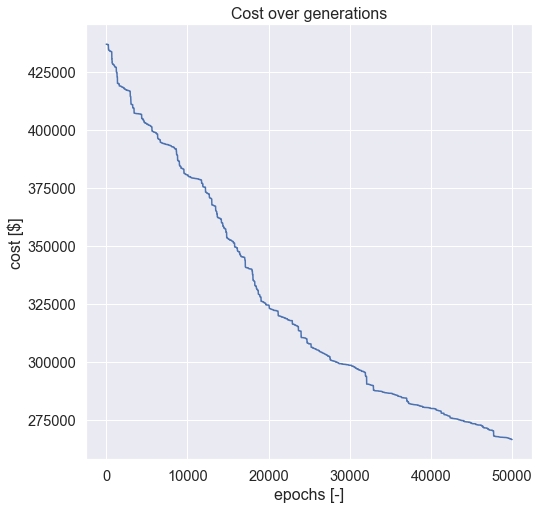

In [87]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 50000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_CHOICE = 2
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    #t_lost_0 = time.time()
    #print(" ")

    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    #print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 
    #t_lost_1 = time.time()
    #print("Timing lost: ", t_lost_1 - t_lost_0)
    
    #t_cross_0 = time.time()
    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)    
    #t_cross_1 = time.time()
    #print("Timing cross: ", t_cross_1 - t_cross_0)
    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    #t_mut_0 = time.time()
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                mutation_day(df_pop.loc[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
            

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)
    #t_mut_1 = time.time()
    #print("Timing mutation: ", t_mut_1 - t_mut_0)
    ############
    # EVALUATION
    # create cost dataFrame for all population
    #t_eval_0 = time.time()
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = \
            cost_function_optim(df_pop.loc[indice].values)

    #t_eval_1 = time.time()
    #print("Timing eval: ", t_eval_1 - t_eval_0)
    
    t_epoch_1 = time.time()
    #print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    print("GEN. #{} / cost: {} / nb. pop: {} / timing: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_epoch_1 - t_epoch_0))
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

In [88]:
print(df_cost.sort_values(by="cost").head(1)["cost"].values)

[266433.55706385]


#### Save results

In [89]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dc2_rm0.1_gen50000_s266433.pkl']

 
GENERATION #0 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.4269251823425293
 
GENERATION #1 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.382321834564209
 
GENERATION #2 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.7789270877838135
 
GENERATION #3 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.44901609420776367
 
GENERATION #4 / nb. pop: 32
nb_survivor:  32
           cost
0  565483.59881
Timing epoch:  0.35001182556152344
 
GENERATION #5 / nb. pop: 32
nb_survivor:  32
             cost
11  565385.075003
Timing epoch:  0.3471691608428955
 
GENERATION #6 / nb. pop: 32
nb_survivor:  32
             cost
22  565385.075003
Timing epoch:  0.3910977840423584
 
GENERATION #7 / nb. pop: 32
nb_survivor:  32
             cost
22  565385.075003
Timing epoch:  0.3407909870147705
 
GENERATION #8 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Ti

            cost
0  565385.075003
Timing epoch:  0.32091403007507324
 
GENERATION #72 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3380460739135742
 
GENERATION #73 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.32477712631225586
 
GENERATION #74 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3173801898956299
 
GENERATION #75 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.32683897018432617
 
GENERATION #76 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.33784914016723633
 
GENERATION #77 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3197011947631836
 
GENERATION #78 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3211939334869385
 
GENERATION #79 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.3517839908599

            cost
0  565385.075003
Timing epoch:  0.5474598407745361
 
GENERATION #142 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.3529469966888428
 
GENERATION #143 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.42020297050476074
 
GENERATION #144 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3571147918701172
 
GENERATION #145 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.4325289726257324
 
GENERATION #146 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.3488337993621826
 
GENERATION #147 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.4183380603790283
 
GENERATION #148 / nb. pop: 32
nb_survivor:  32
             cost
15  565385.075003
Timing epoch:  0.3636322021484375
 
GENERATION #149 / nb. pop: 32
nb_survivor:  32
            cost
0  565385.075003
Timing epoch:  0.340821

            cost
8  565354.043958
Timing epoch:  0.31541919708251953
 
GENERATION #212 / nb. pop: 32
nb_survivor:  32
            cost
5  565354.043958
Timing epoch:  0.3204221725463867
 
GENERATION #213 / nb. pop: 32
nb_survivor:  32
            cost
2  565354.043958
Timing epoch:  0.34300994873046875
 
GENERATION #214 / nb. pop: 32
nb_survivor:  32
             cost
25  565354.043958
Timing epoch:  0.3127632141113281
 
GENERATION #215 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.32523083686828613
 
GENERATION #216 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.35355687141418457
 
GENERATION #217 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.3135948181152344
 
GENERATION #218 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.3271462917327881
 
GENERATION #219 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.3522639

            cost
0  565354.043958
Timing epoch:  0.3246636390686035
 
GENERATION #282 / nb. pop: 32
nb_survivor:  32
             cost
15  565354.043958
Timing epoch:  0.3204622268676758
 
GENERATION #283 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.3638889789581299
 
GENERATION #284 / nb. pop: 32
nb_survivor:  32
             cost
31  565354.043958
Timing epoch:  0.3120241165161133
 
GENERATION #285 / nb. pop: 32
nb_survivor:  32
             cost
31  565354.043958
Timing epoch:  0.3139157295227051
 
GENERATION #286 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.331157922744751
 
GENERATION #287 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.31656599044799805
 
GENERATION #288 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.31182003021240234
 
GENERATION #289 / nb. pop: 32
nb_survivor:  32
            cost
0  565354.043958
Timing epoch:  0.338935

            cost
0  565312.205743
Timing epoch:  0.32041311264038086
 
GENERATION #352 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32414698600769043
 
GENERATION #353 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32848119735717773
 
GENERATION #354 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31360816955566406
 
GENERATION #355 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.32509303092956543
 
GENERATION #356 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.37078404426574707
 
GENERATION #357 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31726813316345215
 
GENERATION #358 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3183557987213135
 
GENERATION #359 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.35

            cost
0  565312.205743
Timing epoch:  0.31630492210388184
 
GENERATION #422 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32933497428894043
 
GENERATION #423 / nb. pop: 32
nb_survivor:  32
             cost
31  565312.205743
Timing epoch:  0.35160088539123535
 
GENERATION #424 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3132209777832031
 
GENERATION #425 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32085084915161133
 
GENERATION #426 / nb. pop: 32
nb_survivor:  32
             cost
31  565312.205743
Timing epoch:  0.3510768413543701
 
GENERATION #427 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31799793243408203
 
GENERATION #428 / nb. pop: 32
nb_survivor:  32
             cost
31  565312.205743
Timing epoch:  0.32119178771972656
 
GENERATION #429 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0

            cost
0  565312.205743
Timing epoch:  0.31211280822753906
 
GENERATION #492 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3180580139160156
 
GENERATION #493 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3703460693359375
 
GENERATION #494 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3127939701080322
 
GENERATION #495 / nb. pop: 32
nb_survivor:  32
             cost
31  565312.205743
Timing epoch:  0.31444692611694336
 
GENERATION #496 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3426198959350586
 
GENERATION #497 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32806897163391113
 
GENERATION #498 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3275010585784912
 
GENERATION #499 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.357220

            cost
0  565312.205743
Timing epoch:  0.321120023727417
 
GENERATION #562 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3571648597717285
 
GENERATION #563 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3278050422668457
 
GENERATION #564 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3495478630065918
 
GENERATION #565 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32748985290527344
 
GENERATION #566 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31170201301574707
 
GENERATION #567 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32500410079956055
 
GENERATION #568 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3554649353027344
 
GENERATION #569 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.317998170

            cost
0  565312.205743
Timing epoch:  0.32437896728515625
 
GENERATION #632 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.34114789962768555
 
GENERATION #633 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3170938491821289
 
GENERATION #634 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3297560214996338
 
GENERATION #635 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3448362350463867
 
GENERATION #636 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31533098220825195
 
GENERATION #637 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32538819313049316
 
GENERATION #638 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3478090763092041
 
GENERATION #639 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.316

            cost
0  565312.205743
Timing epoch:  0.3157501220703125
 
GENERATION #702 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31682682037353516
 
GENERATION #703 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.31499481201171875
 
GENERATION #704 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.33433985710144043
 
GENERATION #705 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3188140392303467
 
GENERATION #706 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.33191800117492676
 
GENERATION #707 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3178260326385498
 
GENERATION #708 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3370041847229004
 
GENERATION #709 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3317289

             cost
31  565312.205743
Timing epoch:  0.35262274742126465
 
GENERATION #772 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32021093368530273
 
GENERATION #773 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32227373123168945
 
GENERATION #774 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3448500633239746
 
GENERATION #775 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.319047212600708
 
GENERATION #776 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3170931339263916
 
GENERATION #777 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3609778881072998
 
GENERATION #778 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3138129711151123
 
GENERATION #779 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.326690912

             cost
31  565312.205743
Timing epoch:  0.33873677253723145
 
GENERATION #842 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31764888763427734
 
GENERATION #843 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.31665682792663574
 
GENERATION #844 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.33206605911254883
 
GENERATION #845 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3175070285797119
 
GENERATION #846 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3151390552520752
 
GENERATION #847 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.3292980194091797
 
GENERATION #848 / nb. pop: 32
nb_survivor:  32
            cost
0  565312.205743
Timing epoch:  0.32144999504089355
 
GENERATION #849 / nb. pop: 32
nb_survivor:  32
             cost
15  565312.205743
Timing epoch:  0.3161

             cost
15  565239.442431
Timing epoch:  0.31682300567626953
 
GENERATION #912 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.3181791305541992
 
GENERATION #913 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3451838493347168
 
GENERATION #914 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3136768341064453
 
GENERATION #915 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31932687759399414
 
GENERATION #916 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.35294103622436523
 
GENERATION #917 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31628870964050293
 
GENERATION #918 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31675076484680176
 
GENERATION #919 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3499

            cost
0  565239.442431
Timing epoch:  0.3330650329589844
 
GENERATION #982 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3179802894592285
 
GENERATION #983 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31723999977111816
 
GENERATION #984 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3372838497161865
 
GENERATION #985 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3244450092315674
 
GENERATION #986 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3287489414215088
 
GENERATION #987 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3151218891143799
 
GENERATION #988 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31755495071411133
 
GENERATION #989 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31565880775

             cost
15  565239.442431
Timing epoch:  0.3484790325164795
 
GENERATION #1052 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3185269832611084
 
GENERATION #1053 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33237409591674805
 
GENERATION #1054 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3897562026977539
 
GENERATION #1055 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3221311569213867
 
GENERATION #1056 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32190537452697754
 
GENERATION #1057 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.3471031188964844
 
GENERATION #1058 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3160672187805176
 
GENERATION #1059 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch: 

            cost
0  565239.442431
Timing epoch:  0.3313143253326416
 
GENERATION #1121 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3148212432861328
 
GENERATION #1122 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3151259422302246
 
GENERATION #1123 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3336818218231201
 
GENERATION #1124 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33353710174560547
 
GENERATION #1125 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31444406509399414
 
GENERATION #1126 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32260584831237793
 
GENERATION #1127 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3417389392852783
 
GENERATION #1128 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32

            cost
0  565239.442431
Timing epoch:  0.32350587844848633
 
GENERATION #1191 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.349506139755249
 
GENERATION #1192 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31388115882873535
 
GENERATION #1193 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31496191024780273
 
GENERATION #1194 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3325228691101074
 
GENERATION #1195 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.315248966217041
 
GENERATION #1196 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33360910415649414
 
GENERATION #1197 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3195488452911377
 
GENERATION #1198 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3

             cost
15  565239.442431
Timing epoch:  0.31250476837158203
 
GENERATION #1261 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3137190341949463
 
GENERATION #1262 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3386268615722656
 
GENERATION #1263 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32840490341186523
 
GENERATION #1264 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3153421878814697
 
GENERATION #1265 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.3406689167022705
 
GENERATION #1266 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3387320041656494
 
GENERATION #1267 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3219308853149414
 
GENERATION #1268 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch: 

            cost
0  565239.442431
Timing epoch:  0.31415390968322754
 
GENERATION #1331 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31749391555786133
 
GENERATION #1332 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3726940155029297
 
GENERATION #1333 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31638479232788086
 
GENERATION #1334 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3269631862640381
 
GENERATION #1335 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3282129764556885
 
GENERATION #1336 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31850099563598633
 
GENERATION #1337 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31301093101501465
 
GENERATION #1338 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  

            cost
0  565239.442431
Timing epoch:  0.314924955368042
 
GENERATION #1400 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.34920310974121094
 
GENERATION #1401 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32347893714904785
 
GENERATION #1402 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3548851013183594
 
GENERATION #1403 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3194551467895508
 
GENERATION #1404 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31117820739746094
 
GENERATION #1405 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3214759826660156
 
GENERATION #1406 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3521461486816406
 
GENERATION #1407 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.313

            cost
0  565239.442431
Timing epoch:  0.3247649669647217
 
GENERATION #1470 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3454608917236328
 
GENERATION #1471 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32322025299072266
 
GENERATION #1472 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33508825302124023
 
GENERATION #1473 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31615614891052246
 
GENERATION #1474 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3142518997192383
 
GENERATION #1475 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32920193672180176
 
GENERATION #1476 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.316817045211792
 
GENERATION #1477 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31

             cost
31  565239.442431
Timing epoch:  0.31692981719970703
 
GENERATION #1540 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3642897605895996
 
GENERATION #1541 / nb. pop: 32
nb_survivor:  32
             cost
31  565239.442431
Timing epoch:  0.3219892978668213
 
GENERATION #1542 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.33359789848327637
 
GENERATION #1543 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32668590545654297
 
GENERATION #1544 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3129899501800537
 
GENERATION #1545 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.329953670501709
 
GENERATION #1546 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3436141014099121
 
GENERATION #1547 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch

            cost
0  565239.442431
Timing epoch:  0.33620500564575195
 
GENERATION #1610 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.34122395515441895
 
GENERATION #1611 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3403809070587158
 
GENERATION #1612 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3537721633911133
 
GENERATION #1613 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.317263126373291
 
GENERATION #1614 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3169519901275635
 
GENERATION #1615 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.35449814796447754
 
GENERATION #1616 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32053494453430176
 
GENERATION #1617 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  

            cost
0  565239.442431
Timing epoch:  0.3379960060119629
 
GENERATION #1680 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3137240409851074
 
GENERATION #1681 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.3208479881286621
 
GENERATION #1682 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3549489974975586
 
GENERATION #1683 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.32083582878112793
 
GENERATION #1684 / nb. pop: 32
nb_survivor:  32
             cost
15  565239.442431
Timing epoch:  0.31792473793029785
 
GENERATION #1685 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.35478973388671875
 
GENERATION #1686 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.312345027923584
 
GENERATION #1687 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0

             cost
15  565239.442431
Timing epoch:  0.3113248348236084
 
GENERATION #1749 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3374018669128418
 
GENERATION #1750 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3133409023284912
 
GENERATION #1751 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.31439208984375
 
GENERATION #1752 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.33004212379455566
 
GENERATION #1753 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.317554235458374
 
GENERATION #1754 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.30939698219299316
 
GENERATION #1755 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3554821014404297
 
GENERATION #1756 / nb. pop: 32
nb_survivor:  32
            cost
0  565239.442431
Timing epoch:  0.3172

            cost
0  565214.500132
Timing epoch:  0.3171672821044922
 
GENERATION #1819 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.34311676025390625
 
GENERATION #1820 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.315061092376709
 
GENERATION #1821 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3222517967224121
 
GENERATION #1822 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.36400318145751953
 
GENERATION #1823 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.3166079521179199
 
GENERATION #1824 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3190340995788574
 
GENERATION #1825 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3392467498779297
 
GENERATION #1826 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.31

            cost
0  565214.500132
Timing epoch:  0.3120880126953125
 
GENERATION #1889 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.331287145614624
 
GENERATION #1890 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.31658005714416504
 
GENERATION #1891 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.3142721652984619
 
GENERATION #1892 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.328930139541626
 
GENERATION #1893 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.31806421279907227
 
GENERATION #1894 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3170628547668457
 
GENERATION #1895 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.32674407958984375
 
GENERATION #1896 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  

             cost
31  565214.500132
Timing epoch:  0.3137850761413574
 
GENERATION #1959 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3310239315032959
 
GENERATION #1960 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3253641128540039
 
GENERATION #1961 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3140900135040283
 
GENERATION #1962 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3215827941894531
 
GENERATION #1963 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.34930419921875
 
GENERATION #1964 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.34389519691467285
 
GENERATION #1965 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.45270419120788574
 
GENERATION #1966 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0

            cost
0  565214.500132
Timing epoch:  0.31307411193847656
 
GENERATION #2029 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.3213498592376709
 
GENERATION #2030 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.32076501846313477
 
GENERATION #2031 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.34661412239074707
 
GENERATION #2032 / nb. pop: 32
nb_survivor:  32
             cost
15  565214.500132
Timing epoch:  0.3143141269683838
 
GENERATION #2033 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3185312747955322
 
GENERATION #2034 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3535311222076416
 
GENERATION #2035 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:  0.3195071220397949
 
GENERATION #2036 / nb. pop: 32
nb_survivor:  32
            cost
0  565214.500132
Timing epoch:

            cost
4  565213.124619
Timing epoch:  0.3216259479522705
 
GENERATION #2098 / nb. pop: 32
nb_survivor:  32
             cost
22  565213.124619
Timing epoch:  0.33141207695007324
 
GENERATION #2099 / nb. pop: 32
nb_survivor:  32
            cost
1  565213.124619
Timing epoch:  0.32144713401794434
 
GENERATION #2100 / nb. pop: 32
nb_survivor:  32
            cost
2  565213.124619
Timing epoch:  0.3219120502471924
 
GENERATION #2101 / nb. pop: 32
nb_survivor:  32
            cost
3  565213.124619
Timing epoch:  0.3411250114440918
 
GENERATION #2102 / nb. pop: 32
nb_survivor:  32
             cost
15  565213.124619
Timing epoch:  0.31295013427734375
 
GENERATION #2103 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3187680244445801
 
GENERATION #2104 / nb. pop: 32
nb_survivor:  32
             cost
15  565213.124619
Timing epoch:  0.3361937999725342
 
GENERATION #2105 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:

             cost
31  565213.124619
Timing epoch:  0.3482050895690918
 
GENERATION #2167 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.31818413734436035
 
GENERATION #2168 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.34036779403686523
 
GENERATION #2169 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3468039035797119
 
GENERATION #2170 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3095870018005371
 
GENERATION #2171 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.33559083938598633
 
GENERATION #2172 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3152120113372803
 
GENERATION #2173 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.31445908546447754
 
GENERATION #2174 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0

             cost
15  565213.124619
Timing epoch:  0.3290390968322754
 
GENERATION #2236 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3242988586425781
 
GENERATION #2237 / nb. pop: 32
nb_survivor:  32
             cost
31  565213.124619
Timing epoch:  0.31780481338500977
 
GENERATION #2238 / nb. pop: 32
nb_survivor:  32
             cost
31  565213.124619
Timing epoch:  0.3350210189819336
 
GENERATION #2239 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.36860179901123047
 
GENERATION #2240 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3188209533691406
 
GENERATION #2241 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.37391090393066406
 
GENERATION #2242 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.31465911865234375
 
GENERATION #2243 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch

            cost
0  565213.124619
Timing epoch:  0.3149440288543701
 
GENERATION #2305 / nb. pop: 32
nb_survivor:  32
             cost
15  565213.124619
Timing epoch:  0.32324719429016113
 
GENERATION #2306 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3470420837402344
 
GENERATION #2307 / nb. pop: 32
nb_survivor:  32
             cost
15  565213.124619
Timing epoch:  0.31775474548339844
 
GENERATION #2308 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3200042247772217
 
GENERATION #2309 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3518493175506592
 
GENERATION #2310 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3167850971221924
 
GENERATION #2311 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3230109214782715
 
GENERATION #2312 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0

            cost
0  565213.124619
Timing epoch:  0.3135349750518799
 
GENERATION #2375 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3171231746673584
 
GENERATION #2376 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3266129493713379
 
GENERATION #2377 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3225531578063965
 
GENERATION #2378 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.3168051242828369
 
GENERATION #2379 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.32242512702941895
 
GENERATION #2380 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.35337209701538086
 
GENERATION #2381 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.31918907165527344
 
GENERATION #2382 / nb. pop: 32
nb_survivor:  32
            cost
0  565213.124619
Timing epoch:  0.33

            cost
0  565202.614151
Timing epoch:  0.3199591636657715
 
GENERATION #2445 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.31973910331726074
 
GENERATION #2446 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.3577420711517334
 
GENERATION #2447 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.32701706886291504
 
GENERATION #2448 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.3486747741699219
 
GENERATION #2449 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.31882786750793457
 
GENERATION #2450 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.31376004219055176
 
GENERATION #2451 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.3130021095275879
 
GENERATION #2452 / nb. pop: 32
nb_survivor:  32
            cost
0  565202.614151
Timing epoch:  0.3

            cost
0  565192.443677
Timing epoch:  0.31609511375427246
 
GENERATION #2515 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.32003188133239746
 
GENERATION #2516 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.4491438865661621
 
GENERATION #2517 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.34598612785339355
 
GENERATION #2518 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.32958006858825684
 
GENERATION #2519 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.3190159797668457
 
GENERATION #2520 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.3183870315551758
 
GENERATION #2521 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.33332395553588867
 
GENERATION #2522 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.

            cost
0  565192.443677
Timing epoch:  0.42708611488342285
 
GENERATION #2584 / nb. pop: 32
nb_survivor:  32
             cost
15  565192.443677
Timing epoch:  0.45531201362609863
 
GENERATION #2585 / nb. pop: 32
nb_survivor:  32
             cost
31  565192.443677
Timing epoch:  0.4172217845916748
 
GENERATION #2586 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.4113008975982666
 
GENERATION #2587 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.43634819984436035
 
GENERATION #2588 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.3626430034637451
 
GENERATION #2589 / nb. pop: 32
nb_survivor:  32
             cost
15  565192.443677
Timing epoch:  0.3934519290924072
 
GENERATION #2590 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch:  0.38292884826660156
 
GENERATION #2591 / nb. pop: 32
nb_survivor:  32
            cost
0  565192.443677
Timing epoch

            cost
0  565155.548345
Timing epoch:  0.31490302085876465
 
GENERATION #2653 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3546407222747803
 
GENERATION #2654 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.31612396240234375
 
GENERATION #2655 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3245539665222168
 
GENERATION #2656 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.35605788230895996
 
GENERATION #2657 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3250389099121094
 
GENERATION #2658 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch:  0.31696510314941406
 
GENERATION #2659 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3485071659088135
 
GENERATION #2660 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch: 

            cost
0  565155.548345
Timing epoch:  0.33471012115478516
 
GENERATION #2722 / nb. pop: 32
nb_survivor:  32
             cost
31  565155.548345
Timing epoch:  0.33170127868652344
 
GENERATION #2723 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3349418640136719
 
GENERATION #2724 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch:  0.3404500484466553
 
GENERATION #2725 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch:  0.3157339096069336
 
GENERATION #2726 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3136610984802246
 
GENERATION #2727 / nb. pop: 32
nb_survivor:  32
             cost
15  565155.548345
Timing epoch:  0.3518638610839844
 
GENERATION #2728 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch:  0.3144869804382324
 
GENERATION #2729 / nb. pop: 32
nb_survivor:  32
            cost
0  565155.548345
Timing epoch

            cost
0  565149.642125
Timing epoch:  0.32369399070739746
 
GENERATION #2792 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.33777618408203125
 
GENERATION #2793 / nb. pop: 32
nb_survivor:  32
             cost
15  565149.642125
Timing epoch:  0.3210155963897705
 
GENERATION #2794 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.32912683486938477
 
GENERATION #2795 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.34969305992126465
 
GENERATION #2796 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.31358790397644043
 
GENERATION #2797 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.3580169677734375
 
GENERATION #2798 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.35079097747802734
 
GENERATION #2799 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch: 

            cost
0  565149.642125
Timing epoch:  0.3342311382293701
 
GENERATION #2861 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.38335204124450684
 
GENERATION #2862 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.3227503299713135
 
GENERATION #2863 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.3207080364227295
 
GENERATION #2864 / nb. pop: 32
nb_survivor:  32
             cost
31  565149.642125
Timing epoch:  0.3542330265045166
 
GENERATION #2865 / nb. pop: 32
nb_survivor:  32
             cost
15  565149.642125
Timing epoch:  0.3196539878845215
 
GENERATION #2866 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  0.3182201385498047
 
GENERATION #2867 / nb. pop: 32
nb_survivor:  32
             cost
15  565149.642125
Timing epoch:  0.3636009693145752
 
GENERATION #2868 / nb. pop: 32
nb_survivor:  32
            cost
0  565149.642125
Timing epoch:  

            cost
0  565089.120527
Timing epoch:  0.31636905670166016
 
GENERATION #2931 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.3461341857910156
 
GENERATION #2932 / nb. pop: 32
nb_survivor:  32
             cost
15  565089.120527
Timing epoch:  0.3128941059112549
 
GENERATION #2933 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.3295619487762451
 
GENERATION #2934 / nb. pop: 32
nb_survivor:  32
             cost
15  565089.120527
Timing epoch:  0.3570709228515625
 
GENERATION #2935 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.3172109127044678
 
GENERATION #2936 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.31670498847961426
 
GENERATION #2937 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  0.36979103088378906
 
GENERATION #2938 / nb. pop: 32
nb_survivor:  32
            cost
0  565089.120527
Timing epoch:  

            cost
0  564992.118446
Timing epoch:  0.3154900074005127
 
GENERATION #3001 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.34816408157348633
 
GENERATION #3002 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31862592697143555
 
GENERATION #3003 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.33679699897766113
 
GENERATION #3004 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3320503234863281
 
GENERATION #3005 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31479310989379883
 
GENERATION #3006 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.32268691062927246
 
GENERATION #3007 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.34296584129333496
 
GENERATION #3008 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch

            cost
0  564992.118446
Timing epoch:  0.31719398498535156
 
GENERATION #3071 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31749892234802246
 
GENERATION #3072 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.3331940174102783
 
GENERATION #3073 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.33638978004455566
 
GENERATION #3074 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31581902503967285
 
GENERATION #3075 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3393096923828125
 
GENERATION #3076 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3156149387359619
 
GENERATION #3077 / nb. pop: 32
nb_survivor:  32
             cost
31  564992.118446
Timing epoch:  0.33098697662353516
 
GENERATION #3078 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:

            cost
0  564992.118446
Timing epoch:  0.31165504455566406
 
GENERATION #3141 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31592392921447754
 
GENERATION #3142 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3219473361968994
 
GENERATION #3143 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.347456693649292
 
GENERATION #3144 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.312974214553833
 
GENERATION #3145 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.32829904556274414
 
GENERATION #3146 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.33120203018188477
 
GENERATION #3147 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3183128833770752
 
GENERATION #3148 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.313

            cost
0  564992.118446
Timing epoch:  0.3415391445159912
 
GENERATION #3211 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.317903995513916
 
GENERATION #3212 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.327517032623291
 
GENERATION #3213 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.33060312271118164
 
GENERATION #3214 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3120081424713135
 
GENERATION #3215 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.32018113136291504
 
GENERATION #3216 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.34981608390808105
 
GENERATION #3217 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31828999519348145
 
GENERATION #3218 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0

            cost
0  564992.118446
Timing epoch:  0.31140804290771484
 
GENERATION #3281 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3138720989227295
 
GENERATION #3282 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3408970832824707
 
GENERATION #3283 / nb. pop: 32
nb_survivor:  32
             cost
31  564992.118446
Timing epoch:  0.32180094718933105
 
GENERATION #3284 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31357908248901367
 
GENERATION #3285 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.34078216552734375
 
GENERATION #3286 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31395602226257324
 
GENERATION #3287 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3138408660888672
 
GENERATION #3288 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:

            cost
0  564992.118446
Timing epoch:  0.31840085983276367
 
GENERATION #3351 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3143138885498047
 
GENERATION #3352 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.33437013626098633
 
GENERATION #3353 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3168489933013916
 
GENERATION #3354 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31150007247924805
 
GENERATION #3355 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3357369899749756
 
GENERATION #3356 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3181498050689697
 
GENERATION #3357 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.3168177604675293
 
GENERATION #3358 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.

            cost
0  564992.118446
Timing epoch:  0.31456804275512695
 
GENERATION #3421 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3725130558013916
 
GENERATION #3422 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3326249122619629
 
GENERATION #3423 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.31382298469543457
 
GENERATION #3424 / nb. pop: 32
nb_survivor:  32
             cost
15  564992.118446
Timing epoch:  0.3783440589904785
 
GENERATION #3425 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3157799243927002
 
GENERATION #3426 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.32029008865356445
 
GENERATION #3427 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.3748302459716797
 
GENERATION #3428 / nb. pop: 32
nb_survivor:  32
            cost
0  564992.118446
Timing epoch:  0.

            cost
0  564981.644525
Timing epoch:  0.32293128967285156
 
GENERATION #3491 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3507039546966553
 
GENERATION #3492 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31662583351135254
 
GENERATION #3493 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3315877914428711
 
GENERATION #3494 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32814478874206543
 
GENERATION #3495 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32312798500061035
 
GENERATION #3496 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32421398162841797
 
GENERATION #3497 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.35866785049438477
 
GENERATION #3498 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0

             cost
15  564981.644525
Timing epoch:  0.31627321243286133
 
GENERATION #3560 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31400299072265625
 
GENERATION #3561 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3486967086791992
 
GENERATION #3562 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31393980979919434
 
GENERATION #3563 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3158841133117676
 
GENERATION #3564 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.36160802841186523
 
GENERATION #3565 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33017921447753906
 
GENERATION #3566 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3154160976409912
 
GENERATION #3567 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  

            cost
0  564981.644525
Timing epoch:  0.32149291038513184
 
GENERATION #3630 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32353997230529785
 
GENERATION #3631 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.34534716606140137
 
GENERATION #3632 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3132297992706299
 
GENERATION #3633 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31818485260009766
 
GENERATION #3634 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3509230613708496
 
GENERATION #3635 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32156896591186523
 
GENERATION #3636 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33083581924438477
 
GENERATION #3637 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch: 

            cost
0  564981.644525
Timing epoch:  0.31916379928588867
 
GENERATION #3700 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3323981761932373
 
GENERATION #3701 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31792783737182617
 
GENERATION #3702 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3159751892089844
 
GENERATION #3703 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33448314666748047
 
GENERATION #3704 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31143903732299805
 
GENERATION #3705 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3146851062774658
 
GENERATION #3706 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3330051898956299
 
GENERATION #3707 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3

            cost
0  564981.644525
Timing epoch:  0.3164491653442383
 
GENERATION #3770 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3186523914337158
 
GENERATION #3771 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.37557125091552734
 
GENERATION #3772 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31270885467529297
 
GENERATION #3773 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33675193786621094
 
GENERATION #3774 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3145279884338379
 
GENERATION #3775 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3130359649658203
 
GENERATION #3776 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.32056188583374023
 
GENERATION #3777 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0

            cost
0  564981.644525
Timing epoch:  0.3323962688446045
 
GENERATION #3839 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3154282569885254
 
GENERATION #3840 / nb. pop: 32
nb_survivor:  32
             cost
31  564981.644525
Timing epoch:  0.310377836227417
 
GENERATION #3841 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3338308334350586
 
GENERATION #3842 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32454514503479004
 
GENERATION #3843 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.316317081451416
 
GENERATION #3844 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32856273651123047
 
GENERATION #3845 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31729602813720703
 
GENERATION #3846 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31

            cost
0  564981.644525
Timing epoch:  0.3259401321411133
 
GENERATION #3909 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3362700939178467
 
GENERATION #3910 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3151590824127197
 
GENERATION #3911 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.32515931129455566
 
GENERATION #3912 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.336838960647583
 
GENERATION #3913 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31692075729370117
 
GENERATION #3914 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3183860778808594
 
GENERATION #3915 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.357058048248291
 
GENERATION #3916 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.315

            cost
0  564981.644525
Timing epoch:  0.31982994079589844
 
GENERATION #3978 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.36235690116882324
 
GENERATION #3979 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3214850425720215
 
GENERATION #3980 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.32036900520324707
 
GENERATION #3981 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32615089416503906
 
GENERATION #3982 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.31656408309936523
 
GENERATION #3983 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3181648254394531
 
GENERATION #3984 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32976317405700684
 
GENERATION #3985 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epo

            cost
0  564981.644525
Timing epoch:  0.3151841163635254
 
GENERATION #4048 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3202378749847412
 
GENERATION #4049 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3467428684234619
 
GENERATION #4050 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3148980140686035
 
GENERATION #4051 / nb. pop: 32
nb_survivor:  32
             cost
31  564981.644525
Timing epoch:  0.31646180152893066
 
GENERATION #4052 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.35424304008483887
 
GENERATION #4053 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3150660991668701
 
GENERATION #4054 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31389689445495605
 
GENERATION #4055 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.

             cost
31  564981.644525
Timing epoch:  0.3349452018737793
 
GENERATION #4117 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3201560974121094
 
GENERATION #4118 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31435298919677734
 
GENERATION #4119 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3379976749420166
 
GENERATION #4120 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.31493282318115234
 
GENERATION #4121 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31641411781311035
 
GENERATION #4122 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32747769355773926
 
GENERATION #4123 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32309389114379883
 
GENERATION #4124 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:

            cost
0  564981.644525
Timing epoch:  0.33468008041381836
 
GENERATION #4187 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31543517112731934
 
GENERATION #4188 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31438708305358887
 
GENERATION #4189 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31487488746643066
 
GENERATION #4190 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33600807189941406
 
GENERATION #4191 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3179810047149658
 
GENERATION #4192 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.320314884185791
 
GENERATION #4193 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.3495180606842041
 
GENERATION #4194 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch: 

            cost
0  564981.644525
Timing epoch:  0.3217048645019531
 
GENERATION #4257 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3529372215270996
 
GENERATION #4258 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31240010261535645
 
GENERATION #4259 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31589603424072266
 
GENERATION #4260 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3342900276184082
 
GENERATION #4261 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.315140962600708
 
GENERATION #4262 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31576085090637207
 
GENERATION #4263 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33333897590637207
 
GENERATION #4264 / nb. pop: 32
nb_survivor:  32
             cost
31  564981.644525
Timing epoch:  

            cost
0  564981.644525
Timing epoch:  0.31337618827819824
 
GENERATION #4327 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3272719383239746
 
GENERATION #4328 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31553101539611816
 
GENERATION #4329 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3203723430633545
 
GENERATION #4330 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3193659782409668
 
GENERATION #4331 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3672618865966797
 
GENERATION #4332 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.317058801651001
 
GENERATION #4333 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3342158794403076
 
GENERATION #4334 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.31

             cost
15  564981.644525
Timing epoch:  0.31726837158203125
 
GENERATION #4397 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.329298734664917
 
GENERATION #4398 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33179616928100586
 
GENERATION #4399 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3162498474121094
 
GENERATION #4400 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.36367273330688477
 
GENERATION #4401 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.334888219833374
 
GENERATION #4402 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.31426405906677246
 
GENERATION #4403 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3263418674468994
 
GENERATION #4404 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch: 

            cost
0  564981.644525
Timing epoch:  0.3280649185180664
 
GENERATION #4466 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3123209476470947
 
GENERATION #4467 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.32558107376098633
 
GENERATION #4468 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33442091941833496
 
GENERATION #4469 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.314669132232666
 
GENERATION #4470 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3205890655517578
 
GENERATION #4471 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3483290672302246
 
GENERATION #4472 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.313493013381958
 
GENERATION #4473 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.320

            cost
0  564981.644525
Timing epoch:  0.36432695388793945
 
GENERATION #4536 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3122670650482178
 
GENERATION #4537 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3209879398345947
 
GENERATION #4538 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3572678565979004
 
GENERATION #4539 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31591081619262695
 
GENERATION #4540 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3192148208618164
 
GENERATION #4541 / nb. pop: 32
nb_survivor:  32
             cost
15  564981.644525
Timing epoch:  0.35813403129577637
 
GENERATION #4542 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31667208671569824
 
GENERATION #4543 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0

            cost
0  564981.644525
Timing epoch:  0.3367428779602051
 
GENERATION #4606 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3351781368255615
 
GENERATION #4607 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3162097930908203
 
GENERATION #4608 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31264591217041016
 
GENERATION #4609 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.336669921875
 
GENERATION #4610 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3116130828857422
 
GENERATION #4611 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31332993507385254
 
GENERATION #4612 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33730292320251465
 
GENERATION #4613 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.314159

            cost
0  564981.644525
Timing epoch:  0.31661200523376465
 
GENERATION #4676 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.35435914993286133
 
GENERATION #4677 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3153500556945801
 
GENERATION #4678 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3142662048339844
 
GENERATION #4679 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.33849596977233887
 
GENERATION #4680 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.31110692024230957
 
GENERATION #4681 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3119618892669678
 
GENERATION #4682 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3338890075683594
 
GENERATION #4683 / nb. pop: 32
nb_survivor:  32
            cost
0  564981.644525
Timing epoch:  0.3

            cost
15  564887.91103
Timing epoch:  0.3433690071105957
 
GENERATION #4746 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31273984909057617
 
GENERATION #4747 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3152010440826416
 
GENERATION #4748 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3448781967163086
 
GENERATION #4749 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3261072635650635
 
GENERATION #4750 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3146359920501709
 
GENERATION #4751 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3409543037414551
 
GENERATION #4752 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.32650017738342285
 
GENERATION #4753 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.31090521812438965

           cost
0  564887.91103
Timing epoch:  0.3293271064758301
 
GENERATION #4817 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3146169185638428
 
GENERATION #4818 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3240799903869629
 
GENERATION #4819 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3462357521057129
 
GENERATION #4820 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3137040138244629
 
GENERATION #4821 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.32021498680114746
 
GENERATION #4822 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3448338508605957
 
GENERATION #4823 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.315518856048584
 
GENERATION #4824 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3202507495880127
 
GENE

           cost
0  564887.91103
Timing epoch:  0.3364992141723633
 
GENERATION #4888 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31264424324035645
 
GENERATION #4889 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3321967124938965
 
GENERATION #4890 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3387720584869385
 
GENERATION #4891 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31416893005371094
 
GENERATION #4892 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.320314884185791
 
GENERATION #4893 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3551487922668457
 
GENERATION #4894 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3111879825592041
 
GENERATION #4895 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3308846950531006
 
GEN

            cost
15  564887.91103
Timing epoch:  0.3297569751739502
 
GENERATION #4959 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.33321595191955566
 
GENERATION #4960 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.316547155380249
 
GENERATION #4961 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.32273292541503906
 
GENERATION #4962 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.34763002395629883
 
GENERATION #4963 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31087708473205566
 
GENERATION #4964 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3146381378173828
 
GENERATION #4965 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.35885190963745117
 
GENERATION #4966 / nb. pop: 32
nb_survivor:  32
            cost
31  564887.91103
Timing epoch:  0.3158509731292

           cost
0  564887.91103
Timing epoch:  0.3422839641571045
 
GENERATION #5030 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.312222957611084
 
GENERATION #5031 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.324005126953125
 
GENERATION #5032 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.3358159065246582
 
GENERATION #5033 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31600117683410645
 
GENERATION #5034 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3145761489868164
 
GENERATION #5035 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3486790657043457
 
GENERATION #5036 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.3113737106323242
 
GENERATION #5037 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.32567310333251953
 


           cost
0  564887.91103
Timing epoch:  0.31246495246887207
 
GENERATION #5101 / nb. pop: 32
nb_survivor:  32
            cost
15  564887.91103
Timing epoch:  0.33658719062805176
 
GENERATION #5102 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.31151485443115234
 
GENERATION #5103 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3231799602508545
 
GENERATION #5104 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.316648006439209
 
GENERATION #5105 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3362460136413574
 
GENERATION #5106 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.3177328109741211
 
GENERATION #5107 / nb. pop: 32
nb_survivor:  32
           cost
0  564887.91103
Timing epoch:  0.34439706802368164
 
GENERATION #5108 / nb. pop: 32
nb_survivor:  32
            cost
31  564887.91103
Timing epoch:  0.3176040649414062

             cost
25  564849.520436
Timing epoch:  0.31857991218566895
 
GENERATION #5172 / nb. pop: 32
nb_survivor:  32
             cost
24  564849.520436
Timing epoch:  0.34908485412597656
 
GENERATION #5173 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31641578674316406
 
GENERATION #5174 / nb. pop: 32
nb_survivor:  32
             cost
15  564849.520436
Timing epoch:  0.31582093238830566
 
GENERATION #5175 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.40198516845703125
 
GENERATION #5176 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.33165597915649414
 
GENERATION #5177 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3303720951080322
 
GENERATION #5178 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.36114931106567383
 
GENERATION #5179 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing ep

            cost
0  564849.520436
Timing epoch:  0.33147716522216797
 
GENERATION #5241 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3338470458984375
 
GENERATION #5242 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.34175705909729004
 
GENERATION #5243 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.39975595474243164
 
GENERATION #5244 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3335399627685547
 
GENERATION #5245 / nb. pop: 32
nb_survivor:  32
             cost
15  564849.520436
Timing epoch:  0.3422260284423828
 
GENERATION #5246 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3437950611114502
 
GENERATION #5247 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.33397674560546875
 
GENERATION #5248 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0

            cost
0  564849.520436
Timing epoch:  0.3221299648284912
 
GENERATION #5311 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3182821273803711
 
GENERATION #5312 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3343939781188965
 
GENERATION #5313 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3253629207611084
 
GENERATION #5314 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3306748867034912
 
GENERATION #5315 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3147749900817871
 
GENERATION #5316 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31724977493286133
 
GENERATION #5317 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3214740753173828
 
GENERATION #5318 / nb. pop: 32
nb_survivor:  32
             cost
15  564849.520436
Timing epoch:  0.33

             cost
31  564849.520436
Timing epoch:  0.32394886016845703
 
GENERATION #5381 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3305201530456543
 
GENERATION #5382 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.32071781158447266
 
GENERATION #5383 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3247387409210205
 
GENERATION #5384 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31874775886535645
 
GENERATION #5385 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.35574889183044434
 
GENERATION #5386 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3148937225341797
 
GENERATION #5387 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3243088722229004
 
GENERATION #5388 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0

            cost
0  564849.520436
Timing epoch:  0.34221506118774414
 
GENERATION #5451 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3224160671234131
 
GENERATION #5452 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31438589096069336
 
GENERATION #5453 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3296942710876465
 
GENERATION #5454 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31351399421691895
 
GENERATION #5455 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31769585609436035
 
GENERATION #5456 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.34007978439331055
 
GENERATION #5457 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31792378425598145
 
GENERATION #5458 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0

            cost
0  564849.520436
Timing epoch:  0.31841111183166504
 
GENERATION #5520 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3378639221191406
 
GENERATION #5521 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.32260894775390625
 
GENERATION #5522 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3157479763031006
 
GENERATION #5523 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.3416280746459961
 
GENERATION #5524 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.32233500480651855
 
GENERATION #5525 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.31909918785095215
 
GENERATION #5526 / nb. pop: 32
nb_survivor:  32
            cost
0  564849.520436
Timing epoch:  0.330747127532959
 
GENERATION #5527 / nb. pop: 32
nb_survivor:  32
             cost
19  564836.321563
Timing epoch:  0.

            cost
0  564836.321563
Timing epoch:  0.31468725204467773
 
GENERATION #5589 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.3141348361968994
 
GENERATION #5590 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.3210737705230713
 
GENERATION #5591 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.35420989990234375
 
GENERATION #5592 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.31499218940734863
 
GENERATION #5593 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.32883405685424805
 
GENERATION #5594 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.3313438892364502
 
GENERATION #5595 / nb. pop: 32
nb_survivor:  32
            cost
0  564836.321563
Timing epoch:  0.320249080657959
 
GENERATION #5596 / nb. pop: 32
nb_survivor:  32
             cost
15  564836.321563
Timing epoch:  0.

             cost
15  564784.691995
Timing epoch:  0.3155391216278076
 
GENERATION #5658 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3333859443664551
 
GENERATION #5659 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3352670669555664
 
GENERATION #5660 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31537294387817383
 
GENERATION #5661 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3207249641418457
 
GENERATION #5662 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.34952592849731445
 
GENERATION #5663 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31578516960144043
 
GENERATION #5664 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31571006774902344
 
GENERATION #5665 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0

            cost
0  564784.691995
Timing epoch:  0.3559443950653076
 
GENERATION #5727 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  0.34090685844421387
 
GENERATION #5728 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3382711410522461
 
GENERATION #5729 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3257589340209961
 
GENERATION #5730 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31739211082458496
 
GENERATION #5731 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3313791751861572
 
GENERATION #5732 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3563508987426758
 
GENERATION #5733 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3142719268798828
 
GENERATION #5734 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3

             cost
31  564784.691995
Timing epoch:  0.3606278896331787
 
GENERATION #5797 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3628816604614258
 
GENERATION #5798 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31559181213378906
 
GENERATION #5799 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3323190212249756
 
GENERATION #5800 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3149397373199463
 
GENERATION #5801 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3436880111694336
 
GENERATION #5802 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3172428607940674
 
GENERATION #5803 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  0.33464503288269043
 
GENERATION #5804 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0

            cost
0  564784.691995
Timing epoch:  0.31911182403564453
 
GENERATION #5867 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31981778144836426
 
GENERATION #5868 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3401331901550293
 
GENERATION #5869 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31836795806884766
 
GENERATION #5870 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3134760856628418
 
GENERATION #5871 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.33591413497924805
 
GENERATION #5872 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31491827964782715
 
GENERATION #5873 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3169398307800293
 
GENERATION #5874 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  

            cost
0  564784.691995
Timing epoch:  0.3478999137878418
 
GENERATION #5936 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.32178401947021484
 
GENERATION #5937 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3219411373138428
 
GENERATION #5938 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  0.33069396018981934
 
GENERATION #5939 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31348586082458496
 
GENERATION #5940 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3127021789550781
 
GENERATION #5941 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.36324238777160645
 
GENERATION #5942 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.325498104095459
 
GENERATION #5943 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.

            cost
0  564784.691995
Timing epoch:  0.3490939140319824
 
GENERATION #6005 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3207130432128906
 
GENERATION #6006 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31803393363952637
 
GENERATION #6007 / nb. pop: 32
nb_survivor:  32
             cost
31  564784.691995
Timing epoch:  0.35591602325439453
 
GENERATION #6008 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.3219459056854248
 
GENERATION #6009 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31879496574401855
 
GENERATION #6010 / nb. pop: 32
nb_survivor:  32
             cost
15  564784.691995
Timing epoch:  0.3448648452758789
 
GENERATION #6011 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch:  0.31709909439086914
 
GENERATION #6012 / nb. pop: 32
nb_survivor:  32
            cost
0  564784.691995
Timing epoch: 

            cost
0  564775.805967
Timing epoch:  0.31557202339172363
 
GENERATION #6074 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.35565805435180664
 
GENERATION #6075 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3333287239074707
 
GENERATION #6076 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3166956901550293
 
GENERATION #6077 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.35971498489379883
 
GENERATION #6078 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3141598701477051
 
GENERATION #6079 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.34216809272766113
 
GENERATION #6080 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.34929370880126953
 
GENERATION #6081 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.

            cost
0  564775.805967
Timing epoch:  0.3251800537109375
 
GENERATION #6144 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3492915630340576
 
GENERATION #6145 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.31568002700805664
 
GENERATION #6146 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3171072006225586
 
GENERATION #6147 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3377528190612793
 
GENERATION #6148 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.31676602363586426
 
GENERATION #6149 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3222770690917969
 
GENERATION #6150 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3542778491973877
 
GENERATION #6151 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.320

            cost
0  564775.805967
Timing epoch:  0.3453559875488281
 
GENERATION #6214 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3417038917541504
 
GENERATION #6215 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3353867530822754
 
GENERATION #6216 / nb. pop: 32
nb_survivor:  32
             cost
31  564775.805967
Timing epoch:  0.3687160015106201
 
GENERATION #6217 / nb. pop: 32
nb_survivor:  32
             cost
15  564775.805967
Timing epoch:  0.32230710983276367
 
GENERATION #6218 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.3182241916656494
 
GENERATION #6219 / nb. pop: 32
nb_survivor:  32
             cost
15  564775.805967
Timing epoch:  0.33701300621032715
 
GENERATION #6220 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  0.317349910736084
 
GENERATION #6221 / nb. pop: 32
nb_survivor:  32
            cost
0  564775.805967
Timing epoch:  

            cost
0  564763.583591
Timing epoch:  0.33087801933288574
 
GENERATION #6284 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.3144659996032715
 
GENERATION #6285 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.3146049976348877
 
GENERATION #6286 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.33560776710510254
 
GENERATION #6287 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.33427906036376953
 
GENERATION #6288 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.3162369728088379
 
GENERATION #6289 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.33441877365112305
 
GENERATION #6290 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.31678295135498047
 
GENERATION #6291 / nb. pop: 32
nb_survivor:  32
            cost
0  564763.583591
Timing epoch:  0.

            cost
0  564610.277119
Timing epoch:  0.38301587104797363
 
GENERATION #6354 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.3247830867767334
 
GENERATION #6355 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31412577629089355
 
GENERATION #6356 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.3415110111236572
 
GENERATION #6357 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32721519470214844
 
GENERATION #6358 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3130669593811035
 
GENERATION #6359 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3398158550262451
 
GENERATION #6360 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3682820796966553
 
GENERATION #6361 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:

            cost
0  564610.277119
Timing epoch:  0.3164830207824707
 
GENERATION #6424 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.3140740394592285
 
GENERATION #6425 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32654809951782227
 
GENERATION #6426 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.34731292724609375
 
GENERATION #6427 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31780385971069336
 
GENERATION #6428 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3170013427734375
 
GENERATION #6429 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3433499336242676
 
GENERATION #6430 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3217930793762207
 
GENERATION #6431 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.

            cost
0  564610.277119
Timing epoch:  0.32623910903930664
 
GENERATION #6494 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32591795921325684
 
GENERATION #6495 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31412768363952637
 
GENERATION #6496 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.338364839553833
 
GENERATION #6497 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.33180904388427734
 
GENERATION #6498 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3322160243988037
 
GENERATION #6499 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3327162265777588
 
GENERATION #6500 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.337738037109375
 
GENERATION #6501 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.314

            cost
0  564610.277119
Timing epoch:  0.34340620040893555
 
GENERATION #6564 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31519484519958496
 
GENERATION #6565 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3173391819000244
 
GENERATION #6566 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.34815001487731934
 
GENERATION #6567 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3217930793762207
 
GENERATION #6568 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3105320930480957
 
GENERATION #6569 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.34229207038879395
 
GENERATION #6570 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.31488466262817383
 
GENERATION #6571 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  

            cost
0  564610.277119
Timing epoch:  0.31612205505371094
 
GENERATION #6633 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32478976249694824
 
GENERATION #6634 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3227729797363281
 
GENERATION #6635 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3173360824584961
 
GENERATION #6636 / nb. pop: 32
nb_survivor:  32
             cost
15  564610.277119
Timing epoch:  0.33328890800476074
 
GENERATION #6637 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.32560086250305176
 
GENERATION #6638 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.31444811820983887
 
GENERATION #6639 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  0.3264141082763672
 
GENERATION #6640 / nb. pop: 32
nb_survivor:  32
            cost
0  564610.277119
Timing epoch:  

            cost
0  564609.356503
Timing epoch:  0.3187429904937744
 
GENERATION #6703 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3119781017303467
 
GENERATION #6704 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3353750705718994
 
GENERATION #6705 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.31697988510131836
 
GENERATION #6706 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.31315135955810547
 
GENERATION #6707 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch:  0.3424367904663086
 
GENERATION #6708 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3197767734527588
 
GENERATION #6709 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3535802364349365
 
GENERATION #6710 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch:  0

            cost
0  564609.356503
Timing epoch:  0.32189106941223145
 
GENERATION #6773 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3186218738555908
 
GENERATION #6774 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.35281991958618164
 
GENERATION #6775 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3169269561767578
 
GENERATION #6776 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.31746888160705566
 
GENERATION #6777 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch:  0.3352508544921875
 
GENERATION #6778 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.31562089920043945
 
GENERATION #6779 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3205831050872803
 
GENERATION #6780 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0

             cost
31  564609.356503
Timing epoch:  0.32239389419555664
 
GENERATION #6843 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.32176685333251953
 
GENERATION #6844 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3537631034851074
 
GENERATION #6845 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3180980682373047
 
GENERATION #6846 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.33270907402038574
 
GENERATION #6847 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3558690547943115
 
GENERATION #6848 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch:  0.32292890548706055
 
GENERATION #6849 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3381960391998291
 
GENERATION #6850 / nb. pop: 32
nb_survivor:  32
             cost
15  564609.356503
Timing epoch

            cost
0  564609.356503
Timing epoch:  0.3138129711151123
 
GENERATION #6913 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3336629867553711
 
GENERATION #6914 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3178091049194336
 
GENERATION #6915 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3145418167114258
 
GENERATION #6916 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.32863593101501465
 
GENERATION #6917 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3139767646789551
 
GENERATION #6918 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.312938928604126
 
GENERATION #6919 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.33479928970336914
 
GENERATION #6920 / nb. pop: 32
nb_survivor:  32
            cost
0  564609.356503
Timing epoch:  0.3156

             cost
21  564575.214592
Timing epoch:  0.3165440559387207
 
GENERATION #6983 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3422579765319824
 
GENERATION #6984 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31404900550842285
 
GENERATION #6985 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3165857791900635
 
GENERATION #6986 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.32642579078674316
 
GENERATION #6987 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.34056806564331055
 
GENERATION #6988 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.32186317443847656
 
GENERATION #6989 / nb. pop: 32
nb_survivor:  32
             cost
15  564575.214592
Timing epoch:  0.33516597747802734
 
GENERATION #6990 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:

            cost
0  564575.214592
Timing epoch:  0.3136777877807617
 
GENERATION #7052 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31337904930114746
 
GENERATION #7053 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3645899295806885
 
GENERATION #7054 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.34214091300964355
 
GENERATION #7055 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.5585319995880127
 
GENERATION #7056 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.39653587341308594
 
GENERATION #7057 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3533668518066406
 
GENERATION #7058 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.32506394386291504
 
GENERATION #7059 / nb. pop: 32
nb_survivor:  32
             cost
31  564575.214592
Timing epoch:  0

            cost
0  564575.214592
Timing epoch:  0.32963991165161133
 
GENERATION #7122 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.33980584144592285
 
GENERATION #7123 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.34566187858581543
 
GENERATION #7124 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.34134721755981445
 
GENERATION #7125 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31571292877197266
 
GENERATION #7126 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3130972385406494
 
GENERATION #7127 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.33333706855773926
 
GENERATION #7128 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3313930034637451
 
GENERATION #7129 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0

            cost
0  564575.214592
Timing epoch:  0.33382701873779297
 
GENERATION #7192 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3177628517150879
 
GENERATION #7193 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3297879695892334
 
GENERATION #7194 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3467440605163574
 
GENERATION #7195 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.324199914932251
 
GENERATION #7196 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3188159465789795
 
GENERATION #7197 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.339052677154541
 
GENERATION #7198 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31485676765441895
 
GENERATION #7199 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.33652

            cost
0  564575.214592
Timing epoch:  0.3228271007537842
 
GENERATION #7262 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31278014183044434
 
GENERATION #7263 / nb. pop: 32
nb_survivor:  32
             cost
31  564575.214592
Timing epoch:  0.34673428535461426
 
GENERATION #7264 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.315554141998291
 
GENERATION #7265 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3185741901397705
 
GENERATION #7266 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3292820453643799
 
GENERATION #7267 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.32021307945251465
 
GENERATION #7268 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3209960460662842
 
GENERATION #7269 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3

            cost
0  564575.214592
Timing epoch:  0.3159151077270508
 
GENERATION #7332 / nb. pop: 32
nb_survivor:  32
             cost
15  564575.214592
Timing epoch:  0.32444095611572266
 
GENERATION #7333 / nb. pop: 32
nb_survivor:  32
             cost
31  564575.214592
Timing epoch:  0.3580291271209717
 
GENERATION #7334 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31653380393981934
 
GENERATION #7335 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31711387634277344
 
GENERATION #7336 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.33466219902038574
 
GENERATION #7337 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3159830570220947
 
GENERATION #7338 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3254261016845703
 
GENERATION #7339 / nb. pop: 32
nb_survivor:  32
             cost
31  564575.214592
Timing epoch

             cost
15  564575.214592
Timing epoch:  0.3470449447631836
 
GENERATION #7401 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3183751106262207
 
GENERATION #7402 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3176450729370117
 
GENERATION #7403 / nb. pop: 32
nb_survivor:  32
             cost
15  564575.214592
Timing epoch:  0.3430907726287842
 
GENERATION #7404 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.3151371479034424
 
GENERATION #7405 / nb. pop: 32
nb_survivor:  32
             cost
15  564575.214592
Timing epoch:  0.31439805030822754
 
GENERATION #7406 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.336946964263916
 
GENERATION #7407 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  0.31681394577026367
 
GENERATION #7408 / nb. pop: 32
nb_survivor:  32
            cost
0  564575.214592
Timing epoch:  

            cost
0  564384.848635
Timing epoch:  0.31697726249694824
 
GENERATION #7471 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31788110733032227
 
GENERATION #7472 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.354992151260376
 
GENERATION #7473 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3161499500274658
 
GENERATION #7474 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3360741138458252
 
GENERATION #7475 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31975674629211426
 
GENERATION #7476 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3132200241088867
 
GENERATION #7477 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3260610103607178
 
GENERATION #7478 / nb. pop: 32
nb_survivor:  32
             cost
15  564384.848635
Timing epoch:  0.3

            cost
0  564384.848635
Timing epoch:  0.31981992721557617
 
GENERATION #7541 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3258030414581299
 
GENERATION #7542 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3522300720214844
 
GENERATION #7543 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3174622058868408
 
GENERATION #7544 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3140988349914551
 
GENERATION #7545 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.35091423988342285
 
GENERATION #7546 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31841492652893066
 
GENERATION #7547 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31860923767089844
 
GENERATION #7548 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3

            cost
0  564384.848635
Timing epoch:  0.3175077438354492
 
GENERATION #7611 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.33826398849487305
 
GENERATION #7612 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.31780195236206055
 
GENERATION #7613 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.32198500633239746
 
GENERATION #7614 / nb. pop: 32
nb_survivor:  32
             cost
15  564384.848635
Timing epoch:  0.3360922336578369
 
GENERATION #7615 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3219747543334961
 
GENERATION #7616 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3237450122833252
 
GENERATION #7617 / nb. pop: 32
nb_survivor:  32
            cost
0  564384.848635
Timing epoch:  0.3287620544433594
 
GENERATION #7618 / nb. pop: 32
nb_survivor:  32
             cost
31  564384.848635
Timing epoch:  

            cost
0  563935.595839
Timing epoch:  0.3200809955596924
 
GENERATION #7680 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3456869125366211
 
GENERATION #7681 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.36074280738830566
 
GENERATION #7682 / nb. pop: 32
nb_survivor:  32
             cost
15  563935.595839
Timing epoch:  0.31576085090637207
 
GENERATION #7683 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3221879005432129
 
GENERATION #7684 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3592109680175781
 
GENERATION #7685 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3134169578552246
 
GENERATION #7686 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.32195520401000977
 
GENERATION #7687 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.

            cost
0  563935.595839
Timing epoch:  0.3176538944244385
 
GENERATION #7750 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3302173614501953
 
GENERATION #7751 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3517749309539795
 
GENERATION #7752 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.320432186126709
 
GENERATION #7753 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.34552931785583496
 
GENERATION #7754 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.333970308303833
 
GENERATION #7755 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.31647706031799316
 
GENERATION #7756 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3255140781402588
 
GENERATION #7757 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.34232

            cost
0  563935.595839
Timing epoch:  0.3476879596710205
 
GENERATION #7820 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3162245750427246
 
GENERATION #7821 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3239927291870117
 
GENERATION #7822 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.34783482551574707
 
GENERATION #7823 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.31409287452697754
 
GENERATION #7824 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3152120113372803
 
GENERATION #7825 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.34070467948913574
 
GENERATION #7826 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.31238889694213867
 
GENERATION #7827 / nb. pop: 32
nb_survivor:  32
            cost
0  563935.595839
Timing epoch:  0.3

            cost
0  563824.246184
Timing epoch:  0.3184530735015869
 
GENERATION #7889 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.35946178436279297
 
GENERATION #7890 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.3158719539642334
 
GENERATION #7891 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.3255610466003418
 
GENERATION #7892 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.3417081832885742
 
GENERATION #7893 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.31710004806518555
 
GENERATION #7894 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.32686614990234375
 
GENERATION #7895 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.3345913887023926
 
GENERATION #7896 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoc

            cost
0  563824.246184
Timing epoch:  0.31575608253479004
 
GENERATION #7958 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.3377211093902588
 
GENERATION #7959 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.31673502922058105
 
GENERATION #7960 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.32067084312438965
 
GENERATION #7961 / nb. pop: 32
nb_survivor:  32
             cost
15  563824.246184
Timing epoch:  0.31693005561828613
 
GENERATION #7962 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.3380270004272461
 
GENERATION #7963 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.32097911834716797
 
GENERATION #7964 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epoch:  0.32057785987854004
 
GENERATION #7965 / nb. pop: 32
nb_survivor:  32
            cost
0  563824.246184
Timing epo

            cost
0  563469.097352
Timing epoch:  0.3445138931274414
 
GENERATION #8027 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31475305557250977
 
GENERATION #8028 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.33005380630493164
 
GENERATION #8029 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3307960033416748
 
GENERATION #8030 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3482038974761963
 
GENERATION #8031 / nb. pop: 32
nb_survivor:  32
             cost
31  563469.097352
Timing epoch:  0.3191831111907959
 
GENERATION #8032 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3183400630950928
 
GENERATION #8033 / nb. pop: 32
nb_survivor:  32
             cost
31  563469.097352
Timing epoch:  0.32433390617370605
 
GENERATION #8034 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:

            cost
0  563469.097352
Timing epoch:  0.3380730152130127
 
GENERATION #8096 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3344998359680176
 
GENERATION #8097 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3161308765411377
 
GENERATION #8098 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3209569454193115
 
GENERATION #8099 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3562958240509033
 
GENERATION #8100 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3121187686920166
 
GENERATION #8101 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3356318473815918
 
GENERATION #8102 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3177969455718994
 
GENERATION #8103 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31584

            cost
0  563469.097352
Timing epoch:  0.3901491165161133
 
GENERATION #8166 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.5089690685272217
 
GENERATION #8167 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3313770294189453
 
GENERATION #8168 / nb. pop: 32
nb_survivor:  32
             cost
31  563469.097352
Timing epoch:  0.3392159938812256
 
GENERATION #8169 / nb. pop: 32
nb_survivor:  32
             cost
31  563469.097352
Timing epoch:  0.3364231586456299
 
GENERATION #8170 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31877613067626953
 
GENERATION #8171 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3526451587677002
 
GENERATION #8172 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.42308998107910156
 
GENERATION #8173 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0

            cost
0  563469.097352
Timing epoch:  0.31887221336364746
 
GENERATION #8235 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.35687828063964844
 
GENERATION #8236 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31807589530944824
 
GENERATION #8237 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31961989402770996
 
GENERATION #8238 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.3577847480773926
 
GENERATION #8239 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.3185431957244873
 
GENERATION #8240 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.32871389389038086
 
GENERATION #8241 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3414912223815918
 
GENERATION #8242 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoc

            cost
0  563469.097352
Timing epoch:  0.31671714782714844
 
GENERATION #8304 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3195230960845947
 
GENERATION #8305 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.35727596282958984
 
GENERATION #8306 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31589508056640625
 
GENERATION #8307 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3218050003051758
 
GENERATION #8308 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.35866403579711914
 
GENERATION #8309 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3134438991546631
 
GENERATION #8310 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3101210594177246
 
GENERATION #8311 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0

             cost
15  563469.097352
Timing epoch:  0.31359267234802246
 
GENERATION #8374 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3156898021697998
 
GENERATION #8375 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.36263012886047363
 
GENERATION #8376 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3143439292907715
 
GENERATION #8377 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.35574817657470703
 
GENERATION #8378 / nb. pop: 32
nb_survivor:  32
             cost
15  563469.097352
Timing epoch:  0.3632698059082031
 
GENERATION #8379 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.31530284881591797
 
GENERATION #8380 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch:  0.3348410129547119
 
GENERATION #8381 / nb. pop: 32
nb_survivor:  32
            cost
0  563469.097352
Timing epoch: 

           cost
0  563395.57364
Timing epoch:  0.31359195709228516
 
GENERATION #8444 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.32900309562683105
 
GENERATION #8445 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.32000207901000977
 
GENERATION #8446 / nb. pop: 32
nb_survivor:  32
            cost
31  563395.57364
Timing epoch:  0.31234002113342285
 
GENERATION #8447 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.33444786071777344
 
GENERATION #8448 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.3295574188232422
 
GENERATION #8449 / nb. pop: 32
nb_survivor:  32
            cost
15  563395.57364
Timing epoch:  0.3151233196258545
 
GENERATION #8450 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.32689785957336426
 
GENERATION #8451 / nb. pop: 32
nb_survivor:  32
            cost
31  563395.57364
Timing epoch:  0.32751488685

           cost
0  563395.57364
Timing epoch:  0.334871768951416
 
GENERATION #8515 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.34481191635131836
 
GENERATION #8516 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.3252730369567871
 
GENERATION #8517 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.33525872230529785
 
GENERATION #8518 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.32326388359069824
 
GENERATION #8519 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.34792089462280273
 
GENERATION #8520 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.34351634979248047
 
GENERATION #8521 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.36016368865966797
 
GENERATION #8522 / nb. pop: 32
nb_survivor:  32
           cost
0  563395.57364
Timing epoch:  0.3442192077636719
 

            cost
0  563336.055869
Timing epoch:  0.31212282180786133
 
GENERATION #8585 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.33939599990844727
 
GENERATION #8586 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.34726500511169434
 
GENERATION #8587 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3161001205444336
 
GENERATION #8588 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3400540351867676
 
GENERATION #8589 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31671714782714844
 
GENERATION #8590 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3128011226654053
 
GENERATION #8591 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3358306884765625
 
GENERATION #8592 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3

            cost
0  563336.055869
Timing epoch:  0.31465983390808105
 
GENERATION #8655 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3282928466796875
 
GENERATION #8656 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3365499973297119
 
GENERATION #8657 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31862497329711914
 
GENERATION #8658 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3164341449737549
 
GENERATION #8659 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.37622594833374023
 
GENERATION #8660 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31737184524536133
 
GENERATION #8661 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31981325149536133
 
GENERATION #8662 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.

            cost
0  563336.055869
Timing epoch:  0.3156731128692627
 
GENERATION #8725 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.33466315269470215
 
GENERATION #8726 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3117680549621582
 
GENERATION #8727 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31888818740844727
 
GENERATION #8728 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3269810676574707
 
GENERATION #8729 / nb. pop: 32
nb_survivor:  32
             cost
31  563336.055869
Timing epoch:  0.3378119468688965
 
GENERATION #8730 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31531333923339844
 
GENERATION #8731 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3635561466217041
 
GENERATION #8732 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.

            cost
0  563336.055869
Timing epoch:  0.3253638744354248
 
GENERATION #8795 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3781261444091797
 
GENERATION #8796 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3191969394683838
 
GENERATION #8797 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3184661865234375
 
GENERATION #8798 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.33846020698547363
 
GENERATION #8799 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3162400722503662
 
GENERATION #8800 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.32106876373291016
 
GENERATION #8801 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3376777172088623
 
GENERATION #8802 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.320

            cost
0  563336.055869
Timing epoch:  0.31203293800354004
 
GENERATION #8865 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3397397994995117
 
GENERATION #8866 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3281872272491455
 
GENERATION #8867 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.31684184074401855
 
GENERATION #8868 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3343229293823242
 
GENERATION #8869 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3160569667816162
 
GENERATION #8870 / nb. pop: 32
nb_survivor:  32
             cost
15  563336.055869
Timing epoch:  0.31175971031188965
 
GENERATION #8871 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.3329777717590332
 
GENERATION #8872 / nb. pop: 32
nb_survivor:  32
            cost
0  563336.055869
Timing epoch:  0.

            cost
0  563199.238413
Timing epoch:  0.31446385383605957
 
GENERATION #8935 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3168461322784424
 
GENERATION #8936 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.34069085121154785
 
GENERATION #8937 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3270699977874756
 
GENERATION #8938 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.33931708335876465
 
GENERATION #8939 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.35904884338378906
 
GENERATION #8940 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3166208267211914
 
GENERATION #8941 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3179028034210205
 
GENERATION #8942 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3

             cost
15  563199.238413
Timing epoch:  0.3138711452484131
 
GENERATION #9005 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.33963918685913086
 
GENERATION #9006 / nb. pop: 32
nb_survivor:  32
            cost
0  563199.238413
Timing epoch:  0.3136632442474365
 
GENERATION #9007 / nb. pop: 32
nb_survivor:  32
            cost
4  563106.843299
Timing epoch:  0.3165249824523926
 
GENERATION #9008 / nb. pop: 32
nb_survivor:  32
             cost
22  563106.843299
Timing epoch:  0.3316471576690674
 
GENERATION #9009 / nb. pop: 32
nb_survivor:  32
            cost
5  563106.843299
Timing epoch:  0.3288099765777588
 
GENERATION #9010 / nb. pop: 32
nb_survivor:  32
             cost
24  563106.843299
Timing epoch:  0.3251047134399414
 
GENERATION #9011 / nb. pop: 32
nb_survivor:  32
            cost
8  563106.843299
Timing epoch:  0.32966089248657227
 
GENERATION #9012 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch

            cost
0  563106.843299
Timing epoch:  0.33826398849487305
 
GENERATION #9075 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3534398078918457
 
GENERATION #9076 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3150930404663086
 
GENERATION #9077 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3590209484100342
 
GENERATION #9078 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3236970901489258
 
GENERATION #9079 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34153294563293457
 
GENERATION #9080 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3646516799926758
 
GENERATION #9081 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.33974623680114746
 
GENERATION #9082 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.

            cost
0  563106.843299
Timing epoch:  0.33705902099609375
 
GENERATION #9144 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3150160312652588
 
GENERATION #9145 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32066893577575684
 
GENERATION #9146 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3479499816894531
 
GENERATION #9147 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31521010398864746
 
GENERATION #9148 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31828784942626953
 
GENERATION #9149 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.35622096061706543
 
GENERATION #9150 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.318187952041626
 
GENERATION #9151 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3

            cost
0  563106.843299
Timing epoch:  0.3505368232727051
 
GENERATION #9214 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31352806091308594
 
GENERATION #9215 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.331650972366333
 
GENERATION #9216 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34227776527404785
 
GENERATION #9217 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3210639953613281
 
GENERATION #9218 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32584214210510254
 
GENERATION #9219 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.35474419593811035
 
GENERATION #9220 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31656980514526367
 
GENERATION #9221 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3

            cost
0  563106.843299
Timing epoch:  0.33860111236572266
 
GENERATION #9284 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.318936824798584
 
GENERATION #9285 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3178579807281494
 
GENERATION #9286 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.335341215133667
 
GENERATION #9287 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31653499603271484
 
GENERATION #9288 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3122560977935791
 
GENERATION #9289 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.4717578887939453
 
GENERATION #9290 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34812092781066895
 
GENERATION #9291 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3364

            cost
0  563106.843299
Timing epoch:  0.31588315963745117
 
GENERATION #9353 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3602428436279297
 
GENERATION #9354 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3184976577758789
 
GENERATION #9355 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3307781219482422
 
GENERATION #9356 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.36739611625671387
 
GENERATION #9357 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3144559860229492
 
GENERATION #9358 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32060909271240234
 
GENERATION #9359 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3500180244445801
 
GENERATION #9360 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.

            cost
0  563106.843299
Timing epoch:  0.3355262279510498
 
GENERATION #9423 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.315493106842041
 
GENERATION #9424 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.31549072265625
 
GENERATION #9425 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.33405113220214844
 
GENERATION #9426 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3188638687133789
 
GENERATION #9427 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31612396240234375
 
GENERATION #9428 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3346831798553467
 
GENERATION #9429 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3154468536376953
 
GENERATION #9430 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31

            cost
0  563106.843299
Timing epoch:  0.3572421073913574
 
GENERATION #9493 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3187410831451416
 
GENERATION #9494 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31367015838623047
 
GENERATION #9495 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.34345412254333496
 
GENERATION #9496 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3126530647277832
 
GENERATION #9497 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31758999824523926
 
GENERATION #9498 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.33262085914611816
 
GENERATION #9499 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.314403772354126
 
GENERATION #9500 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  

            cost
0  563106.843299
Timing epoch:  0.34406399726867676
 
GENERATION #9563 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32660508155822754
 
GENERATION #9564 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31688499450683594
 
GENERATION #9565 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34988999366760254
 
GENERATION #9566 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3143470287322998
 
GENERATION #9567 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3161158561706543
 
GENERATION #9568 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3335716724395752
 
GENERATION #9569 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31769609451293945
 
GENERATION #9570 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  

            cost
0  563106.843299
Timing epoch:  0.32166028022766113
 
GENERATION #9633 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3586249351501465
 
GENERATION #9634 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3318779468536377
 
GENERATION #9635 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32325196266174316
 
GENERATION #9636 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3612349033355713
 
GENERATION #9637 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3224191665649414
 
GENERATION #9638 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31821322441101074
 
GENERATION #9639 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.3626859188079834
 
GENERATION #9640 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.

            cost
0  563106.843299
Timing epoch:  0.31517481803894043
 
GENERATION #9702 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3206479549407959
 
GENERATION #9703 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3470761775970459
 
GENERATION #9704 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31305670738220215
 
GENERATION #9705 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3216738700866699
 
GENERATION #9706 / nb. pop: 32
nb_survivor:  32
             cost
15  563106.843299
Timing epoch:  0.35092711448669434
 
GENERATION #9707 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31491923332214355
 
GENERATION #9708 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3149130344390869
 
GENERATION #9709 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0

             cost
15  563106.843299
Timing epoch:  0.32168078422546387
 
GENERATION #9772 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32036304473876953
 
GENERATION #9773 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.35067319869995117
 
GENERATION #9774 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3165290355682373
 
GENERATION #9775 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.32408618927001953
 
GENERATION #9776 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.34957003593444824
 
GENERATION #9777 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31660008430480957
 
GENERATION #9778 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.337238073348999
 
GENERATION #9779 / nb. pop: 32
nb_survivor:  32
             cost
31  563106.843299
Timing epoch:

            cost
0  563106.843299
Timing epoch:  0.31368184089660645
 
GENERATION #9841 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3169369697570801
 
GENERATION #9842 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3459460735321045
 
GENERATION #9843 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.31734204292297363
 
GENERATION #9844 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3130068778991699
 
GENERATION #9845 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3415400981903076
 
GENERATION #9846 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3154909610748291
 
GENERATION #9847 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.3146708011627197
 
GENERATION #9848 / nb. pop: 32
nb_survivor:  32
            cost
0  563106.843299
Timing epoch:  0.333

            cost
0  563083.160877
Timing epoch:  0.31726980209350586
 
GENERATION #9911 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3148050308227539
 
GENERATION #9912 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3362860679626465
 
GENERATION #9913 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3182041645050049
 
GENERATION #9914 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.31574511528015137
 
GENERATION #9915 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.339296817779541
 
GENERATION #9916 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3146638870239258
 
GENERATION #9917 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3115110397338867
 
GENERATION #9918 / nb. pop: 32
nb_survivor:  32
            cost
0  563083.160877
Timing epoch:  0.3371

            cost
0  562905.421312
Timing epoch:  0.35571718215942383
 
GENERATION #9981 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3243420124053955
 
GENERATION #9982 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33373188972473145
 
GENERATION #9983 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.31846094131469727
 
GENERATION #9984 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31609106063842773
 
GENERATION #9985 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32546210289001465
 
GENERATION #9986 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.35265374183654785
 
GENERATION #9987 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3159141540527344
 
GENERATION #9988 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch: 

            cost
0  562905.421312
Timing epoch:  0.3162660598754883
 
GENERATION #10050 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31424713134765625
 
GENERATION #10051 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32800889015197754
 
GENERATION #10052 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3219258785247803
 
GENERATION #10053 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31537294387817383
 
GENERATION #10054 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32050204277038574
 
GENERATION #10055 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3477749824523926
 
GENERATION #10056 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3191249370574951
 
GENERATION #10057 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epo

            cost
0  562905.421312
Timing epoch:  0.32033491134643555
 
GENERATION #10119 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.35298609733581543
 
GENERATION #10120 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3181490898132324
 
GENERATION #10121 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3219747543334961
 
GENERATION #10122 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3504769802093506
 
GENERATION #10123 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3203580379486084
 
GENERATION #10124 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3256869316101074
 
GENERATION #10125 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.34984922409057617
 
GENERATION #10126 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timin

            cost
0  562905.421312
Timing epoch:  0.3242621421813965
 
GENERATION #10188 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32584714889526367
 
GENERATION #10189 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33588600158691406
 
GENERATION #10190 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31806015968322754
 
GENERATION #10191 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3162848949432373
 
GENERATION #10192 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.4043562412261963
 
GENERATION #10193 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3627030849456787
 
GENERATION #10194 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3675730228424072
 
GENERATION #10195 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing ep

            cost
0  562905.421312
Timing epoch:  0.3568229675292969
 
GENERATION #10257 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32771801948547363
 
GENERATION #10258 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33683013916015625
 
GENERATION #10259 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3179779052734375
 
GENERATION #10260 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3172488212585449
 
GENERATION #10261 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3362298011779785
 
GENERATION #10262 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31267881393432617
 
GENERATION #10263 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.320375919342041
 
GENERATION #10264 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epo

            cost
0  562905.421312
Timing epoch:  0.3465278148651123
 
GENERATION #10326 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.37165379524230957
 
GENERATION #10327 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.4192650318145752
 
GENERATION #10328 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.4686849117279053
 
GENERATION #10329 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3558030128479004
 
GENERATION #10330 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.35777926445007324
 
GENERATION #10331 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3640923500061035
 
GENERATION #10332 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing epoch:  0.36440491676330566
 
GENERATION #10333 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing 

            cost
0  562905.421312
Timing epoch:  0.3211500644683838
 
GENERATION #10395 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33486509323120117
 
GENERATION #10396 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3128807544708252
 
GENERATION #10397 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3179919719696045
 
GENERATION #10398 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32097482681274414
 
GENERATION #10399 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3473632335662842
 
GENERATION #10400 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3144340515136719
 
GENERATION #10401 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31906795501708984
 
GENERATION #10402 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing 

            cost
0  562905.421312
Timing epoch:  0.35704493522644043
 
GENERATION #10464 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3175179958343506
 
GENERATION #10465 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32031679153442383
 
GENERATION #10466 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.38007092475891113
 
GENERATION #10467 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3161590099334717
 
GENERATION #10468 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32345008850097656
 
GENERATION #10469 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.354952335357666
 
GENERATION #10470 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3298671245574951
 
GENERATION #10471 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing ep

            cost
0  562905.421312
Timing epoch:  0.31749391555786133
 
GENERATION #10533 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3490738868713379
 
GENERATION #10534 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31360483169555664
 
GENERATION #10535 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing epoch:  0.34052205085754395
 
GENERATION #10536 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3644239902496338
 
GENERATION #10537 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33393096923828125
 
GENERATION #10538 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.34225940704345703
 
GENERATION #10539 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31557798385620117
 
GENERATION #10540 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing

            cost
0  562905.421312
Timing epoch:  0.332385778427124
 
GENERATION #10602 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.33841919898986816
 
GENERATION #10603 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.31727099418640137
 
GENERATION #10604 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing epoch:  0.3244822025299072
 
GENERATION #10605 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.35997915267944336
 
GENERATION #10606 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3158233165740967
 
GENERATION #10607 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32202911376953125
 
GENERATION #10608 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3587532043457031
 
GENERATION #10609 / nb. pop: 32
nb_survivor:  32
             cost
15  562905.421312
Timing 

            cost
0  562905.421312
Timing epoch:  0.3174619674682617
 
GENERATION #10671 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3343360424041748
 
GENERATION #10672 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.3319399356842041
 
GENERATION #10673 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32022595405578613
 
GENERATION #10674 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.32004714012145996
 
GENERATION #10675 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing epoch:  0.36139798164367676
 
GENERATION #10676 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing epoch:  0.3148620128631592
 
GENERATION #10677 / nb. pop: 32
nb_survivor:  32
             cost
31  562905.421312
Timing epoch:  0.3201429843902588
 
GENERATION #10678 / nb. pop: 32
nb_survivor:  32
            cost
0  562905.421312
Timing 

            cost
0  562802.451829
Timing epoch:  0.33498311042785645
 
GENERATION #10740 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.31530284881591797
 
GENERATION #10741 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.31874704360961914
 
GENERATION #10742 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3259141445159912
 
GENERATION #10743 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3458421230316162
 
GENERATION #10744 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.31506919860839844
 
GENERATION #10745 / nb. pop: 32
nb_survivor:  32
             cost
15  562802.451829
Timing epoch:  0.3355410099029541
 
GENERATION #10746 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.36043524742126465
 
GENERATION #10747 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing 

            cost
0  562802.451829
Timing epoch:  0.33281683921813965
 
GENERATION #10809 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3242158889770508
 
GENERATION #10810 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3193521499633789
 
GENERATION #10811 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.3204360008239746
 
GENERATION #10812 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.34015488624572754
 
GENERATION #10813 / nb. pop: 32
nb_survivor:  32
             cost
15  562802.451829
Timing epoch:  0.31528615951538086
 
GENERATION #10814 / nb. pop: 32
nb_survivor:  32
             cost
31  562802.451829
Timing epoch:  0.3137657642364502
 
GENERATION #10815 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing epoch:  0.33110499382019043
 
GENERATION #10816 / nb. pop: 32
nb_survivor:  32
            cost
0  562802.451829
Timing

            cost
0  562779.558877
Timing epoch:  0.3886382579803467
 
GENERATION #10878 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.39312195777893066
 
GENERATION #10879 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.39478087425231934
 
GENERATION #10880 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3321709632873535
 
GENERATION #10881 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31600117683410645
 
GENERATION #10882 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.34005188941955566
 
GENERATION #10883 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32850003242492676
 
GENERATION #10884 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3218989372253418
 
GENERATION #10885 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing 

            cost
0  562779.558877
Timing epoch:  0.35129427909851074
 
GENERATION #10947 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3209879398345947
 
GENERATION #10948 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31531190872192383
 
GENERATION #10949 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.36267900466918945
 
GENERATION #10950 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3216109275817871
 
GENERATION #10951 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33188390731811523
 
GENERATION #10952 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3510138988494873
 
GENERATION #10953 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3192708492279053
 
GENERATION #10954 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing e

             cost
31  562779.558877
Timing epoch:  0.32126331329345703
 
GENERATION #11016 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.34751391410827637
 
GENERATION #11017 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31890106201171875
 
GENERATION #11018 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3168480396270752
 
GENERATION #11019 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3596060276031494
 
GENERATION #11020 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3181281089782715
 
GENERATION #11021 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3126068115234375
 
GENERATION #11022 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3370180130004883
 
GENERATION #11023 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing 

            cost
0  562779.558877
Timing epoch:  0.3163280487060547
 
GENERATION #11085 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3645589351654053
 
GENERATION #11086 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3144569396972656
 
GENERATION #11087 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3345000743865967
 
GENERATION #11088 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3162729740142822
 
GENERATION #11089 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3236370086669922
 
GENERATION #11090 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32430315017700195
 
GENERATION #11091 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3561410903930664
 
GENERATION #11092 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing ep

            cost
0  562779.558877
Timing epoch:  0.3152198791503906
 
GENERATION #11154 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32552599906921387
 
GENERATION #11155 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3493540287017822
 
GENERATION #11156 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3214099407196045
 
GENERATION #11157 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32532691955566406
 
GENERATION #11158 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.34415197372436523
 
GENERATION #11159 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31967687606811523
 
GENERATION #11160 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31783080101013184
 
GENERATION #11161 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing ep

            cost
0  562779.558877
Timing epoch:  0.34299802780151367
 
GENERATION #11223 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3265812397003174
 
GENERATION #11224 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3253798484802246
 
GENERATION #11225 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3516688346862793
 
GENERATION #11226 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31519603729248047
 
GENERATION #11227 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33318185806274414
 
GENERATION #11228 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33571600914001465
 
GENERATION #11229 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31592297554016113
 
GENERATION #11230 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Tim

            cost
0  562779.558877
Timing epoch:  0.3391878604888916
 
GENERATION #11292 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.31468915939331055
 
GENERATION #11293 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3150629997253418
 
GENERATION #11294 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33507704734802246
 
GENERATION #11295 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3155179023742676
 
GENERATION #11296 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.3164970874786377
 
GENERATION #11297 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33156824111938477
 
GENERATION #11298 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32471799850463867
 
GENERATION #11299 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timi

            cost
0  562779.558877
Timing epoch:  0.31527018547058105
 
GENERATION #11361 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33397817611694336
 
GENERATION #11362 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3168928623199463
 
GENERATION #11363 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3182029724121094
 
GENERATION #11364 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3388969898223877
 
GENERATION #11365 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3172271251678467
 
GENERATION #11366 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31656599044799805
 
GENERATION #11367 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3363981246948242
 
GENERATION #11368 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoc

            cost
0  562779.558877
Timing epoch:  0.33526611328125
 
GENERATION #11430 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.32442617416381836
 
GENERATION #11431 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3227519989013672
 
GENERATION #11432 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3687727451324463
 
GENERATION #11433 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3264460563659668
 
GENERATION #11434 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3205759525299072
 
GENERATION #11435 / nb. pop: 32
nb_survivor:  32
             cost
15  562779.558877
Timing epoch:  0.34134888648986816
 
GENERATION #11436 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31936192512512207
 
GENERATION #11437 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing ep

            cost
0  562779.558877
Timing epoch:  0.32157111167907715
 
GENERATION #11499 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.38774919509887695
 
GENERATION #11500 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31551098823547363
 
GENERATION #11501 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32419729232788086
 
GENERATION #11502 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.34769773483276367
 
GENERATION #11503 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31812310218811035
 
GENERATION #11504 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31215882301330566
 
GENERATION #11505 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3542451858520508
 
GENERATION #11506 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing 

             cost
15  562779.558877
Timing epoch:  0.3157179355621338
 
GENERATION #11568 / nb. pop: 32
nb_survivor:  32
             cost
31  562779.558877
Timing epoch:  0.3139069080352783
 
GENERATION #11569 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.36686182022094727
 
GENERATION #11570 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.316694974899292
 
GENERATION #11571 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3233528137207031
 
GENERATION #11572 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.33962392807006836
 
GENERATION #11573 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31936097145080566
 
GENERATION #11574 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.31529712677001953
 
GENERATION #11575 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing 

            cost
0  562779.558877
Timing epoch:  0.3478372097015381
 
GENERATION #11637 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3187692165374756
 
GENERATION #11638 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.314694881439209
 
GENERATION #11639 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3563389778137207
 
GENERATION #11640 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32989501953125
 
GENERATION #11641 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.3343977928161621
 
GENERATION #11642 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.35530710220336914
 
GENERATION #11643 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  0.32346487045288086
 
GENERATION #11644 / nb. pop: 32
nb_survivor:  32
            cost
0  562779.558877
Timing epoch:  

            cost
0  562669.228743
Timing epoch:  0.36147618293762207
 
GENERATION #11706 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.31497693061828613
 
GENERATION #11707 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.32532310485839844
 
GENERATION #11708 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.34880781173706055
 
GENERATION #11709 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3189671039581299
 
GENERATION #11710 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3123741149902344
 
GENERATION #11711 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.34616589546203613
 
GENERATION #11712 / nb. pop: 32
nb_survivor:  32
             cost
31  562669.228743
Timing epoch:  0.31521105766296387
 
GENERATION #11713 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timi

            cost
0  562669.228743
Timing epoch:  0.31548404693603516
 
GENERATION #11775 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timing epoch:  0.32752513885498047
 
GENERATION #11776 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3228161334991455
 
GENERATION #11777 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3211672306060791
 
GENERATION #11778 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.31960010528564453
 
GENERATION #11779 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.349606990814209
 
GENERATION #11780 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3172438144683838
 
GENERATION #11781 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3229949474334717
 
GENERATION #11782 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timing e

            cost
0  562669.228743
Timing epoch:  0.32793712615966797
 
GENERATION #11844 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3413119316101074
 
GENERATION #11845 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3385009765625
 
GENERATION #11846 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.34631991386413574
 
GENERATION #11847 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3174021244049072
 
GENERATION #11848 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3172149658203125
 
GENERATION #11849 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.33824896812438965
 
GENERATION #11850 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timing epoch:  0.31313204765319824
 
GENERATION #11851 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoc

            cost
0  562669.228743
Timing epoch:  0.3192930221557617
 
GENERATION #11913 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3719291687011719
 
GENERATION #11914 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3116722106933594
 
GENERATION #11915 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3287639617919922
 
GENERATION #11916 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3365638256072998
 
GENERATION #11917 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3194849491119385
 
GENERATION #11918 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3164341449737549
 
GENERATION #11919 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3396642208099365
 
GENERATION #11920 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch: 

            cost
0  562669.228743
Timing epoch:  0.3187062740325928
 
GENERATION #11982 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.31595277786254883
 
GENERATION #11983 / nb. pop: 32
nb_survivor:  32
             cost
15  562669.228743
Timing epoch:  0.33345794677734375
 
GENERATION #11984 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.333507776260376
 
GENERATION #11985 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3178131580352783
 
GENERATION #11986 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.3229410648345947
 
GENERATION #11987 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.35399794578552246
 
GENERATION #11988 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing epoch:  0.31202197074890137
 
GENERATION #11989 / nb. pop: 32
nb_survivor:  32
            cost
0  562669.228743
Timing ep

          cost
0  562598.0261
Timing epoch:  0.3378870487213135
 
GENERATION #12051 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3184092044830322
 
GENERATION #12052 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.314453125
 
GENERATION #12053 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.33191990852355957
 
GENERATION #12054 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31196093559265137
 
GENERATION #12055 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3349950313568115
 
GENERATION #12056 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.33322978019714355
 
GENERATION #12057 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3157503604888916
 
GENERATION #12058 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31525707244873047
 
GENERATION 

          cost
0  562598.0261
Timing epoch:  0.31489086151123047
 
GENERATION #12122 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3135950565338135
 
GENERATION #12123 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3388030529022217
 
GENERATION #12124 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3110780715942383
 
GENERATION #12125 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3149271011352539
 
GENERATION #12126 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.33216309547424316
 
GENERATION #12127 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3164229393005371
 
GENERATION #12128 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3139510154724121
 
GENERATION #12129 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3336911201477051
 
GENERA

          cost
0  562598.0261
Timing epoch:  0.3160991668701172
 
GENERATION #12193 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3329741954803467
 
GENERATION #12194 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3336319923400879
 
GENERATION #12195 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3154408931732178
 
GENERATION #12196 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31804609298706055
 
GENERATION #12197 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3637869358062744
 
GENERATION #12198 / nb. pop: 32
nb_survivor:  32
           cost
31  562598.0261
Timing epoch:  0.32607579231262207
 
GENERATION #12199 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.33440113067626953
 
GENERATION #12200 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.34041285514831543
 
GENERATI

          cost
0  562598.0261
Timing epoch:  0.31819701194763184
 
GENERATION #12264 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3520388603210449
 
GENERATION #12265 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3193168640136719
 
GENERATION #12266 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3225369453430176
 
GENERATION #12267 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3525419235229492
 
GENERATION #12268 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.32269906997680664
 
GENERATION #12269 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.32260799407958984
 
GENERATION #12270 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3366422653198242
 
GENERATION #12271 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3336331844329834
 
GENERATION 

          cost
0  562598.0261
Timing epoch:  0.3463129997253418
 
GENERATION #12335 / nb. pop: 32
nb_survivor:  32
           cost
31  562598.0261
Timing epoch:  0.31793785095214844
 
GENERATION #12336 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31252384185791016
 
GENERATION #12337 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.32831406593322754
 
GENERATION #12338 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.322037935256958
 
GENERATION #12339 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31307291984558105
 
GENERATION #12340 / nb. pop: 32
nb_survivor:  32
           cost
31  562598.0261
Timing epoch:  0.3248589038848877
 
GENERATION #12341 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.35166168212890625
 
GENERATION #12342 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3175387382507324
 
GENE

          cost
0  562598.0261
Timing epoch:  0.3169569969177246
 
GENERATION #12406 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3117842674255371
 
GENERATION #12407 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.34122586250305176
 
GENERATION #12408 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.3175489902496338
 
GENERATION #12409 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.31734514236450195
 
GENERATION #12410 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3347969055175781
 
GENERATION #12411 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.31449103355407715
 
GENERATION #12412 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.31238603591918945
 
GENERATION #12413 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.34713101387023926
 
G

          cost
0  562598.0261
Timing epoch:  0.31514811515808105
 
GENERATION #12477 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3305552005767822
 
GENERATION #12478 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3297550678253174
 
GENERATION #12479 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3329761028289795
 
GENERATION #12480 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.33209228515625
 
GENERATION #12481 / nb. pop: 32
nb_survivor:  32
           cost
15  562598.0261
Timing epoch:  0.366865873336792
 
GENERATION #12482 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31647515296936035
 
GENERATION #12483 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3357658386230469
 
GENERATION #12484 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3144190311431885
 
GENERATION #1

          cost
0  562598.0261
Timing epoch:  0.32201671600341797
 
GENERATION #12548 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.32888007164001465
 
GENERATION #12549 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.36963415145874023
 
GENERATION #12550 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3161900043487549
 
GENERATION #12551 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.33044886589050293
 
GENERATION #12552 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3381938934326172
 
GENERATION #12553 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31807494163513184
 
GENERATION #12554 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.31935906410217285
 
GENERATION #12555 / nb. pop: 32
nb_survivor:  32
          cost
0  562598.0261
Timing epoch:  0.3477640151977539
 
GENERATI

            cost
0  562593.216971
Timing epoch:  0.31897497177124023
 
GENERATION #12618 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.32347917556762695
 
GENERATION #12619 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.3293461799621582
 
GENERATION #12620 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.31185102462768555
 
GENERATION #12621 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.3154008388519287
 
GENERATION #12622 / nb. pop: 32
nb_survivor:  32
             cost
15  562593.216971
Timing epoch:  0.33484697341918945
 
GENERATION #12623 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.343005895614624
 
GENERATION #12624 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing epoch:  0.3278920650482178
 
GENERATION #12625 / nb. pop: 32
nb_survivor:  32
            cost
0  562593.216971
Timing ep

            cost
0  562592.493184
Timing epoch:  0.33005714416503906
 
GENERATION #12687 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3117392063140869
 
GENERATION #12688 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31286120414733887
 
GENERATION #12689 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3566138744354248
 
GENERATION #12690 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3976917266845703
 
GENERATION #12691 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.36636805534362793
 
GENERATION #12692 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33994603157043457
 
GENERATION #12693 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.321444034576416
 
GENERATION #12694 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.32186126708984375
 
GENERATION #12756 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.34766674041748047
 
GENERATION #12757 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3185279369354248
 
GENERATION #12758 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3240809440612793
 
GENERATION #12759 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.35044193267822266
 
GENERATION #12760 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.314899206161499
 
GENERATION #12761 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3233160972595215
 
GENERATION #12762 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.34888291358947754
 
GENERATION #12763 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoc

            cost
0  562592.493184
Timing epoch:  0.3287668228149414
 
GENERATION #12825 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3161611557006836
 
GENERATION #12826 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33057689666748047
 
GENERATION #12827 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3144869804382324
 
GENERATION #12828 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3311731815338135
 
GENERATION #12829 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.35869693756103516
 
GENERATION #12830 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3190431594848633
 
GENERATION #12831 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32509684562683105
 
GENERATION #12832 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoc

            cost
0  562592.493184
Timing epoch:  0.33298778533935547
 
GENERATION #12894 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31523990631103516
 
GENERATION #12895 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3150138854980469
 
GENERATION #12896 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3191261291503906
 
GENERATION #12897 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3452467918395996
 
GENERATION #12898 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.31766510009765625
 
GENERATION #12899 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3260529041290283
 
GENERATION #12900 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.326416015625
 
GENERATION #12901 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoc

            cost
0  562592.493184
Timing epoch:  0.31418895721435547
 
GENERATION #12963 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3136911392211914
 
GENERATION #12964 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33891725540161133
 
GENERATION #12965 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31471776962280273
 
GENERATION #12966 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31917405128479004
 
GENERATION #12967 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3410801887512207
 
GENERATION #12968 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31717681884765625
 
GENERATION #12969 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3119790554046631
 
GENERATION #12970 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.3381378650665283
 
GENERATION #13032 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31568002700805664
 
GENERATION #13033 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3193800449371338
 
GENERATION #13034 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3312492370605469
 
GENERATION #13035 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32045912742614746
 
GENERATION #13036 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31763291358947754
 
GENERATION #13037 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3411850929260254
 
GENERATION #13038 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3141040802001953
 
GENERATION #13039 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.31570982933044434
 
GENERATION #13101 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3380160331726074
 
GENERATION #13102 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3174870014190674
 
GENERATION #13103 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3150050640106201
 
GENERATION #13104 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3344850540161133
 
GENERATION #13105 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3171877861022949
 
GENERATION #13106 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.31488490104675293
 
GENERATION #13107 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33333301544189453
 
GENERATION #13108 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing 

            cost
0  562592.493184
Timing epoch:  0.34583520889282227
 
GENERATION #13170 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3141660690307617
 
GENERATION #13171 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3472449779510498
 
GENERATION #13172 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33487486839294434
 
GENERATION #13173 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3346238136291504
 
GENERATION #13174 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3474760055541992
 
GENERATION #13175 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3174741268157959
 
GENERATION #13176 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3192472457885742
 
GENERATION #13177 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch

             cost
15  562592.493184
Timing epoch:  0.3520629405975342
 
GENERATION #13239 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3536958694458008
 
GENERATION #13240 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3619399070739746
 
GENERATION #13241 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.5827081203460693
 
GENERATION #13242 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.5134460926055908
 
GENERATION #13243 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.36883091926574707
 
GENERATION #13244 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.33926987648010254
 
GENERATION #13245 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3535580635070801
 
GENERATION #13246 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timi

            cost
0  562592.493184
Timing epoch:  0.31974124908447266
 
GENERATION #13308 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3412470817565918
 
GENERATION #13309 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3181309700012207
 
GENERATION #13310 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3195531368255615
 
GENERATION #13311 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.33365702629089355
 
GENERATION #13312 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3185458183288574
 
GENERATION #13313 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31319212913513184
 
GENERATION #13314 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33086705207824707
 
GENERATION #13315 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing

            cost
0  562592.493184
Timing epoch:  0.3563699722290039
 
GENERATION #13377 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3156752586364746
 
GENERATION #13378 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3125030994415283
 
GENERATION #13379 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.37358808517456055
 
GENERATION #13380 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3174879550933838
 
GENERATION #13381 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32447385787963867
 
GENERATION #13382 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.34340715408325195
 
GENERATION #13383 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.3157460689544678
 
GENERATION #13384 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timin

            cost
0  562592.493184
Timing epoch:  0.32219481468200684
 
GENERATION #13446 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.350924015045166
 
GENERATION #13447 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33295488357543945
 
GENERATION #13448 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3238198757171631
 
GENERATION #13449 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.36826324462890625
 
GENERATION #13450 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31691598892211914
 
GENERATION #13451 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3192470073699951
 
GENERATION #13452 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3702690601348877
 
GENERATION #13453 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.32927989959716797
 
GENERATION #13515 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32602691650390625
 
GENERATION #13516 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3490629196166992
 
GENERATION #13517 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3204011917114258
 
GENERATION #13518 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing epoch:  0.319242000579834
 
GENERATION #13519 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3567688465118408
 
GENERATION #13520 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32680606842041016
 
GENERATION #13521 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32204508781433105
 
GENERATION #13522 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.3494839668273926
 
GENERATION #13584 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31484484672546387
 
GENERATION #13585 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3313107490539551
 
GENERATION #13586 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33818483352661133
 
GENERATION #13587 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33606696128845215
 
GENERATION #13588 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32150912284851074
 
GENERATION #13589 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3478279113769531
 
GENERATION #13590 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.318256139755249
 
GENERATION #13591 / nb. pop: 32
nb_survivor:  32
             cost
15  562592.493184
Timing ep

            cost
0  562592.493184
Timing epoch:  0.328510046005249
 
GENERATION #13653 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31724023818969727
 
GENERATION #13654 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3145620822906494
 
GENERATION #13655 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3197932243347168
 
GENERATION #13656 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3452320098876953
 
GENERATION #13657 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31604504585266113
 
GENERATION #13658 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.34253907203674316
 
GENERATION #13659 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.3390171527862549
 
GENERATION #13660 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epo

            cost
0  562592.493184
Timing epoch:  0.317105770111084
 
GENERATION #13722 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.33044886589050293
 
GENERATION #13723 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.34038782119750977
 
GENERATION #13724 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31613588333129883
 
GENERATION #13725 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.322307825088501
 
GENERATION #13726 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3440067768096924
 
GENERATION #13727 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.31536197662353516
 
GENERATION #13728 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3314650058746338
 
GENERATION #13729 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch

            cost
0  562592.493184
Timing epoch:  0.3450171947479248
 
GENERATION #13791 / nb. pop: 32
nb_survivor:  32
             cost
31  562592.493184
Timing epoch:  0.31469011306762695
 
GENERATION #13792 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32532477378845215
 
GENERATION #13793 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.32758498191833496
 
GENERATION #13794 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3149077892303467
 
GENERATION #13795 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3162212371826172
 
GENERATION #13796 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3561129570007324
 
GENERATION #13797 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing epoch:  0.3127470016479492
 
GENERATION #13798 / nb. pop: 32
nb_survivor:  32
            cost
0  562592.493184
Timing ep

            cost
0  562492.863982
Timing epoch:  0.32913684844970703
 
GENERATION #13860 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3163321018218994
 
GENERATION #13861 / nb. pop: 32
nb_survivor:  32
             cost
15  562492.863982
Timing epoch:  0.31855106353759766
 
GENERATION #13862 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3181581497192383
 
GENERATION #13863 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3467748165130615
 
GENERATION #13864 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3170039653778076
 
GENERATION #13865 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.33263206481933594
 
GENERATION #13866 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.355302095413208
 
GENERATION #13867 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epo

            cost
0  562492.863982
Timing epoch:  0.3408830165863037
 
GENERATION #13929 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.35356593132019043
 
GENERATION #13930 / nb. pop: 32
nb_survivor:  32
             cost
31  562492.863982
Timing epoch:  0.31966304779052734
 
GENERATION #13931 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.31985902786254883
 
GENERATION #13932 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.33957886695861816
 
GENERATION #13933 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3165409564971924
 
GENERATION #13934 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3317403793334961
 
GENERATION #13935 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.3325502872467041
 
GENERATION #13936 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing e

            cost
0  562492.863982
Timing epoch:  0.33949899673461914
 
GENERATION #13998 / nb. pop: 32
nb_survivor:  32
             cost
15  562492.863982
Timing epoch:  0.3173551559448242
 
GENERATION #13999 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.31920409202575684
 
GENERATION #14000 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.33635878562927246
 
GENERATION #14001 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.31534790992736816
 
GENERATION #14002 / nb. pop: 32
nb_survivor:  32
             cost
15  562492.863982
Timing epoch:  0.31536197662353516
 
GENERATION #14003 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
Timing epoch:  0.34635186195373535
 
GENERATION #14004 / nb. pop: 32
nb_survivor:  32
             cost
31  562492.863982
Timing epoch:  0.31313300132751465
 
GENERATION #14005 / nb. pop: 32
nb_survivor:  32
            cost
0  562492.863982
T

            cost
0  562447.678572
Timing epoch:  0.31752490997314453
 
GENERATION #14067 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3575317859649658
 
GENERATION #14068 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.31580400466918945
 
GENERATION #14069 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3185760974884033
 
GENERATION #14070 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3401060104370117
 
GENERATION #14071 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3179631233215332
 
GENERATION #14072 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.3126490116119385
 
GENERATION #14073 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoch:  0.34438133239746094
 
GENERATION #14074 / nb. pop: 32
nb_survivor:  32
            cost
0  562447.678572
Timing epoc

            cost
0  562411.072727
Timing epoch:  0.3145620822906494
 
GENERATION #14136 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.311492919921875
 
GENERATION #14137 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33794689178466797
 
GENERATION #14138 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3185572624206543
 
GENERATION #14139 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31739020347595215
 
GENERATION #14140 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.36444592475891113
 
GENERATION #14141 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3240242004394531
 
GENERATION #14142 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33130598068237305
 
GENERATION #14143 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoc

            cost
0  562411.072727
Timing epoch:  0.3165571689605713
 
GENERATION #14205 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3146820068359375
 
GENERATION #14206 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.32895374298095703
 
GENERATION #14207 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.35924291610717773
 
GENERATION #14208 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3188142776489258
 
GENERATION #14209 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3540761470794678
 
GENERATION #14210 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31236910820007324
 
GENERATION #14211 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31760191917419434
 
GENERATION #14212 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epo

            cost
0  562411.072727
Timing epoch:  0.32750797271728516
 
GENERATION #14274 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.34659409523010254
 
GENERATION #14275 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31415510177612305
 
GENERATION #14276 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.3258841037750244
 
GENERATION #14277 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3287618160247803
 
GENERATION #14278 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31972503662109375
 
GENERATION #14279 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3251621723175049
 
GENERATION #14280 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3473479747772217
 
GENERATION #14281 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing

            cost
0  562411.072727
Timing epoch:  0.31061363220214844
 
GENERATION #14343 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33660197257995605
 
GENERATION #14344 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3236219882965088
 
GENERATION #14345 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31949806213378906
 
GENERATION #14346 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33017587661743164
 
GENERATION #14347 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3329799175262451
 
GENERATION #14348 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31627678871154785
 
GENERATION #14349 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.34904003143310547
 
GENERATION #14350 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing e

            cost
0  562411.072727
Timing epoch:  0.31585264205932617
 
GENERATION #14412 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3141319751739502
 
GENERATION #14413 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3391580581665039
 
GENERATION #14414 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3203251361846924
 
GENERATION #14415 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.32164788246154785
 
GENERATION #14416 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33864498138427734
 
GENERATION #14417 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3167998790740967
 
GENERATION #14418 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33027195930480957
 
GENERATION #14419 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epo

             cost
15  562411.072727
Timing epoch:  0.34392285346984863
 
GENERATION #14481 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3248429298400879
 
GENERATION #14482 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.32042765617370605
 
GENERATION #14483 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.352006196975708
 
GENERATION #14484 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31610822677612305
 
GENERATION #14485 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31488895416259766
 
GENERATION #14486 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.35028719902038574
 
GENERATION #14487 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3242156505584717
 
GENERATION #14488 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timi

             cost
15  562411.072727
Timing epoch:  0.34651899337768555
 
GENERATION #14550 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31783199310302734
 
GENERATION #14551 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3277170658111572
 
GENERATION #14552 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.34807896614074707
 
GENERATION #14553 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3161940574645996
 
GENERATION #14554 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3218560218811035
 
GENERATION #14555 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3514440059661865
 
GENERATION #14556 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31404685974121094
 
GENERATION #14557 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing e

             cost
15  562411.072727
Timing epoch:  0.33520007133483887
 
GENERATION #14619 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31746411323547363
 
GENERATION #14620 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31465601921081543
 
GENERATION #14621 / nb. pop: 32
nb_survivor:  32
             cost
15  562411.072727
Timing epoch:  0.35117483139038086
 
GENERATION #14622 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.31812405586242676
 
GENERATION #14623 / nb. pop: 32
nb_survivor:  32
             cost
31  562411.072727
Timing epoch:  0.3178129196166992
 
GENERATION #14624 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.33214330673217773
 
GENERATION #14625 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Timing epoch:  0.3156089782714844
 
GENERATION #14626 / nb. pop: 32
nb_survivor:  32
            cost
0  562411.072727
Ti

            cost
0  562386.447594
Timing epoch:  0.36841297149658203
 
GENERATION #14688 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.32546424865722656
 
GENERATION #14689 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.5313820838928223
 
GENERATION #14690 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.34870195388793945
 
GENERATION #14691 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.32189178466796875
 
GENERATION #14692 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3636791706085205
 
GENERATION #14693 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3512237071990967
 
GENERATION #14694 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.33601808547973633
 
GENERATION #14695 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing ep

            cost
0  562386.447594
Timing epoch:  0.3437488079071045
 
GENERATION #14757 / nb. pop: 32
nb_survivor:  32
             cost
15  562386.447594
Timing epoch:  0.31763195991516113
 
GENERATION #14758 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3157079219818115
 
GENERATION #14759 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.35196805000305176
 
GENERATION #14760 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.32469701766967773
 
GENERATION #14761 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3399851322174072
 
GENERATION #14762 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.31458592414855957
 
GENERATION #14763 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing epoch:  0.3212459087371826
 
GENERATION #14764 / nb. pop: 32
nb_survivor:  32
            cost
0  562386.447594
Timing e

            cost
0  562348.103214
Timing epoch:  0.350496768951416
 
GENERATION #14826 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.314378023147583
 
GENERATION #14827 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.32004213333129883
 
GENERATION #14828 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.314899206161499
 
GENERATION #14829 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3817458152770996
 
GENERATION #14830 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.33597517013549805
 
GENERATION #14831 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3187382221221924
 
GENERATION #14832 / nb. pop: 32
nb_survivor:  32
             cost
15  562348.103214
Timing epoch:  0.353395938873291
 
GENERATION #14833 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch: 

            cost
0  562348.103214
Timing epoch:  0.3168299198150635
 
GENERATION #14895 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.32552385330200195
 
GENERATION #14896 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.34564971923828125
 
GENERATION #14897 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.31869077682495117
 
GENERATION #14898 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3193850517272949
 
GENERATION #14899 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.35903215408325195
 
GENERATION #14900 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.31519627571105957
 
GENERATION #14901 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3337278366088867
 
GENERATION #14902 / nb. pop: 32
nb_survivor:  32
             cost
15  562348.103214
Timing 

            cost
0  562348.103214
Timing epoch:  0.3197028636932373
 
GENERATION #14964 / nb. pop: 32
nb_survivor:  32
             cost
15  562348.103214
Timing epoch:  0.31545090675354004
 
GENERATION #14965 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.32031989097595215
 
GENERATION #14966 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3298056125640869
 
GENERATION #14967 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3184397220611572
 
GENERATION #14968 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.31749486923217773
 
GENERATION #14969 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.3473930358886719
 
GENERATION #14970 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epoch:  0.312777042388916
 
GENERATION #14971 / nb. pop: 32
nb_survivor:  32
            cost
0  562348.103214
Timing epo

            cost
0  562344.798389
Timing epoch:  0.31287121772766113
 
GENERATION #15033 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.3360919952392578
 
GENERATION #15034 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.3202681541442871
 
GENERATION #15035 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.32746005058288574
 
GENERATION #15036 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.3475027084350586
 
GENERATION #15037 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.32228589057922363
 
GENERATION #15038 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing epoch:  0.31784701347351074
 
GENERATION #15039 / nb. pop: 32
nb_survivor:  32
             cost
15  562344.798389
Timing epoch:  0.3585059642791748
 
GENERATION #15040 / nb. pop: 32
nb_survivor:  32
            cost
0  562344.798389
Timing e

             cost
15  562258.207042
Timing epoch:  0.33611416816711426
 
GENERATION #15102 / nb. pop: 32
nb_survivor:  32
             cost
15  562258.207042
Timing epoch:  0.32708001136779785
 
GENERATION #15103 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.3284761905670166
 
GENERATION #15104 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.3094151020050049
 
GENERATION #15105 / nb. pop: 32
nb_survivor:  32
             cost
15  562258.207042
Timing epoch:  0.320972204208374
 
GENERATION #15106 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.35179591178894043
 
GENERATION #15107 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.32003211975097656
 
GENERATION #15108 / nb. pop: 32
nb_survivor:  32
            cost
0  562258.207042
Timing epoch:  0.3176717758178711
 
GENERATION #15109 / nb. pop: 32
nb_survivor:  32
             cost
12  562243.097927
Tim

            cost
0  562243.097927
Timing epoch:  0.34433603286743164
 
GENERATION #15171 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.31804728507995605
 
GENERATION #15172 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.32330799102783203
 
GENERATION #15173 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.351254940032959
 
GENERATION #15174 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.3149418830871582
 
GENERATION #15175 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.32042598724365234
 
GENERATION #15176 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.3360249996185303
 
GENERATION #15177 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoch:  0.3172740936279297
 
GENERATION #15178 / nb. pop: 32
nb_survivor:  32
            cost
0  562243.097927
Timing epoc

            cost
0  562219.143656
Timing epoch:  0.31323695182800293
 
GENERATION #15240 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3339841365814209
 
GENERATION #15241 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.31755805015563965
 
GENERATION #15242 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.31714725494384766
 
GENERATION #15243 / nb. pop: 32
nb_survivor:  32
             cost
31  562219.143656
Timing epoch:  0.34390807151794434
 
GENERATION #15244 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3129539489746094
 
GENERATION #15245 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3206641674041748
 
GENERATION #15246 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.33266305923461914
 
GENERATION #15247 / nb. pop: 32
nb_survivor:  32
             cost
31  562219.143656
Timin

             cost
15  562219.143656
Timing epoch:  0.31499290466308594
 
GENERATION #15309 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.31302499771118164
 
GENERATION #15310 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3296933174133301
 
GENERATION #15311 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3393361568450928
 
GENERATION #15312 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.33307528495788574
 
GENERATION #15313 / nb. pop: 32
nb_survivor:  32
             cost
31  562219.143656
Timing epoch:  0.334230899810791
 
GENERATION #15314 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.31403517723083496
 
GENERATION #15315 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing epoch:  0.3262789249420166
 
GENERATION #15316 / nb. pop: 32
nb_survivor:  32
            cost
0  562219.143656
Timing 

            cost
0  562071.348938
Timing epoch:  0.33197903633117676
 
GENERATION #15378 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.31500983238220215
 
GENERATION #15379 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3167259693145752
 
GENERATION #15380 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.33245205879211426
 
GENERATION #15381 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31696486473083496
 
GENERATION #15382 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32965803146362305
 
GENERATION #15383 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3328828811645508
 
GENERATION #15384 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3345952033996582
 
GENERATION #15385 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing 

            cost
0  562071.348938
Timing epoch:  0.33295178413391113
 
GENERATION #15447 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.34104132652282715
 
GENERATION #15448 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.318342924118042
 
GENERATION #15449 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32810497283935547
 
GENERATION #15450 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.34503698348999023
 
GENERATION #15451 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.314129114151001
 
GENERATION #15452 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3246431350708008
 
GENERATION #15453 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3560779094696045
 
GENERATION #15454 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch

             cost
15  562071.348938
Timing epoch:  0.3184778690338135
 
GENERATION #15516 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3343639373779297
 
GENERATION #15517 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3187568187713623
 
GENERATION #15518 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3256230354309082
 
GENERATION #15519 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.353240966796875
 
GENERATION #15520 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31438684463500977
 
GENERATION #15521 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31480979919433594
 
GENERATION #15522 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.349855899810791
 
GENERATION #15523 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epo

            cost
0  562071.348938
Timing epoch:  0.31465578079223633
 
GENERATION #15585 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32367420196533203
 
GENERATION #15586 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.33258700370788574
 
GENERATION #15587 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31545186042785645
 
GENERATION #15588 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3125786781311035
 
GENERATION #15589 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3334767818450928
 
GENERATION #15590 / nb. pop: 32
nb_survivor:  32
             cost
31  562071.348938
Timing epoch:  0.3203122615814209
 
GENERATION #15591 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3182339668273926
 
GENERATION #15592 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing

            cost
0  562071.348938
Timing epoch:  0.3373870849609375
 
GENERATION #15654 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31488895416259766
 
GENERATION #15655 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31765103340148926
 
GENERATION #15656 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.33205103874206543
 
GENERATION #15657 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31201887130737305
 
GENERATION #15658 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3155398368835449
 
GENERATION #15659 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3290841579437256
 
GENERATION #15660 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3244750499725342
 
GENERATION #15661 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing e

            cost
0  562071.348938
Timing epoch:  0.32001185417175293
 
GENERATION #15723 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.362246036529541
 
GENERATION #15724 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31396985054016113
 
GENERATION #15725 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3253798484802246
 
GENERATION #15726 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.35012292861938477
 
GENERATION #15727 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31781005859375
 
GENERATION #15728 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3127429485321045
 
GENERATION #15729 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3387148380279541
 
GENERATION #15730 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing e

            cost
0  562071.348938
Timing epoch:  0.318248987197876
 
GENERATION #15792 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31444573402404785
 
GENERATION #15793 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.3263213634490967
 
GENERATION #15794 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3240079879760742
 
GENERATION #15795 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31616711616516113
 
GENERATION #15796 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32689905166625977
 
GENERATION #15797 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3812689781188965
 
GENERATION #15798 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.33460211753845215
 
GENERATION #15799 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing 

            cost
0  562071.348938
Timing epoch:  0.3267998695373535
 
GENERATION #15861 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.31923818588256836
 
GENERATION #15862 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.31562018394470215
 
GENERATION #15863 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3136250972747803
 
GENERATION #15864 / nb. pop: 32
nb_survivor:  32
             cost
15  562071.348938
Timing epoch:  0.34087491035461426
 
GENERATION #15865 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32549405097961426
 
GENERATION #15866 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.3289148807525635
 
GENERATION #15867 / nb. pop: 32
nb_survivor:  32
            cost
0  562071.348938
Timing epoch:  0.32444286346435547
 
GENERATION #15868 / nb. pop: 32
nb_survivor:  32
             cost
31  562071.348938
Tim

            cost
0  562012.212093
Timing epoch:  0.316601037979126
 
GENERATION #15930 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.31265997886657715
 
GENERATION #15931 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.33781981468200684
 
GENERATION #15932 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3186008930206299
 
GENERATION #15933 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3199648857116699
 
GENERATION #15934 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3383209705352783
 
GENERATION #15935 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3168659210205078
 
GENERATION #15936 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.3150620460510254
 
GENERATION #15937 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoc

            cost
0  562012.212093
Timing epoch:  0.3233189582824707
 
GENERATION #15999 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.333266019821167
 
GENERATION #16000 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.33037328720092773
 
GENERATION #16001 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.37193965911865234
 
GENERATION #16002 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3392360210418701
 
GENERATION #16003 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3171250820159912
 
GENERATION #16004 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.32378387451171875
 
GENERATION #16005 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.31871795654296875
 
GENERATION #16006 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing ep

            cost
0  562012.212093
Timing epoch:  0.3138432502746582
 
GENERATION #16068 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.33782291412353516
 
GENERATION #16069 / nb. pop: 32
nb_survivor:  32
             cost
31  562012.212093
Timing epoch:  0.31905102729797363
 
GENERATION #16070 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3161501884460449
 
GENERATION #16071 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.3231840133666992
 
GENERATION #16072 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3767518997192383
 
GENERATION #16073 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.315593957901001
 
GENERATION #16074 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3253612518310547
 
GENERATION #16075 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing ep

             cost
31  562012.212093
Timing epoch:  0.3351898193359375
 
GENERATION #16137 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.326138973236084
 
GENERATION #16138 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.4535648822784424
 
GENERATION #16139 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.4267158508300781
 
GENERATION #16140 / nb. pop: 32
nb_survivor:  32
             cost
31  562012.212093
Timing epoch:  0.658015251159668
 
GENERATION #16141 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.49497509002685547
 
GENERATION #16142 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.44745397567749023
 
GENERATION #16143 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch:  0.329056978225708
 
GENERATION #16144 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing 

            cost
0  562012.212093
Timing epoch:  0.3308680057525635
 
GENERATION #16206 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3153347969055176
 
GENERATION #16207 / nb. pop: 32
nb_survivor:  32
             cost
31  562012.212093
Timing epoch:  0.3097541332244873
 
GENERATION #16208 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3273451328277588
 
GENERATION #16209 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.32575201988220215
 
GENERATION #16210 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3119380474090576
 
GENERATION #16211 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.34152889251708984
 
GENERATION #16212 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.31621313095092773
 
GENERATION #16213 / nb. pop: 32
nb_survivor:  32
             cost
31  562012.212093
Timing 

             cost
15  562012.212093
Timing epoch:  0.3194887638092041
 
GENERATION #16275 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3240177631378174
 
GENERATION #16276 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3481581211090088
 
GENERATION #16277 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.314586877822876
 
GENERATION #16278 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.31871485710144043
 
GENERATION #16279 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.354644775390625
 
GENERATION #16280 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.320605993270874
 
GENERATION #16281 / nb. pop: 32
nb_survivor:  32
            cost
0  562012.212093
Timing epoch:  0.3214120864868164
 
GENERATION #16282 / nb. pop: 32
nb_survivor:  32
             cost
15  562012.212093
Timing epoch

            cost
0  561858.140217
Timing epoch:  0.3724370002746582
 
GENERATION #16344 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3097541332244873
 
GENERATION #16345 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.33791613578796387
 
GENERATION #16346 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.33173394203186035
 
GENERATION #16347 / nb. pop: 32
nb_survivor:  32
             cost
31  561858.140217
Timing epoch:  0.31111931800842285
 
GENERATION #16348 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3325779438018799
 
GENERATION #16349 / nb. pop: 32
nb_survivor:  32
             cost
31  561858.140217
Timing epoch:  0.35244011878967285
 
GENERATION #16350 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32694196701049805
 
GENERATION #16351 / nb. pop: 32
nb_survivor:  32
             cost
15  561858.140217
Tim

            cost
0  561858.140217
Timing epoch:  0.3142690658569336
 
GENERATION #16413 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3443410396575928
 
GENERATION #16414 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3141052722930908
 
GENERATION #16415 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31220221519470215
 
GENERATION #16416 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3490769863128662
 
GENERATION #16417 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32370471954345703
 
GENERATION #16418 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31952404975891113
 
GENERATION #16419 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3533470630645752
 
GENERATION #16420 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoc

            cost
0  561858.140217
Timing epoch:  0.32359886169433594
 
GENERATION #16482 / nb. pop: 32
nb_survivor:  32
             cost
15  561858.140217
Timing epoch:  0.31315112113952637
 
GENERATION #16483 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3422739505767822
 
GENERATION #16484 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3219308853149414
 
GENERATION #16485 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32837677001953125
 
GENERATION #16486 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32776975631713867
 
GENERATION #16487 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31665515899658203
 
GENERATION #16488 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31456685066223145
 
GENERATION #16489 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing

            cost
0  561858.140217
Timing epoch:  0.34135007858276367
 
GENERATION #16551 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3168151378631592
 
GENERATION #16552 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3190042972564697
 
GENERATION #16553 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.35337185859680176
 
GENERATION #16554 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.30921411514282227
 
GENERATION #16555 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3157789707183838
 
GENERATION #16556 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.35628199577331543
 
GENERATION #16557 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.31403112411499023
 
GENERATION #16558 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing ep

            cost
0  561858.140217
Timing epoch:  0.32677507400512695
 
GENERATION #16620 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32506704330444336
 
GENERATION #16621 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3333311080932617
 
GENERATION #16622 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.32309675216674805
 
GENERATION #16623 / nb. pop: 32
nb_survivor:  32
             cost
15  561858.140217
Timing epoch:  0.332216739654541
 
GENERATION #16624 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3272709846496582
 
GENERATION #16625 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3144371509552002
 
GENERATION #16626 / nb. pop: 32
nb_survivor:  32
            cost
0  561858.140217
Timing epoch:  0.3157827854156494
 
GENERATION #16627 / nb. pop: 32
nb_survivor:  32
             cost
31  561858.140217
Timing e

            cost
0  561820.984191
Timing epoch:  0.3169827461242676
 
GENERATION #16689 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.31591796875
 
GENERATION #16690 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.33860301971435547
 
GENERATION #16691 / nb. pop: 32
nb_survivor:  32
             cost
31  561820.984191
Timing epoch:  0.3145420551300049
 
GENERATION #16692 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3113439083099365
 
GENERATION #16693 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3769097328186035
 
GENERATION #16694 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3405139446258545
 
GENERATION #16695 / nb. pop: 32
nb_survivor:  32
             cost
15  561820.984191
Timing epoch:  0.322023868560791
 
GENERATION #16696 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  

            cost
0  561820.984191
Timing epoch:  0.31676197052001953
 
GENERATION #16758 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3130812644958496
 
GENERATION #16759 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.33269405364990234
 
GENERATION #16760 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3114769458770752
 
GENERATION #16761 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3183281421661377
 
GENERATION #16762 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.372081995010376
 
GENERATION #16763 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.36538124084472656
 
GENERATION #16764 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch:  0.3386988639831543
 
GENERATION #16765 / nb. pop: 32
nb_survivor:  32
            cost
0  561820.984191
Timing epoch

            cost
0  561495.029087
Timing epoch:  0.35672903060913086
 
GENERATION #16827 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31595802307128906
 
GENERATION #16828 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.313525915145874
 
GENERATION #16829 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.33638882637023926
 
GENERATION #16830 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3161153793334961
 
GENERATION #16831 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31789231300354004
 
GENERATION #16832 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3372049331665039
 
GENERATION #16833 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3160369396209717
 
GENERATION #16834 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoc

            cost
0  561495.029087
Timing epoch:  0.35238027572631836
 
GENERATION #16896 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3252401351928711
 
GENERATION #16897 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3125777244567871
 
GENERATION #16898 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.32332396507263184
 
GENERATION #16899 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3514277935028076
 
GENERATION #16900 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31545591354370117
 
GENERATION #16901 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3186349868774414
 
GENERATION #16902 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3512439727783203
 
GENERATION #16903 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timing ep

            cost
0  561495.029087
Timing epoch:  0.3147461414337158
 
GENERATION #16965 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3168618679046631
 
GENERATION #16966 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.33802175521850586
 
GENERATION #16967 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3206510543823242
 
GENERATION #16968 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3185000419616699
 
GENERATION #16969 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.33516597747802734
 
GENERATION #16970 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3151378631591797
 
GENERATION #16971 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3156254291534424
 
GENERATION #16972 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch

            cost
0  561495.029087
Timing epoch:  0.3765139579772949
 
GENERATION #17034 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.32866501808166504
 
GENERATION #17035 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timing epoch:  0.3171839714050293
 
GENERATION #17036 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.35877513885498047
 
GENERATION #17037 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timing epoch:  0.32092714309692383
 
GENERATION #17038 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3240189552307129
 
GENERATION #17039 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.34780097007751465
 
GENERATION #17040 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.312755823135376
 
GENERATION #17041 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timin

             cost
31  561495.029087
Timing epoch:  0.312514066696167
 
GENERATION #17103 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.35152482986450195
 
GENERATION #17104 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3162648677825928
 
GENERATION #17105 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3177218437194824
 
GENERATION #17106 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3554108142852783
 
GENERATION #17107 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.325549840927124
 
GENERATION #17108 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31548380851745605
 
GENERATION #17109 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3458740711212158
 
GENERATION #17110 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch

             cost
15  561495.029087
Timing epoch:  0.3152949810028076
 
GENERATION #17172 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3278310298919678
 
GENERATION #17173 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.34490132331848145
 
GENERATION #17174 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31676197052001953
 
GENERATION #17175 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3136460781097412
 
GENERATION #17176 / nb. pop: 32
nb_survivor:  32
             cost
15  561495.029087
Timing epoch:  0.37052321434020996
 
GENERATION #17177 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.31455206871032715
 
GENERATION #17178 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.32207298278808594
 
GENERATION #17179 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timin

            cost
0  561495.029087
Timing epoch:  0.3780388832092285
 
GENERATION #17241 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3235752582550049
 
GENERATION #17242 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.40494489669799805
 
GENERATION #17243 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3919639587402344
 
GENERATION #17244 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.3276500701904297
 
GENERATION #17245 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.36505603790283203
 
GENERATION #17246 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoch:  0.33514404296875
 
GENERATION #17247 / nb. pop: 32
nb_survivor:  32
             cost
31  561495.029087
Timing epoch:  0.32126283645629883
 
GENERATION #17248 / nb. pop: 32
nb_survivor:  32
            cost
0  561495.029087
Timing epoc

            cost
0  561456.885176
Timing epoch:  0.3573880195617676
 
GENERATION #17310 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3162848949432373
 
GENERATION #17311 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31751298904418945
 
GENERATION #17312 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34922194480895996
 
GENERATION #17313 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3172187805175781
 
GENERATION #17314 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31705784797668457
 
GENERATION #17315 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34256410598754883
 
GENERATION #17316 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3146178722381592
 
GENERATION #17317 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epo

            cost
0  561456.885176
Timing epoch:  0.31423401832580566
 
GENERATION #17379 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34014177322387695
 
GENERATION #17380 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31749391555786133
 
GENERATION #17381 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33183789253234863
 
GENERATION #17382 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3806121349334717
 
GENERATION #17383 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3144509792327881
 
GENERATION #17384 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3154151439666748
 
GENERATION #17385 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32625293731689453
 
GENERATION #17386 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing 

            cost
0  561456.885176
Timing epoch:  0.31939196586608887
 
GENERATION #17448 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3169989585876465
 
GENERATION #17449 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33139777183532715
 
GENERATION #17450 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31878209114074707
 
GENERATION #17451 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31729602813720703
 
GENERATION #17452 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33058595657348633
 
GENERATION #17453 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3288688659667969
 
GENERATION #17454 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3158252239227295
 
GENERATION #17455 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing ep

            cost
0  561456.885176
Timing epoch:  0.33392930030822754
 
GENERATION #17517 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31977391242980957
 
GENERATION #17518 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32396697998046875
 
GENERATION #17519 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3413660526275635
 
GENERATION #17520 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33919310569763184
 
GENERATION #17521 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3198421001434326
 
GENERATION #17522 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3287489414215088
 
GENERATION #17523 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3215599060058594
 
GENERATION #17524 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing e

            cost
0  561456.885176
Timing epoch:  0.3248891830444336
 
GENERATION #17586 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33272671699523926
 
GENERATION #17587 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3205268383026123
 
GENERATION #17588 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31322216987609863
 
GENERATION #17589 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33556294441223145
 
GENERATION #17590 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3150510787963867
 
GENERATION #17591 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3177449703216553
 
GENERATION #17592 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3494579792022705
 
GENERATION #17593 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing ep

            cost
0  561456.885176
Timing epoch:  0.31290173530578613
 
GENERATION #17655 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32256269454956055
 
GENERATION #17656 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3428537845611572
 
GENERATION #17657 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31720972061157227
 
GENERATION #17658 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31617093086242676
 
GENERATION #17659 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3346550464630127
 
GENERATION #17660 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32716798782348633
 
GENERATION #17661 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3185122013092041
 
GENERATION #17662 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing ep

            cost
0  561456.885176
Timing epoch:  0.3384239673614502
 
GENERATION #17724 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31687283515930176
 
GENERATION #17725 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31859397888183594
 
GENERATION #17726 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3384740352630615
 
GENERATION #17727 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31617307662963867
 
GENERATION #17728 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.3191969394683838
 
GENERATION #17729 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3254210948944092
 
GENERATION #17730 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.32856082916259766
 
GENERATION #17731 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing

            cost
0  561456.885176
Timing epoch:  0.3640868663787842
 
GENERATION #17793 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3618130683898926
 
GENERATION #17794 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3224787712097168
 
GENERATION #17795 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33736705780029297
 
GENERATION #17796 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.34189891815185547
 
GENERATION #17797 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3244638442993164
 
GENERATION #17798 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.317824125289917
 
GENERATION #17799 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34564995765686035
 
GENERATION #17800 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epo

            cost
0  561456.885176
Timing epoch:  0.3160109519958496
 
GENERATION #17862 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3336012363433838
 
GENERATION #17863 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34212589263916016
 
GENERATION #17864 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31476783752441406
 
GENERATION #17865 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32194995880126953
 
GENERATION #17866 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34996485710144043
 
GENERATION #17867 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.313662052154541
 
GENERATION #17868 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32737088203430176
 
GENERATION #17869 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing

             cost
31  561456.885176
Timing epoch:  0.35433411598205566
 
GENERATION #17931 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3212587833404541
 
GENERATION #17932 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3170127868652344
 
GENERATION #17933 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34046173095703125
 
GENERATION #17934 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34777188301086426
 
GENERATION #17935 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3359708786010742
 
GENERATION #17936 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3185572624206543
 
GENERATION #17937 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3174707889556885
 
GENERATION #17938 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing ep

            cost
0  561456.885176
Timing epoch:  0.3393552303314209
 
GENERATION #18000 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3168027400970459
 
GENERATION #18001 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3128211498260498
 
GENERATION #18002 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31978273391723633
 
GENERATION #18003 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3333866596221924
 
GENERATION #18004 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3158998489379883
 
GENERATION #18005 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34057188034057617
 
GENERATION #18006 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31496572494506836
 
GENERATION #18007 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing 

            cost
0  561456.885176
Timing epoch:  0.31993794441223145
 
GENERATION #18069 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3213388919830322
 
GENERATION #18070 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.36336684226989746
 
GENERATION #18071 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.352327823638916
 
GENERATION #18072 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3367760181427002
 
GENERATION #18073 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3678100109100342
 
GENERATION #18074 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31409525871276855
 
GENERATION #18075 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3304319381713867
 
GENERATION #18076 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epo

            cost
0  561456.885176
Timing epoch:  0.31881093978881836
 
GENERATION #18138 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.330700159072876
 
GENERATION #18139 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3447721004486084
 
GENERATION #18140 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31869959831237793
 
GENERATION #18141 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3254721164703369
 
GENERATION #18142 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3434481620788574
 
GENERATION #18143 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3229057788848877
 
GENERATION #18144 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3197479248046875
 
GENERATION #18145 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:

            cost
0  561456.885176
Timing epoch:  0.31604599952697754
 
GENERATION #18207 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31536102294921875
 
GENERATION #18208 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3344109058380127
 
GENERATION #18209 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.31714677810668945
 
GENERATION #18210 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3299839496612549
 
GENERATION #18211 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3347189426422119
 
GENERATION #18212 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32023096084594727
 
GENERATION #18213 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3176240921020508
 
GENERATION #18214 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing

            cost
0  561456.885176
Timing epoch:  0.36322927474975586
 
GENERATION #18276 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32353782653808594
 
GENERATION #18277 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3306610584259033
 
GENERATION #18278 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3279750347137451
 
GENERATION #18279 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32126593589782715
 
GENERATION #18280 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.3328211307525635
 
GENERATION #18281 / nb. pop: 32
nb_survivor:  32
             cost
31  561456.885176
Timing epoch:  0.34206700325012207
 
GENERATION #18282 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31381916999816895
 
GENERATION #18283 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timin

            cost
0  561456.885176
Timing epoch:  0.3283348083496094
 
GENERATION #18345 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32804012298583984
 
GENERATION #18346 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3151249885559082
 
GENERATION #18347 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.326815128326416
 
GENERATION #18348 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.35235095024108887
 
GENERATION #18349 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3165929317474365
 
GENERATION #18350 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3307011127471924
 
GENERATION #18351 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3173489570617676
 
GENERATION #18352 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoc

            cost
0  561456.885176
Timing epoch:  0.3183159828186035
 
GENERATION #18414 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.35230374336242676
 
GENERATION #18415 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3160369396209717
 
GENERATION #18416 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3126399517059326
 
GENERATION #18417 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34221911430358887
 
GENERATION #18418 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3158080577850342
 
GENERATION #18419 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31715989112854004
 
GENERATION #18420 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3316233158111572
 
GENERATION #18421 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoc

            cost
0  561456.885176
Timing epoch:  0.3181781768798828
 
GENERATION #18483 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.33818793296813965
 
GENERATION #18484 / nb. pop: 32
nb_survivor:  32
             cost
15  561456.885176
Timing epoch:  0.3281381130218506
 
GENERATION #18485 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.31934213638305664
 
GENERATION #18486 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.3605058193206787
 
GENERATION #18487 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.36676025390625
 
GENERATION #18488 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.32220005989074707
 
GENERATION #18489 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epoch:  0.34378981590270996
 
GENERATION #18490 / nb. pop: 32
nb_survivor:  32
            cost
0  561456.885176
Timing epo

            cost
0  561428.098895
Timing epoch:  0.3165092468261719
 
GENERATION #18552 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3196389675140381
 
GENERATION #18553 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3519711494445801
 
GENERATION #18554 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.316317081451416
 
GENERATION #18555 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3265719413757324
 
GENERATION #18556 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.33931493759155273
 
GENERATION #18557 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.31644606590270996
 
GENERATION #18558 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.32078003883361816
 
GENERATION #18559 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch

            cost
0  561428.098895
Timing epoch:  0.3141167163848877
 
GENERATION #18621 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3235318660736084
 
GENERATION #18622 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.35368895530700684
 
GENERATION #18623 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3159523010253906
 
GENERATION #18624 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.31377220153808594
 
GENERATION #18625 / nb. pop: 32
nb_survivor:  32
             cost
31  561428.098895
Timing epoch:  0.37656712532043457
 
GENERATION #18626 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.31861209869384766
 
GENERATION #18627 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing epoch:  0.3246011734008789
 
GENERATION #18628 / nb. pop: 32
nb_survivor:  32
            cost
0  561428.098895
Timing e

            cost
0  561386.205096
Timing epoch:  0.32385826110839844
 
GENERATION #18690 / nb. pop: 32
nb_survivor:  32
             cost
15  561386.205096
Timing epoch:  0.32691407203674316
 
GENERATION #18691 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.36013102531433105
 
GENERATION #18692 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.3159821033477783
 
GENERATION #18693 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.33302998542785645
 
GENERATION #18694 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.34241199493408203
 
GENERATION #18695 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.32793283462524414
 
GENERATION #18696 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timing epoch:  0.33147168159484863
 
GENERATION #18697 / nb. pop: 32
nb_survivor:  32
            cost
0  561386.205096
Timin

            cost
0  561363.814452
Timing epoch:  0.31598830223083496
 
GENERATION #18759 / nb. pop: 32
nb_survivor:  32
             cost
31  561363.814452
Timing epoch:  0.3231930732727051
 
GENERATION #18760 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3461771011352539
 
GENERATION #18761 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.32012295722961426
 
GENERATION #18762 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3219490051269531
 
GENERATION #18763 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3660707473754883
 
GENERATION #18764 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31796813011169434
 
GENERATION #18765 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.33759498596191406
 
GENERATION #18766 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing e

            cost
0  561363.814452
Timing epoch:  0.33373284339904785
 
GENERATION #18828 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.33803701400756836
 
GENERATION #18829 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.32554101943969727
 
GENERATION #18830 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31307387351989746
 
GENERATION #18831 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3183600902557373
 
GENERATION #18832 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3438856601715088
 
GENERATION #18833 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3232429027557373
 
GENERATION #18834 / nb. pop: 32
nb_survivor:  32
             cost
15  561363.814452
Timing epoch:  0.31650686264038086
 
GENERATION #18835 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing 

            cost
0  561363.814452
Timing epoch:  0.31943607330322266
 
GENERATION #18897 / nb. pop: 32
nb_survivor:  32
             cost
15  561363.814452
Timing epoch:  0.3133561611175537
 
GENERATION #18898 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3135552406311035
 
GENERATION #18899 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3379979133605957
 
GENERATION #18900 / nb. pop: 32
nb_survivor:  32
             cost
15  561363.814452
Timing epoch:  0.31600403785705566
 
GENERATION #18901 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3258018493652344
 
GENERATION #18902 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3677389621734619
 
GENERATION #18903 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3170349597930908
 
GENERATION #18904 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing e

            cost
0  561363.814452
Timing epoch:  0.3428962230682373
 
GENERATION #18966 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31728076934814453
 
GENERATION #18967 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3200078010559082
 
GENERATION #18968 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.35102391242980957
 
GENERATION #18969 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.316774845123291
 
GENERATION #18970 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31621408462524414
 
GENERATION #18971 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3736538887023926
 
GENERATION #18972 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3175499439239502
 
GENERATION #18973 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch

            cost
0  561363.814452
Timing epoch:  0.3621490001678467
 
GENERATION #19035 / nb. pop: 32
nb_survivor:  32
             cost
31  561363.814452
Timing epoch:  0.3290262222290039
 
GENERATION #19036 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.31299781799316406
 
GENERATION #19037 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.38515400886535645
 
GENERATION #19038 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3314690589904785
 
GENERATION #19039 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.33225011825561523
 
GENERATION #19040 / nb. pop: 32
nb_survivor:  32
             cost
31  561363.814452
Timing epoch:  0.3574841022491455
 
GENERATION #19041 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing epoch:  0.3252410888671875
 
GENERATION #19042 / nb. pop: 32
nb_survivor:  32
            cost
0  561363.814452
Timing 

             cost
15  561303.241923
Timing epoch:  0.3359029293060303
 
GENERATION #19104 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3520219326019287
 
GENERATION #19105 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3132028579711914
 
GENERATION #19106 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33013391494750977
 
GENERATION #19107 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3466331958770752
 
GENERATION #19108 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3375680446624756
 
GENERATION #19109 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3211538791656494
 
GENERATION #19110 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3515489101409912
 
GENERATION #19111 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing ep

            cost
0  561303.241923
Timing epoch:  0.31636714935302734
 
GENERATION #19173 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3590383529663086
 
GENERATION #19174 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31708812713623047
 
GENERATION #19175 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.345076322555542
 
GENERATION #19176 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32058119773864746
 
GENERATION #19177 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3190619945526123
 
GENERATION #19178 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3187830448150635
 
GENERATION #19179 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3382401466369629
 
GENERATION #19180 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch

            cost
0  561303.241923
Timing epoch:  0.3246181011199951
 
GENERATION #19242 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32550501823425293
 
GENERATION #19243 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34456896781921387
 
GENERATION #19244 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32219386100769043
 
GENERATION #19245 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3297698497772217
 
GENERATION #19246 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3365788459777832
 
GENERATION #19247 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3452880382537842
 
GENERATION #19248 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34441494941711426
 
GENERATION #19249 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epo

            cost
0  561303.241923
Timing epoch:  0.32590293884277344
 
GENERATION #19311 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.321897029876709
 
GENERATION #19312 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3343508243560791
 
GENERATION #19313 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.316741943359375
 
GENERATION #19314 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3138742446899414
 
GENERATION #19315 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33931398391723633
 
GENERATION #19316 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31983184814453125
 
GENERATION #19317 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3324601650238037
 
GENERATION #19318 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:

            cost
0  561303.241923
Timing epoch:  0.3430452346801758
 
GENERATION #19380 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3260927200317383
 
GENERATION #19381 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3314540386199951
 
GENERATION #19382 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32411885261535645
 
GENERATION #19383 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.32352113723754883
 
GENERATION #19384 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32630181312561035
 
GENERATION #19385 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.407351016998291
 
GENERATION #19386 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34853029251098633
 
GENERATION #19387 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing 

             cost
31  561303.241923
Timing epoch:  0.31571221351623535
 
GENERATION #19449 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33117008209228516
 
GENERATION #19450 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3335890769958496
 
GENERATION #19451 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3196299076080322
 
GENERATION #19452 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32072925567626953
 
GENERATION #19453 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3544020652770996
 
GENERATION #19454 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3188343048095703
 
GENERATION #19455 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3278942108154297
 
GENERATION #19456 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing 

            cost
0  561303.241923
Timing epoch:  0.3193471431732178
 
GENERATION #19518 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3107912540435791
 
GENERATION #19519 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3386080265045166
 
GENERATION #19520 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31327104568481445
 
GENERATION #19521 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3220341205596924
 
GENERATION #19522 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3308720588684082
 
GENERATION #19523 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31711792945861816
 
GENERATION #19524 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.31801605224609375
 
GENERATION #19525 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing ep

            cost
0  561303.241923
Timing epoch:  0.33207082748413086
 
GENERATION #19587 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31903791427612305
 
GENERATION #19588 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31620121002197266
 
GENERATION #19589 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33991336822509766
 
GENERATION #19590 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31600213050842285
 
GENERATION #19591 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32320713996887207
 
GENERATION #19592 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.33872509002685547
 
GENERATION #19593 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3350100517272949
 
GENERATION #19594 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Tim

            cost
0  561303.241923
Timing epoch:  0.34353208541870117
 
GENERATION #19656 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3540048599243164
 
GENERATION #19657 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3181931972503662
 
GENERATION #19658 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3195929527282715
 
GENERATION #19659 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34961795806884766
 
GENERATION #19660 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31430506706237793
 
GENERATION #19661 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3221747875213623
 
GENERATION #19662 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3521239757537842
 
GENERATION #19663 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing ep

            cost
0  561303.241923
Timing epoch:  0.32328319549560547
 
GENERATION #19725 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.35337376594543457
 
GENERATION #19726 / nb. pop: 32
nb_survivor:  32
             cost
31  561303.241923
Timing epoch:  0.3164103031158447
 
GENERATION #19727 / nb. pop: 32
nb_survivor:  32
             cost
31  561303.241923
Timing epoch:  0.3267171382904053
 
GENERATION #19728 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3479578495025635
 
GENERATION #19729 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3207991123199463
 
GENERATION #19730 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.324678897857666
 
GENERATION #19731 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.35509371757507324
 
GENERATION #19732 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing

            cost
0  561303.241923
Timing epoch:  0.31670403480529785
 
GENERATION #19794 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3150157928466797
 
GENERATION #19795 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3402729034423828
 
GENERATION #19796 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31560397148132324
 
GENERATION #19797 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33034396171569824
 
GENERATION #19798 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3521599769592285
 
GENERATION #19799 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3240623474121094
 
GENERATION #19800 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31838107109069824
 
GENERATION #19801 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing e

            cost
0  561303.241923
Timing epoch:  0.3149547576904297
 
GENERATION #19863 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3203420639038086
 
GENERATION #19864 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.33686280250549316
 
GENERATION #19865 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.34105396270751953
 
GENERATION #19866 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31833600997924805
 
GENERATION #19867 / nb. pop: 32
nb_survivor:  32
             cost
31  561303.241923
Timing epoch:  0.3194561004638672
 
GENERATION #19868 / nb. pop: 32
nb_survivor:  32
             cost
15  561303.241923
Timing epoch:  0.3472468852996826
 
GENERATION #19869 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31867218017578125
 
GENERATION #19870 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing

            cost
0  561303.241923
Timing epoch:  0.38736510276794434
 
GENERATION #19932 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32868504524230957
 
GENERATION #19933 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31795191764831543
 
GENERATION #19934 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.35306596755981445
 
GENERATION #19935 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.31638097763061523
 
GENERATION #19936 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.32162022590637207
 
GENERATION #19937 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3772258758544922
 
GENERATION #19938 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing epoch:  0.3298790454864502
 
GENERATION #19939 / nb. pop: 32
nb_survivor:  32
            cost
0  561303.241923
Timing e

Text(0, 0.5, 'cost [$]')

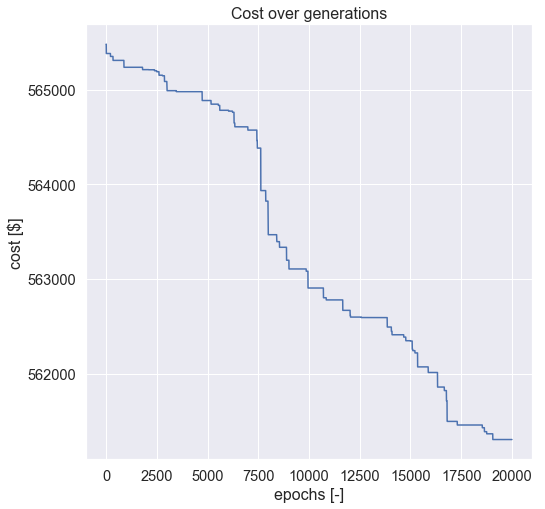

In [818]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 20000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_CHOICE = 2
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                mutation_day(df_pop.loc[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
            

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = \
            cost_function_optim(df_pop.loc[indice].values)

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

#### Save results

In [819]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dc2_rm0.1_gen20000_s561303.pkl']

## Run with pop by days

### Evaluation #1

In [60]:
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

In [61]:
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS))

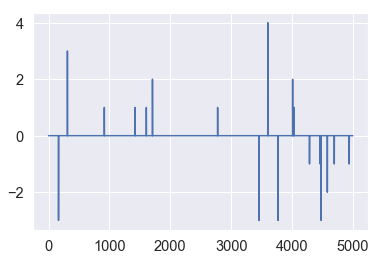

In [62]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [63]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
800  605419.833709
400  654844.718387
900  656228.754657
600  657505.942610
469  665206.371332
0    672254.027668
700  677348.768396
300  679410.167648
635  679441.505966
479  681538.723476

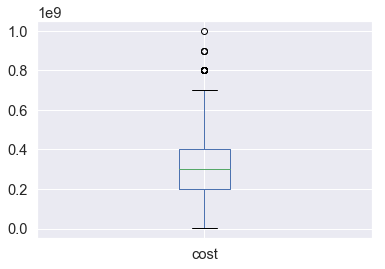

In [64]:
df_cost.boxplot()

###  Loop over generations

In [428]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 20000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_DAYS = 5
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

NameError: name 'cvpopo' is not defined

In [161]:
int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)

-2

In [ ]:
R_POP_LOST*df_cost_sort.shape[0]

#### Save results

In [74]:
# best score
#best_score = \
#cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + '/df_cost_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dd5_rm0.1_gen30000.pkl']

In [124]:

#df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name,:].to_csv("test.csv")

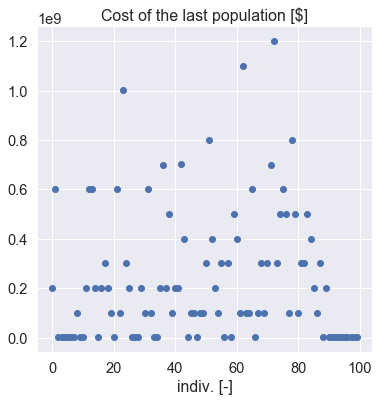

In [67]:
fig = plt.figure(figsize=(6, 6))
plt.title("Cost of the last population [$]")
plt.plot(df_cost["cost"], 'o')
ax = plt.gca()
ax.set_xlabel("indiv. [-]");
#ax.set_ylim([0 , 1e6])

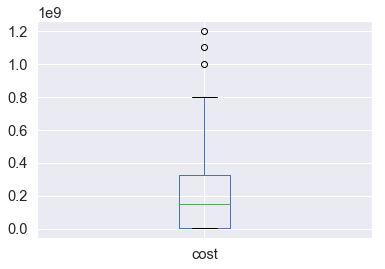

In [68]:
df_cost.boxplot()

In [72]:
cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

585102.5859791327

In [59]:
np.ceil(R_POP_LOST*df_cost_sort.shape[0])

10.0

In [60]:
nb_seeds

10

## Explore more

In [34]:
submission = pd.read_csv('submission_672254.0276683343.csv')
submission.head()

family_id  assigned_day
0          0            52
1          1            26
2          2           100
3          3             2
4          4            53

In [40]:
cost_function(submission['assigned_day'].tolist(), True)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

In [36]:
# function submission -> choice number
list_choice=[]
for fam_id in submission["family_id"]:
    assigned_day = submission.at[fam_id, "assigned_day"]
    list_choice.append(np.argmax((data.filter(items=['choice_{}'.\
                                 format(n) for n in range(0, 10)]).\
        loc[fam_id] == assigned_day).tolist()))

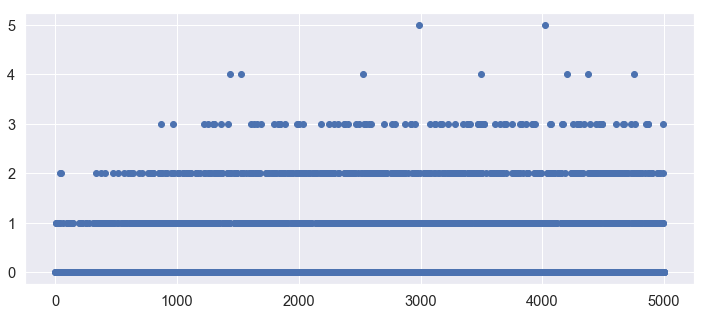

In [37]:
fig = plt.figure(figsize=(12, 5))
plt.plot(submission["family_id"], list_choice, 'o')

In [38]:
submission["choice"] = list_choice

In [39]:
submission["choice"].value_counts()

0    3535
1     946
2     416
3      94
4       7
5       2
Name: choice, dtype: int64